In [1]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import warnings
warnings.filterwarnings("ignore")


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [3]:
# USE THIS ONE!!!! Stratifies like Alerce does
def get_alerce_class(data):
    if data == []: # not classified yet
        top_class_name = "Not_classified"
        return top_class_name
        
    
    # Get unique classifier names and versions
    classifier_names = np.unique([d['classifier_name'] for d in data])
    classifier_versions = np.unique([d['classifier_version'] for d in data])
    
    # Prioritize lc_classifier over stamp_classifier
    if 'lc_classifier' in classifier_names:
        classifier_names = ['lc_classifier', 'stamp_classifier']
    else:
        classifier_names = ['stamp_classifier', 'lc_classifier']
        
    
    for classifier_name in classifier_names:
        for classifier_version in classifier_versions:
            # Filter the data for the current classifier and version
            filtered_data = [d for d in data if d['classifier_name'] == classifier_name 
                                             and d['classifier_version'] == classifier_version]
            
            # Calculate unique class names and sort by probability in descending order
            unique_class_names = np.unique([d['class_name'] for d in filtered_data])
            unique_class_names = sorted(unique_class_names, key=lambda x: np.max([d['probability'] for d in filtered_data 
                                                                                  if d['class_name'] == x]), reverse=True)
            
            # Get the highest probability for the top class_name
            top_class_name = unique_class_names[0]
            top_class_prob = np.max([d['probability'] for d in filtered_data if d['class_name'] == top_class_name])
            
            # Check if there is a higher probability for the same class_name in a different classifier version
            for other_version in classifier_versions:
                if other_version == classifier_version:
                    continue
                other_filtered_data = [d for d in data if d['classifier_name'] == classifier_name 
                                                         and d['classifier_version'] == other_version
                                                         and d['class_name'] == top_class_name]
                if other_filtered_data:
                    other_class_prob = np.max([d['probability'] for d in other_filtered_data])
                    if other_class_prob > top_class_prob:
                        top_class_prob = other_class_prob
                        
            if not isinstance(top_class_name, str):
                top_class_name == "None"
            
            # Return the top class_name with the highest probability
            return top_class_name

In [4]:
def panstarrs_image_filename(position,image_size=None, filter=None):
    """Query panstarrs service to get a list of image names
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :size : int: cutout image size in pixels.
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :filename: str: file name of the cutout
    """

    service = 'https://ps1images.stsci.edu/cgi-bin/ps1filenames.py'
    url = (f'{service}?ra={position.ra.degree}&dec={position.dec.degree}'
           f'&size={image_size}&format=fits&filters={filter}')

    filename_table = pd.read_csv(url, delim_whitespace=True)['filename']
    return filename_table[0] if len(filename_table) > 0 else None

    
def panstarrs_cutout(position, filename, image_size=None, filter=None):
    """
    Download Panstarrs cutout from their own service
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :image_size: int: size of cutout image in pixels
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :cutout : :class:`~astropy.io.fits.HDUList` or None
    """
    
    if filename:
        service = 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?'
        fits_url = (f'{service}ra={position.ra.degree}&dec={position.dec.degree}'
                    f'&size={image_size}&format=fits&red={filename}')
        fits_image = fits.open(fits_url)
    else:
        fits_image = None

    return fits_image

In [5]:
def host_pdfs(df,tns_cls_ref,suffix,save_pdf=True,imsizepix=100,change_contrast=False):
        
        # let's make a PDF with all the host gal coords
        # so we can look through by eye and see which ones

        ref_name = df.name[0]
        data = df
        
        if save_pdf:
            pdf_pages = PdfPages(f'../figures/{tns_cls_ref}/{ref_name}_host_thumbnails_manhattan_90k_{suffix}.pdf')
            #pdf_pages = PdfPages(f'../figures/{ref_name}_host_thumbnails_euclidean.pdf')

        for i, d in df.iterrows():
            
            stamp_path = f"../ps1_cutouts/{d['name']}_pscutout.fits"
            # Comment out if you're rerunning same objects over again
#             if os.path.isfile(stamp_path): 
#                 #print(f"Remove previously saved cutout {d['name']}_pscutout.fits to download new one")
#                 os.remove(stamp_path)
            
            #if i > 20: break
            if not i % 9:
                fig = plt.figure(figsize=(6,6))
                
            #fig = plt.figure()
            
            ax = plt.subplot(3,3,i%9+1)

            ax.set_xticks([])
            ax.set_yticks([])

            try: # Has host assoc
                # download the PS image
                sc = SkyCoord(d['ra'],d['dec'],unit=u.deg)
                

                outfilename = f"../ps1_cutouts/{d['name']}_pscutout.fits"
                if not os.path.exists(outfilename):
                    filename = panstarrs_image_filename(sc,image_size=imsizepix,filter='r')
                    fits_image = panstarrs_cutout(sc,filename,image_size=imsizepix,filter='r')
                    fits_image.writeto(outfilename)

                wcs = WCS(f"../ps1_cutouts/{d['name']}_pscutout.fits")

                imdata = fits.getdata(f"../ps1_cutouts/{d['name']}_pscutout.fits")

                if change_contrast==True:
                    transform = AsinhStretch() + PercentileInterval(93)

                else: transform = AsinhStretch() + PercentileInterval(99.5)
                bfim = transform(imdata)
                ax.imshow(bfim,cmap="gray",origin="lower")
                #ax.plot(imsizepix/2,imsizepix/2,'+',color='r',ms=15)

                ax.set_title(f"{d['name']}",pad=1, fontsize=14)
                
            except:
                imdata = Image.new('RGB', (100, 100), color = (255, 0, 0)) # red
                ax.imshow(imdata, origin="lower")
                ax.set_title(f"{d['name']}",pad=1, fontsize=14)

            if i % 9 == 8:
                plt.ion()
                plt.show()
                #plt.subplots_adjust(0,0,1,1,-0.05,0.05)
                if save_pdf: pdf_pages.savefig(fig, bbox_inches='tight', pad_inches=0.1)
                plt.close()
        
        if save_pdf: 
            pdf_pages.savefig(fig, bbox_inches='tight', pad_inches=0.1)
            pdf_pages.close()
        plt.show()
        

# TODO: non-linear feature tranformation like in ANTARES filter for lc features (np.log and such)

In [6]:
# ANNOY can take sparse vectors :) 
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=300):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        self.seed = self.index.set_seed(10)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    

# Import script for scaling feature values
# ANTARES feature normalisation script
# Written by Anastasia Lavrukhina (Github: anlava) 
# Edited by and Implemented in Patrick Aleo's (Github: patrickaleo), Konstantin Malanchev's (Github: hombit) ANTARES AD filter

ZERO_PERIOD_MASK = 1e-5

def identical(x):
    return x

def period_norm(data):
    data_cp = data 
    if data_cp <= 0:
        data_cp = ZERO_PERIOD_MASK
    #data_cp[data_cp == 0] = ZERO_PERIOD_MASK
    return np.log10(data_cp)

def period_norm_inv(data):
    data_cp = data
    if data_cp <= ZERO_PERIOD_MASK:
        data_cp = 0
    #data_cp[data_cp == ZERO_PERIOD_MASK] = 0
    return np.power(10, data_cp)


weighted_lc_and_host_features_d = {'feature_amplitude_magn_r':1, 
                         'feature_anderson_darling_normal_magn_r':0.1,
                         'feature_beyond_1_std_magn_r':1, 
                         'feature_beyond_2_std_magn_r':1,
                         'feature_cusum_magn_r':1, 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r':1,
                         'feature_inter_percentile_range_10_magn_r':1,
                         'feature_inter_percentile_range_25_magn_r':1, 
                         'feature_kurtosis_magn_r':1,
                         'feature_linear_fit_slope_magn_r':1,
                         'feature_linear_fit_slope_sigma_magn_r':0.1,
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r':1,
                         'feature_magnitude_percentage_ratio_20_5_magn_r':1,
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r':1,
                         'feature_median_absolute_deviation_magn_r':1,
                         'feature_percent_amplitude_magn_r':1,
                         'feature_median_buffer_range_percentage_10_magn_r':1,
                         'feature_median_buffer_range_percentage_20_magn_r':1,
                         'feature_percent_difference_magnitude_percentile_5_magn_r':1,
                         'feature_percent_difference_magnitude_percentile_10_magn_r':1,
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r':1, 
                         'feature_standard_deviation_magn_r':1,
                         'feature_stetson_k_magn_r':1,
                         'feature_weighted_mean_magn_r':1,
                         'feature_anderson_darling_normal_flux_r':0.1, 
                         'feature_cusum_flux_r':1,
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r':1,
                         'feature_kurtosis_flux_r':1, 
                         'feature_mean_variance_flux_r':1,
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r':1,
                         'feature_stetson_k_flux_r':1,

                         'feature_amplitude_magn_g':1, 
                         'feature_anderson_darling_normal_magn_g':0.1,
                         'feature_beyond_1_std_magn_g':1, 
                         'feature_beyond_2_std_magn_g':1,
                         'feature_cusum_magn_g':1, 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g':1,
                         'feature_inter_percentile_range_10_magn_g':1,
                         'feature_inter_percentile_range_25_magn_g':1, 
                         'feature_kurtosis_magn_g':1,
                         'feature_linear_fit_slope_magn_g':1,
                         'feature_linear_fit_slope_sigma_magn_g':0.1,
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g':1,
                         'feature_magnitude_percentage_ratio_20_5_magn_g':1,
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g':1,
                         'feature_median_absolute_deviation_magn_g':1,
                         'feature_median_buffer_range_percentage_10_magn_g':1,
                         'feature_median_buffer_range_percentage_20_magn_g':1,
                         'feature_percent_amplitude_magn_g':1,
                         'feature_percent_difference_magnitude_percentile_5_magn_g':1,
                         'feature_percent_difference_magnitude_percentile_10_magn_g':1,
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g':1, 
                         'feature_standard_deviation_magn_g':1,
                         'feature_stetson_k_magn_g':1, 
                         'feature_weighted_mean_magn_g':1,
                         'feature_anderson_darling_normal_flux_g':0.1, 
                         'feature_cusum_flux_g':1,
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g':1,
                         'feature_kurtosis_flux_g':1, 
                         'feature_mean_variance_flux_g':1,
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g':1,
                         'feature_stetson_k_flux_g':1,
                       # host features
                       #  'Unnamed: 0',
                        #  'level_0',
                        #  'index',
                        #  'objName',
                        #  'objAltName1',
                        #  'objAltName2',
                        #  'objAltName3',
                        #  'objID',
                        #  'uniquePspsOBid',
                        #  'ippObjID',
                        #  'surveyID',
                        #  'htmID',
                        #  'zoneID',
                        #  'tessID',
                        #  'projectionID',
                        #  'skyCellID',
                        #  'randomID',
                        #  'batchID',
                        #  'dvoRegionID',
                        #  'processingVersion',
                        #  'objInfoFlag',
                        #  'qualityFlag',
                        #  'raStack',
                        #  'decStack',
                        #  'raStackErr',
                        #  'decStackErr',
                        #  'raMean',
                        #  'decMean',
                        #  'raMeanErr',
                        #  'decMeanErr',
                        #  'epochMean',
                        #  'posMeanChisq',
                        #  'cx',
                        #  'cy',
                        #  'cz',
                        #  'lambda',
                        #  'beta',
                        #  'l',
                        #  'b',
                        #  'nStackObjectRows',
                        #  'nStackDetections',
                        #  'nDetections',
                        #  'ng',
                        #  'nr',
                        #  'ni',
                        #  'nz',
                        #  'ny',
                        #  'uniquePspsSTid',
                        #  'primaryDetection',
                        #  'bestDetection',
                        #  'gippDetectID',
                        #  'gstackDetectID',
                        #  'gstackImageID',
                        #  'gra',
                        #  'gdec',
                        #  'graErr',
                        #  'gdecErr',
                        #  'gEpoch',
                        #  'gPSFMag',
                        #  'gPSFMagErr',
                        #  'gApMag',
                        #  'gApMagErr',
                        #  'gKronMag',
                        #  'gKronMagErr',
                        #  'ginfoFlag',
                        #  'ginfoFlag2',
                        #  'ginfoFlag3',
                        #  'gnFrames',
                        #  'gxPos',
                        #  'gyPos',
                        #  'gxPosErr',
                        #  'gyPosErr',
                        #  'gpsfMajorFWHM',
                        #  'gpsfMinorFWHM',
                        #  'gpsfTheta',
                        #  'gpsfCore',
                        #  'gpsfLikelihood',
                        #  'gpsfQf',
                        #  'gpsfQfPerfect',
                        #  'gpsfChiSq',
                         'gmomentXX': 1,
                         'gmomentXY': 1,
                         'gmomentYY': 1,
                         'gmomentR1': 1,
                         'gmomentRH': 1,
                         'gPSFFlux': 1,
                        #  'gPSFFluxErr',
                         'gApFlux': 1,
                        #  'gApFluxErr',
                        #  'gApFillFac',
                        #  'gApRadius',
                         'gKronFlux': 1,
                        #  'gKronFluxErr',
                         'gKronRad': 1,
                        #  'gexpTime',
                         'gExtNSigma': 0.1,
                        #  'gsky',
                        #  'gskyErr',
                        #  'gzp',
                        #  'gPlateScale',
                        #  'rippDetectID',
                        #  'rstackDetectID',
                        #  'rstackImageID',
                        #  'rra',
                        #  'rdec',
                        #  'rraErr',
                        #  'rdecErr',
                        #  'rEpoch',
                        # 'rPSFMag',
                        #  'rPSFMagErr',
                        # 'rApMag',
                        #  'rApMagErr',
                        # 'rKronMag',
                        #  'rKronMagErr',
                        #  'rinfoFlag',
                        #  'rinfoFlag2',
                        #  'rinfoFlag3',
                        #  'rnFrames',
                        #  'rxPos',
                        #  'ryPos',
                        #  'rxPosErr',
                        #  'ryPosErr',
                        #  'rpsfMajorFWHM',
                        #  'rpsfMinorFWHM',
                        #  'rpsfTheta',
                        #  'rpsfCore',
                        #  'rpsfLikelihood',
                        #  'rpsfQf',
                        #  'rpsfQfPerfect',
                        #  'rpsfChiSq',
                         'rmomentXX': 1,
                         'rmomentXY': 1,
                         'rmomentYY': 1,
                         'rmomentR1': 1,
                         'rmomentRH': 1,
                        'rPSFFlux': 1,
                        #  'rPSFFluxErr',
                        'rApFlux': 1,
                        #  'rApFluxErr',
                        #  'rApFillFac',
                        # 'rApRadius',
                        'rKronFlux': 1,
                        #  'rKronFluxErr',
                        'rKronRad': 1,
                        #  'rexpTime',
                         'rExtNSigma': 0.1,
                        #  'rsky',
                        #  'rskyErr',
                        #  'rzp',
                        #  'rPlateScale',
                        #  'iippDetectID',
                        #  'istackDetectID',
                        #  'istackImageID',
                        #  'ira',
                        #  'idec',
                        #  'iraErr',
                        #  'idecErr',
                        #  'iEpoch',
                        #  'iPSFMag',
                        #  'iPSFMagErr',
                        #  'iApMag',
                        #  'iApMagErr',
                        #  'iKronMag',
                        #  'iKronMagErr',
                        #  'iinfoFlag',
                        #  'iinfoFlag2',
                        #  'iinfoFlag3',
                        #  'inFrames',
                        #  'ixPos',
                        #  'iyPos',
                        #  'ixPosErr',
                        #  'iyPosErr',
                        #  'ipsfMajorFWHM',
                        #  'ipsfMinorFWHM',
                        #  'ipsfTheta',
                        #  'ipsfCore',
                        #  'ipsfLikelihood',
                        #  'ipsfQf',
                        #  'ipsfQfPerfect',
                        #  'ipsfChiSq',
                          'imomentXX': 1,
                         'imomentXY': 1,
                         'imomentYY': 1,
                         'imomentR1': 1,
                         'imomentRH': 1,
                         'iPSFFlux': 1,
                        #  'iPSFFluxErr',
                         'iApFlux': 1,
                        #  'iApFluxErr',
                        #  'iApFillFac',
                        #  'iApRadius',
                         'iKronFlux': 1,
                        #  'iKronFluxErr',
                         'iKronRad': 1,
                        #  'iexpTime',
                          'iExtNSigma': 0.1,
                        #  'isky',
                        #  'iskyErr',
                        #  'izp',
                        #  'iPlateScale',
                        #  'zippDetectID',
                        #  'zstackDetectID',
                        #  'zstackImageID',
                        #  'zra',
                        #  'zdec',
                        #  'zraErr',
                        #  'zdecErr',
                        #  'zEpoch',
                        #  'zPSFMag',
                        #  'zPSFMagErr',
                        #  'zApMag',
                        #  'zApMagErr',
                        #  'zKronMag',
                        #  'zKronMagErr',
                        #  'zinfoFlag',
                        #  'zinfoFlag2',
                        #  'zinfoFlag3',
                        #  'znFrames',
                        #  'zxPos',
                        #  'zyPos',
                        #  'zxPosErr',
                        #  'zyPosErr',
                        #  'zpsfMajorFWHM',
                        #  'zpsfMinorFWHM',
                        #  'zpsfTheta',
                        #  'zpsfCore',
                        #  'zpsfLikelihood',
                        #  'zpsfQf',
                        #  'zpsfQfPerfect',
                        #  'zpsfChiSq',
                          'zmomentXX': 1,
                         'zmomentXY': 1,
                         'zmomentYY': 1,
                         'zmomentR1': 1,
                         'zmomentRH': 1,
                         'zPSFFlux': 1,
                        # #  'zPSFFluxErr',
                         'zApFlux': 1,
                        # #  'zApFluxErr',
                        # #  'zApFillFac',
                        # #  'zApRadius',
                         'zKronFlux': 1,
                        # #  'zKronFluxErr',
                         'zKronRad': 1,
                        # #  'zexpTime',
                          'zExtNSigma': 0.1,
                        #  'zsky',
                        #  'zskyErr',
                        #  'zzp',
                        #  'zPlateScale',
                        #  'yippDetectID',
                        #  'ystackDetectID',
                        #  'ystackImageID',
                        #  'yra',
                        #  'ydec',
                        #  'yraErr',
                        #  'ydecErr',
                        #  'yEpoch',
                        #  'yPSFMag',
                        #  'yPSFMagErr',
                        #  'yApMag',
                        #  'yApMagErr',
                        #  'yKronMag',
                        #  'yKronMagErr',
                        #  'yinfoFlag',
                        #  'yinfoFlag2',
                        #  'yinfoFlag3',
                        #  'ynFrames',
                        #  'yxPos',
                        #  'yyPos',
                        #  'yxPosErr',
                        #  'yyPosErr',
                        #  'ypsfMajorFWHM',
                        #  'ypsfMinorFWHM',
                        #  'ypsfTheta',
                        #  'ypsfCore',
                        #  'ypsfLikelihood',
                        #  'ypsfQf',
                        #  'ypsfQfPerfect',
                        #  'ypsfChiSq',
                          'ymomentXX': 1,
                          'ymomentXY': 1,
                          'ymomentYY': 1,
                          'ymomentR1': 1,
                          'ymomentRH': 1,
                          'yPSFFlux': 1,
                        # #   'yPSFFluxErr',
                          'yApFlux': 1,
                        # #   'yApFluxErr',
                        # #   'yApFillFac',
                        # #  'yApRadius',
                         'yKronFlux': 1,
                        # #  'yKronFluxErr',
                         'yKronRad': 1,
                        # #  'yexpTime',
                          'yExtNSigma': 0.1,
                        #  'ysky',
                        #  'yskyErr',
                        #  'yzp',
                        #  'yPlateScale',
                        #  'distance',
                        #  'SkyMapper_StarClass',
                        #  'gelong',
                        #  'g_a',
                        #  'g_b',
                        #  'g_pa',
                        #  'relong',
                        #  'r_a',
                        #  'r_b',
                        #  'r_pa',
                        #  'ielong',
                        #  'i_a',
                        #  'i_b',
                        #  'i_pa',
                        #  'zelong',
                        #  'z_a',
                        #  'z_b',
                        #  'z_pa',
                           'i-z': 1, # try throwing in
                        #    'g-r',
                        #    'r-i',
                        #    'g-i',
                        #    'z-y',
                        #   'g-rErr',
                        #   'r-iErr',
                        #   'i-zErr',
                        #   'z-yErr',
                         'gApMag_gKronMag': 0.1,
                         'rApMag_rKronMag': 0.1,
                         'iApMag_iKronMag': 0.1,
                         'zApMag_zKronMag': 0.1,
                         'yApMag_yKronMag': 0.1,
                         '7DCD': 1, 
                        #  'NED_name',
                        #  'NED_type',
                        #  'NED_vel',
                        #  'NED_redshift',
                        #  'NED_mag',
                        #  'class',
                           'dist/DLR': 1,
                        #   'dist',
                        #  'TransientClass',
                        #  'TransientRA',
                        #  'TransientDEC'
                      }




antares_norm_direct = {'feature_amplitude_magn_r': identical, 
                            'feature_anderson_darling_normal_flux_r': np.log10, 
                           'feature_anderson_darling_normal_magn_r': np.log10, 
                           'feature_beyond_1_std_magn_r': identical, 
                            'feature_beyond_2_std_magn_r': np.sqrt,
                            'feature_chi2_flux_r' : np.log1p,
                            'feature_chi2_magn_r': np.log1p,
                            #'feature_chi2_magn_r': np.log1p,
                            'feature_cusum_flux_r': identical,
                            'feature_cusum_magn_r': identical,
                            'feature_eta_e_flux_r': np.log10,
                            'feature_eta_e_magn_r': np.log10,
                            'feature_excess_variance_flux_r': np.cbrt,
                            'feature_inter_percentile_range_10_magn_r': identical,
                            'feature_inter_percentile_range_25_magn_r': identical,
                            'feature_inter_percentile_range_2_magn_r': identical,
                            'feature_kurtosis_flux_r': np.arcsinh,
                            'feature_kurtosis_magn_r': np.arcsinh,
                            'feature_linear_fit_reduced_chi2_magn_r': np.log1p,
                            'feature_linear_fit_slope_magn_r': identical,
                            'feature_linear_fit_slope_sigma_magn_r': identical, #np.log10,
                            'feature_linear_trend_magn_r': identical,
                            'feature_linear_trend_sigma_magn_r': np.log10,
                       'feature_magnitude_percentage_ratio_20_5_magn_r': identical,
                       'feature_magnitude_percentage_ratio_40_5_magn_r': identical,
                       'feature_maximum_slope_magn_r' : np.log10,
                       'feature_mean_magn_r': identical,
                       'feature_mean_variance_flux_r': np.log10,
                       'feature_median_absolute_deviation_magn_r': identical,
                       'feature_median_buffer_range_percentage_10_magn_r': identical,
                       'feature_median_buffer_range_percentage_20_magn_r' : identical,
                       'feature_percent_amplitude_magn_r': identical,
                       'feature_percent_difference_magnitude_percentile_10_magn_r': identical, #np.log10,
                       'feature_percent_difference_magnitude_percentile_5_magn_r': identical, #np.log10,
                       'feature_period_0_magn_r' : period_norm,
                       'feature_period_1_magn_r' : period_norm,
                       'feature_period_2_magn_r' : period_norm,
                       'feature_period_3_magn_r' : period_norm,
                       'feature_period_4_magn_r' : period_norm,
                       'feature_period_s_to_n_0_magn_r' : np.arcsinh,
                       'feature_period_s_to_n_1_magn_r' : np.arcsinh,
                       'feature_period_s_to_n_2_magn_r' : np.arcsinh,
                       'feature_period_s_to_n_3_magn_r' : np.arcsinh,
                       'feature_period_s_to_n_4_magn_r' : np.arcsinh,
                       'feature_periodogram_amplitude_magn_r' : np.log1p,
                       'feature_periodogram_beyond_2_std_magn_r' : identical,
                       'feature_periodogram_beyond_3_std_magn_r': identical,
                       'feature_periodogram_standard_deviation_magn_r' : np.log1p,
                       'feature_skew_flux_r' : np.arcsinh,
                       'feature_skew_magn_r' : np.arcsinh,
                       'feature_standard_deviation_magn_r' : identical,
                       'feature_stetson_k_flux_r' : identical,
                       'feature_stetson_k_magn_r' : identical, 
                       'feature_weighted_mean_magn_r': identical,
                       'feature_amplitude_magn_g': identical, 
                        'feature_anderson_darling_normal_flux_g': np.log10, 
                           'feature_anderson_darling_normal_magn_g': np.log10, 
                           'feature_beyond_1_std_magn_g': identical, 
                            'feature_beyond_2_std_magn_g': np.sqrt,
                            'feature_chi2_flux_g' : np.log1p,
                            'feature_chi2_magn_g': np.log1p,
                            #'feature_chi2_magn_g': np.log1p,
                            'feature_cusum_flux_g': identical,
                            'feature_cusum_magn_g': identical,
                            'feature_eta_e_flux_g': np.log10,
                            'feature_eta_e_magn_g': np.log10,
                            'feature_excess_variance_flux_g': np.cbrt,
                            'feature_inter_percentile_range_10_magn_g': identical,
                            'feature_inter_percentile_range_25_magn_g': identical,
                            'feature_inter_percentile_range_2_magn_g': identical,
                            'feature_kurtosis_flux_g': np.arcsinh,
                            'feature_kurtosis_magn_g': np.arcsinh,
                            'feature_linear_fit_reduced_chi2_magn_g': np.log1p,
                            'feature_linear_fit_slope_magn_g': identical,
                            'feature_linear_fit_slope_sigma_magn_g': identical, # np.log10,
                            'feature_linear_trend_magn_g': identical,
                            'feature_linear_trend_sigma_magn_g': np.log10,
                       'feature_magnitude_percentage_ratio_20_5_magn_g': identical,
                       'feature_magnitude_percentage_ratio_40_5_magn_g': identical,
                       'feature_maximum_slope_magn_g' : np.log10,
                       'feature_mean_magn_g': identical,
                       'feature_mean_variance_flux_g': np.log10,
                       'feature_median_absolute_deviation_magn_g': identical,
                       'feature_median_buffer_range_percentage_10_magn_g': identical,
                       'feature_median_buffer_range_percentage_20_magn_g' : identical,
                       'feature_percent_amplitude_magn_g': identical,
                       'feature_percent_difference_magnitude_percentile_10_magn_g': identical, #np.log10,
                       'feature_percent_difference_magnitude_percentile_5_magn_g': identical, #np.log10,
                       'feature_period_0_magn_g' : period_norm,
                       'feature_period_1_magn_g' : period_norm,
                       'feature_period_2_magn_g' : period_norm,
                       'feature_period_3_magn_g' : period_norm,
                       'feature_period_4_magn_g' : period_norm,
                       'feature_period_s_to_n_0_magn_g' : np.arcsinh,
                       'feature_period_s_to_n_1_magn_g' : np.arcsinh,
                       'feature_period_s_to_n_2_magn_g' : np.arcsinh,
                       'feature_period_s_to_n_3_magn_g' : np.arcsinh,
                       'feature_period_s_to_n_4_magn_g' : np.arcsinh,
                       'feature_periodogram_amplitude_magn_g' : np.log1p,
                       'feature_periodogram_beyond_2_std_magn_g' : identical,
                       'feature_periodogram_beyond_3_std_magn_g': identical,
                       'feature_periodogram_standard_deviation_magn_g' : np.log1p,
                       'feature_skew_flux_g' : np.arcsinh,
                       'feature_skew_magn_g' : np.arcsinh,
                       'feature_standard_deviation_magn_g' : identical,
                       'feature_stetson_k_flux_g' : identical,
                       'feature_stetson_k_magn_g' : identical, 
                       'feature_weighted_mean_magn_g': identical,
                       # host features
                       #  'Unnamed: 0',
                        #  'level_0',
                        #  'index',
                        #  'objName',
                        #  'objAltName1',
                        #  'objAltName2',
                        #  'objAltName3',
                        #  'objID',
                        #  'uniquePspsOBid',
                        #  'ippObjID',
                        #  'surveyID',
                        #  'htmID',
                        #  'zoneID',
                        #  'tessID',
                        #  'projectionID',
                        #  'skyCellID',
                        #  'randomID',
                        #  'batchID',
                        #  'dvoRegionID',
                        #  'processingVersion',
                        #  'objInfoFlag',
                        #  'qualityFlag',
                        #  'raStack',
                        #  'decStack',
                        #  'raStackErr',
                        #  'decStackErr',
                        #  'raMean',
                        #  'decMean',
                        #  'raMeanErr',
                        #  'decMeanErr',
                        #  'epochMean',
                        #  'posMeanChisq',
                        #  'cx',
                        #  'cy',
                        #  'cz',
                        #  'lambda',
                        #  'beta',
                        #  'l',
                        #  'b',
                        #  'nStackObjectRows',
                        #  'nStackDetections',
                        #  'nDetections',
                        #  'ng',
                        #  'nr',
                        #  'ni',
                        #  'nz',
                        #  'ny',
                        #  'uniquePspsSTid',
                        #  'primaryDetection',
                        #  'bestDetection',
                        #  'gippDetectID',
                        #  'gstackDetectID',
                        #  'gstackImageID',
                        #  'gra',
                        #  'gdec',
                        #  'graErr',
                        #  'gdecErr',
                        #  'gEpoch',
                        #  'gPSFMag',
                        #  'gPSFMagErr',
                        #  'gApMag',
                        #  'gApMagErr',
                        #  'gKronMag',
                        #  'gKronMagErr',
                        #  'ginfoFlag',
                        #  'ginfoFlag2',
                        #  'ginfoFlag3',
                        #  'gnFrames',
                        #  'gxPos',
                        #  'gyPos',
                        #  'gxPosErr',
                        #  'gyPosErr',
                        #  'gpsfMajorFWHM',
                        #  'gpsfMinorFWHM',
                        #  'gpsfTheta',
                        #  'gpsfCore',
                        #  'gpsfLikelihood',
                        #  'gpsfQf',
                        #  'gpsfQfPerfect',
                        #  'gpsfChiSq',
                         'gmomentXX': identical,
                         'gmomentXY': identical,
                         'gmomentYY': identical,
                         'gmomentR1': identical,
                         'gmomentRH': identical,
                         'gPSFFlux': identical,
                        #  'gPSFFluxErr',
                         'gApFlux': identical,
                        #  'gApFluxErr',
                        #  'gApFillFac',
                        #  'gApRadius',
                         'gKronFlux': identical,
                        #  'gKronFluxErr',
                         'gKronRad': identical,
                        #  'gexpTime',
                         'gExtNSigma': identical,
                        #  'gsky',
                        #  'gskyErr',
                        #  'gzp',
                        #  'gPlateScale',
                        #  'rippDetectID',
                        #  'rstackDetectID',
                        #  'rstackImageID',
                        #  'rra',
                        #  'rdec',
                        #  'rraErr',
                        #  'rdecErr',
                        #  'rEpoch',
                        # 'rPSFMag',
                        #  'rPSFMagErr',
                        # 'rApMag',
                        #  'rApMagErr',
                        # 'rKronMag',
                        #  'rKronMagErr',
                        #  'rinfoFlag',
                        #  'rinfoFlag2',
                        #  'rinfoFlag3',
                        #  'rnFrames',
                        #  'rxPos',
                        #  'ryPos',
                        #  'rxPosErr',
                        #  'ryPosErr',
                        #  'rpsfMajorFWHM',
                        #  'rpsfMinorFWHM',
                        #  'rpsfTheta',
                        #  'rpsfCore',
                        #  'rpsfLikelihood',
                        #  'rpsfQf',
                        #  'rpsfQfPerfect',
                        #  'rpsfChiSq',
                         'rmomentXX': identical,
                         'rmomentXY': identical,
                         'rmomentYY': identical,
                         'rmomentR1': identical,
                         'rmomentRH': identical,
                        'rPSFFlux': identical,
                        #  'rPSFFluxErr',
                        'rApFlux': identical,
                        #  'rApFluxErr',
                        #  'rApFillFac',
                        # 'rApRadius',
                        'rKronFlux': identical,
                        #  'rKronFluxErr',
                        'rKronRad': identical,
                        #  'rexpTime',
                         'rExtNSigma': identical,
                        #  'rsky',
                        #  'rskyErr',
                        #  'rzp',
                        #  'rPlateScale',
                        #  'iippDetectID',
                        #  'istackDetectID',
                        #  'istackImageID',
                        #  'ira',
                        #  'idec',
                        #  'iraErr',
                        #  'idecErr',
                        #  'iEpoch',
                        #  'iPSFMag',
                        #  'iPSFMagErr',
                        #  'iApMag',
                        #  'iApMagErr',
                        #  'iKronMag',
                        #  'iKronMagErr',
                        #  'iinfoFlag',
                        #  'iinfoFlag2',
                        #  'iinfoFlag3',
                        #  'inFrames',
                        #  'ixPos',
                        #  'iyPos',
                        #  'ixPosErr',
                        #  'iyPosErr',
                        #  'ipsfMajorFWHM',
                        #  'ipsfMinorFWHM',
                        #  'ipsfTheta',
                        #  'ipsfCore',
                        #  'ipsfLikelihood',
                        #  'ipsfQf',
                        #  'ipsfQfPerfect',
                        #  'ipsfChiSq',
                          'imomentXX': identical,
                         'imomentXY': identical,
                         'imomentYY': identical,
                         'imomentR1': identical,
                         'imomentRH': identical,
                         'iPSFFlux': identical,
                        #  'iPSFFluxErr',
                         'iApFlux': identical,
                        #  'iApFluxErr',
                        #  'iApFillFac',
                        #  'iApRadius',
                         'iKronFlux': identical,
                        #  'iKronFluxErr',
                         'iKronRad': identical,
                        #  'iexpTime',
                          'iExtNSigma': identical,
                        #  'isky',
                        #  'iskyErr',
                        #  'izp',
                        #  'iPlateScale',
                        #  'zippDetectID',
                        #  'zstackDetectID',
                        #  'zstackImageID',
                        #  'zra',
                        #  'zdec',
                        #  'zraErr',
                        #  'zdecErr',
                        #  'zEpoch',
                        #  'zPSFMag',
                        #  'zPSFMagErr',
                        #  'zApMag',
                        #  'zApMagErr',
                        #  'zKronMag',
                        #  'zKronMagErr',
                        #  'zinfoFlag',
                        #  'zinfoFlag2',
                        #  'zinfoFlag3',
                        #  'znFrames',
                        #  'zxPos',
                        #  'zyPos',
                        #  'zxPosErr',
                        #  'zyPosErr',
                        #  'zpsfMajorFWHM',
                        #  'zpsfMinorFWHM',
                        #  'zpsfTheta',
                        #  'zpsfCore',
                        #  'zpsfLikelihood',
                        #  'zpsfQf',
                        #  'zpsfQfPerfect',
                        #  'zpsfChiSq',
                          'zmomentXX': identical,
                         'zmomentXY': identical,
                         'zmomentYY': identical,
                         'zmomentR1': identical,
                         'zmomentRH': identical,
                         'zPSFFlux': identical,
                        # #  'zPSFFluxErr',
                         'zApFlux': identical,
                        # #  'zApFluxErr',
                        # #  'zApFillFac',
                        # #  'zApRadius',
                         'zKronFlux': identical,
                        # #  'zKronFluxErr',
                         'zKronRad': identical,
                        # #  'zexpTime',
                          'zExtNSigma': identical,
                        #  'zsky',
                        #  'zskyErr',
                        #  'zzp',
                        #  'zPlateScale',
                        #  'yippDetectID',
                        #  'ystackDetectID',
                        #  'ystackImageID',
                        #  'yra',
                        #  'ydec',
                        #  'yraErr',
                        #  'ydecErr',
                        #  'yEpoch',
                        #  'yPSFMag',
                        #  'yPSFMagErr',
                        #  'yApMag',
                        #  'yApMagErr',
                        #  'yKronMag',
                        #  'yKronMagErr',
                        #  'yinfoFlag',
                        #  'yinfoFlag2',
                        #  'yinfoFlag3',
                        #  'ynFrames',
                        #  'yxPos',
                        #  'yyPos',
                        #  'yxPosErr',
                        #  'yyPosErr',
                        #  'ypsfMajorFWHM',
                        #  'ypsfMinorFWHM',
                        #  'ypsfTheta',
                        #  'ypsfCore',
                        #  'ypsfLikelihood',
                        #  'ypsfQf',
                        #  'ypsfQfPerfect',
                        #  'ypsfChiSq',
                          'ymomentXX': identical,
                          'ymomentXY': identical,
                          'ymomentYY': identical,
                          'ymomentR1': identical,
                          'ymomentRH': identical,
                          'yPSFFlux': identical,
                        # #   'yPSFFluxErr',
                          'yApFlux': identical,
                        # #   'yApFluxErr',
                        # #   'yApFillFac',
                        # #  'yApRadius',
                         'yKronFlux': identical,
                        # #  'yKronFluxErr',
                         'yKronRad': identical,
                        # #  'yexpTime',
                          'yExtNSigma': identical,
                        #  'ysky',
                        #  'yskyErr',
                        #  'yzp',
                        #  'yPlateScale',
                        #  'distance',
                        #  'SkyMapper_StarClass',
                        #  'gelong',
                        #  'g_a',
                        #  'g_b',
                        #  'g_pa',
                        #  'relong',
                        #  'r_a',
                        #  'r_b',
                        #  'r_pa',
                        #  'ielong',
                        #  'i_a',
                        #  'i_b',
                        #  'i_pa',
                        #  'zelong',
                        #  'z_a',
                        #  'z_b',
                        #  'z_pa',
                           'i-z': identical, # try throwing in
                        #    'g-r',
                        #    'r-i',
                        #    'g-i',
                        #    'z-y',
                        #   'g-rErr',
                        #   'r-iErr',
                        #   'i-zErr',
                        #   'z-yErr',
                         'gApMag_gKronMag': identical,
                         'rApMag_rKronMag': identical,
                         'iApMag_iKronMag': identical,
                         'zApMag_zKronMag': identical,
                         'yApMag_yKronMag': identical,
                         '7DCD': identical, 
                        #  'NED_name',
                        #  'NED_type',
                        #  'NED_vel',
                        #  'NED_redshift',
                        #  'NED_mag',
                        #  'class',
                           'dist/DLR': identical,
                        #   'dist',
                        #  'TransientClass',
                        #  'TransientRA',
                        #  'TransientDEC'
                      }

antares_norm_inverse = {'feature_amplitude_magn_r': identical, 
                            'feature_anderson_darling_normal_flux_r': lambda x: np.power(10, x), 
                           'feature_anderson_darling_normal_magn_r': lambda x: np.power(10, x), 
                           'feature_beyond_1_std_magn_r': identical, 
                            'feature_beyond_2_std_magn_r ': lambda x: np.power(x, 2),
                            'feature_chi2_flux_r' : np.expm1,
                            'feature_chi2_magn_r': np.expm1,
                            #'feature_chi2_magn_r': np.expm1,
                            'feature_cusum_flux_r': identical,
                            'feature_cusum_magn_r': identical,
                            'feature_eta_e_flux_r': lambda x: np.power(10, x),
                            'feature_eta_e_magn_r': lambda x: np.power(10, x),
                            'feature_excess_variance_flux_r': lambda x: np.power(x, 3),
                            'feature_inter_percentile_range_10_magn_r': identical,
                            'feature_inter_percentile_range_25_magn_r': identical,
                            'feature_inter_percentile_range_2_magn_r': identical,
                            'feature_kurtosis_flux_r': np.sinh,
                            'feature_kurtosis_magn_r': np.sinh,
                            'feature_linear_fit_reduced_chi2_magn_r': np.expm1,
                            'feature_linear_fit_slope_magn_r': identical,
                            'feature_linear_fit_slope_sigma_magn_r': identical, #lambda x: np.power(10, x),
                            'feature_linear_trend_magn_r': identical,
                            'feature_linear_trend_sigma_magn_r': lambda x: np.power(10, x),
                       'feature_magnitude_percentage_ratio_20_5_magn_r': identical,
                       'feature_magnitude_percentage_ratio_40_5_magn_r': identical,
                       'feature_maximum_slope_magn_r' : lambda x: np.power(10, x),
                       'feature_mean_magn_r': identical,
                       'feature_mean_variance_flux_r': lambda x: np.power(10, x),
                       'feature_median_absolute_deviation_magn_r': identical,
                       'feature_median_buffer_range_percentage_10_magn_r': identical,
                       'feature_median_buffer_range_percentage_20_magn_r' : identical,
                       'feature_percent_amplitude_magn_r': identical,
                       'feature_percent_difference_magnitude_percentile_10_magn_r': identical, #lambda x: np.power(10, x),
                       'feature_percent_difference_magnitude_percentile_5_magn_r': identical, #lambda x: np.power(10, x),
                       'feature_period_0_magn_r' : period_norm_inv,
                       'feature_period_1_magn_r' : period_norm_inv,
                       'feature_period_2_magn_r' : period_norm_inv,
                       'feature_period_3_magn_r' : period_norm_inv,
                       'feature_period_4_magn_r' : period_norm_inv,
                       'feature_period_s_to_n_0_magn_r' : np.sinh,
                       'feature_period_s_to_n_1_magn_r' : np.sinh,
                       'feature_period_s_to_n_2_magn_r' : np.sinh,
                       'feature_period_s_to_n_3_magn_r' : np.sinh,
                       'feature_period_s_to_n_4_magn_r' : np.sinh,
                       'feature_periodogram_amplitude_magn_r' : np.expm1,
                       'feature_periodogram_beyond_2_std_magn_r' : identical,
                       'feature_periodogram_beyond_3_std_magn_r': identical,
                       'feature_periodogram_standard_deviation_magn_r' : np.expm1,
                       'feature_skew_flux_r' : np.sinh,
                       'feature_skew_magn_r' : np.sinh,
                       'feature_standard_deviation_magn_r' : identical,
                       'feature_stetson_k_flux_r' : identical,
                       'feature_stetson_k_magn_r' : identical, 
                       'feature_weighted_mean_magn_r': identical,
                        'feature_amplitude_magn_g': identical, 
                        'feature_anderson_darling_normal_flux_g': lambda x: np.power(10, x), 
                           'feature_anderson_darling_normal_magn_g': lambda x: np.power(10, x), 
                           'feature_beyond_1_std_magn_g': identical, 
                            'feature_beyond_2_std_magn_g': lambda x: np.power(x, 2),
                            'feature_chi2_flux_g' : np.expm1,
                            'feature_chi2_magn_g': np.expm1,
                            #'feature_chi2_magn_g': np.expm1,
                            'feature_cusum_flux_g': identical,
                            'feature_cusum_magn_g': identical,
                            'feature_eta_e_flux_g': lambda x: np.power(10, x),
                            'feature_eta_e_magn_g': lambda x: np.power(10, x),
                            'feature_excess_variance_flux_g': lambda x: np.power(x, 3),
                            'feature_inter_percentile_range_10_magn_g': identical,
                            'feature_inter_percentile_range_25_magn_g': identical,
                            'feature_inter_percentile_range_2_magn_g': identical,
                            'feature_kurtosis_flux_g': np.sinh,
                            'feature_kurtosis_magn_g': np.sinh,
                            'feature_linear_fit_reduced_chi2_magn_g': np.expm1,
                            'feature_linear_fit_slope_magn_g': identical,
                            'feature_linear_fit_slope_sigma_magn_g': identical, # lambda x: np.power(10, x),
                            'feature_linear_trend_magn_g': identical,
                            'feature_linear_trend_sigma_magn_g': lambda x: np.power(10, x),
                       'feature_magnitude_percentage_ratio_20_5_magn_g': identical,
                       'feature_magnitude_percentage_ratio_40_5_magn_g': identical,
                       'feature_maximum_slope_magn_g' : lambda x: np.power(10, x),
                       'feature_mean_magn_g': identical,
                       'feature_mean_variance_flux_g': lambda x: np.power(10, x),
                       'feature_median_absolute_deviation_magn_g': identical,
                       'feature_median_buffer_range_percentage_10_magn_g': identical,
                       'feature_median_buffer_range_percentage_20_magn_g' : identical,
                       'feature_percent_amplitude_magn_g': identical,
                       'feature_percent_difference_magnitude_percentile_10_magn_g': identical, # lambda x: np.power(10, x),
                       'feature_percent_difference_magnitude_percentile_5_magn_g': identical, # lambda x: np.power(10, x),
                       'feature_period_0_magn_g' : period_norm_inv,
                       'feature_period_1_magn_g' : period_norm_inv,
                       'feature_period_2_magn_g' : period_norm_inv,
                       'feature_period_3_magn_g' : period_norm_inv,
                       'feature_period_4_magn_g' : period_norm_inv,
                       'feature_period_s_to_n_0_magn_g' : np.sinh,
                       'feature_period_s_to_n_1_magn_g' : np.sinh,
                       'feature_period_s_to_n_2_magn_g' : np.sinh,
                       'feature_period_s_to_n_3_magn_g' : np.sinh,
                       'feature_period_s_to_n_4_magn_g' : np.sinh,
                       'feature_periodogram_amplitude_magn_g' : np.expm1,
                       'feature_periodogram_beyond_2_std_magn_g' : identical,
                       'feature_periodogram_beyond_3_std_magn_g': identical,
                       'feature_periodogram_standard_deviation_magn_g' : np.expm1,
                       'feature_skew_flux_g' : np.sinh,
                       'feature_skew_magn_g' : np.sinh,
                       'feature_standard_deviation_magn_g' : identical,
                       'feature_stetson_k_flux_g' : identical,
                       'feature_stetson_k_magn_g' : identical, 
                       'feature_weighted_mean_magn_g': identical,
                                               # host features
                       #  'Unnamed: 0',
                        #  'level_0',
                        #  'index',
                        #  'objName',
                        #  'objAltName1',
                        #  'objAltName2',
                        #  'objAltName3',
                        #  'objID',
                        #  'uniquePspsOBid',
                        #  'ippObjID',
                        #  'surveyID',
                        #  'htmID',
                        #  'zoneID',
                        #  'tessID',
                        #  'projectionID',
                        #  'skyCellID',
                        #  'randomID',
                        #  'batchID',
                        #  'dvoRegionID',
                        #  'processingVersion',
                        #  'objInfoFlag',
                        #  'qualityFlag',
                        #  'raStack',
                        #  'decStack',
                        #  'raStackErr',
                        #  'decStackErr',
                        #  'raMean',
                        #  'decMean',
                        #  'raMeanErr',
                        #  'decMeanErr',
                        #  'epochMean',
                        #  'posMeanChisq',
                        #  'cx',
                        #  'cy',
                        #  'cz',
                        #  'lambda',
                        #  'beta',
                        #  'l',
                        #  'b',
                        #  'nStackObjectRows',
                        #  'nStackDetections',
                        #  'nDetections',
                        #  'ng',
                        #  'nr',
                        #  'ni',
                        #  'nz',
                        #  'ny',
                        #  'uniquePspsSTid',
                        #  'primaryDetection',
                        #  'bestDetection',
                        #  'gippDetectID',
                        #  'gstackDetectID',
                        #  'gstackImageID',
                        #  'gra',
                        #  'gdec',
                        #  'graErr',
                        #  'gdecErr',
                        #  'gEpoch',
                        #  'gPSFMag',
                        #  'gPSFMagErr',
                        #  'gApMag',
                        #  'gApMagErr',
                        #  'gKronMag',
                        #  'gKronMagErr',
                        #  'ginfoFlag',
                        #  'ginfoFlag2',
                        #  'ginfoFlag3',
                        #  'gnFrames',
                        #  'gxPos',
                        #  'gyPos',
                        #  'gxPosErr',
                        #  'gyPosErr',
                        #  'gpsfMajorFWHM',
                        #  'gpsfMinorFWHM',
                        #  'gpsfTheta',
                        #  'gpsfCore',
                        #  'gpsfLikelihood',
                        #  'gpsfQf',
                        #  'gpsfQfPerfect',
                        #  'gpsfChiSq',
                         'gmomentXX': identical,
                         'gmomentXY': identical,
                         'gmomentYY': identical,
                         'gmomentR1': identical,
                         'gmomentRH': identical,
                         'gPSFFlux': identical,
                        #  'gPSFFluxErr',
                         'gApFlux': identical,
                        #  'gApFluxErr',
                        #  'gApFillFac',
                        #  'gApRadius',
                         'gKronFlux': identical,
                        #  'gKronFluxErr',
                         'gKronRad': identical,
                        #  'gexpTime',
                         'gExtNSigma': identical,
                        #  'gsky',
                        #  'gskyErr',
                        #  'gzp',
                        #  'gPlateScale',
                        #  'rippDetectID',
                        #  'rstackDetectID',
                        #  'rstackImageID',
                        #  'rra',
                        #  'rdec',
                        #  'rraErr',
                        #  'rdecErr',
                        #  'rEpoch',
                        # 'rPSFMag',
                        #  'rPSFMagErr',
                        # 'rApMag',
                        #  'rApMagErr',
                        # 'rKronMag',
                        #  'rKronMagErr',
                        #  'rinfoFlag',
                        #  'rinfoFlag2',
                        #  'rinfoFlag3',
                        #  'rnFrames',
                        #  'rxPos',
                        #  'ryPos',
                        #  'rxPosErr',
                        #  'ryPosErr',
                        #  'rpsfMajorFWHM',
                        #  'rpsfMinorFWHM',
                        #  'rpsfTheta',
                        #  'rpsfCore',
                        #  'rpsfLikelihood',
                        #  'rpsfQf',
                        #  'rpsfQfPerfect',
                        #  'rpsfChiSq',
                         'rmomentXX': identical,
                         'rmomentXY': identical,
                         'rmomentYY': identical,
                         'rmomentR1': identical,
                         'rmomentRH': identical,
                        'rPSFFlux': identical,
                        #  'rPSFFluxErr',
                        'rApFlux': identical,
                        #  'rApFluxErr',
                        #  'rApFillFac',
                        # 'rApRadius',
                        'rKronFlux': identical,
                        #  'rKronFluxErr',
                        'rKronRad': identical,
                        #  'rexpTime',
                         'rExtNSigma': identical,
                        #  'rsky',
                        #  'rskyErr',
                        #  'rzp',
                        #  'rPlateScale',
                        #  'iippDetectID',
                        #  'istackDetectID',
                        #  'istackImageID',
                        #  'ira',
                        #  'idec',
                        #  'iraErr',
                        #  'idecErr',
                        #  'iEpoch',
                        #  'iPSFMag',
                        #  'iPSFMagErr',
                        #  'iApMag',
                        #  'iApMagErr',
                        #  'iKronMag',
                        #  'iKronMagErr',
                        #  'iinfoFlag',
                        #  'iinfoFlag2',
                        #  'iinfoFlag3',
                        #  'inFrames',
                        #  'ixPos',
                        #  'iyPos',
                        #  'ixPosErr',
                        #  'iyPosErr',
                        #  'ipsfMajorFWHM',
                        #  'ipsfMinorFWHM',
                        #  'ipsfTheta',
                        #  'ipsfCore',
                        #  'ipsfLikelihood',
                        #  'ipsfQf',
                        #  'ipsfQfPerfect',
                        #  'ipsfChiSq',
                          'imomentXX': identical,
                         'imomentXY': identical,
                         'imomentYY': identical,
                         'imomentR1': identical,
                         'imomentRH': identical,
                         'iPSFFlux': identical,
                        #  'iPSFFluxErr',
                         'iApFlux': identical,
                        #  'iApFluxErr',
                        #  'iApFillFac',
                        #  'iApRadius',
                         'iKronFlux': identical,
                        #  'iKronFluxErr',
                         'iKronRad': identical,
                        #  'iexpTime',
                          'iExtNSigma': identical,
                        #  'isky',
                        #  'iskyErr',
                        #  'izp',
                        #  'iPlateScale',
                        #  'zippDetectID',
                        #  'zstackDetectID',
                        #  'zstackImageID',
                        #  'zra',
                        #  'zdec',
                        #  'zraErr',
                        #  'zdecErr',
                        #  'zEpoch',
                        #  'zPSFMag',
                        #  'zPSFMagErr',
                        #  'zApMag',
                        #  'zApMagErr',
                        #  'zKronMag',
                        #  'zKronMagErr',
                        #  'zinfoFlag',
                        #  'zinfoFlag2',
                        #  'zinfoFlag3',
                        #  'znFrames',
                        #  'zxPos',
                        #  'zyPos',
                        #  'zxPosErr',
                        #  'zyPosErr',
                        #  'zpsfMajorFWHM',
                        #  'zpsfMinorFWHM',
                        #  'zpsfTheta',
                        #  'zpsfCore',
                        #  'zpsfLikelihood',
                        #  'zpsfQf',
                        #  'zpsfQfPerfect',
                        #  'zpsfChiSq',
                          'zmomentXX': identical,
                         'zmomentXY': identical,
                         'zmomentYY': identical,
                         'zmomentR1': identical,
                         'zmomentRH': identical,
                         'zPSFFlux': identical,
                        # #  'zPSFFluxErr',
                         'zApFlux': identical,
                        # #  'zApFluxErr',
                        # #  'zApFillFac',
                        # #  'zApRadius',
                         'zKronFlux': identical,
                        # #  'zKronFluxErr',
                         'zKronRad': identical,
                        # #  'zexpTime',
                          'zExtNSigma': identical,
                        #  'zsky',
                        #  'zskyErr',
                        #  'zzp',
                        #  'zPlateScale',
                        #  'yippDetectID',
                        #  'ystackDetectID',
                        #  'ystackImageID',
                        #  'yra',
                        #  'ydec',
                        #  'yraErr',
                        #  'ydecErr',
                        #  'yEpoch',
                        #  'yPSFMag',
                        #  'yPSFMagErr',
                        #  'yApMag',
                        #  'yApMagErr',
                        #  'yKronMag',
                        #  'yKronMagErr',
                        #  'yinfoFlag',
                        #  'yinfoFlag2',
                        #  'yinfoFlag3',
                        #  'ynFrames',
                        #  'yxPos',
                        #  'yyPos',
                        #  'yxPosErr',
                        #  'yyPosErr',
                        #  'ypsfMajorFWHM',
                        #  'ypsfMinorFWHM',
                        #  'ypsfTheta',
                        #  'ypsfCore',
                        #  'ypsfLikelihood',
                        #  'ypsfQf',
                        #  'ypsfQfPerfect',
                        #  'ypsfChiSq',
                          'ymomentXX': identical,
                          'ymomentXY': identical,
                          'ymomentYY': identical,
                          'ymomentR1': identical,
                          'ymomentRH': identical,
                          'yPSFFlux': identical,
                        # #   'yPSFFluxErr',
                          'yApFlux': identical,
                        # #   'yApFluxErr',
                        # #   'yApFillFac',
                        # #  'yApRadius',
                         'yKronFlux': identical,
                        # #  'yKronFluxErr',
                         'yKronRad': identical,
                        # #  'yexpTime',
                          'yExtNSigma': identical,
                        #  'ysky',
                        #  'yskyErr',
                        #  'yzp',
                        #  'yPlateScale',
                        #  'distance',
                        #  'SkyMapper_StarClass',
                        #  'gelong',
                        #  'g_a',
                        #  'g_b',
                        #  'g_pa',
                        #  'relong',
                        #  'r_a',
                        #  'r_b',
                        #  'r_pa',
                        #  'ielong',
                        #  'i_a',
                        #  'i_b',
                        #  'i_pa',
                        #  'zelong',
                        #  'z_a',
                        #  'z_b',
                        #  'z_pa',
                           'i-z': identical, # try throwing in
                        #    'g-r',
                        #    'r-i',
                        #    'g-i',
                        #    'z-y',
                        #   'g-rErr',
                        #   'r-iErr',
                        #   'i-zErr',
                        #   'z-yErr',
                         'gApMag_gKronMag': identical,
                         'rApMag_rKronMag': identical,
                         'iApMag_iKronMag': identical,
                         'zApMag_zKronMag': identical,
                         'yApMag_yKronMag': identical,
                         '7DCD': identical, 
                        #  'NED_name',
                        #  'NED_type',
                        #  'NED_vel',
                        #  'NED_redshift',
                        #  'NED_mag',
                        #  'class',
                           'dist/DLR': identical,
                        #   'dist',
                        #  'TransientClass',
                        #  'TransientRA',
                        #  'TransientDEC'
                       }



    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

lc_and_host_features = feature_names_r_g+feature_names_hostgal

In [7]:
# dataset was created by dropping 'sdss_stars', 'asassn_variable_catalog', 'asassn_variable_catalog_v2_20190802', 'veron_agn_qso'
# 'bright_guide_star_cat' is sometimes a galaxy, so keep
dataset_bank_90k = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,)
                                  #)
        
# drop row if any feature values are nan
dataset_bank_90k = dataset_bank_90k[~dataset_bank_90k[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank_90k.drop_duplicates(subset="ztf_object_id", keep='first', inplace=True)
dataset_bank_90k = dataset_bank_90k.set_index('ztf_object_id')
dataset_bank_90k.index.rename("TransientName", inplace=True)

# # for TNS cross match
# dataset_bank_90k = dataset_bank_90k[dataset_bank_90k.index.str.startswith('ZTF')]
# dataset_bank_90k.to_csv('../dataframes/dataset_bank_90k.csv')

dataset_bank_90k

Unnamed: 0        locus_id          ra        dec  \
TransientName                                                      
ZTF20acpdyyq            6    ANT2020rajqu   33.976088 -20.258905   
ZTF18acfvwwa           39    ANT2020pc6ko   35.639509  32.833982   
ZTF17aaaskvj           58    ANT2020rdpmm   28.015003  36.953217   
ZTF18aczbnhl           97    ANT2019dsk24   85.049145 -11.013302   
ZTF18actbhqt           98    ANT202066j3s   75.082443 -11.302676   
...                   ...             ...         ...        ...   
ZTF18adairvu       999924    ANT2020ro626   84.348727  -2.927551   
ZTF20aaiwhct       999926    ANT2020pxghw   64.146691  -1.656598   
ZTF20aberawv       999927    ANT2020aebbk  292.910293  54.078978   
ZTF21abhjyor       999964  ANT2020aeedowi  323.724711  31.249401   
ZTF18acfdttb       999987    ANT2020fc5ny  295.091491  55.660204   

                                              tags  \
TransientName                                        
ZTF20acpdyyq              ['lc_feature_extractor']   
ZTF18acfvwwa              ['lc_feature_extractor']   
ZTF17aaaskvj              ['lc_feature_extractor']   
ZTF18aczbnhl              ['lc_feature_extractor']   
ZTF18actbhqt              ['lc_feature_extractor']   
...                                            ...   
ZTF18adairvu              ['lc_feature_extractor']   
ZTF20aaiwhct   ['dimmers', 'lc_feature_extractor']   
ZTF20aberawv   ['lc_feature_extractor', 'dimmers']   
ZTF21abhjyor              ['lc_feature_extractor']   
ZTF18acfdttb   ['lc_feature_extractor', 'dimmers']   

                                                        catalogs ztf_ssnamenr  \
TransientName                                                                   
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF17aaaskvj   ['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...          NaN   
ZTF18aczbnhl   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF18actbhqt   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
...                                                          ...          ...   
ZTF18adairvu   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF20aaiwhct    ['gaia_dr2', 'bright_guide_star_cat', 'allwise']          NaN   
ZTF20aberawv                                                  []          NaN   
ZTF21abhjyor                                                  []          NaN   
ZTF18acfdttb   ['2mass_psc', 'allwise', 'gaia_dr2', 'bright_g...          NaN   

               num_alerts  num_mag_values                    oldest_alert_id  \
TransientName                                                                  
ZTF20acpdyyq          137              35   ztf_candidate:993481181415010007   
ZTF18acfvwwa          659              88   ztf_candidate:943483942915015010   
ZTF17aaaskvj         1497             579   ztf_candidate:598425334815010002   
ZTF18aczbnhl          105              12   ztf_candidate:718232301815010005   
ZTF18actbhqt           89              14   ztf_candidate:702289832715010026   
...                   ...             ...                                ...   
ZTF18adairvu           96              10   ztf_candidate:722282332515010003   
ZTF20aaiwhct           86              35  ztf_candidate:1113204944015010026   
ZTF20aberawv          235              96  ztf_candidate:1231482062015010023   
ZTF21abhjyor          118              19  ztf_candidate:1358283950415015003   
ZTF18acfdttb          290              14   ztf_candidate:966286933415010005   

               ...  anom_score  anomaly_score anomaly_mask  anomaly_type  \
TransientName  ...                                                         
ZTF20acpdyyq   ...         NaN            NaN          NaN           NaN   
ZTF18acfvwwa   ...         NaN            NaN          NaN           NaN   
ZTF17aaaskvj   ...         N

In [8]:
%%time

# Instead of above, read in from csv files with host gal info!
# Visually vetted GHOST results split up over XXX files
# So merge them

dfs = []
for start_idx, end_idx in zip(range(0, 90100, 100), range(100, 90200, 100)): #90199, 90299
    df = pd.read_csv(f'./host_info/dataset_bank_hosts_start_idx:end_idx={start_idx}:{end_idx}.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df.drop_duplicates(subset="TransientName", keep='first', inplace=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
#g_hosts_df.reset_index(inplace=True, drop=True)
g_hosts_df

CPU times: user 17.7 s, sys: 799 ms, total: 18.4 s
Wall time: 18.7 s


objName  objAltName1  objAltName2  \
TransientName                                                          
AT2019ye        PSO J135804.487+203809.056          NaN          NaN   
PS18acw         PSO J203708.962-044523.671          NaN          NaN   
PS18kz          PSO J132531.079-142122.461          NaN          NaN   
SDSS-IISN17461  PSO J034305.548+001507.550          NaN          NaN   
SN2016ezh       PSO J015804.744+005221.791          NaN          NaN   
...                                    ...          ...          ...   
ZTF21acqetxn    PSO J235011.541+191045.231          NaN          NaN   
ZTF21acqnurt    PSO J223925.671-022448.679          NaN          NaN   
ZTF21acqoloi    PSO J231829.296-011726.224          NaN          NaN   
ZTF21acqqnqg    PSO J220138.675-131925.285          NaN          NaN   
ZTF21acqtdnd    PSO J093828.017+725409.070          NaN          NaN   

                objAltName3               objID    uniquePspsOBid  \
TransientName                                                       
AT2019ye                NaN  132762095186853570   916270000024592   
PS18acw                 NaN  102293092873892523  1049658000060517   
PS18kz                  NaN   90772013794782874  1040248000047767   
SDSS-IISN17461          NaN  107690557731417905   943938000022176   
SN2016ezh               NaN  106950295197783171   927303000104953   
...                     ...                 ...               ...   
ZTF21acqetxn            NaN  131013575480825509  1076778000026511   
ZTF21acqnurt            NaN  105103398569764184  1076249000094978   
ZTF21acqoloi            NaN  106453496221281681  1082715000043887   
ZTF21acqqnqg            NaN   92013304111661908  1034256000047270   
ZTF21acqtdnd            NaN  195481446166893818  1082796000034886   

                       ippObjID  surveyID           htmID  zoneID  ...  \
TransientName                                                      ...   
AT2019ye        143378893266959         0  14931762990582   13276  ...   
PS18acw         397026776902759         0  12246887638605   10229  ...   
PS18kz          422246824852118         0  11265143992289    9077  ...   
SDSS-IISN17461  365716465276576         0   9423182795338   10769  ...   
SN2016ezh       363457312561658         0   8961418540888   10695  ...   
...                         ...       ...             ...     ...  ...   
ZTF21acqetxn    161254547154832         0  13215295323352   13101  ...   
ZTF21acqnurt    400995326718721         0  12661889120003   10510  ...   
ZTF21acqoloi    401837140257649         0  12704687240487   10645  ...   
ZTF21acqqnqg    439985039784102         0  12743362206187    9201  ...   
ZTF21acqtdnd    343739117635654         0  15896420451026   19548  ...   

                primaryDetection_y   gpetR90  rpetR90  ipetR90  zpetR90  \
TransientName                                                             
AT2019ye                       NaN       NaN      NaN      NaN      NaN   
PS18acw                        NaN       NaN      NaN      NaN      NaN   
PS18kz                         NaN       NaN      NaN      NaN      NaN   
SDSS-IISN17461                 NaN       NaN      NaN      NaN      NaN   
SN2016ezh                      NaN       NaN      NaN      NaN      NaN   
...                            ...       ...      ...      ...      ...   
ZTF21acqetxn                   1.0  11.96380  5.68306  3.76124  3.02015   
ZTF21acqnurt                   1.0  15.28430  2.52730  1.53292  1.24170   
ZTF21acqoloi                   1.0       NaN  9.90200  2.44196  1.46597   
ZTF21acqqnqg                   1.0   1.55909      NaN      NaN      NaN   
ZTF21acqtdnd                   1.0   2.12782  1.17645  1.70294  1.72939   

                ypetR90  NED_redshift_flag  hasSimbad  class  level_0  
TransientName                                                          
AT2019ye            NaN                NaN        NaN    NaN      NaN  
PS18acw             NaN                NaN   

In [9]:
len(np.unique(g_hosts_df.index))

24126

In [10]:
# merge ghost info and databank info

# use only those with host gal assoc
#dataset_bank = pd.merge(dataset_bank_90k, g_hosts_df, left_index=True, right_index=True, how='inner')

# OR, use all objects regardless of having host gal info (testing rn!)
dataset_bank = pd.merge(dataset_bank_90k, g_hosts_df, left_index=True, right_index=True, how='outer')

dataset_bank.index.rename("ztf_object_id", inplace=True)
dataset_bank = dataset_bank[dataset_bank.index.str.startswith('ZTF')]
#dataset_bank.to_csv('../dataframes/dataset_bank.csv')
dataset_bank

Unnamed: 0        locus_id          ra        dec  \
ztf_object_id                                                      
ZTF17aaaacoy     964967.0    ANT2020mdvqu   81.819821   5.179738   
ZTF17aaaacsm     104693.0    ANT2020mecta   79.299012   7.039781   
ZTF17aaaadml     487453.0    ANT20205yfn4   55.698954   3.466235   
ZTF17aaaaemx     850077.0    ANT2019a3tpe   28.680816  36.751660   
ZTF17aaaaene     731858.0    ANT2018hqbbo   30.102287  35.734238   
...                   ...             ...         ...        ...   
ZTF22aabfzkg     739923.0    ANT2020bfhji  237.304480 -13.307852   
ZTF22aabhimn     724823.0  ANT2020aejnyhi   69.685075  22.342517   
ZTF22aabhiwe     724801.0    ANT2018dksz6   11.401117  43.703359   
ZTF22aabojnm     739864.0    ANT2020ampny  242.641697 -19.366363   
ZTF22aabpudd     732137.0    ANT2020teqcm   71.504598 -24.031827   

                                               tags  \
ztf_object_id                                         
ZTF17aaaacoy               ['lc_feature_extractor']   
ZTF17aaaacsm               ['lc_feature_extractor']   
ZTF17aaaadml               ['lc_feature_extractor']   
ZTF17aaaaemx               ['lc_feature_extractor']   
ZTF17aaaaene               ['lc_feature_extractor']   
...                                             ...   
ZTF22aabfzkg               ['lc_feature_extractor']   
ZTF22aabhimn               ['lc_feature_extractor']   
ZTF22aabhiwe               ['lc_feature_extractor']   
ZTF22aabojnm   ['high_snr', 'lc_feature_extractor']   
ZTF22aabpudd               ['lc_feature_extractor']   

                                                        catalogs ztf_ssnamenr  \
ztf_object_id                                                                   
ZTF17aaaacoy   ['bright_guide_star_cat', 'allwise', 'gaia_dr2...          NaN   
ZTF17aaaacsm   ['2mass_psc', 'allwise', 'bright_guide_star_ca...          NaN   
ZTF17aaaadml   ['2mass_psc', 'gaia_dr2', 'bright_guide_star_c...          NaN   
ZTF17aaaaemx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...          NaN   
ZTF17aaaaene   ['csdr2', 'allwise', 'bright_guide_star_cat', ...          NaN   
...                                                          ...          ...   
ZTF22aabfzkg   ['gaia_dr2', 'allwise', 'bright_guide_star_cat...          NaN   
ZTF22aabhimn   ['2mass_psc', 'gaia_dr2', 'allwise', 'bright_g...          NaN   
ZTF22aabhiwe   ['gaia_dr2', 'allwise', 'bright_guide_star_cat...          NaN   
ZTF22aabojnm   ['gaia_dr2', 'bright_guide_star_cat', '2mass_p...          NaN   
ZTF22aabpudd   ['gaia_dr2', 'allwise', 'bright_guide_star_cat...          NaN   

               num_alerts  num_mag_values                    oldest_alert_id  \
ztf_object_id                                                                  
ZTF17aaaacoy        258.0            49.0   ztf_candidate:755227004315015009   
ZTF17aaaacsm        184.0            45.0   ztf_candidate:632390836215010002   
ZTF17aaaadml        239.0            78.0   ztf_candidate:760128392315010001   
ZTF17aaaaemx        387.0            65.0   ztf_candidate:598424866015015011   
ZTF17aaaaene        616.0           113.0   ztf_candidate:616386385815010001   
...                   ...             ...                                ...   
ZTF22aabfzkg        256.0           125.0   ztf_candidate:803542381115020003   
ZTF22aabhimn        179.0            47.0  ztf_candidate:1385370124815015009   
ZTF22aabhiwe        670.0           208.0   ztf_candidate:570465555615015024   
ZTF22aabojnm        261.0           146.0   ztf_candidate:804396900415010003   
ZTF22aabpudd        153.0             9.0   ztf_candidate:741230504615015015   

               ...  primaryDetection_y  gpetR90 rpetR90  ipetR90  zpetR90  \
ztf_object_id  ...                                                          
ZTF17aaaacoy   ...                 NaN      NaN     NaN      NaN      NaN   
ZTF17aaaacsm   ...                 NaN      NaN     NaN      NaN      NaN   
ZTF17aaaadm

In [11]:
dataset_bank.columns.to_list()

['Unnamed: 0',
 'locus_id',
 'ra',
 'dec',
 'tags',
 'catalogs',
 'ztf_ssnamenr',
 'num_alerts',
 'num_mag_values',
 'oldest_alert_id',
 'oldest_alert_magnitude',
 'oldest_alert_observation_time',
 'newest_alert_id',
 'newest_alert_magnitude',
 'newest_alert_observation_time',
 'brightest_alert_id',
 'brightest_alert_magnitude',
 'brightest_alert_observation_time',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation_magn_g',
 'feature_percent_amplitude_magn_g',
 'feature_percent_diffe

In [12]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features]
dataset_bank_orig.isnull().sum().to_dict() # see which columns have most NaNs

{'feature_amplitude_magn_r': 26,
 'feature_anderson_darling_normal_magn_r': 26,
 'feature_beyond_1_std_magn_r': 26,
 'feature_beyond_2_std_magn_r': 26,
 'feature_cusum_magn_r': 26,
 'feature_inter_percentile_range_2_magn_r': 26,
 'feature_inter_percentile_range_10_magn_r': 26,
 'feature_inter_percentile_range_25_magn_r': 26,
 'feature_kurtosis_magn_r': 26,
 'feature_linear_fit_slope_magn_r': 26,
 'feature_linear_fit_slope_sigma_magn_r': 26,
 'feature_magnitude_percentage_ratio_40_5_magn_r': 26,
 'feature_magnitude_percentage_ratio_20_5_magn_r': 26,
 'feature_mean_magn_r': 26,
 'feature_median_absolute_deviation_magn_r': 26,
 'feature_percent_amplitude_magn_r': 26,
 'feature_median_buffer_range_percentage_10_magn_r': 26,
 'feature_median_buffer_range_percentage_20_magn_r': 26,
 'feature_percent_difference_magnitude_percentile_5_magn_r': 26,
 'feature_percent_difference_magnitude_percentile_10_magn_r': 26,
 'feature_skew_magn_r': 26,
 'feature_standard_deviation_magn_r': 26,
 'feature_st

In [13]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features] #dataset_bank[feature_names_r_g]

# # drop row if any feature values are nan
# dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]

# # INSTEAD OF drop row if any features are nan, replace with zero!
# dataset_bank_orig = dataset_bank_orig.fillna(0)

# # INSTEAD OF drop row if any features are nan, replace with -99!
# # Note: has host gal assoc finds more has host gal assoc
# # And No host gal assoc finds more no host gal assoc (no mixing)
# dataset_bank_orig = dataset_bank_orig.fillna(-99)

# # OR Impute missing values based on median of non-missing values in the same column
# # Note: has host gal assoc finds those with has host gal assoc ANd no host gal assoc
# # Overall results look not as good, and missing galaxy info is not physical despite having normal values
# dataset_bank_orig = dataset_bank_orig.apply(lambda x: x.fillna(x.median()), axis=0)

# # OR Impute missing values based on mean of non-missing values in the same column
# # Note: has host gal assoc finds those with has host gal assoc ANd no host gal assoc
# dataset_bank_orig = dataset_bank_orig.apply(lambda x: x.fillna(x.mean()), axis=0)

# # No drop rows. Keep Nans (ANNOY Can take sparse matrix)
# dataset_bank_orig = dataset_bank_orig

# # OR Impute missing values based on mean of non-missing values in the same column
# # Note: has host gal assoc finds those with has host gal assoc ANd no host gal assoc
# # Overall worst result, host gal matches are not alike
# dataset_bank_orig = dataset_bank_orig.apply(lambda x: x.fillna(x.mean()), axis=1)

# # NON-LINEAR TRANSFORMATION OF FEATURES
# # transform each feature in R and g-band using antares_norm.py script
# dataset_bank_orig = [dataset_bank_orig[feature].apply(antares_norm_direct[feature]) for feature in dataset_bank_orig.columns]
# dataset_bank_orig = pd.DataFrame(dataset_bank_orig).T
# # And Impute missing values based on median of non-missing values in the same column
# dataset_bank_orig = dataset_bank_orig.apply(lambda x: x.fillna(x.median()), axis=0)
# INSTEAD OF drop row if any features are nan, replace with zero!
#dataset_bank_orig = dataset_bank_orig.apply(lambda x: x.fillna(0), axis=0)


dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF17aaaacoy                   1.111000   
ZTF17aaaacsm                   0.546244   
ZTF17aaaadml                   0.781800   
ZTF17aaaaemx                   0.444102   
ZTF17aaaaene                   0.636875   
...                                 ...   
ZTF22aabfzkg                   0.953251   
ZTF22aabhimn                   0.517662   
ZTF22aabhiwe                   0.718499   
ZTF22aabojnm                   1.271046   
ZTF22aabpudd                   0.640600   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF17aaaacoy                                 0.079071   
ZTF17aaaacsm                                -0.668275   
ZTF17aaaadml                                -0.134472   
ZTF17aaaaemx                                -0.321791   
ZTF17aaaaene                                -0.200837   
...                                               ...   
ZTF22aabfzkg                                -0.082796   
ZTF22aabhimn                                -0.393487   
ZTF22aabhiwe                                -0.334001   
ZTF22aabojnm                                -0.035725   
ZTF22aabpudd                                -0.819913   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF17aaaacoy                      0.135135                     0.284747   
ZTF17aaaacsm                      0.285714                     0.000000   
ZTF17aaaadml                      0.276596                     0.145865   
ZTF17aaaaemx                      0.315789                     0.162221   
ZTF17aaaaene                      0.309859                     0.167836   
...                                    ...                          ...   
ZTF22aabfzkg                      0.261538                     0.214834   
ZTF22aabhimn                      0.294118                     0.000000   
ZTF22aabhiwe                      0.295918                     0.202031   
ZTF22aabojnm                      0.229730                     0.259938   
ZTF22aabpudd                      0.250000                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF17aaaacoy               0.174866                                 1.962872   
ZTF17aaaacsm               0.326910                                 1.086100   
ZTF17aaaadml               0.204670                                 1.478372   
ZTF17aaaaemx               0.141027                                 0.873435   
ZTF17aaaaene               0.094156                                 1.246383   
...                             ...                                      ...   
ZTF22aabfzkg               0.138597                                 1.523023   
ZTF22aabhimn               0.372708                                 1.035324   
ZTF22aabhiwe               0.244405                                 1.024986   
ZTF22aabojnm               0.154506                                 2.255592   
ZTF22aabpudd               0.354338                                 1.281200   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF17aaaacoy                                   0.656836   
ZTF17aaaacsm                                   0.694453   
ZTF17aaaadml                                   0.911040   
ZTF17aaaaemx                                   0.634736   
ZTF17aaaaene                                   0.831942   
...                                                 ...   
ZTF22aabfzkg                                   0.942499   
ZTF22aabhimn                                   0.909961   
ZTF22aabhiwe                                   0.657931   
ZTF22aabojnm                                   

In [14]:
dataset_bank_host_ra_dec = dataset_bank[['raMean', 'decMean']]

dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_host_ra_dec, dataset_bank_orig], axis=1)
#dataset_bank_orig_host_ra_dec.to_csv('../dataframes/dataset_bank_orig_host_ra_dec.csv')
dataset_bank_orig_host_ra_dec

raMean  decMean  feature_amplitude_magn_r  \
ztf_object_id                                              
ZTF17aaaacoy      NaN      NaN                  1.111000   
ZTF17aaaacsm      NaN      NaN                  0.546244   
ZTF17aaaadml      NaN      NaN                  0.781800   
ZTF17aaaaemx      NaN      NaN                  0.444102   
ZTF17aaaaene      NaN      NaN                  0.636875   
...               ...      ...                       ...   
ZTF22aabfzkg      NaN      NaN                  0.953251   
ZTF22aabhimn      NaN      NaN                  0.517662   
ZTF22aabhiwe      NaN      NaN                  0.718499   
ZTF22aabojnm      NaN      NaN                  1.271046   
ZTF22aabpudd      NaN      NaN                  0.640600   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF17aaaacoy                                 0.079071   
ZTF17aaaacsm                                -0.668275   
ZTF17aaaadml                                -0.134472   
ZTF17aaaaemx                                -0.321791   
ZTF17aaaaene                                -0.200837   
...                                               ...   
ZTF22aabfzkg                                -0.082796   
ZTF22aabhimn                                -0.393487   
ZTF22aabhiwe                                -0.334001   
ZTF22aabojnm                                -0.035725   
ZTF22aabpudd                                -0.819913   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF17aaaacoy                      0.135135                     0.284747   
ZTF17aaaacsm                      0.285714                     0.000000   
ZTF17aaaadml                      0.276596                     0.145865   
ZTF17aaaaemx                      0.315789                     0.162221   
ZTF17aaaaene                      0.309859                     0.167836   
...                                    ...                          ...   
ZTF22aabfzkg                      0.261538                     0.214834   
ZTF22aabhimn                      0.294118                     0.000000   
ZTF22aabhiwe                      0.295918                     0.202031   
ZTF22aabojnm                      0.229730                     0.259938   
ZTF22aabpudd                      0.250000                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF17aaaacoy               0.174866                                 1.962872   
ZTF17aaaacsm               0.326910                                 1.086100   
ZTF17aaaadml               0.204670                                 1.478372   
ZTF17aaaaemx               0.141027                                 0.873435   
ZTF17aaaaene               0.094156                                 1.246383   
...                             ...                                      ...   
ZTF22aabfzkg               0.138597                                 1.523023   
ZTF22aabhimn               0.372708                                 1.035324   
ZTF22aabhiwe               0.244405                                 1.024986   
ZTF22aabojnm               0.154506                                 2.255592   
ZTF22aabpudd               0.354338                                 1.281200   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF17aaaacoy                                   0.656836   
ZTF17aaaacsm                                   0.694453   
ZTF17aaaadml                                   0.911040   
ZTF17aaaaemx                                   0.634736   
ZTF17aaaaene                                   0.831942   
...                                                 ...   
ZTF

In [15]:
dataset_bank_transient_ra_dec = dataset_bank[['ra', 'dec']]

dataset_bank_orig_transient_ra_dec = pd.concat([dataset_bank_transient_ra_dec, dataset_bank_orig], axis=1)
#dataset_bank_orig_host_ra_dec.to_csv('../dataframes/dataset_bank_orig_host_ra_dec.csv')
dataset_bank_orig_transient_ra_dec

ra        dec  feature_amplitude_magn_r  \
ztf_object_id                                                    
ZTF17aaaacoy    81.819821   5.179738                  1.111000   
ZTF17aaaacsm    79.299012   7.039781                  0.546244   
ZTF17aaaadml    55.698954   3.466235                  0.781800   
ZTF17aaaaemx    28.680816  36.751660                  0.444102   
ZTF17aaaaene    30.102287  35.734238                  0.636875   
...                   ...        ...                       ...   
ZTF22aabfzkg   237.304480 -13.307852                  0.953251   
ZTF22aabhimn    69.685075  22.342517                  0.517662   
ZTF22aabhiwe    11.401117  43.703359                  0.718499   
ZTF22aabojnm   242.641697 -19.366363                  1.271046   
ZTF22aabpudd    71.504598 -24.031827                  0.640600   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF17aaaacoy                                 0.079071   
ZTF17aaaacsm                                -0.668275   
ZTF17aaaadml                                -0.134472   
ZTF17aaaaemx                                -0.321791   
ZTF17aaaaene                                -0.200837   
...                                               ...   
ZTF22aabfzkg                                -0.082796   
ZTF22aabhimn                                -0.393487   
ZTF22aabhiwe                                -0.334001   
ZTF22aabojnm                                -0.035725   
ZTF22aabpudd                                -0.819913   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF17aaaacoy                      0.135135                     0.284747   
ZTF17aaaacsm                      0.285714                     0.000000   
ZTF17aaaadml                      0.276596                     0.145865   
ZTF17aaaaemx                      0.315789                     0.162221   
ZTF17aaaaene                      0.309859                     0.167836   
...                                    ...                          ...   
ZTF22aabfzkg                      0.261538                     0.214834   
ZTF22aabhimn                      0.294118                     0.000000   
ZTF22aabhiwe                      0.295918                     0.202031   
ZTF22aabojnm                      0.229730                     0.259938   
ZTF22aabpudd                      0.250000                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF17aaaacoy               0.174866                                 1.962872   
ZTF17aaaacsm               0.326910                                 1.086100   
ZTF17aaaadml               0.204670                                 1.478372   
ZTF17aaaaemx               0.141027                                 0.873435   
ZTF17aaaaene               0.094156                                 1.246383   
...                             ...                                      ...   
ZTF22aabfzkg               0.138597                                 1.523023   
ZTF22aabhimn               0.372708                                 1.035324   
ZTF22aabhiwe               0.244405                                 1.024986   
ZTF22aabojnm               0.154506                                 2.255592   
ZTF22aabpudd               0.354338                                 1.281200   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF17aaaacoy                                   0.656836   
ZTF17aaaacsm                                   0.694453   
ZTF17aaaadml                                   0.911040   
ZTF17aaaaemx                                   0.634736   
ZTF17aaaaene                                   0.83

In [16]:
# dataset_bank_catalogs = dataset_bank[['catalogs']]

# dataset_bank_orig_catalogs = pd.concat([dataset_bank_catalogs, dataset_bank_orig], axis=1)

# # bright_guide_star_cat unfortunately has some non stars that are good galaxies with SN in them...
# dataset_bank_orig_catalogs_no_bright_star = dataset_bank_orig_catalogs[~dataset_bank_orig_catalogs['catalogs'].str.contains('bright_guide_star_cat')]
# #dataset_bank_orig_catalogs_no_bright_star.to_csv('../dataframes/dataset_bank_orig_catalogs_no_bright_guide_star_cat.csv')
# dataset_bank_orig_catalogs_no_bright_star

In [17]:
# Choose a dataframe!!

dataset_bank_orig = dataset_bank_orig
#dataset_bank_orig = dataset_bank_orig_catalogs_no_bright_star.drop(columns=['catalogs'])
#dataset_bank_orig = dataset_bank_orig_host_ra_dec.drop(columns=['raMean', 'decMean'])

# Drop row if any feature values are nan
#dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]
#dataset_bank_orig.to_csv('../dataframes/dataset_bank_orig.csv')
dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF17aaaacoy                   1.111000   
ZTF17aaaacsm                   0.546244   
ZTF17aaaadml                   0.781800   
ZTF17aaaaemx                   0.444102   
ZTF17aaaaene                   0.636875   
...                                 ...   
ZTF22aabfzkg                   0.953251   
ZTF22aabhimn                   0.517662   
ZTF22aabhiwe                   0.718499   
ZTF22aabojnm                   1.271046   
ZTF22aabpudd                   0.640600   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF17aaaacoy                                 0.079071   
ZTF17aaaacsm                                -0.668275   
ZTF17aaaadml                                -0.134472   
ZTF17aaaaemx                                -0.321791   
ZTF17aaaaene                                -0.200837   
...                                               ...   
ZTF22aabfzkg                                -0.082796   
ZTF22aabhimn                                -0.393487   
ZTF22aabhiwe                                -0.334001   
ZTF22aabojnm                                -0.035725   
ZTF22aabpudd                                -0.819913   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF17aaaacoy                      0.135135                     0.284747   
ZTF17aaaacsm                      0.285714                     0.000000   
ZTF17aaaadml                      0.276596                     0.145865   
ZTF17aaaaemx                      0.315789                     0.162221   
ZTF17aaaaene                      0.309859                     0.167836   
...                                    ...                          ...   
ZTF22aabfzkg                      0.261538                     0.214834   
ZTF22aabhimn                      0.294118                     0.000000   
ZTF22aabhiwe                      0.295918                     0.202031   
ZTF22aabojnm                      0.229730                     0.259938   
ZTF22aabpudd                      0.250000                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF17aaaacoy               0.174866                                 1.962872   
ZTF17aaaacsm               0.326910                                 1.086100   
ZTF17aaaadml               0.204670                                 1.478372   
ZTF17aaaaemx               0.141027                                 0.873435   
ZTF17aaaaene               0.094156                                 1.246383   
...                             ...                                      ...   
ZTF22aabfzkg               0.138597                                 1.523023   
ZTF22aabhimn               0.372708                                 1.035324   
ZTF22aabhiwe               0.244405                                 1.024986   
ZTF22aabojnm               0.154506                                 2.255592   
ZTF22aabpudd               0.354338                                 1.281200   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF17aaaacoy                                   0.656836   
ZTF17aaaacsm                                   0.694453   
ZTF17aaaadml                                   0.911040   
ZTF17aaaaemx                                   0.634736   
ZTF17aaaaene                                   0.831942   
...                                                 ...   
ZTF22aabfzkg                                   0.942499   
ZTF22aabhimn                                   0.909961   
ZTF22aabhiwe                                   0.657931   
ZTF22aabojnm                                   

In [18]:
# # cut on feature_linear_fit_slope_sigma_magn_r/feature_linear_fit_slope_sigma_magn_g at value -3
# # no tns is generally [-inf, -3], and has tns is generally [-3, inf]

# feature_mask = (dataset_bank_orig.feature_linear_fit_slope_sigma_magn_r > -3) | (dataset_bank_orig.feature_linear_fit_slope_sigma_magn_g > -3) # has tns
# dataset_bank_orig = dataset_bank_orig[feature_mask]
# dataset_bank_orig

# TODO: Profiling: do for all data frames, ALSO ADD spec class and ANN dists to to lc+host data ones!

In [19]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

has_tns tns_cls  spec_z report_group
ztf_object_id                                     
ZTF20acpdyyq   No_TNS    None   -99.0         None
ZTF18acfvwwa   No_TNS    None   -99.0         None
ZTF17aaaskvj   No_TNS    None   -99.0         None
ZTF18aczbnhl   No_TNS    None   -99.0         None
ZTF18actbhqt   No_TNS    None   -99.0         None
...               ...     ...     ...          ...
ZTF18adairvu   No_TNS    None   -99.0         None
ZTF20aaiwhct   No_TNS    None   -99.0         None
ZTF20aberawv   No_TNS    None   -99.0         None
ZTF21abhjyor   No_TNS    None   -99.0         None
ZTF18acfdttb   No_TNS    None   -99.0         None

[85355 rows x 4 columns]

In [20]:
Counter(dataset_bank_tns_df.tns_cls)

Counter({'None': 83474,
         'SN Ia': 1193,
         'SN II': 295,
         'SN Ia-pec': 12,
         'SN Ib': 24,
         'SLSN-II': 17,
         'SN IIn': 59,
         'SN Ic': 30,
         'AGN': 9,
         'TDE': 13,
         'SLSN-I': 25,
         'SN Ia-91T-like': 43,
         'SN IIP': 22,
         'CV': 24,
         'LRN': 1,
         'SN Ic-BL': 20,
         'SN II-pec': 3,
         'SN IIb': 28,
         'SN Ibn': 5,
         'SN I': 7,
         'SN IIL': 1,
         'SN Ia-CSM': 4,
         'Nova': 6,
         'SN Ia-91bg-like': 7,
         'SN': 6,
         'SN Ib/c': 5,
         'SN Ic-Ca-rich': 1,
         'Other': 6,
         'Varstar': 6,
         'SN Ib-pec': 2,
         'SN Iax[02cx-like]': 5,
         'SN Icn': 1,
         'M dwarf': 1})

In [21]:
for cls in np.unique(dataset_bank_tns_df.tns_cls):
    dataset_bank_tns_cls_df = dataset_bank_tns_df[dataset_bank_tns_df.tns_cls == cls]
    print(dataset_bank_tns_cls_df.head(5).index)

Index(['ZTF18aapzqup', 'ZTF18aajupnt', 'ZTF18abuoilc', 'ZTF19acguubl',
       'ZTF20abgxlut'],
      dtype='object', name='ztf_object_id')
Index(['ZTF18abztcib', 'ZTF21aaarmhs', 'ZTF18abygcwk', 'ZTF18abulqzb',
       'ZTF18abqboud'],
      dtype='object', name='ztf_object_id')
Index(['ZTF18acbwfza'], dtype='object', name='ztf_object_id')
Index(['ZTF17aacumqt'], dtype='object', name='ztf_object_id')
Index(['ZTF20acpdyyq', 'ZTF18acfvwwa', 'ZTF17aaaskvj', 'ZTF18aczbnhl',
       'ZTF18actbhqt'],
      dtype='object', name='ztf_object_id')
Index(['ZTF21aagkzve', 'ZTF20acgigfo', 'ZTF20acfucwr', 'ZTF20acplkub',
       'ZTF21aagkzmc'],
      dtype='object', name='ztf_object_id')
Index(['ZTF20acohkja', 'ZTF21aabpvvx', 'ZTF20aclkdlu', 'ZTF21acbfuwk',
       'ZTF19aaabvzh'],
      dtype='object', name='ztf_object_id')
Index(['ZTF18abszecm', 'ZTF18achdidy', 'ZTF20acjaayt', 'ZTF19aarphwc',
       'ZTF18acqyvag'],
      dtype='object', name='ztf_object_id')
Index(['ZTF18abgrlpv', 'ZTF18abwlupf', 'ZT

In [22]:
pd.concat([dataset_bank_orig, dataset_bank_tns_df], axis=1)

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF17aaaacoy                   1.111000   
ZTF17aaaacsm                   0.546244   
ZTF17aaaadml                   0.781800   
ZTF17aaaaemx                   0.444102   
ZTF17aaaaene                   0.636875   
...                                 ...   
ZTF22aabfzkg                   0.953251   
ZTF22aabhimn                   0.517662   
ZTF22aabhiwe                   0.718499   
ZTF22aabojnm                   1.271046   
ZTF22aabpudd                   0.640600   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF17aaaacoy                                 0.079071   
ZTF17aaaacsm                                -0.668275   
ZTF17aaaadml                                -0.134472   
ZTF17aaaaemx                                -0.321791   
ZTF17aaaaene                                -0.200837   
...                                               ...   
ZTF22aabfzkg                                -0.082796   
ZTF22aabhimn                                -0.393487   
ZTF22aabhiwe                                -0.334001   
ZTF22aabojnm                                -0.035725   
ZTF22aabpudd                                -0.819913   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF17aaaacoy                      0.135135                     0.284747   
ZTF17aaaacsm                      0.285714                     0.000000   
ZTF17aaaadml                      0.276596                     0.145865   
ZTF17aaaaemx                      0.315789                     0.162221   
ZTF17aaaaene                      0.309859                     0.167836   
...                                    ...                          ...   
ZTF22aabfzkg                      0.261538                     0.214834   
ZTF22aabhimn                      0.294118                     0.000000   
ZTF22aabhiwe                      0.295918                     0.202031   
ZTF22aabojnm                      0.229730                     0.259938   
ZTF22aabpudd                      0.250000                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF17aaaacoy               0.174866                                 1.962872   
ZTF17aaaacsm               0.326910                                 1.086100   
ZTF17aaaadml               0.204670                                 1.478372   
ZTF17aaaaemx               0.141027                                 0.873435   
ZTF17aaaaene               0.094156                                 1.246383   
...                             ...                                      ...   
ZTF22aabfzkg               0.138597                                 1.523023   
ZTF22aabhimn               0.372708                                 1.035324   
ZTF22aabhiwe               0.244405                                 1.024986   
ZTF22aabojnm               0.154506                                 2.255592   
ZTF22aabpudd               0.354338                                 1.281200   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF17aaaacoy                                   0.656836   
ZTF17aaaacsm                                   0.694453   
ZTF17aaaadml                                   0.911040   
ZTF17aaaaemx                                   0.634736   
ZTF17aaaaene                                   0.831942   
...                                                 ...   
ZTF22aabfzkg                                   0.942499   
ZTF22aabhimn                                   0.909961   
ZTF22aabhiwe                                   0.657931   
ZTF22aabojnm                                   

In [23]:
# OPTIONAL: restrict to just TNS results

# Merge dfs
dataset_bank_orig_tns = pd.concat([dataset_bank_orig, dataset_bank_tns_df], axis=1)

# All TNS reports (phot & spec), with some contaminants
#dataset_bank_orig_tns = dataset_bank_orig_tns[dataset_bank_orig_tns.has_tns == "Yes_TNS"]
# >>OR, Spec ONLY TNS reports (no contaminants)
#dataset_bank_orig_tns = dataset_bank_orig_tns[(dataset_bank_orig_tns.has_tns == "Yes_TNS") & (dataset_bank_orig_tns.tns_cls != "None")]

#dataset_bank_orig_tns.to_csv('../dataframes/dataset_bank_orig_tns.csv')

# Restrict to just feature values
dataset_bank_orig_t = dataset_bank_orig_tns.iloc[:, :-4].copy()

# About features
# drop row if any feature values are nan (host gal only)
dataset_bank_orig_t = dataset_bank_orig_t[~dataset_bank_orig_t.isnull().any(axis=1)]

# Impute missing values based on median of non-missing values in the same column
#dataset_bank_orig_t = dataset_bank_orig_t.apply(lambda x: x.fillna(x.median()), axis=0)

# Impute missing values with 0 (SPARSE PCA)
#dataset_bank_orig_t = dataset_bank_orig_t.apply(lambda x: x.fillna(0), axis=0)



dataset_bank_orig = dataset_bank_orig_t.copy()


# # NON-LINEAR TRANSFORMATION OF FEATURES
# # transform each feature in R and g-band using antares_norm.py script
# dataset_bank_orig = [dataset_bank_orig[feature].apply(antares_norm_direct[feature]) for feature in dataset_bank_orig.columns]
# dataset_bank_orig = pd.DataFrame(dataset_bank_orig).T

# # And Impute missing values based on median of non-missing values in the same column
# dataset_bank_orig = dataset_bank_orig.apply(lambda x: x.fillna(x.median()), axis=0)

dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF17aaaaenu                   0.994978   
ZTF17aaaazhi                   1.198246   
ZTF17aaaazmz                   1.171598   
ZTF17aaabghb                   0.362954   
ZTF17aaabuab                   0.320659   
...                                 ...   
ZTF21acogvaq                   0.208000   
ZTF21acowflo                   1.043352   
ZTF21acqdfea                   1.103750   
ZTF21acqnurt                   1.511355   
ZTF21acqtdnd                   0.943990   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF17aaaaenu                                -0.133575   
ZTF17aaaazhi                                 0.304374   
ZTF17aaaazmz                                -0.125017   
ZTF17aaabghb                                -0.653712   
ZTF17aaabuab                                -0.848917   
...                                               ...   
ZTF21acogvaq                                -1.031033   
ZTF21acowflo                                 0.176584   
ZTF21acqdfea                                -0.195983   
ZTF21acqnurt                                -0.366659   
ZTF21acqtdnd                                 0.335738   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF17aaaaenu                      0.192308                     0.196116   
ZTF17aaaazhi                      0.440000                     0.000000   
ZTF17aaaazmz                      0.229508                     0.181071   
ZTF17aaabghb                      0.444444                     0.000000   
ZTF17aaabuab                      0.400000                     0.000000   
...                                    ...                          ...   
ZTF21acogvaq                      0.500000                     0.000000   
ZTF21acowflo                      0.413793                     0.000000   
ZTF21acqdfea                      0.314286                     0.239046   
ZTF21acqnurt                      0.285714                     0.000000   
ZTF21acqtdnd                      0.200000                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF17aaaaenu               0.158742                                 1.972990   
ZTF17aaaazhi               0.264522                                 2.396492   
ZTF17aaaazmz               0.230875                                 2.106324   
ZTF17aaabghb               0.334459                                 0.725908   
ZTF17aaabuab               0.398610                                 0.641317   
...                             ...                                      ...   
ZTF21acogvaq               0.400851                                 0.416000   
ZTF21acowflo               0.337711                                 2.075553   
ZTF21acqdfea               0.177260                                 2.062999   
ZTF21acqnurt               0.357832                                 3.022711   
ZTF21acqtdnd               0.376860                                 1.887980   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF17aaaaenu                                   0.814137   
ZTF17aaaazhi                                   2.000199   
ZTF17aaaazmz                                   0.937863   
ZTF17aaabghb                                   0.667269   
ZTF17aaabuab                                   0.641317   
...                                                 ...   
ZTF21acogvaq                                   0.416000   
ZTF21acowflo                                   1.568862   
ZTF21acqdfea                                   1.245758   
ZTF21acqnurt                                   

In [24]:
# Cut on ps1_psc
# Get alerce stamp classes from these

# from ps1_psc.ipynb
# used mask (keep_df.pgal_host < 0.5) & (keep_df.pgal_transient < 0.5) [29k -> 12.7k]
keep_df = pd.read_csv('../dataframes/keep_df.csv')
keep_df = keep_df.drop_duplicates(subset='ztf_object_id', keep='first') # keep first occurance of ztfid

keep_df = keep_df.set_index('ztf_object_id')

#keep_df.drop_duplicates(subset=['index'], keep='first')
keep_df

objID_x    raMean_x  decMean_x  nDetections_x  \
ztf_object_id                                                             
ZTF17aaadvfh   156720101231743602   10.123150  40.602459             52   
ZTF17aaahrni   102970804180328356   80.418019  -4.184979             46   
ZTF17aaaiujz   167221141795271735  114.179554  49.350772             24   
ZTF17aaajtkd   155680241918808622   24.191912  39.739974             69   
ZTF17aaaslay   147560282198509861   28.219864  32.974382             70   
...                           ...         ...        ...            ...   
ZTF21acldmwy    86950870276547146   87.027691 -17.536090             59   
ZTF21acngnza   158441551680351445  155.168183  42.034115             63   
ZTF21acogvaq   179681784576665714  178.457763  59.737593              2   
ZTF21acoswbv   127780486585439993   48.658554  16.491211             40   
ZTF21acqqnqg    92013304110782233  330.411182 -13.323487              3   

               pgal_host             objID_y    raMean_y  decMean_y  \
ztf_object_id                                                         
ZTF17aaadvfh    0.079583  156720101231743602   10.123150  40.602459   
ZTF17aaahrni    0.004167  102970804232846942   80.423322  -4.186241   
ZTF17aaaiujz    0.002500  167211141963355377  114.196321  49.345549   
ZTF17aaajtkd  -99.000000  155680241918808622   24.191912  39.739974   
ZTF17aaaslay  -99.000000  147560282198509861   28.219864  32.974382   
...                  ...                 ...         ...        ...   
ZTF21acldmwy    0.010458   86950870276547146   87.027691 -17.536090   
ZTF21acngnza    0.000000  158441551680351445  155.168183  42.034115   
ZTF21acogvaq  -99.000000  179681784583745824  178.458176  59.737752   
ZTF21acoswbv  -99.000000  127780486585439993   48.658554  16.491211   
ZTF21acqqnqg  -99.000000   92013304111661908  330.411215 -13.323722   

               nDetections_y  pgal_transient  
ztf_object_id                                 
ZTF17aaadvfh              52        0.079583  
ZTF17aaahrni               4        0.322083  
ZTF17aaaiujz              93      -99.000000  
ZTF17aaajtkd              69      -99.000000  
ZTF17aaaslay              70      -99.000000  
...                      ...             ...  
ZTF21acldmwy              59        0.010458  
ZTF21acngnza              63        0.000000  
ZTF21acogvaq              63        0.000000  
ZTF21acoswbv              40      -99.000000  
ZTF21acqqnqg             124      -99.000000  

[10195 rows x 10 columns]

%%time
# get alerce stamp_class from keep_df, and then cut to just SN like things, and use that to cut for 
# which dataset_bank_orig to run

stamp_cls_l = []
for num, ztfid in enumerate(keep_df.index):
    if num % 1000 == 0: 
        print(f"num={num}")
    
    try:
        probabilities = alerce.query_probabilities(ztfid)
        stamp_cls = get_alerce_class(probabilities)
    except:
        stamp_cls = 'Error'
    
    stamp_cls_l.append(stamp_cls)
    
keep_df['stamp_cls'] = stamp_cls_l
#keep_df.to_csv('../dataframes/keep_df_w_stamp_cls.csv')
keep_df

In [25]:
keep_df = pd.read_csv('../dataframes/keep_df_w_stamp_cls.csv')
keep_df = keep_df.set_index('ztf_object_id')
keep_df

objID_x    raMean_x  decMean_x  nDetections_x  \
ztf_object_id                                                             
ZTF17aaadvfh   156720101231743602   10.123150  40.602459             52   
ZTF17aaahrni   102970804180328356   80.418019  -4.184979             46   
ZTF17aaaiujz   167221141795271735  114.179554  49.350772             24   
ZTF17aaajtkd   155680241918808622   24.191912  39.739974             69   
ZTF17aaaslay   147560282198509861   28.219864  32.974382             70   
...                           ...         ...        ...            ...   
ZTF21acldmwy    86950870276547146   87.027691 -17.536090             59   
ZTF21acngnza   158441551680351445  155.168183  42.034115             63   
ZTF21acogvaq   179681784576665714  178.457763  59.737593              2   
ZTF21acoswbv   127780486585439993   48.658554  16.491211             40   
ZTF21acqqnqg    92013304110782233  330.411182 -13.323487              3   

               pgal_host             objID_y    raMean_y  decMean_y  \
ztf_object_id                                                         
ZTF17aaadvfh    0.079583  156720101231743602   10.123150  40.602459   
ZTF17aaahrni    0.004167  102970804232846942   80.423322  -4.186241   
ZTF17aaaiujz    0.002500  167211141963355377  114.196321  49.345549   
ZTF17aaajtkd  -99.000000  155680241918808622   24.191912  39.739974   
ZTF17aaaslay  -99.000000  147560282198509861   28.219864  32.974382   
...                  ...                 ...         ...        ...   
ZTF21acldmwy    0.010458   86950870276547146   87.027691 -17.536090   
ZTF21acngnza    0.000000  158441551680351445  155.168183  42.034115   
ZTF21acogvaq  -99.000000  179681784583745824  178.458176  59.737752   
ZTF21acoswbv  -99.000000  127780486585439993   48.658554  16.491211   
ZTF21acqqnqg  -99.000000   92013304111661908  330.411215 -13.323722   

               nDetections_y  pgal_transient stamp_cls  
ztf_object_id                                           
ZTF17aaadvfh              52        0.079583      SLSN  
ZTF17aaahrni               4        0.322083      SNIa  
ZTF17aaaiujz              93      -99.000000         E  
ZTF17aaajtkd              69      -99.000000        VS  
ZTF17aaaslay              70      -99.000000         E  
...                      ...             ...       ...  
ZTF21acldmwy              59        0.010458      SNIa  
ZTF21acngnza              63        0.000000        SN  
ZTF21acogvaq              63        0.000000       AGN  
ZTF21acoswbv              40      -99.000000        VS  
ZTF21acqqnqg             124      -99.000000        VS  

[10195 rows x 11 columns]

In [26]:
np.unique(keep_df.stamp_cls)

array(['AGN', 'Blazar', 'CEP', 'CV/Nova', 'DSCT', 'E', 'Error', 'LPV',
       'Not_classified', 'Periodic-Other', 'QSO', 'RRL', 'SLSN', 'SN',
       'SNII', 'SNIa', 'SNIbc', 'VS', 'YSO', 'asteroid', 'bogus'],
      dtype=object)

In [27]:
keep_SN_df = keep_df[keep_df.stamp_cls.str.startswith('S')] # 'SLSN', 'SN', 'SNII', 'SNIa', 'SNIbc',
keep_SN_df

objID_x    raMean_x  decMean_x  nDetections_x  \
ztf_object_id                                                             
ZTF17aaadvfh   156720101231743602   10.123150  40.602459             52   
ZTF17aaahrni   102970804180328356   80.418019  -4.184979             46   
ZTF17aadqidc   142391508074825434  150.807460  28.662395             74   
ZTF18aabdnbr   164521730293682209  173.029397  47.101265             74   
ZTF18aabeszt   159982212126701236  221.212637  43.317147             58   
...                           ...         ...        ...            ...   
ZTF21ackwyaz   186141770820615535  177.082081  65.120645             68   
ZTF21ackzfeh   129143568036352215  356.803521  17.618007             72   
ZTF21aclbipj   152310245923140842   24.592315  36.925186             23   
ZTF21acldmwy    86950870276547146   87.027691 -17.536090             59   
ZTF21acngnza   158441551680351445  155.168183  42.034115             63   

               pgal_host             objID_y    raMean_y  decMean_y  \
ztf_object_id                                                         
ZTF17aaadvfh    0.079583  156720101231743602   10.123150  40.602459   
ZTF17aaahrni    0.004167  102970804232846942   80.423322  -4.186241   
ZTF17aadqidc    0.001250  142391508074825434  150.807460  28.662395   
ZTF18aabdnbr    0.011333                 -99  173.029155  47.101026   
ZTF18aabeszt    0.034583                 -99  221.212895  43.316792   
...                  ...                 ...         ...        ...   
ZTF21ackwyaz    0.000000                 -99  177.082742  65.120554   
ZTF21ackzfeh    0.010083                 -99  356.803834  17.617979   
ZTF21aclbipj    0.354042  152310245923140842   24.592315  36.925186   
ZTF21acldmwy    0.010458   86950870276547146   87.027691 -17.536090   
ZTF21acngnza    0.000000  158441551680351445  155.168183  42.034115   

               nDetections_y  pgal_transient stamp_cls  
ztf_object_id                                           
ZTF17aaadvfh              52        0.079583      SLSN  
ZTF17aaahrni               4        0.322083      SNIa  
ZTF17aadqidc              74        0.001250     SNIbc  
ZTF18aabdnbr             -99      -99.000000        SN  
ZTF18aabeszt             -99      -99.000000      SNIa  
...                      ...             ...       ...  
ZTF21ackwyaz             -99      -99.000000        SN  
ZTF21ackzfeh             -99      -99.000000     SNIbc  
ZTF21aclbipj              23        0.354042        SN  
ZTF21acldmwy              59        0.010458      SNIa  
ZTF21acngnza              63        0.000000        SN  

[3992 rows x 11 columns]

In [28]:
dataset_bank_orig = dataset_bank_orig[dataset_bank_orig.index.isin(keep_SN_df.index)]
dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF17aaahrni                   1.501946   
ZTF17aadqidc                   0.118791   
ZTF18aabdnbr                   0.284822   
ZTF18aabeszt                   0.863825   
ZTF18aabvmws                   0.688205   
...                                 ...   
ZTF21ackmpcb                   0.177257   
ZTF21ackwyaz                   0.163300   
ZTF21ackzfeh                   0.347921   
ZTF21acldmwy                   0.574888   
ZTF21acngnza                   0.260479   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF17aaahrni                                -0.235464   
ZTF17aadqidc                                -0.558108   
ZTF18aabdnbr                                -1.081973   
ZTF18aabeszt                                -0.432979   
ZTF18aabvmws                                -0.229184   
...                                               ...   
ZTF21ackmpcb                                -0.717984   
ZTF21ackwyaz                                -0.767280   
ZTF21ackzfeh                                -0.519780   
ZTF21acldmwy                                -0.688827   
ZTF21acngnza                                -0.771551   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF17aaahrni                      0.333333                     0.000000   
ZTF17aadqidc                      0.428571                     0.000000   
ZTF18aabdnbr                      0.500000                     0.000000   
ZTF18aabeszt                      0.352941                     0.242536   
ZTF18aabvmws                      0.200000                     0.000000   
...                                    ...                          ...   
ZTF21ackmpcb                      0.400000                     0.000000   
ZTF21ackwyaz                      0.250000                     0.000000   
ZTF21ackzfeh                      0.500000                     0.000000   
ZTF21acldmwy                      0.333333                     0.000000   
ZTF21acngnza                      0.250000                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF17aaahrni               0.300476                                 3.003893   
ZTF17aadqidc               0.385504                                 0.237581   
ZTF18aabdnbr               0.356579                                 0.569645   
ZTF18aabeszt               0.402415                                 1.727650   
ZTF18aabvmws               0.351717                                 1.376410   
...                             ...                                      ...   
ZTF21ackmpcb               0.327277                                 0.354513   
ZTF21ackwyaz               0.360243                                 0.326599   
ZTF21ackzfeh               0.420422                                 0.695843   
ZTF21acldmwy               0.419185                                 1.149776   
ZTF21acngnza               0.424403                                 0.520958   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF17aaahrni                                   2.881442   
ZTF17aadqidc                                   0.223594   
ZTF18aabdnbr                                   0.569645   
ZTF18aabeszt                                   1.124861   
ZTF18aabvmws                                   1.376410   
...                                                 ...   
ZTF21ackmpcb                                   0.354513   
ZTF21ackwyaz                                   0.326599   
ZTF21ackzfeh                                   0.685478   
ZTF21acldmwy                                   

In [29]:
bank_and_tns_df = pd.merge(dataset_bank_orig, dataset_bank_tns_df, left_index=True, right_index=True)
bank_and_tns_df

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF17aaahrni                   1.501946   
ZTF17aadqidc                   0.118791   
ZTF18aabdnbr                   0.284822   
ZTF18aabeszt                   0.863825   
ZTF18aabvmws                   0.688205   
...                                 ...   
ZTF21ackmpcb                   0.177257   
ZTF21ackwyaz                   0.163300   
ZTF21ackzfeh                   0.347921   
ZTF21acldmwy                   0.574888   
ZTF21acngnza                   0.260479   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF17aaahrni                                -0.235464   
ZTF17aadqidc                                -0.558108   
ZTF18aabdnbr                                -1.081973   
ZTF18aabeszt                                -0.432979   
ZTF18aabvmws                                -0.229184   
...                                               ...   
ZTF21ackmpcb                                -0.717984   
ZTF21ackwyaz                                -0.767280   
ZTF21ackzfeh                                -0.519780   
ZTF21acldmwy                                -0.688827   
ZTF21acngnza                                -0.771551   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF17aaahrni                      0.333333                     0.000000   
ZTF17aadqidc                      0.428571                     0.000000   
ZTF18aabdnbr                      0.500000                     0.000000   
ZTF18aabeszt                      0.352941                     0.242536   
ZTF18aabvmws                      0.200000                     0.000000   
...                                    ...                          ...   
ZTF21ackmpcb                      0.400000                     0.000000   
ZTF21ackwyaz                      0.250000                     0.000000   
ZTF21ackzfeh                      0.500000                     0.000000   
ZTF21acldmwy                      0.333333                     0.000000   
ZTF21acngnza                      0.250000                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF17aaahrni               0.300476                                 3.003893   
ZTF17aadqidc               0.385504                                 0.237581   
ZTF18aabdnbr               0.356579                                 0.569645   
ZTF18aabeszt               0.402415                                 1.727650   
ZTF18aabvmws               0.351717                                 1.376410   
...                             ...                                      ...   
ZTF21ackmpcb               0.327277                                 0.354513   
ZTF21ackwyaz               0.360243                                 0.326599   
ZTF21ackzfeh               0.420422                                 0.695843   
ZTF21acldmwy               0.419185                                 1.149776   
ZTF21acngnza               0.424403                                 0.520958   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF17aaahrni                                   2.881442   
ZTF17aadqidc                                   0.223594   
ZTF18aabdnbr                                   0.569645   
ZTF18aabeszt                                   1.124861   
ZTF18aabvmws                                   1.376410   
...                                                 ...   
ZTF21ackmpcb                                   0.354513   
ZTF21ackwyaz                                   0.326599   
ZTF21ackzfeh                                   0.685478   
ZTF21acldmwy                                   

# implement SMOTE oversampling to upsample minority classes

In [30]:
Counter(bank_and_tns_df['tns_cls'])

Counter({'None': 2597,
         'SN Ia': 697,
         'SN II': 158,
         'SN Ia-pec': 4,
         'SN Ia-91T-like': 24,
         'SN': 3,
         'SN Ib': 16,
         'SLSN-II': 7,
         'TDE': 8,
         'SN IIn': 29,
         'SN Ic-BL': 9,
         'SN Ic': 15,
         'AGN': 1,
         'SN Ia-CSM': 3,
         'SN IIP': 8,
         'SN Iax[02cx-like]': 3,
         'SN IIb': 15,
         'Nova': 1,
         'SN Ia-91bg-like': 5,
         'SLSN-I': 5,
         'SN Ib-pec': 2,
         'SN I': 5,
         'SN II-pec': 2,
         'SN Ib/c': 3,
         'Other': 3,
         'SN Ibn': 4,
         'SN Icn': 1})

In [31]:
# Cut classes with less than 4 occurances
                                      
# filter the DataFrame based on the occurrence count of labels in "tns_cls" column
bank_and_tns_df_cut = bank_and_tns_df.groupby('tns_cls').filter(lambda x: len(x) >= 4)
Counter(bank_and_tns_df_cut.tns_cls)

Counter({'None': 2597,
         'SN Ia': 697,
         'SN II': 158,
         'SN Ia-pec': 4,
         'SN Ia-91T-like': 24,
         'SN Ib': 16,
         'SLSN-II': 7,
         'TDE': 8,
         'SN IIn': 29,
         'SN Ic-BL': 9,
         'SN Ic': 15,
         'SN IIP': 8,
         'SN IIb': 15,
         'SN Ia-91bg-like': 5,
         'SLSN-I': 5,
         'SN I': 5,
         'SN Ibn': 4})

In [32]:
from imblearn.over_sampling import SMOTE

# TODO: SPLIT INTO "TRAINING" AND "TESTING"!!!
from sklearn.model_selection import train_test_split
# split the data into training and testing sets
bank_and_tns_df_cut_train_df, bank_and_tns_df_cut_test_df = train_test_split(bank_and_tns_df_cut, test_size=0.20, random_state=10)

# SMOTE the data
sampler = SMOTE(sampling_strategy='auto', random_state=10, k_neighbors=2)
X_resampled, y_resampled = sampler.fit_resample(bank_and_tns_df_cut_train_df.iloc[:, :120], bank_and_tns_df_cut_train_df['tns_cls'])

#keep existing ztfids, and make fake ones for upsampled
from faker import Faker
fake = Faker()
# generate a list of 100 fake strings with the pattern 'ZTFabcXXXXX'
fake_strings = ['ZTFabc' + str(fake.unique.random_int(min=0, max=99999)).zfill(5) for _ in range(len(X_resampled)-len(bank_and_tns_df_cut_train_df))]
X_resampled_index = list(bank_and_tns_df_cut_train_df.index) + list(fake_strings)

X_resampled['ztf_object_id'] = X_resampled_index
X_resampled = X_resampled.set_index('ztf_object_id')
X_resampled

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF19ackimld                   0.193100   
ZTF20acoxdas                   0.627042   
ZTF20acibvgy                   0.182631   
ZTF20acbrlih                   0.386832   
ZTF19aadfqfw                   0.868800   
...                                 ...   
ZTFabc72867                    0.464901   
ZTFabc74907                    0.937865   
ZTFabc95237                    1.255480   
ZTFabc21041                    0.822666   
ZTFabc68818                    0.955890   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF19ackimld                                -0.307408   
ZTF20acoxdas                                -0.186492   
ZTF20acibvgy                                -0.574715   
ZTF20acbrlih                                -0.256474   
ZTF19aadfqfw                                -0.199488   
...                                               ...   
ZTFabc72867                                 -0.451809   
ZTFabc74907                                 -0.073789   
ZTFabc95237                                  0.152495   
ZTFabc21041                                 -0.225307   
ZTFabc68818                                 -0.039143   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF19ackimld                      0.400000                     0.000000   
ZTF20acoxdas                      0.333333                     0.000000   
ZTF20acibvgy                      0.200000                     0.000000   
ZTF20acbrlih                      0.461538                     0.000000   
ZTF19aadfqfw                      0.333333                     0.000000   
...                                    ...                          ...   
ZTFabc72867                       0.369454                     0.035170   
ZTFabc74907                       0.395156                     0.086736   
ZTFabc95237                       0.336161                     0.149928   
ZTFabc21041                       0.289964                     0.037925   
ZTFabc68818                       0.400841                     0.117850   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF19ackimld               0.253017                                 0.386200   
ZTF20acoxdas               0.408828                                 1.254084   
ZTF20acibvgy               0.394121                                 0.365263   
ZTF20acbrlih               0.402720                                 0.773664   
ZTF19aadfqfw               0.422124                                 1.737600   
...                             ...                                      ...   
ZTFabc72867                0.377294                                 0.874470   
ZTFabc74907                0.410868                                 1.704025   
ZTFabc95237                0.402539                                 2.501207   
ZTFabc21041                0.355868                                 1.642864   
ZTFabc68818                0.403936                                 1.715112   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF19ackimld                                   0.355100   
ZTF20acoxdas                                   1.060876   
ZTF20acibvgy                                   0.365263   
ZTF20acbrlih                                   0.765432   
ZTF19aadfqfw                                   1.714910   
...                                                 ...   
ZTFabc72867                                    0.703984   
ZTFabc74907                                    1.228349   
ZTFabc95237                                    1.909086   
ZTFabc21041                                    

In [33]:
y_resampled

0         None
1        SN Ia
2         None
3         None
4         None
         ...  
35440      TDE
35441      TDE
35442      TDE
35443      TDE
35444      TDE
Name: tns_cls, Length: 35445, dtype: object

In [34]:
Counter(y_resampled)

Counter({'None': 2085,
         'SN Ia': 2085,
         'SN II': 2085,
         'SN Ic': 2085,
         'SN Ic-BL': 2085,
         'SN Ia-91bg-like': 2085,
         'SN IIn': 2085,
         'SN Ib': 2085,
         'SN IIb': 2085,
         'SLSN-I': 2085,
         'TDE': 2085,
         'SN IIP': 2085,
         'SN I': 2085,
         'SLSN-II': 2085,
         'SN Ia-91T-like': 2085,
         'SN Ia-pec': 2085,
         'SN Ibn': 2085})

# SAVE SMOTE

In [35]:
# Make dataset_bank_orig the SMOTE resampled

dataset_bank_orig_train = X_resampled.copy()
dataset_label_orig_train = list(y_resampled.copy())

dataset_bank_orig_test = bank_and_tns_df_cut_test_df.iloc[:, :120]
dataset_label_orig_test = bank_and_tns_df_cut_test_df['tns_cls']

len_fill_train = len(X_resampled)-len(bank_and_tns_df_cut_train_df)
len_fill_test = len(X_resampled)-len(bank_and_tns_df_cut_test_df)

dataset_bank_orig = pd.concat([dataset_bank_orig_train, dataset_bank_orig_test], axis=0)

# dataset_bank_tns_df
dataset_bank_tns_df_resampled_train = dataset_bank_orig_train.copy()
dataset_bank_tns_df_resampled_train['has_tns'] = list(bank_and_tns_df_cut_train_df['has_tns'])+list(['Fake']*len_fill_train)
dataset_bank_tns_df_resampled_train['tns_cls'] = dataset_label_orig_train
dataset_bank_tns_df_resampled_train['spec_z'] = list(bank_and_tns_df_cut_train_df['spec_z'])+list([-99.0]*len_fill_train)
dataset_bank_tns_df_resampled_train['report_group'] = list(bank_and_tns_df_cut_train_df['report_group'])+list(['None']*len_fill_train)

dataset_bank_tns_df_resampled_test = dataset_bank_orig_test.copy()
dataset_bank_tns_df_resampled_test['has_tns'] = list(bank_and_tns_df_cut_test_df['has_tns'])
dataset_bank_tns_df_resampled_test['tns_cls'] =  list(bank_and_tns_df_cut_test_df['tns_cls'])
dataset_bank_tns_df_resampled_test['spec_z'] = list(bank_and_tns_df_cut_test_df['spec_z'])
dataset_bank_tns_df_resampled_test['report_group'] = list(bank_and_tns_df_cut_test_df['report_group'])

dataset_bank_tns_df_resampled = pd.concat([dataset_bank_tns_df_resampled_train, dataset_bank_tns_df_resampled_test], axis=0)
dataset_bank_tns_df = dataset_bank_tns_df_resampled.copy()


# dataset_bank_orig_host_ra_dec_resampled
dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec[['raMean', 'decMean']]

# dataset_bank_orig_host_ra_dec_resampled_train = pd.merge(dataset_bank_orig_train, dataset_bank_orig_host_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_host_ra_dec_resampled_train.fillna(value=-99, inplace=True)
# dataset_bank_orig_host_ra_dec_train = dataset_bank_orig_host_ra_dec_resampled_train

# dataset_bank_orig_host_ra_dec_resampled_test = pd.merge(dataset_bank_orig_test, dataset_bank_orig_host_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_host_ra_dec_resampled_test.fillna(value=-99, inplace=True)
# dataset_bank_orig_host_ra_dec_test = dataset_bank_orig_host_ra_dec_resampled_test

# dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_orig_host_ra_dec_train, dataset_bank_orig_host_ra_dec_test], axis=0)
# dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec[~dataset_bank_orig_host_ra_dec.isnull().any(axis=1)]


# dataset_bank_orig_transient_ra_dec
dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec[['ra', 'dec']]

# dataset_bank_orig_transient_ra_dec_resampled_train = pd.merge(dataset_bank_orig_train, dataset_bank_orig_transient_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_transient_ra_dec_resampled_train.fillna(value=-99, inplace=True)
# dataset_bank_orig_transient_ra_dec_train = dataset_bank_orig_transient_ra_dec_resampled_train

# dataset_bank_orig_transient_ra_dec_resampled_test = pd.merge(dataset_bank_orig_test, dataset_bank_orig_transient_ra_dec, left_index=True, right_index=True, how='outer')
# # fill NaN values in columns "ra" and "dec" with -99
# dataset_bank_orig_transient_ra_dec_resampled_test.fillna(value=-99, inplace=True)
# dataset_bank_orig_transient_ra_dec_test = dataset_bank_orig_transient_ra_dec_resampled_test

# dataset_bank_orig_transient_ra_dec = pd.concat([dataset_bank_orig_transient_ra_dec_train, dataset_bank_orig_transient_ra_dec_test], axis=0)
# dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec[~dataset_bank_orig_transient_ra_dec.isnull().any(axis=1)]


# # Save full dfs
# dataset_bank_orig.to_csv('../dataframes/dataset_bank_orig_SMOTE_train_test_90-10.csv.gz', compression='gzip')
# dataset_bank_tns_df.to_csv('../dataframes/dataset_bank_tns_df_SMOTE_train_test_90-10.csv.gz', compression='gzip')
# dataset_bank_orig_host_ra_dec.to_csv('../dataframes/dataset_bank_orig_host_ra_dec_SMOTE_train_test_90-10.csv.gz', compression='gzip')
# dataset_bank_orig_transient_ra_dec.to_csv('../dataframes/dataset_bank_orig_transient_ra_dec_SMOTE_train_test_90-10.csv.gz', compression='gzip')


# Uncomment if I don't use SMOTE

# dataset_bank_orig = bank_and_tns_df.iloc[:, :120]
# dataset_label_orig = bank_and_tns_df.iloc[:, -3] #tns_cls
# dataset_bank_tns_df = dataset_bank_tns_df
# dataset_bank_orig_host_ra_dec = dataset_bank_orig_host_ra_dec
# dataset_bank_orig_transient_ra_dec = dataset_bank_orig_transient_ra_dec


dataset_bank_orig = dataset_bank_orig_train
dataset_label_orig = dataset_label_orig_train

dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF19ackimld                   0.193100   
ZTF20acoxdas                   0.627042   
ZTF20acibvgy                   0.182631   
ZTF20acbrlih                   0.386832   
ZTF19aadfqfw                   0.868800   
...                                 ...   
ZTFabc72867                    0.464901   
ZTFabc74907                    0.937865   
ZTFabc95237                    1.255480   
ZTFabc21041                    0.822666   
ZTFabc68818                    0.955890   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF19ackimld                                -0.307408   
ZTF20acoxdas                                -0.186492   
ZTF20acibvgy                                -0.574715   
ZTF20acbrlih                                -0.256474   
ZTF19aadfqfw                                -0.199488   
...                                               ...   
ZTFabc72867                                 -0.451809   
ZTFabc74907                                 -0.073789   
ZTFabc95237                                  0.152495   
ZTFabc21041                                 -0.225307   
ZTFabc68818                                 -0.039143   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF19ackimld                      0.400000                     0.000000   
ZTF20acoxdas                      0.333333                     0.000000   
ZTF20acibvgy                      0.200000                     0.000000   
ZTF20acbrlih                      0.461538                     0.000000   
ZTF19aadfqfw                      0.333333                     0.000000   
...                                    ...                          ...   
ZTFabc72867                       0.369454                     0.035170   
ZTFabc74907                       0.395156                     0.086736   
ZTFabc95237                       0.336161                     0.149928   
ZTFabc21041                       0.289964                     0.037925   
ZTFabc68818                       0.400841                     0.117850   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF19ackimld               0.253017                                 0.386200   
ZTF20acoxdas               0.408828                                 1.254084   
ZTF20acibvgy               0.394121                                 0.365263   
ZTF20acbrlih               0.402720                                 0.773664   
ZTF19aadfqfw               0.422124                                 1.737600   
...                             ...                                      ...   
ZTFabc72867                0.377294                                 0.874470   
ZTFabc74907                0.410868                                 1.704025   
ZTFabc95237                0.402539                                 2.501207   
ZTFabc21041                0.355868                                 1.642864   
ZTFabc68818                0.403936                                 1.715112   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF19ackimld                                   0.355100   
ZTF20acoxdas                                   1.060876   
ZTF20acibvgy                                   0.365263   
ZTF20acbrlih                                   0.765432   
ZTF19aadfqfw                                   1.714910   
...                                                 ...   
ZTFabc72867                                    0.703984   
ZTFabc74907                                    1.228349   
ZTFabc95237                                    1.909086   
ZTFabc21041                                    

# find feature weights

from sklearn.ensemble import ExtraTreesClassifier

X = dataset_bank_orig
y = dataset_label_orig

# X is your data matrix, y is your target variable
clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)
feature_weights = clf.feature_importances_
for feat, fwi in zip(dataset_bank_orig.columns, feature_weights):
    print(feat, fwi)

# X is your data matrix, y is your target variable
df = pd.concat([X, y], axis=1)
feature_correlations = dataset_bank_orig.corr()[:-1]
feature_weights = feature_correlations.abs()
feature_weights

In [36]:
%%time
from sklearn.feature_selection import mutual_info_classif

X = dataset_bank_orig
y = dataset_label_orig

# X is your data matrix, y is your target variable
feature_weights = mutual_info_classif(X, y)

for fn, (feat, fwi) in enumerate(zip(X.columns, feature_weights)):
    print(fn, feat, fwi)

0 feature_amplitude_magn_r 0.49598130976219634
1 feature_anderson_darling_normal_magn_r 0.6170442438579085
2 feature_beyond_1_std_magn_r 0.6681203439106596
3 feature_beyond_2_std_magn_r 0.48594450056422556
4 feature_cusum_magn_r 0.42187412185588125
5 feature_inter_percentile_range_2_magn_r 0.5014340532819177
6 feature_inter_percentile_range_10_magn_r 0.5681882680231367
7 feature_inter_percentile_range_25_magn_r 0.5554611236722442
8 feature_kurtosis_magn_r 0.3965268260583539
9 feature_linear_fit_slope_magn_r 0.7481902556213482
10 feature_linear_fit_slope_sigma_magn_r 0.77677576512861
11 feature_magnitude_percentage_ratio_40_5_magn_r 0.4546440708923245
12 feature_magnitude_percentage_ratio_20_5_magn_r 0.3930758415049471
13 feature_mean_magn_r 0.566731332366941
14 feature_median_absolute_deviation_magn_r 0.5170433165511996
15 feature_percent_amplitude_magn_r 0.45938154008795395
16 feature_median_buffer_range_percentage_10_magn_r 0.6039845337947796
17 feature_median_buffer_range_percentage

In [37]:
%%time

suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20"

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


scaler = preprocessing.StandardScaler() # Create a scalar
# scaler = preprocessing.MinMaxScaler() # Create a scalar # Good
#scaler = preprocessing.MaxAbsScaler() # Create a scalar # Good
#scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)) # quantile_range=(25.0, 75.0) good for outliers


# If you have already weighted your features to reflect their relative importance, 
# it generally does not make sense to apply a scaler such as StandardScaler afterward, 
# as this would undo the weighting and potentially introduce biases in your data.
# GOOD FOR eliminating brightness in ANN dist if paired with MI_classif
#scaler = preprocessing.Normalizer(norm='l1') # USE L1 == MANHATTAN D normalization!

# Create a FunctionTransformer object with the identity function
#from sklearn.preprocessing import FunctionTransformer
#scaler = FunctionTransformer(func=lambda x: x)




# bad scalars
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

# # Scalar ONLY, NO PCA
# print("scaler")
# scaler.fit(feat_arr) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on




# Just scaler
print("scaler")
scaler.fit(feat_arr) # Fit only to training data
feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on

# Define weights for each feature
feature_weights = feature_weights
# Replace all elements equal to 0 with a new value to avoid 1/0 error
feature_weights[feature_weights == 0] = 0.01 #  0.001 is only2, 0.01 is only

# WEIGHTING
print("weighting features")
# 1) weighting from mutual_info_classif- after inverse, high_d and low_d are not a function of spec z
#feature_weights = feature_weights 
# 2) Only weight lc features, keep host gal the same
feature_weights = np.array(list(feature_weights[0:62]) + list(np.array([1]*58))) # fw_MI_classif_LConly_hostdownweighted"
#feature_weights = np.array(list(feature_weights[0:62]) + list(np.array([0.2]*58))) # fw_MI_classif_LConly_0p2"
#feature_weights = np.array(list(feature_weights[0:62]) + list(np.array([0.008]*58))) # fw_MI_classif_LConly_0p008"
# 3) By specified dict from . mostly equal but most important for sep Rare and Normal SN emphasized.
#feature_weights = np.array(list(weighted_lc_and_host_features_d.values()))
# 4) weighting from mutual_info_classif- AND the few for sep Rare and Normal SN emphasized.
# indices = [1, 10, 24, 32, 41, 55, 71, 81, 91, 101, 111, 113, 114, 115, 116, 117] # suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_l1norm_AlerceCls_fw_MI_classif_sep_highlighted"
# new_values = [0.0001]* len(indices)
# for i, val in zip(indices, new_values):
#     feature_weights[i] = val


# Weight the features by multiplying them by the weights
feat_arr_scaled = feat_arr_scaled * (1/feature_weights[np.newaxis, :])
# OR don't use feature weights, keep all =
# Weight the features by multiplying them by the weights
#feat_arr_scaled = feat_arr_scaled # NOfw

# TODO: play around with these scalings!!
# e.g.: keep all host features as weight=1, and change on lc feature weights! (or only brightness ones!)

print(np.shape(feat_arr_scaled))
print(feat_arr_scaled)



#TODO: implement!!
#Scaler [done] --> Weighted Features [done] --> PCA
print("pca")
# Initialize PCA with 25 principal components
n_components=45
pca = PCA(n_components=n_components)
#feat_arr_scaled = scaler.fit_transform(feat_arr) # do this if no feature weight
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))
# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))
print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

# #What i normally use
# #OR try scalar then PCA
# print("pca")
# # Initialize PCA with 25 principal components
# n_components=35
# pca = PCA(n_components=n_components)
# feat_arr_scaled = scaler.fit_transform(feat_arr)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))
# # Print the explained variance
# print(np.cumsum(pca.explained_variance_ratio_))


# #What i'm testing'
# #OR try scalar then SPARSE PCA
# print("sparse pca")
# # Initialize SPARSE PCA with 40 principal components
# n_components=35
# pca = SparsePCA(n_components=n_components)
# feat_arr_scaled = scaler.fit_transform(feat_arr) #copy this
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))




# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='manhattan') #metric='euclidean'
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

scaler
weighting features
(35445, 120)
[[-3.50384519 -0.49388232  1.27375797 ... -1.20494194  0.11587252
  -0.07571986]
 [-0.66603354  0.20536868  0.15314094 ... -0.63771193 -0.40812991
  -0.07571986]
 [-3.57230502 -2.03970526 -2.08809311 ... -0.18392904  0.08119826
  -0.07571986]
 ...
 [ 3.44370565  2.16571061  0.20067159 ... -0.54759262 -0.47439121
  -0.07571986]
 [ 0.61326989 -0.01909678 -0.57585859 ... -0.18442589 -0.23487549
  -0.07571986]
 [ 1.48450626  1.0574805   1.28789237 ... -1.11513523 -0.4555966
  -0.07571986]]
pca
[0.29984305 0.43040063 0.52762901 0.59901274 0.64949805 0.69189575
 0.72843033 0.76102385 0.78097672 0.79697843 0.81215558 0.82670523
 0.83933889 0.85087898 0.86159643 0.87151505 0.88076301 0.888237
 0.89523178 0.90203039 0.90831345 0.9142506  0.91939089 0.92433471
 0.92885787 0.93310728 0.93707172 0.94077657 0.94429223 0.94759904
 0.95089426 0.953923   0.95685481 0.9596051  0.96221414 0.96477799
 0.96717353 0.96938989 0.97153514 0.97345046 0.97525628 0.97701139

# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [38]:
%%time

# scalar ONLY, no PCA
dataset_bank_pca = dataset_bank_orig
dataset_label_pca = dataset_label_orig


#Scaler [done] --> Weighted Features [done] --> PCA
pca_col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(feat_arr_scaled, columns=pca_col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)

dataset_label_pca = dataset_label_orig






# # what i'm testing
# # SPARSE PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# feat_arr_scaled2 = scaler.fit_transform(feat_arr)
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled2), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)

# # what i normally use
# # Scalar then PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

CPU times: user 10.2 ms, sys: 4.33 ms, total: 14.5 ms
Wall time: 12.9 ms


In [39]:
dataset_bank_pca.to_csv(f'../dataframes/{suffix}_dataset_bank_pca.csv', compression='gzip')
dataset_bank_pca

PC0        PC1       PC2       PC3        PC4       PC5  \
ztf_object_id                                                                  
ZTF19ackimld  -22.595355  -5.775916  0.150993 -0.945446  18.805353 -1.682559   
ZTF20acoxdas    5.709885   1.054304 -3.288621 -1.634229  -1.304103  1.068040   
ZTF20acibvgy  -16.174506   3.844524 -1.485561  5.496813   0.965206  0.945243   
ZTF20acbrlih   -9.885313  12.064163 -3.610772 -0.651806   1.837030 -3.314040   
ZTF19aadfqfw    4.746275   1.228162 -3.372835  9.921046  -2.659874  4.454477   
...                  ...        ...       ...       ...        ...       ...   
ZTFabc72867   -12.926193  -3.414922 -5.358341  1.537130   4.858955 -4.056950   
ZTFabc74907     2.356497  -7.118841 -6.629261 -3.561802   6.046347 -6.628558   
ZTFabc95237    10.151714  -6.550468 -3.835667 -4.876583  -0.041896 -1.910375   
ZTFabc21041     4.250594  -7.732985  2.876266 -5.925718  -1.572104  3.869928   
ZTFabc68818     2.346831  -8.912712 -5.440177 -4.061965   6.885033 -8.535058   

                    PC6       PC7       PC8       PC9  ...      PC35  \
ztf_object_id                                          ...             
ZTF19ackimld   3.366389  4.853064  4.900656  0.589754  ... -0.937599   
ZTF20acoxdas   0.588465 -5.569929 -0.741220  2.456503  ...  0.273349   
ZTF20acibvgy   2.881494 -0.724846  1.427544  1.621078  ... -2.196794   
ZTF20acbrlih  -9.425198  2.837617 -1.367886 -2.475047  ...  1.037163   
ZTF19aadfqfw  -0.474327 -2.344016 -3.575229  5.637127  ... -0.265840   
...                 ...       ...       ...       ...  ...       ...   
ZTFabc72867    1.567807  3.344169 -0.103508  0.527196  ... -0.150328   
ZTFabc74907   -0.616881  5.121732  0.957827  0.945357  ...  0.414287   
ZTFabc95237   -2.230645  3.025956 -0.655202  2.873816  ...  0.618744   
ZTFabc21041    4.674815 -4.807450 -0.411574  4.053500  ... -0.617295   
ZTFabc68818   -0.567861  4.824994  1.387782  1.721635  ...  0.746712   

                   PC36      PC37      PC38      PC39      PC40      PC41  \
ztf_object_id                                                               
ZTF19ackimld   0.016557  1.087817 -1.217742  0.494586 -2.885090  2.450622   
ZTF20acoxdas  -0.941638 -0.904038  0.009429  0.453037 -0.030362  0.863648   
ZTF20acibvgy   1.450448 -1.345231  0.865909 -0.128186 -1.430826  0.776110   
ZTF20acbrlih  -0.148127  0.528434 -1.115774 -0.344004 -0.281594 -1.091987   
ZTF19aadfqfw  -0.788585  1.087881  0.477294  1.905725  1.104827  3.142334   
...                 ...       ...       ...       ...       ...       ...   
ZTFabc72867   -0.290507  0.208738 -0.023636 -0.600688  0.646663 -0.424664   
ZTFabc74907    0.390571  0.335232 -0.966328  0.707739 -0.594435 -0.568658   
ZTFabc95237   -0.818833 -0.410184  0.531986 -0.754242  0.135319  0.271794   
ZTFabc21041    0.814314 -0.047648 -1.287304  0.218441 -0.196630 -0.980186   
ZTFabc68818    0.356112  0.662381 -0.870091  0.851217 -0.225070 -0.368540   

                   PC42      PC43      PC44  
ztf_object_id                                
ZTF19ackimld   0.958359 -0.698801  0.090997  
ZTF20acoxdas  -0.296507 -0.256393  0.398556  
ZTF20acibvgy  -1.026028  0.351217  0.537867  
ZTF20acbrlih  -0.440804 -0.781393 -0.190412  
ZTF19aadfqfw   1.122898 -2.766382 -2.608253  
...                 ...       ...       ...  
ZTFabc72867    0.662540 -0.724829 -0.187889  
ZTFabc74907   -0.342393 -0.597921  0.378330  
ZTFabc95237   -0.112507  0.308642  0.098525  
ZTFabc21041   -0.557781  0.543725 -0.815024  
ZTFabc68818   -0.666045 -0.515705  0.563510  

[35445 rows x 45 columns]

# YES PCA

In [40]:
%%time

# SMOTE, scalar ONLY, testing
idx_arr_test = np.hstack(np.array(bank_and_tns_df_cut_test_df.index, dtype='object'))
feat_arr_test = np.vstack(np.array(bank_and_tns_df_cut_test_df.iloc[0:, :120], dtype='object'))
feat_arr_scaled_test = scaler.transform(feat_arr_test) # What your model learns on
# Define weights for each feature as same from training
feature_weights = feature_weights
# Weight the features by multiplying them by the weights
feat_arr_scaled_test = feat_arr_scaled_test * (1/feature_weights[np.newaxis, :])
#feat_arr_scaled_test = feat_arr_scaled_test # NOfw


# Apply same PCA
feat_arr_scaled_test = np.array(pca.transform(feat_arr_scaled_test))

dataset_bank_orig_scaled_test = pd.DataFrame(feat_arr_scaled_test, columns=pca_col_names)
dataset_bank_orig_scaled_test = dataset_bank_orig_scaled_test.set_index(bank_and_tns_df_cut_test_df.index)
dataset_bank_test = dataset_bank_orig_scaled_test.copy()
dataset_bank_test.to_csv(f'../dataframes/{suffix}_dataset_bank_pca_test.csv', compression='gzip')




# Make DataFrame of TNS Class per ANN
tns_missing_host_assoc_id_l, tns_missing_host_assoc_host_ra_l, tns_missing_host_assoc_host_dec_l, tns_missing_host_assoc_transient_ra_l, tns_missing_host_assoc_transient_dec_l, tns_missing_host_assoc_tns_cls_l, tns_missing_host_assoc_spec_z_l = [],[],[],[],[],[],[]
full_ztf_test_ref_l=[]#, full_has_tns_test_ref_l, full_tns_cls_test_ref_l, full_spec_z_test_ref_l = [],[],[],[]
full_ann_ztfid_l, full_ann_n_l, full_ann_has_tns_l, full_ann_tns_cls_l, full_ann_spec_z_l, full_ann_d_l = [],[],[],[],[],[]
for ztfid in dataset_bank_test.index:
    #print(ztfid)
    dataset_ref = dataset_bank_test[dataset_bank_test.index == ztfid] 
    #print(dataset_ref)


    # scaler ONLY, NO PCA
    scaled_feat_arr_ref = np.array(dataset_ref) 

    # # what I normally use
    # # Scalar then PCA
    # scaled_feat_arr_ref = np.array(dataset_ref)

    # # PCA only
    # feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    # scaled_feat_arr_ref = feat_arr_ref

    # #PCA then scaler
    # feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    # scaled_feat_arr_ref = feat_arr_ref

    ztf_id = dataset_ref.index.values[0]
    lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    #print(result_id, result_dist)
    #result_name = index.query(lcdata['vector'])

    #print(f"ZTF ID name (ref) {ztf_id}") 
    #link_ref = f'https://alerce.online/object/{ztf_id}'
    #print(link_ref)
    #print("%%%%%%")
    
    ra_host_ref = dataset_bank_orig_host_ra_dec.loc[ztfid].raMean
    dec_host_ref = dataset_bank_orig_host_ra_dec.loc[ztfid].decMean
    #print(ra_host_ref)
    
    ra_transient_ref = dataset_bank_orig_transient_ra_dec.loc[ztfid].ra
    dec_transient_ref = dataset_bank_orig_transient_ra_dec.loc[ztfid].dec
    #print(ra_transient_ref)
    
    has_tns_ref = dataset_bank_tns_df.loc[ztfid].has_tns
    tns_cls_ref = dataset_bank_tns_df.loc[ztfid].tns_cls
    spec_z_ref = dataset_bank_tns_df.loc[ztfid].spec_z
    #print(spec_z_ref)
    
    # No host gal assoc --> and give to Aidan/Alex
    if math.isnan(ra_host_ref) or math.isnan(dec_host_ref):
        tns_missing_host_assoc_id_l.append(ztfid), 
        tns_missing_host_assoc_host_ra_l.append(ra_host_ref), tns_missing_host_assoc_host_dec_l.append(dec_host_ref)
        tns_missing_host_assoc_transient_ra_l.append(ra_transient_ref), tns_missing_host_assoc_transient_dec_l.append(dec_transient_ref),
        tns_missing_host_assoc_tns_cls_l.append(tns_cls_ref), tns_missing_host_assoc_spec_z_l.append(spec_z_ref) 
    
    ann_ztfid_l, ann_n_l, ann_has_tns_l, ann_tns_cls_l, ann_spec_z_l, ann_d_l = [],[],[],[],[],[]
    
    ann_ztfid_l.append(ztfid), ann_n_l.append(f"ANN=0"), ann_has_tns_l.append(has_tns_ref), ann_tns_cls_l.append(tns_cls_ref), ann_spec_z_l.append(spec_z_ref), ann_d_l.append(0)
    for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
        #print(idx_arr[i])
        # tns
        # host ra,dec
        try:
            ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
            dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
            
        except: ra_i, dec_i = -99, -99

        has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
        tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
        spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z

        #if math.isnan(ra_i) or math.isnan(dec_i):
        #    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
        #else: print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

        ann_ztfid_l.append(idx_arr[i]), ann_n_l.append(f"ANN={n+1}"), ann_has_tns_l.append(has_tns_i), ann_tns_cls_l.append(tns_cls_i), ann_spec_z_l.append(spec_z_i), ann_d_l.append(round(d, 4))
    full_ztf_test_ref_l.append(ztfid)#, full_has_tns_test_ref_l.append(has_tns_ref), full_tns_cls_test_ref_l.append(tns_cls_ref), full_spec_z_test_ref_l.append(spec_z_ref),
    full_ann_ztfid_l.append(ann_ztfid_l), full_ann_n_l.append(ann_n_l), full_ann_has_tns_l.append(ann_has_tns_l), full_ann_tns_cls_l.append(ann_tns_cls_l), full_ann_spec_z_l.append(ann_spec_z_l), full_ann_d_l.append(ann_d_l)


CPU times: user 6.51 s, sys: 450 ms, total: 6.96 s
Wall time: 5.73 s


# NO PCA (UNCOMMENT IF YOU WANT TO RUN)

%%time

# SMOTE, scalar ONLY, testing
idx_arr_test = np.hstack(np.array(bank_and_tns_df_cut_test_df.index, dtype='object'))
feat_arr_test = np.vstack(np.array(bank_and_tns_df_cut_test_df.iloc[0:, :120], dtype='object'))
feat_arr_scaled_test = scaler.transform(feat_arr_test) # What your model learns on
# Define weights for each feature as same from training
feature_weights = feature_weights
# Weight the features by multiplying them by the weights
feat_arr_scaled_test = feat_arr_scaled_test * (1/feature_weights[np.newaxis, :])
dataset_bank_orig_scaled_test = pd.DataFrame(feat_arr_scaled_test, columns=lc_and_host_features)
dataset_bank_orig_scaled_test = dataset_bank_orig_scaled_test.set_index(bank_and_tns_df_cut_test_df.index)
dataset_bank_test = dataset_bank_orig_scaled_test.copy()



# Make DataFrame of TNS Class per ANN
tns_missing_host_assoc_id_l, tns_missing_host_assoc_host_ra_l, tns_missing_host_assoc_host_dec_l, tns_missing_host_assoc_transient_ra_l, tns_missing_host_assoc_transient_dec_l, tns_missing_host_assoc_tns_cls_l, tns_missing_host_assoc_spec_z_l = [],[],[],[],[],[],[]
full_ztf_test_ref_l=[]#, full_has_tns_test_ref_l, full_tns_cls_test_ref_l, full_spec_z_test_ref_l = [],[],[],[]
full_ann_ztfid_l, full_ann_n_l, full_ann_has_tns_l, full_ann_tns_cls_l, full_ann_spec_z_l, full_ann_d_l = [],[],[],[],[],[]
for ztfid in dataset_bank_test.index:
    #print(ztfid)
    dataset_ref = dataset_bank_test[dataset_bank_test.index == ztfid] 
    #print(dataset_ref)


    # scaler ONLY, NO PCA
    scaled_feat_arr_ref = np.array(dataset_ref) 

    # # what I normally use
    # # Scalar then PCA
    # scaled_feat_arr_ref = np.array(dataset_ref)

    # # PCA only
    # feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    # scaled_feat_arr_ref = feat_arr_ref

    # #PCA then scaler
    # feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    # scaled_feat_arr_ref = feat_arr_ref

    ztf_id = dataset_ref.index.values[0]
    lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    #print(result_id, result_dist)
    #result_name = index.query(lcdata['vector'])

    #print(f"ZTF ID name (ref) {ztf_id}") 
    #link_ref = f'https://alerce.online/object/{ztf_id}'
    #print(link_ref)
    #print("%%%%%%")
    
    ra_host_ref = dataset_bank_orig_host_ra_dec.loc[ztfid].raMean
    dec_host_ref = dataset_bank_orig_host_ra_dec.loc[ztfid].decMean
    #print(ra_host_ref)
    
    ra_transient_ref = dataset_bank_orig_transient_ra_dec.loc[ztfid].ra
    dec_transient_ref = dataset_bank_orig_transient_ra_dec.loc[ztfid].dec
    #print(ra_transient_ref)
    
    has_tns_ref = dataset_bank_tns_df.loc[ztfid].has_tns
    tns_cls_ref = dataset_bank_tns_df.loc[ztfid].tns_cls
    spec_z_ref = dataset_bank_tns_df.loc[ztfid].spec_z
    #print(spec_z_ref)
    
    # No host gal assoc --> and give to Aidan/Alex
    if math.isnan(ra_host_ref) or math.isnan(dec_host_ref):
        tns_missing_host_assoc_id_l.append(ztfid), 
        tns_missing_host_assoc_host_ra_l.append(ra_host_ref), tns_missing_host_assoc_host_dec_l.append(dec_host_ref)
        tns_missing_host_assoc_transient_ra_l.append(ra_transient_ref), tns_missing_host_assoc_transient_dec_l.append(dec_transient_ref),
        tns_missing_host_assoc_tns_cls_l.append(tns_cls_ref), tns_missing_host_assoc_spec_z_l.append(spec_z_ref) 
    
    ann_ztfid_l, ann_n_l, ann_has_tns_l, ann_tns_cls_l, ann_spec_z_l, ann_d_l = [],[],[],[],[],[]
    
    ann_ztfid_l.append(ztfid), ann_n_l.append(f"ANN=0"), ann_has_tns_l.append(has_tns_ref), ann_tns_cls_l.append(tns_cls_ref), ann_spec_z_l.append(spec_z_ref), ann_d_l.append(0)
    for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
        #print(idx_arr[i])
        # tns
        # host ra,dec
        try:
            ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
            dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
            
        except: ra_i, dec_i = -99, -99

        has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
        tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
        spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z

        #if math.isnan(ra_i) or math.isnan(dec_i):
        #    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
        #else: print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

        ann_ztfid_l.append(idx_arr[i]), ann_n_l.append(f"ANN={n+1}"), ann_has_tns_l.append(has_tns_i), ann_tns_cls_l.append(tns_cls_i), ann_spec_z_l.append(spec_z_i), ann_d_l.append(round(d, 4))
    full_ztf_test_ref_l.append(ztfid)#, full_has_tns_test_ref_l.append(has_tns_ref), full_tns_cls_test_ref_l.append(tns_cls_ref), full_spec_z_test_ref_l.append(spec_z_ref),
    full_ann_ztfid_l.append(ann_ztfid_l), full_ann_n_l.append(ann_n_l), full_ann_has_tns_l.append(ann_has_tns_l), full_ann_tns_cls_l.append(ann_tns_cls_l), full_ann_spec_z_l.append(ann_spec_z_l), full_ann_d_l.append(ann_d_l)




##############################

# # scalar ONLY, NO PCA
# dataset_bank_orig_scaled = pd.DataFrame(feat_arr_scaled, columns=lc_and_host_features)
# dataset_bank_orig_scaled = dataset_bank_orig_scaled.set_index(dataset_bank_orig.index)
# dataset_bank = dataset_bank_orig_scaled.copy()


# # Make DataFrame of TNS Class per ANN
# tns_missing_host_assoc_id_l, tns_missing_host_assoc_host_ra_l, tns_missing_host_assoc_host_dec_l, tns_missing_host_assoc_transient_ra_l, tns_missing_host_assoc_transient_dec_l, tns_missing_host_assoc_tns_cls_l, tns_missing_host_assoc_spec_z_l = [],[],[],[],[],[],[]
# full_ann_ztfid_l, full_ann_n_l, full_ann_has_tns_l, full_ann_tns_cls_l, full_ann_spec_z_l, full_ann_d_l = [],[],[],[],[],[]
# for ztfid in dataset_bank_pca.index[0:5000]:
#     #print(ztfid)
#     dataset_ref = dataset_bank[dataset_bank.index == ztfid] 
#     #print(dataset_ref)


#     # scaler ONLY, NO PCA
#     scaled_feat_arr_ref = np.array(dataset_ref) 

#     # # what I normally use
#     # # Scalar then PCA
#     # scaled_feat_arr_ref = np.array(dataset_ref)

#     # # PCA only
#     # feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
#     # scaled_feat_arr_ref = feat_arr_ref

#     # #PCA then scaler
#     # feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
#     # scaled_feat_arr_ref = feat_arr_ref

#     ztf_id = dataset_ref.index.values[0]
#     lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#     #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#     #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
#     result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#     #result_name = index.query(lcdata['vector'])

#     #print(f"ZTF ID name (ref) {ztf_id}") 
#     #link_ref = f'https://alerce.online/object/{ztf_id}'
#     #print(link_ref)
#     #print("%%%%%%")
    
#     ra_host_ref = dataset_bank_orig_host_ra_dec.loc[ztfid].raMean
#     dec_host_ref = dataset_bank_orig_host_ra_dec.loc[ztfid].decMean
#     #print(ra_host_ref)
    
#     ra_transient_ref = dataset_bank_orig_transient_ra_dec.loc[ztfid].ra
#     dec_transient_ref = dataset_bank_orig_transient_ra_dec.loc[ztfid].dec
#     #print(ra_transient_ref)
    
#     tns_cls_ref = dataset_bank_tns_df.loc[ztfid].tns_cls
#     spec_z_ref = dataset_bank_tns_df.loc[ztfid].spec_z
#     #print(spec_z_ref)
    
#     # No host gal assoc --> and give to Aidan/Alex
#     if math.isnan(ra_host_ref) or math.isnan(dec_host_ref):
#         tns_missing_host_assoc_id_l.append(ztfid), 
#         tns_missing_host_assoc_host_ra_l.append(ra_host_ref), tns_missing_host_assoc_host_dec_l.append(dec_host_ref)
#         tns_missing_host_assoc_transient_ra_l.append(ra_transient_ref), tns_missing_host_assoc_transient_dec_l.append(dec_transient_ref),
#         tns_missing_host_assoc_tns_cls_l.append(tns_cls_ref), tns_missing_host_assoc_spec_z_l.append(spec_z_ref) 
    
    
#     ann_ztfid_l, ann_n_l, ann_has_tns_l, ann_tns_cls_l, ann_spec_z_l, ann_d_l = [],[],[],[],[],[]
#     for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#         # tns
#         # host ra,dec
#         ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#         dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean

#         has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
#         tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
#         spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z

#         #if math.isnan(ra_i) or math.isnan(dec_i):
#         #    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
#         #else: print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

#         ann_ztfid_l.append(idx_arr[i]), ann_n_l.append(f"ANN={n}"), ann_has_tns_l.append(has_tns_i), ann_tns_cls_l.append(tns_cls_i), ann_spec_z_l.append(spec_z_i), ann_d_l.append(round(d, 4))
    
#     full_ann_ztfid_l.append(ann_ztfid_l), full_ann_n_l.append(ann_n_l), full_ann_has_tns_l.append(ann_has_tns_l), full_ann_tns_cls_l.append(ann_tns_cls_l), full_ann_spec_z_l.append(ann_spec_z_l), full_ann_d_l.append(ann_d_l)


In [41]:
tns_missing_host_assoc_df = pd.DataFrame(zip(tns_missing_host_assoc_id_l, 
                                             tns_missing_host_assoc_transient_ra_l, tns_missing_host_assoc_transient_dec_l,
                                             tns_missing_host_assoc_host_ra_l, tns_missing_host_assoc_host_dec_l, 
                                             tns_missing_host_assoc_tns_cls_l, tns_missing_host_assoc_spec_z_l), 
                                         columns=['ztf_object_id', 'transient_ra', 'transient_dec', 'host_ra', 'host_dec', 'tns_cls', 'spec_z'])
#tns_missing_host_assoc_df.to_csv('../dataframes/tns_missing_host_assoc_df.csv')
tns_missing_host_assoc_df

Empty DataFrame
Columns: [ztf_object_id, transient_ra, transient_dec, host_ra, host_dec, tns_cls, spec_z]
Index: []

In [42]:
tns_spec_missing_host_assoc_df = tns_missing_host_assoc_df[tns_missing_host_assoc_df.tns_cls != "None"]
tns_spec_missing_host_assoc_df.reset_index(inplace=True, drop=True)
#tns_spec_missing_host_assoc_df.to_csv('../dataframes/tns_spec_missing_host_assoc_df.csv')
tns_spec_missing_host_assoc_df

Empty DataFrame
Columns: [ztf_object_id, transient_ra, transient_dec, host_ra, host_dec, tns_cls, spec_z]
Index: []

In [43]:
ann_ztfid_col_list= [f'ann={col}_ztfid' for col in range(0, 11)]
full_ann_ztfid_df = pd.DataFrame(full_ann_ztfid_l, columns=ann_ztfid_col_list, index=full_ztf_test_ref_l)
full_ann_ztfid_df

ann=0_ztfid   ann=1_ztfid   ann=2_ztfid   ann=3_ztfid  \
ZTF21abdauiq  ZTF21abdauiq  ZTF21abwtyle  ZTF18abuahio  ZTF20acmntog   
ZTF21aaplfah  ZTF21aaplfah   ZTFabc12400   ZTFabc17133  ZTF20acukxat   
ZTF21aapomdb  ZTF21aapomdb   ZTFabc66646   ZTFabc77708   ZTFabc07780   
ZTF20acpayvy  ZTF20acpayvy  ZTF21abvgprv   ZTFabc66888   ZTFabc11876   
ZTF20acnvmbp  ZTF20acnvmbp  ZTF20acmwfal  ZTF20acgywhr  ZTF21abvgprv   
...                    ...           ...           ...           ...   
ZTF21aaxsowb  ZTF21aaxsowb  ZTF21abwtyle  ZTF21abifsyr  ZTF21abytuhx   
ZTF21aapkuur  ZTF21aapkuur  ZTF21aagmrym  ZTF20acmxgdv  ZTF21aagocxm   
ZTF21aaxhveb  ZTF21aaxhveb   ZTFabc29891  ZTF21aasrcgd   ZTFabc62188   
ZTF21abcmmdl  ZTF21abcmmdl  ZTF19aaadwlg  ZTF21aahrpja  ZTF21ablwcnz   
ZTF21abcwnub  ZTF21abcwnub   ZTFabc97096   ZTFabc99556   ZTFabc56411   

               ann=4_ztfid   ann=5_ztfid   ann=6_ztfid   ann=7_ztfid  \
ZTF21abdauiq  ZTF21aaxxetp  ZTF21aagtrkk  ZTF21aaaovyi  ZTF19aavoqbe   
ZTF21aaplfah  ZTF20acvagdq   ZTFabc58850   ZTFabc38763   ZTFabc66564   
ZTF21aapomdb  ZTF21aasbjgq   ZTFabc19289   ZTFabc61308   ZTFabc20629   
ZTF20acpayvy   ZTFabc56888  ZTF20ackitai  ZTF20acgqovm   ZTFabc89020   
ZTF20acnvmbp  ZTF20acmloum  ZTF21aabgopk   ZTFabc85345   ZTFabc06713   
...                    ...           ...           ...           ...   
ZTF21aaxsowb  ZTF21abkfbyi  ZTF21aagqpwj  ZTF21aaxsoio  ZTF21aarmlkr   
ZTF21aapkuur  ZTF21abdirbu  ZTF21abcpbjj  ZTF21aarmtbi   ZTFabc37578   
ZTF21aaxhveb   ZTFabc06645   ZTFabc53021  ZTF21abfyqtx  ZTF20adafguh   
ZTF21abcmmdl  ZTF21aaluiam  ZTF21aavouex  ZTF21abalkop   ZTFabc56515   
ZTF21abcwnub   ZTFabc78466   ZTFabc51586   ZTFabc39614   ZTFabc75796   

               ann=8_ztfid   ann=9_ztfid  ann=10_ztfid  
ZTF21abdauiq  ZTF21aarebcb  ZTF21acimaio  ZTF21abcmfax  
ZTF21aaplfah   ZTFabc65074   ZTFabc48089   ZTFabc66749  
ZTF21aapomdb   ZTFabc30772   ZTFabc38226   ZTFabc69674  
ZTF20acpayvy   ZTFabc03943   ZTFabc05379   ZTFabc28327  
ZTF20acnvmbp   ZTFabc90197  ZTF19aaaerbn   ZTFabc82797  
...                    ...           ...           ...  
ZTF21aaxsowb  ZTF21abdwjhp  ZTF21abcmflg  ZTF21aartdkg  
ZTF21aapkuur   ZTFabc82947  ZTF20aciuftf   ZTFabc40089  
ZTF21aaxhveb  ZTF20acoheud   ZTFabc68605  ZTF20acplqek  
ZTF21abcmmdl  ZTF21aaphpor  ZTF20acxsouh   ZTFabc06525  
ZTF21abcwnub   ZTFabc28036   ZTFabc49094   ZTFabc85006  

[722 rows x 11 columns]

In [44]:
ann_has_tns_col_list= [f'ann={col}_has_tns' for col in range(0, 11)]
full_ann_has_tns_df = pd.DataFrame(full_ann_has_tns_l, columns=ann_has_tns_col_list, index=full_ztf_test_ref_l)
full_ann_has_tns_df

ann=0_has_tns ann=1_has_tns ann=2_has_tns ann=3_has_tns  \
ZTF21abdauiq       Yes_TNS       Yes_TNS        No_TNS       Yes_TNS   
ZTF21aaplfah       Yes_TNS          Fake          Fake       Yes_TNS   
ZTF21aapomdb       Yes_TNS          Fake          Fake          Fake   
ZTF20acpayvy       Yes_TNS       Yes_TNS          Fake          Fake   
ZTF20acnvmbp       Yes_TNS       Yes_TNS       Yes_TNS       Yes_TNS   
...                    ...           ...           ...           ...   
ZTF21aaxsowb       Yes_TNS       Yes_TNS       Yes_TNS       Yes_TNS   
ZTF21aapkuur       Yes_TNS       Yes_TNS       Yes_TNS       Yes_TNS   
ZTF21aaxhveb       Yes_TNS          Fake       Yes_TNS          Fake   
ZTF21abcmmdl       Yes_TNS       Yes_TNS       Yes_TNS       Yes_TNS   
ZTF21abcwnub       Yes_TNS          Fake          Fake          Fake   

             ann=4_has_tns ann=5_has_tns ann=6_has_tns ann=7_has_tns  \
ZTF21abdauiq       Yes_TNS       Yes_TNS       Yes_TNS        No_TNS   
ZTF21aaplfah       Yes_TNS          Fake          Fake          Fake   
ZTF21aapomdb       Yes_TNS          Fake          Fake          Fake   
ZTF20acpayvy          Fake       Yes_TNS       Yes_TNS          Fake   
ZTF20acnvmbp       Yes_TNS       Yes_TNS          Fake          Fake   
...                    ...           ...           ...           ...   
ZTF21aaxsowb       Yes_TNS       Yes_TNS       Yes_TNS       Yes_TNS   
ZTF21aapkuur       Yes_TNS       Yes_TNS       Yes_TNS          Fake   
ZTF21aaxhveb          Fake          Fake       Yes_TNS       Yes_TNS   
ZTF21abcmmdl       Yes_TNS       Yes_TNS       Yes_TNS          Fake   
ZTF21abcwnub          Fake          Fake          Fake          Fake   

             ann=8_has_tns ann=9_has_tns ann=10_has_tns  
ZTF21abdauiq       Yes_TNS       Yes_TNS        Yes_TNS  
ZTF21aaplfah          Fake          Fake           Fake  
ZTF21aapomdb          Fake          Fake           Fake  
ZTF20acpayvy          Fake          Fake           Fake  
ZTF20acnvmbp          Fake       Yes_TNS           Fake  
...                    ...           ...            ...  
ZTF21aaxsowb       Yes_TNS       Yes_TNS        Yes_TNS  
ZTF21aapkuur          Fake       Yes_TNS           Fake  
ZTF21aaxhveb       Yes_TNS          Fake        Yes_TNS  
ZTF21abcmmdl       Yes_TNS       Yes_TNS           Fake  
ZTF21abcwnub          Fake          Fake           Fake  

[722 rows x 11 columns]

In [45]:
ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(0, 11)]
full_ann_tns_cls_df = pd.DataFrame(full_ann_tns_cls_l, columns=ann_tns_cls_col_list, index=full_ztf_test_ref_l)
full_ann_tns_cls_df

ann=0_tns_cls ann=1_tns_cls ann=2_tns_cls ann=3_tns_cls  \
ZTF21abdauiq          None          None          None         SN Ia   
ZTF21aaplfah         SN Ia         SN Ia         SN Ia         SN Ia   
ZTF21aapomdb         SN Ia         SN Ia         SN Ia         SN Ia   
ZTF20acpayvy          None          None         SN Ia         SN Ia   
ZTF20acnvmbp          None          None          None          None   
...                    ...           ...           ...           ...   
ZTF21aaxsowb          None          None          None          None   
ZTF21aapkuur         SN Ia          None          None          None   
ZTF21aaxhveb          None         SN Ia          None         SN Ia   
ZTF21abcmmdl          None          None          None          None   
ZTF21abcwnub          None      SN Ic-BL      SN Ic-BL      SN Ic-BL   

             ann=4_tns_cls ann=5_tns_cls ann=6_tns_cls ann=7_tns_cls  \
ZTF21abdauiq          None          None          None          None   
ZTF21aaplfah         SN Ia         SN Ia         SN Ic         SN Ic   
ZTF21aapomdb         SN Ia         SN Ia         SN Ia         SN Ia   
ZTF20acpayvy         SN Ia         SN Ia          None         SN Ia   
ZTF20acnvmbp          None          None      SN Ic-BL      SN Ic-BL   
...                    ...           ...           ...           ...   
ZTF21aaxsowb          None          None          None          None   
ZTF21aapkuur          None          None          None         SN Ia   
ZTF21aaxhveb         SN Ia         SN Ia          None          None   
ZTF21abcmmdl          None          None          None         SN Ia   
ZTF21abcwnub      SN Ic-BL      SN Ic-BL      SN Ic-BL      SN Ic-BL   

             ann=8_tns_cls ann=9_tns_cls  ann=10_tns_cls  
ZTF21abdauiq          None          None            None  
ZTF21aaplfah         SN Ic         SN Ic           SN Ic  
ZTF21aapomdb         SN Ia         SN Ia           SN Ia  
ZTF20acpayvy         SN Ia         SN Ia  SN Ia-91T-like  
ZTF20acnvmbp      SN Ic-BL          None        SN Ic-BL  
...                    ...           ...             ...  
ZTF21aaxsowb          None          None            None  
ZTF21aapkuur         SN Ia         SN Ia          SN IIn  
ZTF21aaxhveb          None         SN Ia           SN Ia  
ZTF21abcmmdl          None          None           SN Ia  
ZTF21abcwnub      SN Ic-BL      SN Ic-BL        SN Ic-BL  

[722 rows x 11 columns]

In [46]:
ann_spec_z_col_list= [f'ann={col}_spec_z' for col in range(0, 11)]
full_spec_z_df = pd.DataFrame(full_ann_spec_z_l, columns=ann_spec_z_col_list, index=full_ztf_test_ref_l)
full_spec_z_df

ann=0_spec_z  ann=1_spec_z  ann=2_spec_z  ann=3_spec_z  \
ZTF21abdauiq      -99.0000         -99.0         -99.0      0.090000   
ZTF21aaplfah        0.0358         -99.0         -99.0      0.042546   
ZTF21aapomdb        0.0700         -99.0         -99.0    -99.000000   
ZTF20acpayvy      -99.0000         -99.0         -99.0    -99.000000   
ZTF20acnvmbp      -99.0000         -99.0         -99.0    -99.000000   
...                    ...           ...           ...           ...   
ZTF21aaxsowb      -99.0000         -99.0         -99.0    -99.000000   
ZTF21aapkuur        0.1000         -99.0         -99.0    -99.000000   
ZTF21aaxhveb      -99.0000         -99.0         -99.0    -99.000000   
ZTF21abcmmdl      -99.0000         -99.0         -99.0    -99.000000   
ZTF21abcwnub      -99.0000         -99.0         -99.0    -99.000000   

              ann=4_spec_z  ann=5_spec_z  ann=6_spec_z  ann=7_spec_z  \
ZTF21abdauiq    -99.000000       -99.000         -99.0         -99.0   
ZTF21aaplfah      0.035428       -99.000         -99.0         -99.0   
ZTF21aapomdb      0.080000       -99.000         -99.0         -99.0   
ZTF20acpayvy    -99.000000         0.037         -99.0         -99.0   
ZTF20acnvmbp    -99.000000       -99.000         -99.0         -99.0   
...                    ...           ...           ...           ...   
ZTF21aaxsowb    -99.000000       -99.000         -99.0         -99.0   
ZTF21aapkuur    -99.000000       -99.000         -99.0         -99.0   
ZTF21aaxhveb    -99.000000       -99.000         -99.0         -99.0   
ZTF21abcmmdl    -99.000000       -99.000         -99.0         -99.0   
ZTF21abcwnub    -99.000000       -99.000         -99.0         -99.0   

              ann=8_spec_z  ann=9_spec_z  ann=10_spec_z  
ZTF21abdauiq         -99.0        -99.00        -99.000  
ZTF21aaplfah         -99.0        -99.00        -99.000  
ZTF21aapomdb         -99.0        -99.00        -99.000  
ZTF20acpayvy         -99.0        -99.00        -99.000  
ZTF20acnvmbp         -99.0        -99.00        -99.000  
...                    ...           ...            ...  
ZTF21aaxsowb         -99.0        -99.00        -99.000  
ZTF21aapkuur         -99.0          0.13        -99.000  
ZTF21aaxhveb         -99.0        -99.00          0.083  
ZTF21abcmmdl         -99.0        -99.00        -99.000  
ZTF21abcwnub         -99.0        -99.00        -99.000  

[722 rows x 11 columns]

In [47]:
ann_d_col_list= [f'ann={col}_d' for col in range(0, 11)]
full_d_df = pd.DataFrame(full_ann_d_l, columns=ann_d_col_list, index=full_ztf_test_ref_l)
full_d_df

ann=0_d  ann=1_d  ann=2_d  ann=3_d  ann=4_d  ann=5_d  ann=6_d  \
ZTF21abdauiq        0  55.8510  64.4316  65.7358  68.4678  68.9982  69.3564   
ZTF21aaplfah        0  75.7023  76.3699  76.5436  86.3567  88.5082  89.2486   
ZTF21aapomdb        0  46.5090  46.6028  47.2476  47.7363  48.6579  48.7329   
ZTF20acpayvy        0  48.5690  51.6294  54.8310  54.9973  55.4834  55.8579   
ZTF20acnvmbp        0  54.7143  57.4722  57.9323  60.2377  61.8589  63.0017   
...               ...      ...      ...      ...      ...      ...      ...   
ZTF21aaxsowb        0  79.1347  81.5213  84.7827  86.1318  86.5827  88.4265   
ZTF21aapkuur        0  49.3150  53.9668  54.8973  55.3063  55.5994  56.4321   
ZTF21aaxhveb        0  50.9025  53.2588  53.3441  53.4233  53.5648  54.2212   
ZTF21abcmmdl        0  51.7418  53.8412  57.6173  59.1611  60.2560  60.8455   
ZTF21abcwnub        0  50.4479  50.4607  50.4621  50.4729  50.4842  50.4862   

              ann=7_d  ann=8_d  ann=9_d  ann=10_d  
ZTF21abdauiq  70.1178  70.6315  71.4885   72.0521  
ZTF21aaplfah  89.2492  89.2498  89.2517   89.2517  
ZTF21aapomdb  50.1876  51.1296  51.8285   51.9609  
ZTF20acpayvy  56.7183  56.7928  57.2293   57.7716  
ZTF20acnvmbp  63.0055  63.0103  63.0191   63.0215  
...               ...      ...      ...       ...  
ZTF21aaxsowb  90.0412  90.3331  91.1443   92.2460  
ZTF21aapkuur  56.6163  57.1713  59.2919   59.5898  
ZTF21aaxhveb  54.2945  54.2957  54.3688   54.4223  
ZTF21abcmmdl  62.1959  62.3187  62.3948   62.4331  
ZTF21abcwnub  50.4879  50.4963  50.5020   50.5088  

[722 rows x 11 columns]

In [48]:
# Merge all DFs together and save
full_ann_properties_df = pd.concat([full_ann_ztfid_df, full_d_df, full_ann_has_tns_df, full_ann_tns_cls_df, full_spec_z_df], axis=1)
full_ann_properties_df.to_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv')
full_ann_properties_df

ann=0_ztfid   ann=1_ztfid   ann=2_ztfid   ann=3_ztfid  \
ZTF21abdauiq  ZTF21abdauiq  ZTF21abwtyle  ZTF18abuahio  ZTF20acmntog   
ZTF21aaplfah  ZTF21aaplfah   ZTFabc12400   ZTFabc17133  ZTF20acukxat   
ZTF21aapomdb  ZTF21aapomdb   ZTFabc66646   ZTFabc77708   ZTFabc07780   
ZTF20acpayvy  ZTF20acpayvy  ZTF21abvgprv   ZTFabc66888   ZTFabc11876   
ZTF20acnvmbp  ZTF20acnvmbp  ZTF20acmwfal  ZTF20acgywhr  ZTF21abvgprv   
...                    ...           ...           ...           ...   
ZTF21aaxsowb  ZTF21aaxsowb  ZTF21abwtyle  ZTF21abifsyr  ZTF21abytuhx   
ZTF21aapkuur  ZTF21aapkuur  ZTF21aagmrym  ZTF20acmxgdv  ZTF21aagocxm   
ZTF21aaxhveb  ZTF21aaxhveb   ZTFabc29891  ZTF21aasrcgd   ZTFabc62188   
ZTF21abcmmdl  ZTF21abcmmdl  ZTF19aaadwlg  ZTF21aahrpja  ZTF21ablwcnz   
ZTF21abcwnub  ZTF21abcwnub   ZTFabc97096   ZTFabc99556   ZTFabc56411   

               ann=4_ztfid   ann=5_ztfid   ann=6_ztfid   ann=7_ztfid  \
ZTF21abdauiq  ZTF21aaxxetp  ZTF21aagtrkk  ZTF21aaaovyi  ZTF19aavoqbe   
ZTF21aaplfah  ZTF20acvagdq   ZTFabc58850   ZTFabc38763   ZTFabc66564   
ZTF21aapomdb  ZTF21aasbjgq   ZTFabc19289   ZTFabc61308   ZTFabc20629   
ZTF20acpayvy   ZTFabc56888  ZTF20ackitai  ZTF20acgqovm   ZTFabc89020   
ZTF20acnvmbp  ZTF20acmloum  ZTF21aabgopk   ZTFabc85345   ZTFabc06713   
...                    ...           ...           ...           ...   
ZTF21aaxsowb  ZTF21abkfbyi  ZTF21aagqpwj  ZTF21aaxsoio  ZTF21aarmlkr   
ZTF21aapkuur  ZTF21abdirbu  ZTF21abcpbjj  ZTF21aarmtbi   ZTFabc37578   
ZTF21aaxhveb   ZTFabc06645   ZTFabc53021  ZTF21abfyqtx  ZTF20adafguh   
ZTF21abcmmdl  ZTF21aaluiam  ZTF21aavouex  ZTF21abalkop   ZTFabc56515   
ZTF21abcwnub   ZTFabc78466   ZTFabc51586   ZTFabc39614   ZTFabc75796   

               ann=8_ztfid   ann=9_ztfid  ... ann=1_spec_z  ann=2_spec_z  \
ZTF21abdauiq  ZTF21aarebcb  ZTF21acimaio  ...        -99.0         -99.0   
ZTF21aaplfah   ZTFabc65074   ZTFabc48089  ...        -99.0         -99.0   
ZTF21aapomdb   ZTFabc30772   ZTFabc38226  ...        -99.0         -99.0   
ZTF20acpayvy   ZTFabc03943   ZTFabc05379  ...        -99.0         -99.0   
ZTF20acnvmbp   ZTFabc90197  ZTF19aaaerbn  ...        -99.0         -99.0   
...                    ...           ...  ...          ...           ...   
ZTF21aaxsowb  ZTF21abdwjhp  ZTF21abcmflg  ...        -99.0         -99.0   
ZTF21aapkuur   ZTFabc82947  ZTF20aciuftf  ...        -99.0         -99.0   
ZTF21aaxhveb  ZTF20acoheud   ZTFabc68605  ...        -99.0         -99.0   
ZTF21abcmmdl  ZTF21aaphpor  ZTF20acxsouh  ...        -99.0         -99.0   
ZTF21abcwnub   ZTFabc28036   ZTFabc49094  ...        -99.0         -99.0   

              ann=3_spec_z  ann=4_spec_z  ann=5_spec_z  ann=6_spec_z  \
ZTF21abdauiq      0.090000    -99.000000       -99.000         -99.0   
ZTF21aaplfah      0.042546      0.035428       -99.000         -99.0   
ZTF21aapomdb    -99.000000      0.080000       -99.000         -99.0   
ZTF20acpayvy    -99.000000    -99.000000         0.037         -99.0   
ZTF20acnvmbp    -99.000000    -99.000000       -99.000         -99.0   
...                    ...           ...           ...           ...   
ZTF21aaxsowb    -99.000000    -99.000000       -99.000         -99.0   
ZTF21aapkuur    -99.000000    -99.000000       -99.000         -99.0   
ZTF21aaxhveb    -99.000000    -99.000000       -99.000         -99.0   
ZTF21abcmmdl    -99.000000    -99.000000       -99.000         -99.0   
ZTF21abcwnub    -99.000000    -99.000000       -99.000         -99.0   

              ann=7_spec_z  ann=8_spec_z  ann=9_spec_z  ann=10_spec_z  
ZTF21abdauiq         -99.0         -99.0        -99.00        -99.000  
ZTF21aaplfah         -99.0         -99.0        -99.00        -99.000  
ZTF21aapomdb         -99.0         -99.0        -99.00        -99.000  
ZTF20acpayvy         -99.0         -99.0        -99.00        -99.000  
ZTF20acnvmbp         -99.0         -99.0        -99.00        -99.000  
...                    ...           ...           ...            ...  
ZTF

In [49]:
%%time

#dataset_ref = dataset_bank_test[dataset_bank_test.index == 'ZTF21aaplfah'] # Ia
dataset_ref = dataset_bank_test[dataset_bank_test.index == 'ZTF21aaplfah'] # Ia


# scaler ONLY, NO PCA
scaled_feat_arr_ref = np.array(dataset_ref) 

ztf_id_ref = dataset_ref.index.values[0]
lcdata = {'name': ztf_id_ref, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
print(result_id, result_dist)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id_ref}, tns_cls = {dataset_bank_tns_df.loc[ztf_id_ref].tns_cls}") 
link_ref = f'https://alerce.online/object/{ztf_id_ref}'
print(link_ref)
print("%%%%%%")
#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # tns
    # host ra,dec
    try:
        ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
        dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    except:
        ra_i, dec_i = -99,-99

    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z

    if math.isnan(ra_i) or math.isnan(dec_i):
        print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
    else: print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")
        
#     except:
#         has_tns_i = "No host assoc"
#         tns_cls_i = "XXX"
#         spec_z_i = -99
        
#         print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
    

[18432, 17503, 741, 765, 17956, 30314, 30633, 29949, 29947, 30144] [75.70226287841797, 76.36993408203125, 76.5436019897461, 86.35665893554688, 88.50823974609375, 89.24859619140625, 89.24922943115234, 89.24983978271484, 89.25166320800781, 89.25172424316406]
ZTF ID name (ref) ZTF21aaplfah, tns_cls = SN Ia
https://alerce.online/object/ZTF21aaplfah
%%%%%%
ANN=0	https://alerce.online/object/ZTFabc12400		Fake		SN Ia		z=-99.0			d=75.7023	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=-99+-99&filter=color

ANN=1	https://alerce.online/object/ZTFabc17133		Fake		SN Ia		z=-99.0			d=76.3699	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=-99+-99&filter=color

ANN=2	https://alerce.online/object/ZTF20acukxat		Yes_TNS		SN Ia		z=0.0425460003			d=76.5436	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=196.33430384+-10.60854052&filter=color

ANN=3	https://alerce.online/object/ZTF20acvagdq		Yes_TNS		SN Ia		z=0.035428			d=86.3567	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=149.98269135+13.0438

In [50]:
ztf_id_ref

'ZTF21aaplfah'

In [51]:
antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

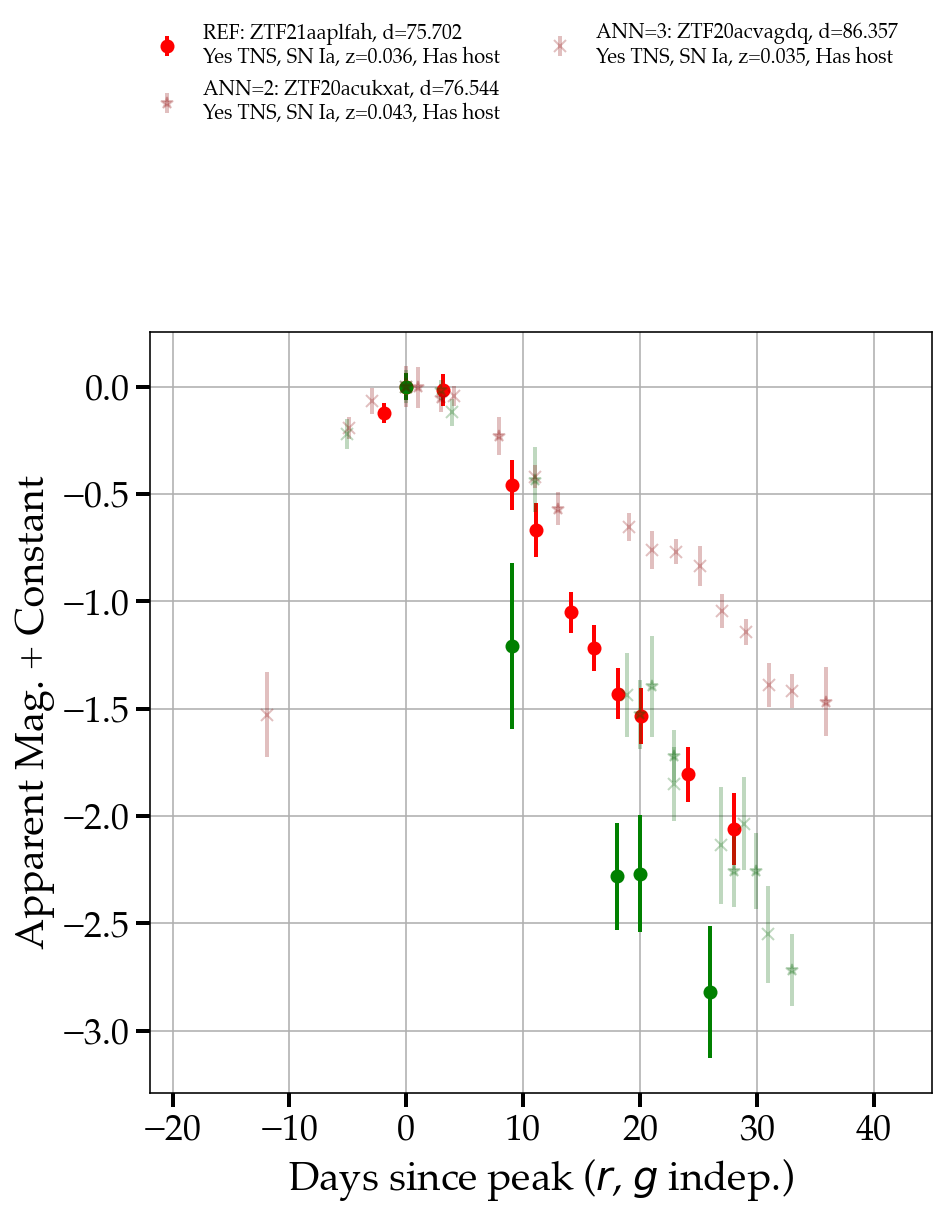

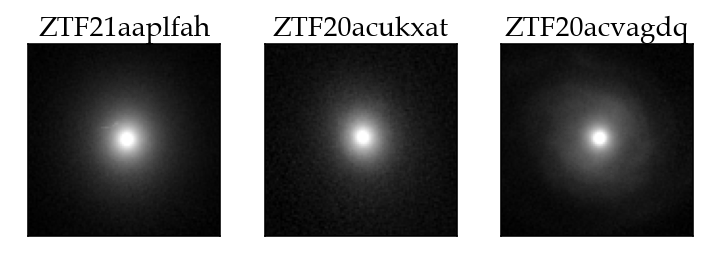

CPU times: user 2.05 s, sys: 147 ms, total: 2.2 s
Wall time: 2.83 s


In [52]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = ztf_id_ref #idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean

if math.isnan(ra_ref) or math.isnan(dec_ref):
    has_host_ref = "No host assoc"
else: has_host_ref = "Has host"    
    
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)},\t{has_host_ref}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    try:
        l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
        df_knn = l_info.timeseries.to_pandas()
    except: continue   
        
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
        
    if math.isnan(ra_i) or math.isnan(dec_i):
        has_host_i = "No host assoc"
    else: has_host_i = "Has host"
        
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r = df_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g = df_g[['ant_mag']].reset_index().idxmin().ant_mag

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[mjd_idx_at_min_mag_r], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)},\t{has_host_i}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[mjd_idx_at_min_mag_g], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    #plt.xlabel('Days of event') # make iloc[0]
    plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
        plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
tns_cls_ref_nospace = tns_cls_ref.replace(' ','')

folder_path = f"../figures/{tns_cls_ref_nospace}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

suffix=suffix
plt.savefig(f'../figures/{tns_cls_ref_nospace}/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_manhattan_90k_{suffix}.jpg', dpi=150, bbox_inches='tight')
#plt.savefig(f'../figures/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_euclidean.jpg', dpi=150, bbox_inches='tight')


host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df, tns_cls_ref=tns_cls_ref_nospace, suffix=suffix, save_pdf=True)

In [53]:
%%time

ann_num = 350

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank_test.index)):
    dataset_ref = dataset_bank_test[dataset_bank_test.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=ann_num, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, ann_num)]
# sum specific columns
ann_dist_all_df[f'Mean-{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))
ann_dist_all_df[f'Max-{len(col_list)}ANNs'] = np.max(ann_dist_all_df[col_list].iloc[:, -1:], axis=1)

# save only last two columns to save room
ann_dist_all_df = ann_dist_all_df.iloc[:, -2:]

# weighted distance of first 9 ANNs
#weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
#ann_dist_all_df[f'WeightedMean-{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df.to_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv')
ann_dist_all_df

CPU times: user 5.91 s, sys: 76.9 ms, total: 5.99 s
Wall time: 5.7 s


Mean-349ANNs  Max-349ANNs
key_0                                  
ZTF17aadqidc     69.569261    72.286911
ZTF18aadlaxo     61.263460    63.032154
ZTF18aahsuyl     54.256972    55.025932
ZTF18aaisqmw     80.241809    83.274605
ZTF18aajgowk     68.042411    73.049698
...                    ...          ...
ZTF21aciuhqw     61.973874    64.100334
ZTF21acjgpvq     98.461240   105.342201
ZTF21acjjyvv     68.149374    71.755630
ZTF21acldmwy     64.713195    68.240829
ZTF21acngnza    112.754942   121.775032

[722 rows x 2 columns]

# NOT SMOTE

In [51]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia


# scalar ONLY, NO PCA
dataset_bank_orig_scaled = pd.DataFrame(feat_arr_scaled, columns=lc_and_host_features)
dataset_bank_orig_scaled = dataset_bank_orig_scaled.set_index(dataset_bank_orig.index)
dataset_bank = dataset_bank_orig_scaled.copy()

# # what i normally use
# # with scalar, then PCA
# dataset_bank = dataset_bank_pca.copy()



# # what i'm testing 
# # with scalar, then SparsePCA
# dataset_bank = dataset_bank_pca.copy()


# for Lc + host features 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aciwhcb'] # Ia
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpdyyq'] # star - weird that it has host info (CHECK INTO THIS)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuyayk'] # RRyl kinda star behavior 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvmlow'] # close SN (many ANNs are HII regions) [cool first match]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvbbvs'] # variable - check host info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20actvmqi'] #SN Ia w/ small ANN=1 dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaxksct'] # SN Ia, z=0.1 w/ small ANN=1 dist (cool example through first few ANN)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwnrty'] # SN Ia-91T-like  #good one!! (Show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpjcoe'] # SN Ia, z=0.04
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadoota'] # IIn, z=0.058
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abywydb'] #II, z=0.04 no apparent host
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwobku'] #2020acct (matches to a couple IIb)
dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabxjqr'] # IIb, z=0.03
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19ackwoak'] # star (check host) (finds other stars)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvlumw'] # central bogus obs in bright gal core (check host) (finds more bogus)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aacoati'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18ablgnri'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagtqna'] # long lived IIP, closeby (finds more IIs) (good)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aamzgzi'] # bogus core obs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abowuqe'] #SN Ia w/ small ANN=1 dist (wow, good matches)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] #SN Ia w/ small ANN=1 dist, z=0.084
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aabyyhr'] # SN Ia w/ missed TNS ANNs and good matches! (show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acitpfz'] # TDE
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aaurfwa'] #IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aatxryt'] # Ia but totally Ia-CSM
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarnjyd'] # Ib
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaqhhfu'] #  Ib

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] # Ia with small dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abeokcr'] # Ia with small dist, spiral gal (Show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acxtdcm'] # II with small dist


#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achupkw'] # SLSN II w/ small dist, at z=0.38 (show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abxbmqh'] # SLSN II w/ small dist, at z=0.2
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acnznms'] # SLSN II w/ small dist, at z=0.2 blue (show G)

#
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acrjydf'] #CV/nova in M31 (check host in GHOST) [finds nova!]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acplkub']  # Nova
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acgigfo']  # Nova
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acfucwr']  # Nova

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abjciua'] # Other 2021seu

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax  (good one!) 2020sck
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abbyhvw']  # Iax 2021mry
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aavotzn'] # Iax 2021jun
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagqdvr'] # Iax 2021bfg with only declining light curve (show G)

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadghpt'] #mostly blue obs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abdllvi'] # rising only, no visible host

#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] # Ia w/ low ANN=1 dist (GOOD EXAMPLE!)!!!!!!!

# TDEs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF17aaazdba'] # no lc info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abxftqm'] # ANN=1 is TDE (ATeL/lit) https://alerce.online/object/ZTF20abnorit https://ztf.snad.space/dr13/view/623312100004615
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acaqdaa'] 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acitpfz']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acqoiyt']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acyydkh']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaaokyp'] # ANN=1 ^ (ATeL/lit) and so is ANN=2 (ATeL/lit): https://alerce.online/object/ZTF20abowque
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabiipy']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aapvvtb'] # ANN=3 might be missed TDE https://alerce.online/object/ZTF21aazenvp https://ztf.snad.space/dr13/view/1724216200034193

# Icn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aakilyd']

# Ia-CSM
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abbbsfs']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abmlxrx'] #ANN=2 is missed SN Ia-CSM https://alerce.online/object/ZTF20abivilh # ANN=6 (https://alerce.online/object/ZTF18aceykdd) is maybe SLSN (https://ztf.snad.space/dr13/view/1713201300001031)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx']

# 2018lzi PISN?
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aautopz'] #ANN=1 is 2020hip- submitted to TNS, but missed SLSN! #https://alerce.online/object/ZTF18abxbmqh https://ztf.snad.space/dr13/view/754206300019295

# SLSN-I
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acilzkh'] # ANN=5 is missed SLSN https://alerce.online/object/ZTF21aagdrdu, so is ANN=7 https://alerce.online/object/ZTF21aalhtgv
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaarmti']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abaiono']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abcpsjy']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abezyhr']

# weird double bump
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF22abnvurz'] #2022xxf
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abcjpnm'] #2021njo II

# nuclear Ia-TDE candidates from Gomez at al 2023 https://arxiv.org/pdf/2302.14070.pdf (if in dataset)
# Ia-TDE candidates (SN 2019uqp, SN 2020lrt, SN 2020bpf, SN 2021jun) and two unclassi- fied ones (AT 2021hsd, AT 2020djm).
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19acrwvao'] # SN 2019uqp # Not in dataset
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abdxyae'] # SN 2020lrt # Not in dataset
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aalcyih'] # SN 2020bpf # Not in dataset
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aavotzn'] # SN 2021jun
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarjicd'] # AT 2021hsd # possible Ia-TDE? 2020zha: https://alerce.online/object/ZTF20acpxvrj #2021uhr: https://alerce.online/object/ZTF21abpjrqx
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aaqdkds'] # AT 2020djm


# OFF-nuclear Ia-TDE candidates from Gomez et al 2023
# 2020sck, 2022lce, 2020xmo, 2021xpf
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # 2020sck
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF22aaljyqw'] # 2022lce # Not in dataset
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aclfjgy'] # 2020xmo
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abxdlyk'] # 2021xpf # Not in dataset

# SLSN-I
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acilzkh']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaarmti']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abaiono']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abcpsjy']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abezyhr']

# SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abxbmqh']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aaurzyt']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achupkw']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aclnqle']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acnznms']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aanefkx']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaokvio']

# IIb
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwzqzo'] 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acgiglu']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acjpvyd']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acusecr']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwqqjs']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaabwfu']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabxjqr']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aalimya']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aanrhag']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarasky']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaxxmvs']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aayfnjz']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abfjlxb']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abmxkcq']
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abotose']


# NOTE: all stars are misassociations


# for host features only
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia no host assoc (GREAT EXAMPLE!)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, no host assoc
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II no host assoc
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn no host assoc
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), no host assoc
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf

dataset_ref 

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aabxjqr                  -1.865978   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aabxjqr                                -0.977638   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aabxjqr                      0.153572                    -1.686755   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aabxjqr             -12.344599                                -1.822423   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aabxjqr                                  -1.246022   

               feature_inter_percentile_range_25_magn_r  \
ztf_object_id                                             
ZTF21aabxjqr                                  -1.174182   

               feature_kurtosis_magn_r  feature_linear_fit_slope_magn_r  ...  \
ztf_object_id                                                            ...   
ZTF21aabxjqr                  -1.24064                         0.389942  ...   

                 yKronRad  yExtNSigma         i-z  gApMag_gKronMag  \
ztf_object_id                                                        
ZTF21aabxjqr   312.851896   87.839282 -213.739419       340.285006   

               rApMag_rKronMag  iApMag_iKronMag  zApMag_zKronMag  \
ztf_object_id                                                      
ZTF21aabxjqr        276.976094       254.965056       287.987293   

               yApMag_yKronMag       7DCD  dist/DLR  
ztf_object_id                                        
ZTF21aabxjqr        295.310559  21.720496 -9.464982  

[1 rows x 120 columns]

In [52]:
dataset_ref

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aabxjqr                  -1.865978   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aabxjqr                                -0.977638   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aabxjqr                      0.153572                    -1.686755   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aabxjqr             -12.344599                                -1.822423   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aabxjqr                                  -1.246022   

               feature_inter_percentile_range_25_magn_r  \
ztf_object_id                                             
ZTF21aabxjqr                                  -1.174182   

               feature_kurtosis_magn_r  feature_linear_fit_slope_magn_r  ...  \
ztf_object_id                                                            ...   
ZTF21aabxjqr                  -1.24064                         0.389942  ...   

                 yKronRad  yExtNSigma         i-z  gApMag_gKronMag  \
ztf_object_id                                                        
ZTF21aabxjqr   312.851896   87.839282 -213.739419       340.285006   

               rApMag_rKronMag  iApMag_iKronMag  zApMag_zKronMag  \
ztf_object_id                                                      
ZTF21aabxjqr        276.976094       254.965056       287.987293   

               yApMag_yKronMag       7DCD  dist/DLR  
ztf_object_id                                        
ZTF21aabxjqr        295.310559  21.720496 -9.464982  

[1 rows x 120 columns]

In [53]:
%%time

# scaler ONLY, NO PCA
scaled_feat_arr_ref = np.array(dataset_ref) 

# # what I normally use
# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = f'https://alerce.online/object/{ztf_id}'
print(link_ref)
print("%%%%%%")
#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # tns
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean

    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z

    if math.isnan(ra_i) or math.isnan(dec_i):
        print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
    else: print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")
        
#     except:
#         has_tns_i = "No host assoc"
#         tns_cls_i = "XXX"
#         spec_z_i = -99
        
#         print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
    

ZTF ID name (ref) ZTF21aabxjqr
https://alerce.online/object/ZTF21aabxjqr
%%%%%%
ANN=0	https://alerce.online/object/ZTF21aabxjqr		Yes_TNS		SN IIb		z=0.03317803			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=146.19611212+51.68871112&filter=color



KeyError: 'ZTFabc13156'

# DO NOT RUN CELL BELOW IF USED SMOTE

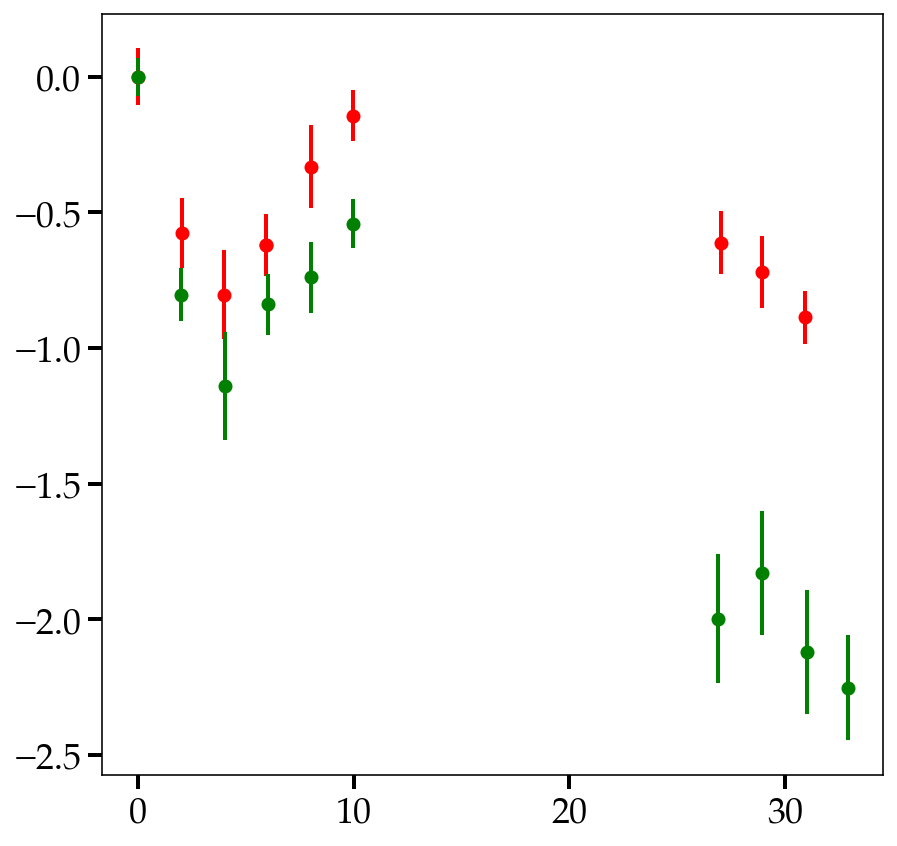

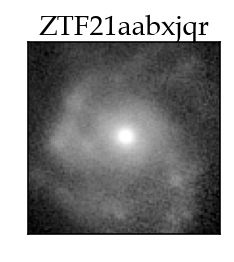

CPU times: user 877 ms, sys: 88.2 ms, total: 965 ms
Wall time: 1.69 s


In [54]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean

if math.isnan(ra_ref) or math.isnan(dec_ref):
    has_host_ref = "No host assoc"
else: has_host_ref = "Has host"    
    
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)},\t{has_host_ref}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue   
        
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
        
    if math.isnan(ra_i) or math.isnan(dec_i):
        has_host_i = "No host assoc"
    else: has_host_i = "Has host"
        
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r = df_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g = df_g[['ant_mag']].reset_index().idxmin().ant_mag

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[mjd_idx_at_min_mag_r], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)},\t{has_host_i}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[mjd_idx_at_min_mag_g], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    #plt.xlabel('Days of event') # make iloc[0]
    plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
        plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
tns_cls_ref_nospace = tns_cls_ref.replace(' ','')

folder_path = f"../figures/{tns_cls_ref_nospace}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

suffix=suffix
plt.savefig(f'../figures/{tns_cls_ref_nospace}/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_manhattan_90k_{suffix}.jpg', dpi=150, bbox_inches='tight')
#plt.savefig(f'../figures/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_euclidean.jpg', dpi=150, bbox_inches='tight')


host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df, tns_cls_ref=tns_cls_ref_nospace, suffix=suffix, save_pdf=True)

# TODO: maybe penalize / make it less likely to match to those without host gal associations? OR, only allow host gal matches if it has a TNS report? Or at least favor that over no host gal match and no tns report (missing disc but flooded with stars, bogus...

%%time

# UNCOMMENT IF YOU WANT TO RUN
# Up to 5 of each tns class
for cls in np.unique(dataset_bank_tns_df.tns_cls):
    dataset_bank_tns_cls_df = dataset_bank_tns_df[dataset_bank_tns_df.tns_cls == cls]
    #print(dataset_bank_tns_cls_df.head(5).index)
    for ztfid in list(dataset_bank_tns_cls_df.head(5).index):
        print(f"####### {ztfid}, {cls} ######\n")
        dataset_ref = dataset_bank[dataset_bank.index == ztfid]
        
        # scaler ONLY, NO PCA
        scaled_feat_arr_ref = np.array(dataset_ref) 

        # # what I normally use
        # # Scalar then PCA
        # scaled_feat_arr_ref = np.array(dataset_ref)

        # # PCA only
        # feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
        # scaled_feat_arr_ref = feat_arr_ref

        # #PCA then scaler
        # feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
        # scaled_feat_arr_ref = feat_arr_ref
        try:
            ztf_id = dataset_ref.index.values[0]
        except: 
            print("Not in dataset_bank. Continue!")
            continue 
        lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
        #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

        #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
        result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
        #result_name = index.query(lcdata['vector'])

        print(f"ZTF ID name (ref) {ztf_id}") 
        link_ref = f'https://alerce.online/object/{ztf_id}'
        print(link_ref)
        print("%%%%%%")
        #print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
        for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
            # tns
            # host ra,dec
            ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
            dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean

            has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
            tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
            spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z

            if math.isnan(ra_i) or math.isnan(dec_i):
                print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
            else: print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")


        host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

        ztf_id_ref = idx_arr[result_id[0]]
        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
        try:
            df_ref = ref_info.timeseries.to_pandas()
        except: 
            print("No timeseries data...continue!")
            continue

        has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
        tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
        spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

        ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
        dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean

        if math.isnan(ra_ref) or math.isnan(dec_ref):
            has_host_ref = "No host assoc"
        else: has_host_ref = "Has host"    

        host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)

        fig, ax = plt.subplots(figsize=(7,7))
        #plt.gca().invert_yaxis()

        df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
        df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

        ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)},\t{has_host_ref}')
        ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

        markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
        consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

        ztf_id_l = result_id[1:9]
        ztf_dist_l = result_dist[1:9]

        for num, loc in enumerate(ztf_id_l):
            ztf_id_ann = idx_arr[ztf_id_l[num]]

            l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
            try:
                df_knn = l_info.timeseries.to_pandas()
               

                has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
                tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
                spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

                ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
                dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean

                if math.isnan(ra_i) or math.isnan(dec_i):
                    has_host_i = "No host assoc"
                else: has_host_i = "Has host"

                host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

                df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
                df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

                mjd_idx_at_min_mag_r = df_r[['ant_mag']].reset_index().idxmin().ant_mag
                mjd_idx_at_min_mag_g = df_g[['ant_mag']].reset_index().idxmin().ant_mag

                ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[mjd_idx_at_min_mag_r], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                            fmt=markers[num], c='darkred', alpha=0.25, 
                            label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)},\t{has_host_i}')
                ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[mjd_idx_at_min_mag_g], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                            fmt=markers[num], c='darkgreen', alpha=0.25)
                #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

                plt.ylabel('Apparent Mag. + Constant')
                #plt.xlabel('Days of event') # make iloc[0]
                plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
                if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
                    plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                             df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
                else: 
                    plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                             df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
                plt.legend(frameon=False,
                           bbox_to_anchor=(0.98,1.43),
                           ncol=2,
                           prop={'size': 10})

                plt.grid(True)
            
            except: print("Something went wrong! Continue...")

        tns_cls_ref_nospace = tns_cls_ref.replace(' ','').replace('/','')

        folder_path = f"../figures/{tns_cls_ref_nospace}"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        suffix=suffix
        plt.savefig(f'../figures/{tns_cls_ref_nospace}/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_manhattan_90k_{suffix}.jpg', dpi=150, bbox_inches='tight')
        #plt.savefig(f'../figures/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_euclidean.jpg', dpi=150, bbox_inches='tight')


        host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

        host_pdfs(df=host_5ann_df, tns_cls_ref=tns_cls_ref_nospace, suffix=suffix, save_pdf=True)



In [55]:
# Missed Ia https://alerce.online/object/ZTF18abuioue
# Missed Ia https://alerce.online/object/ZTF18abrzuqw (from ref https://alerce.online/object/ZTF18abssdpi)
# Missed Ia https://alerce.online/object/ZTF18absbspk (from ref https://alerce.online/object/ZTF20acgmflv)
# Missed Ia https://alerce.online/object/ZTF18acvvsaq (from ref https://alerce.online/object/ZTF20acgmflv)
# MIssed SN https://alerce.online/object/ZTF18aazydub from ref https://alerce.online/object/ZTF21abdxhgv
# Missed SN https://alerce.online/object/ZTF20acllkua from ref https://alerce.online/object/ZTF21aagyidr
# Missed SN https://alerce.online/object/ZTF20acotzgs from ref https://alerce.online/object/ZTF21aagyidr
# Missed SN https://alerce.online/object/ZTF18acctsvr from ref https://alerce.online/object/ZTF18acbwazl
# Missed SN https://alerce.online/object/ZTF21aagyxdi from ref https://alerce.online/object/ZTF18acbwazl
# MIssed SN https://alerce.online/object/ZTF18abtjrtj from ref
# Missed SN https://alerce.online/object/ZTF20acmqaoo from ref https://alerce.online/object/ZTF18acbufud

# TODO: Find ANNs per TNS class dist - do more rare classes scale with higher dist?

# TODO: color by tns_cls, see if rare SN have certain features to demarcate and then weight more heavily

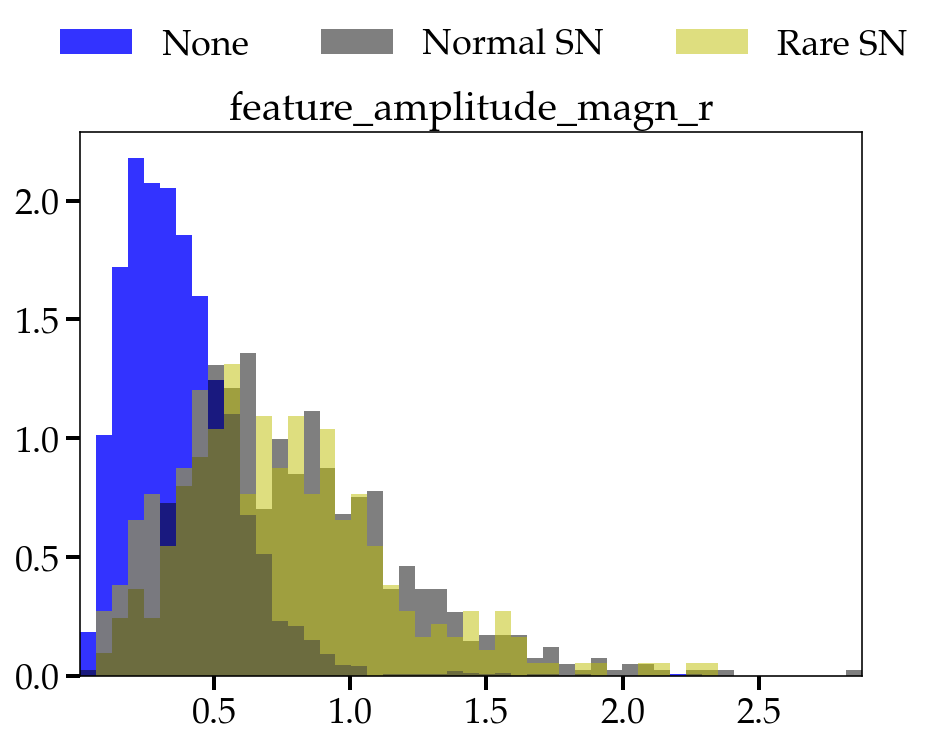

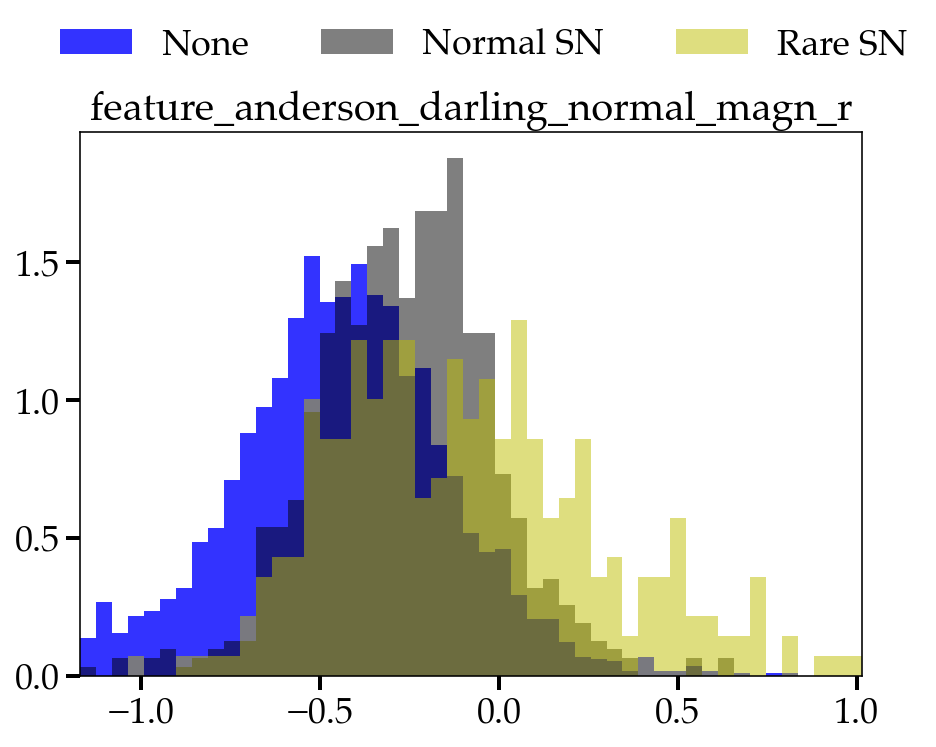

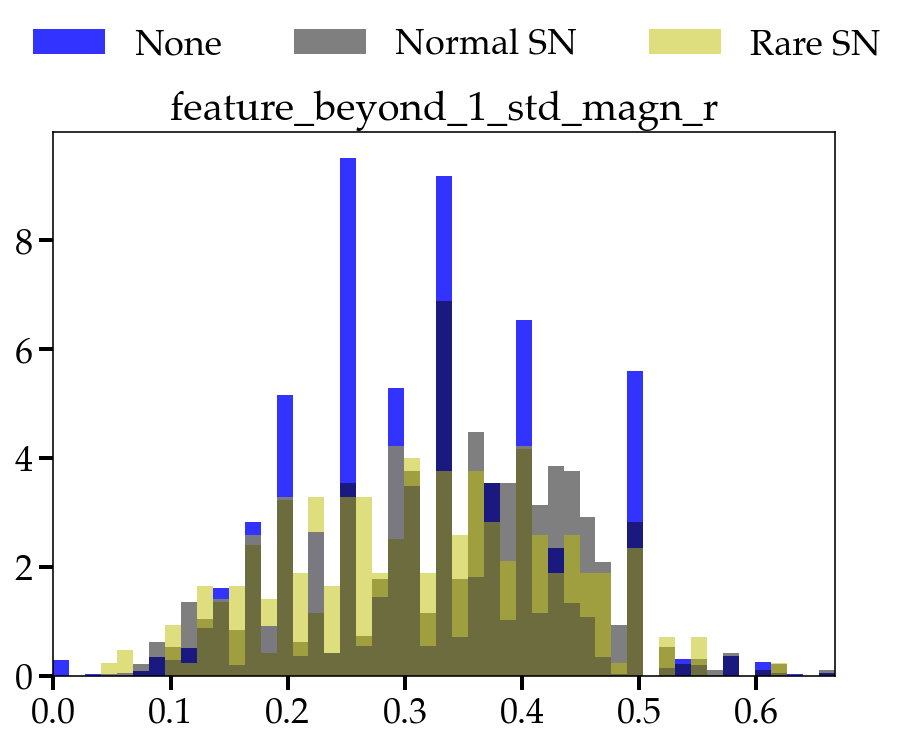

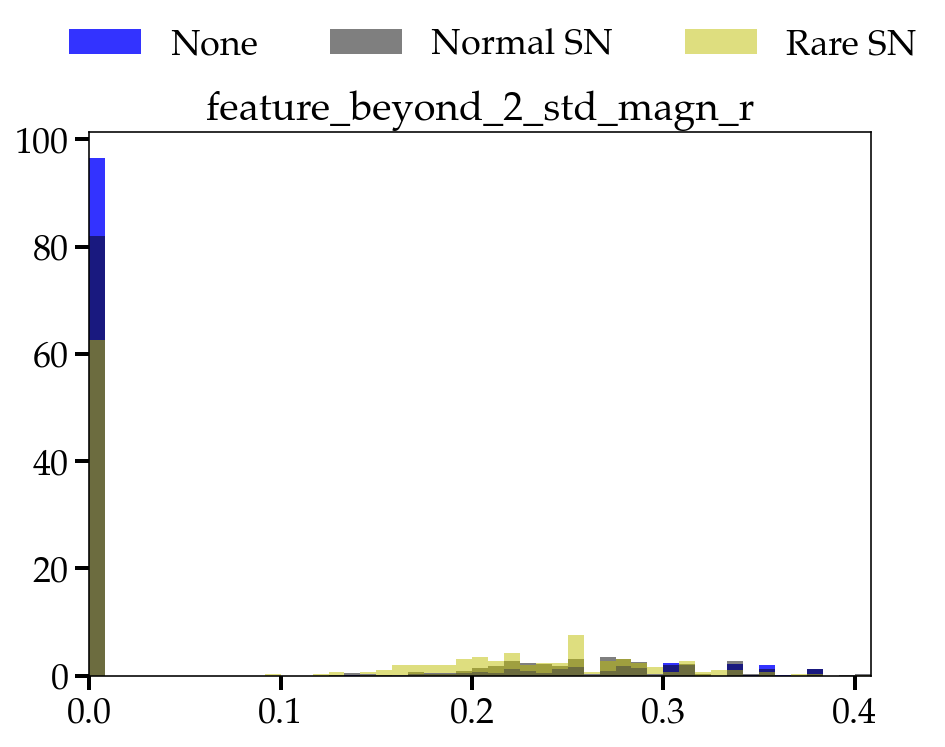

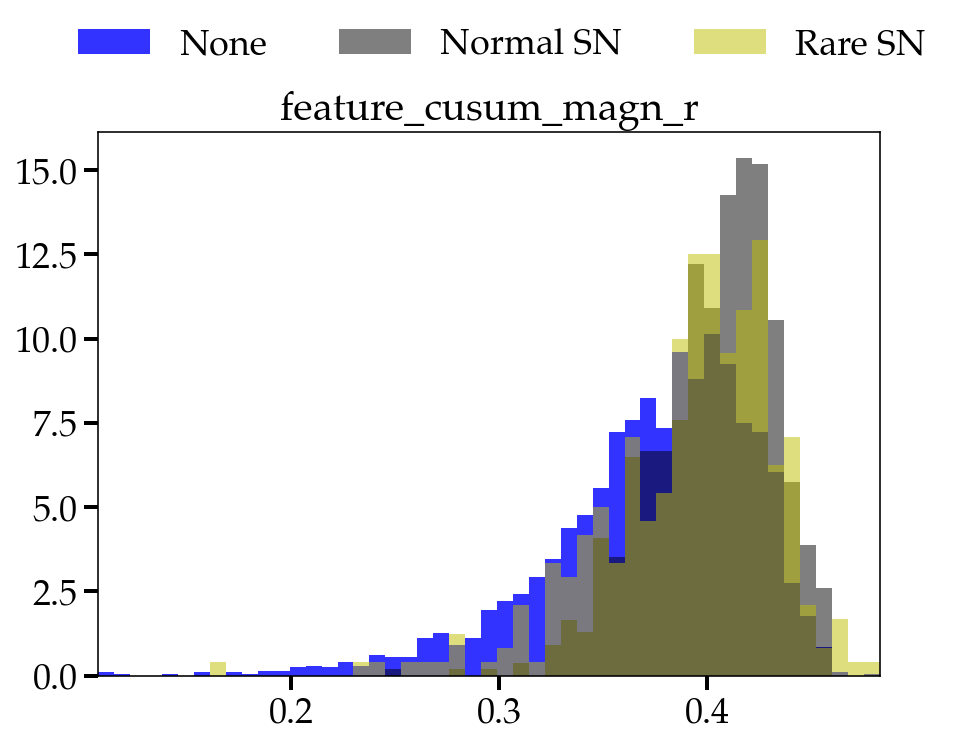

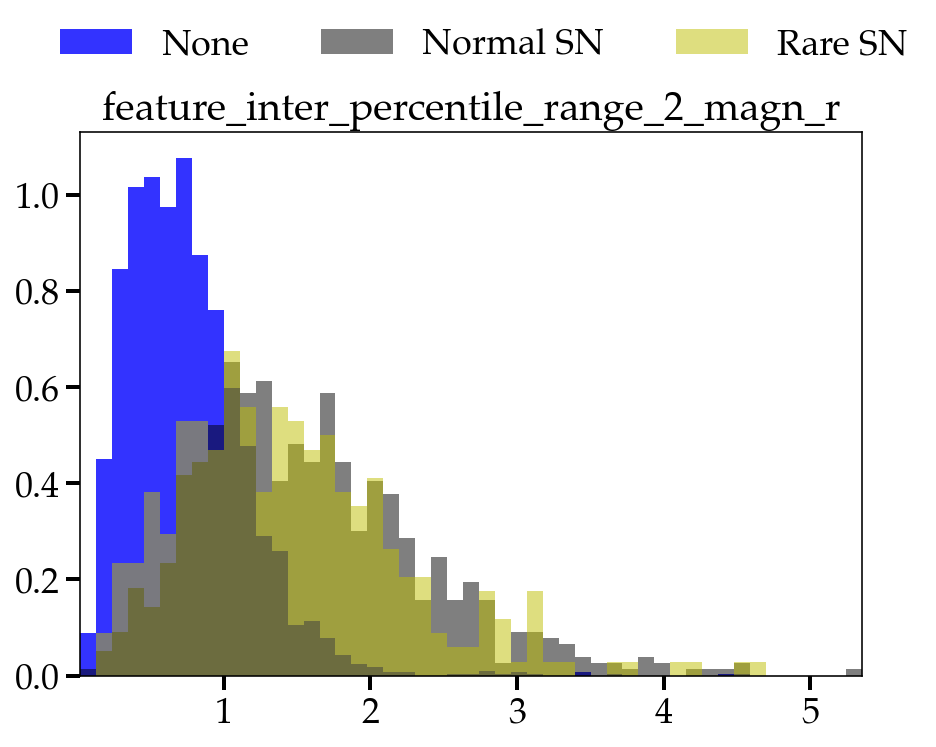

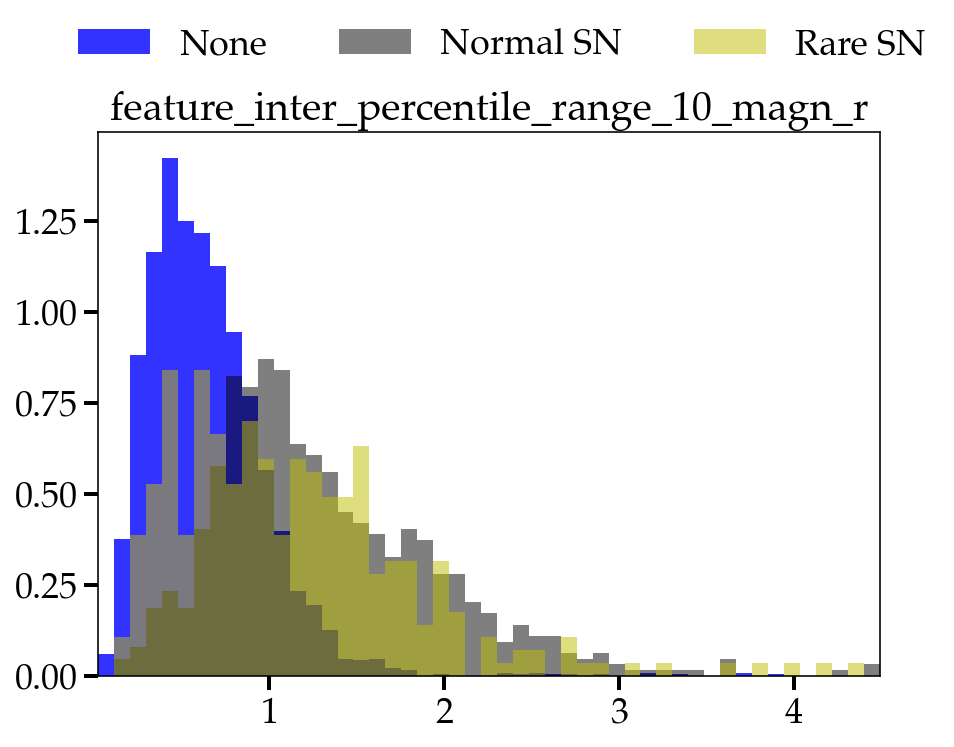

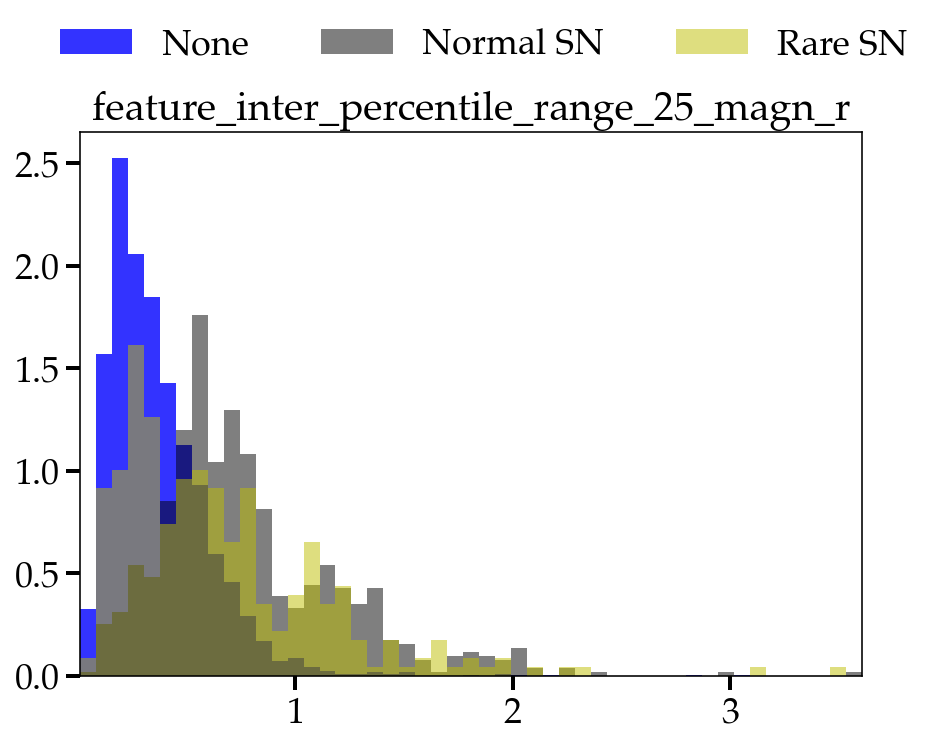

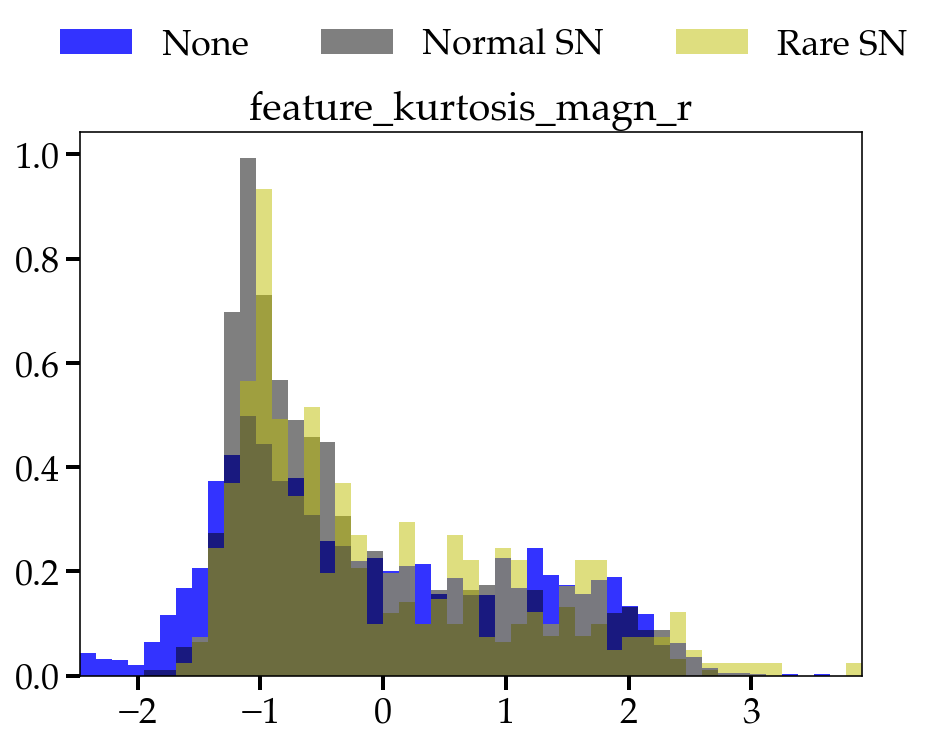

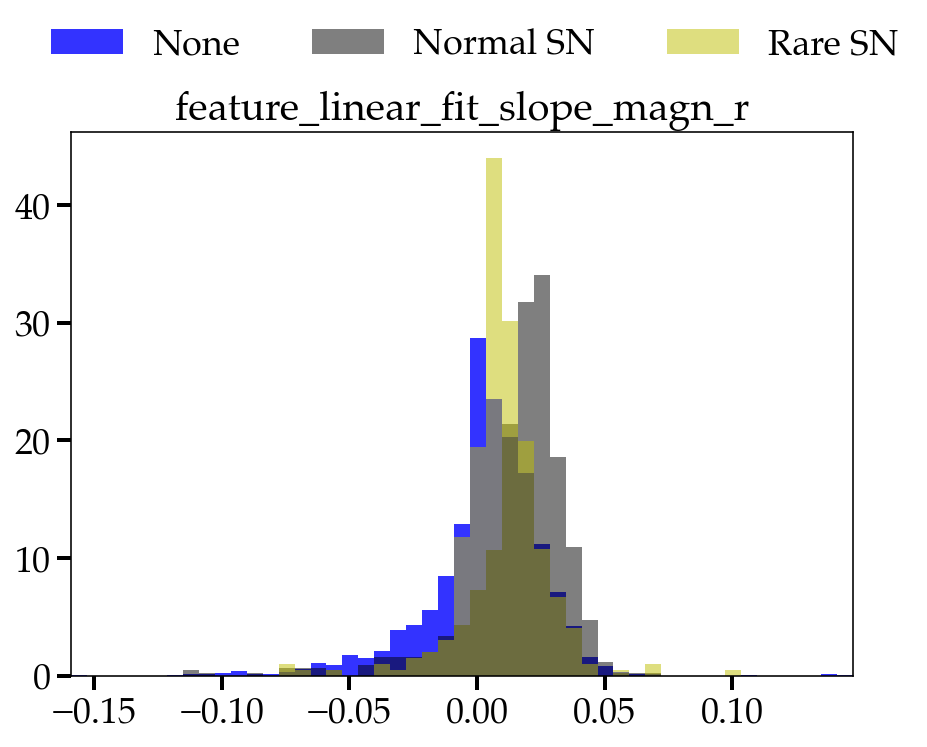

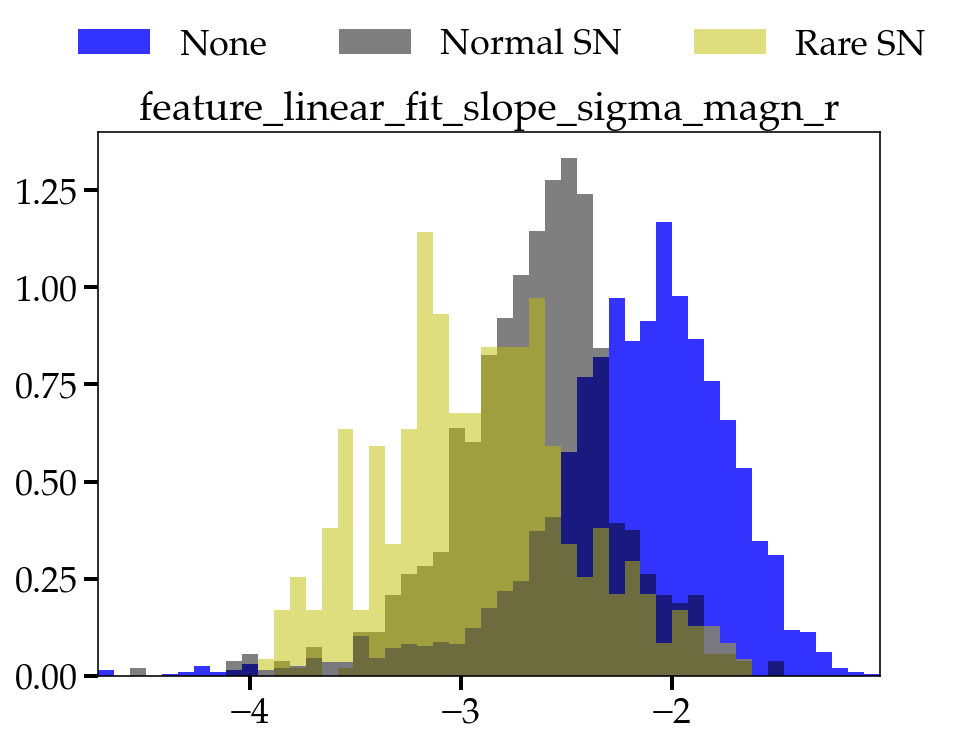

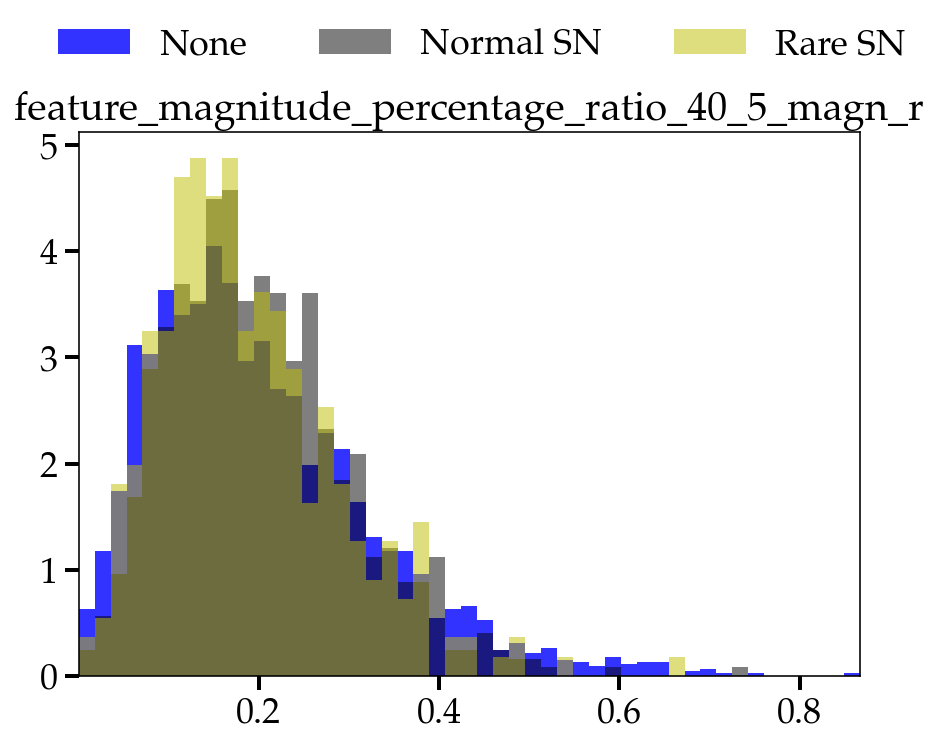

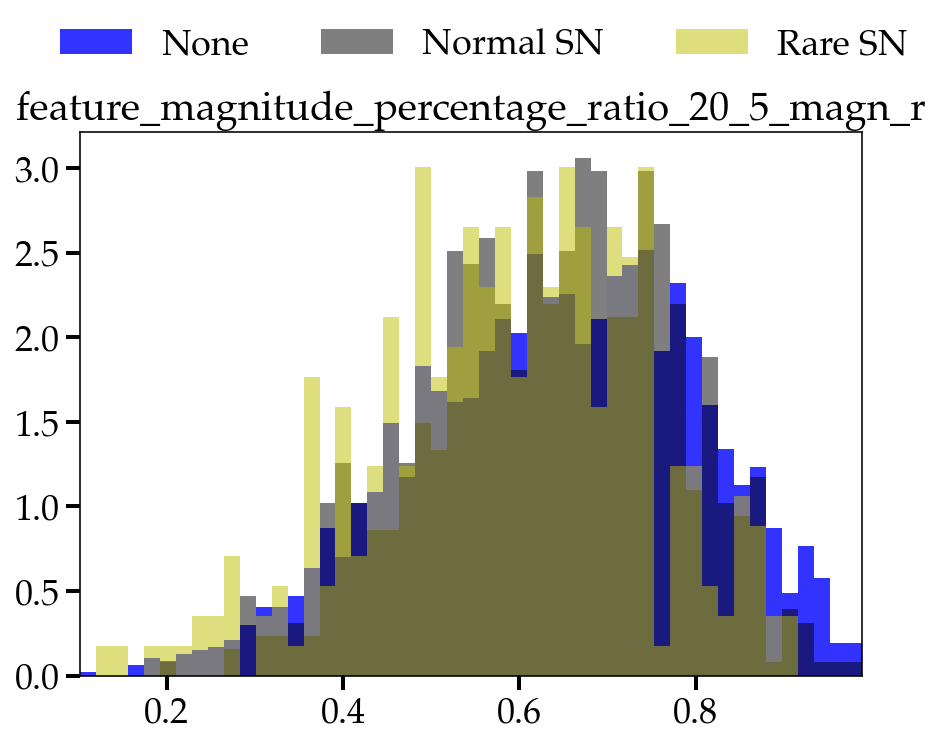

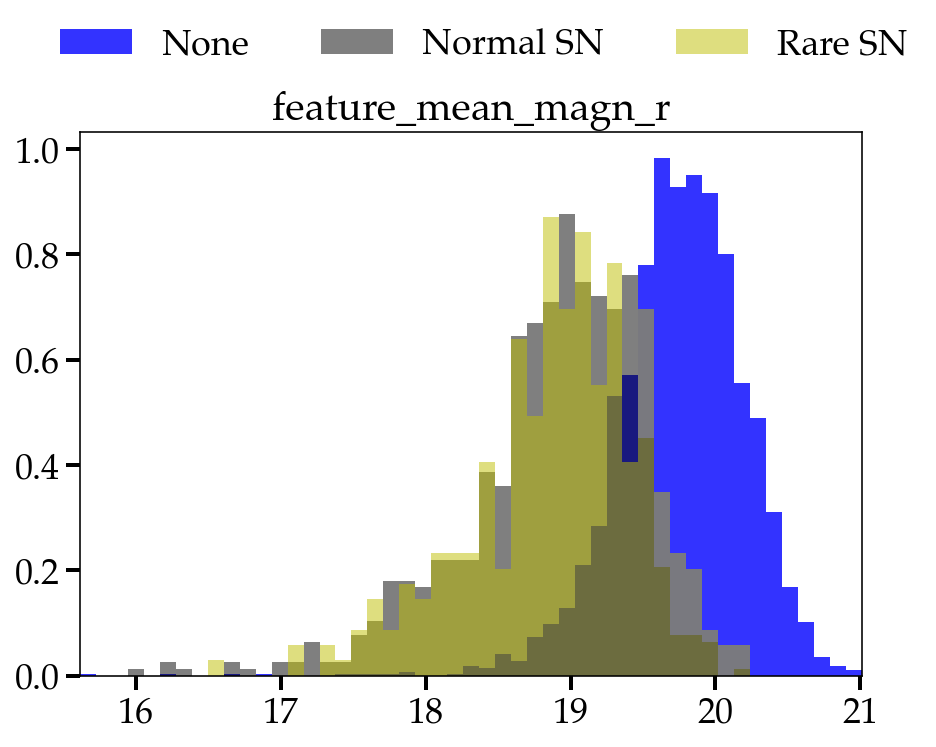

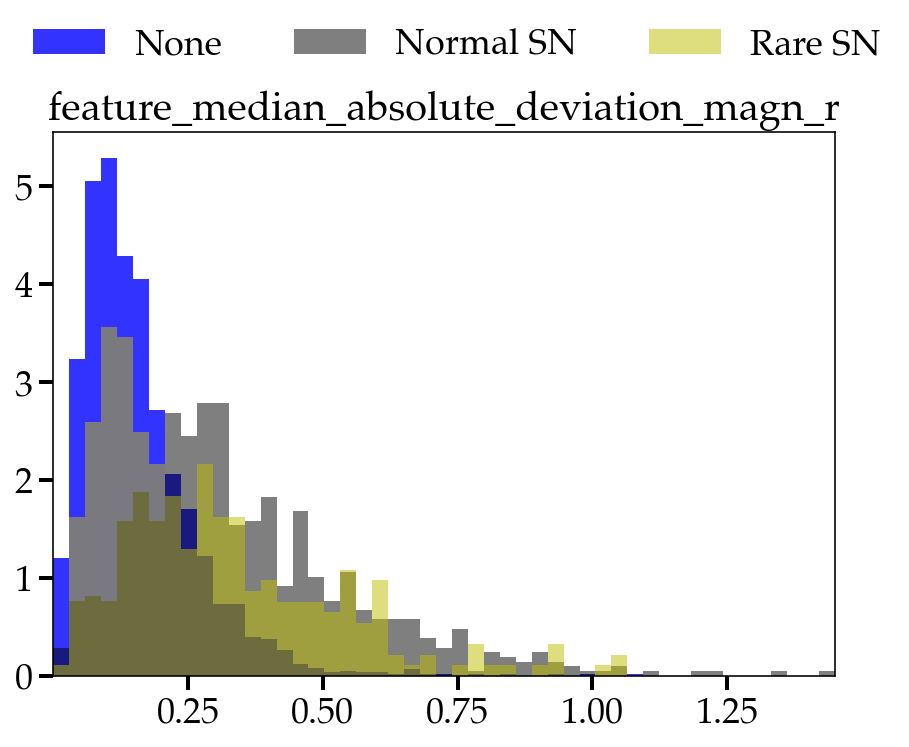

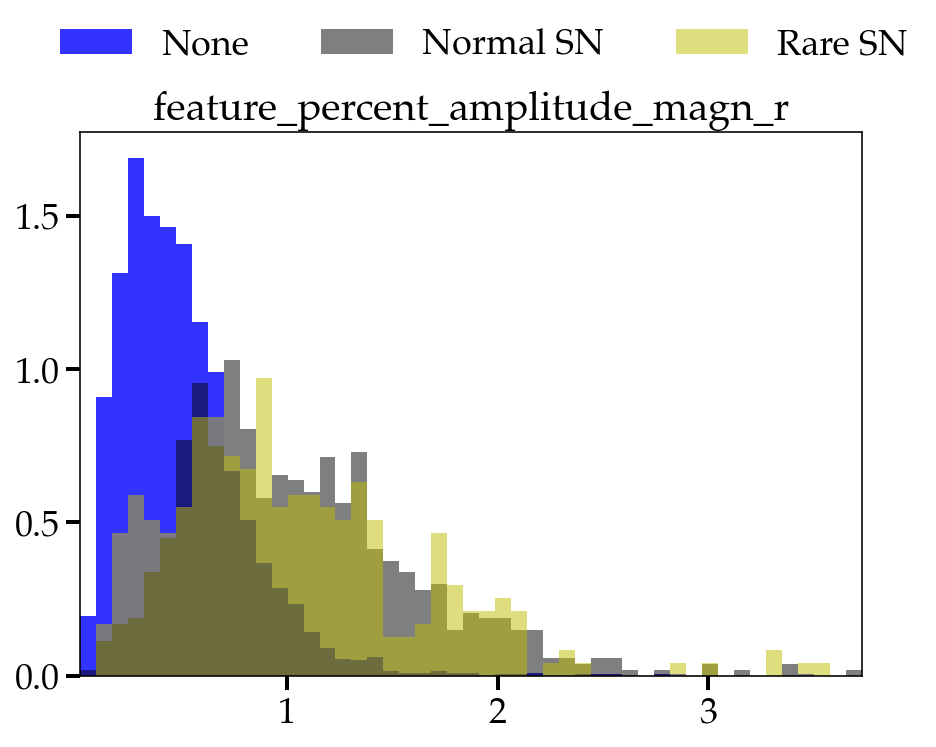

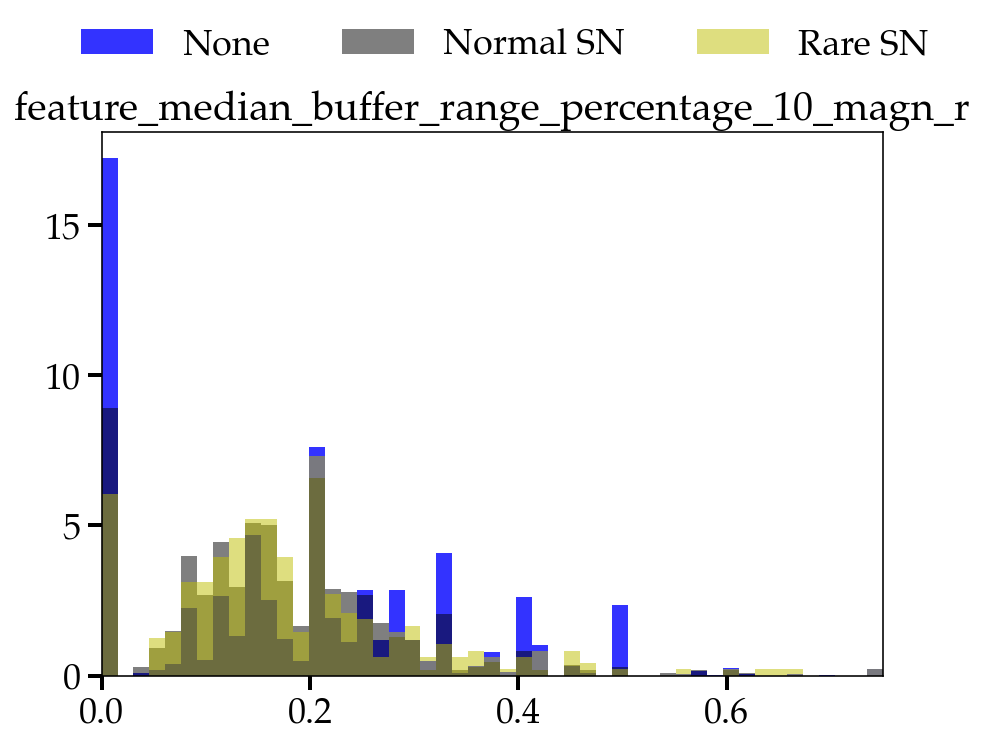

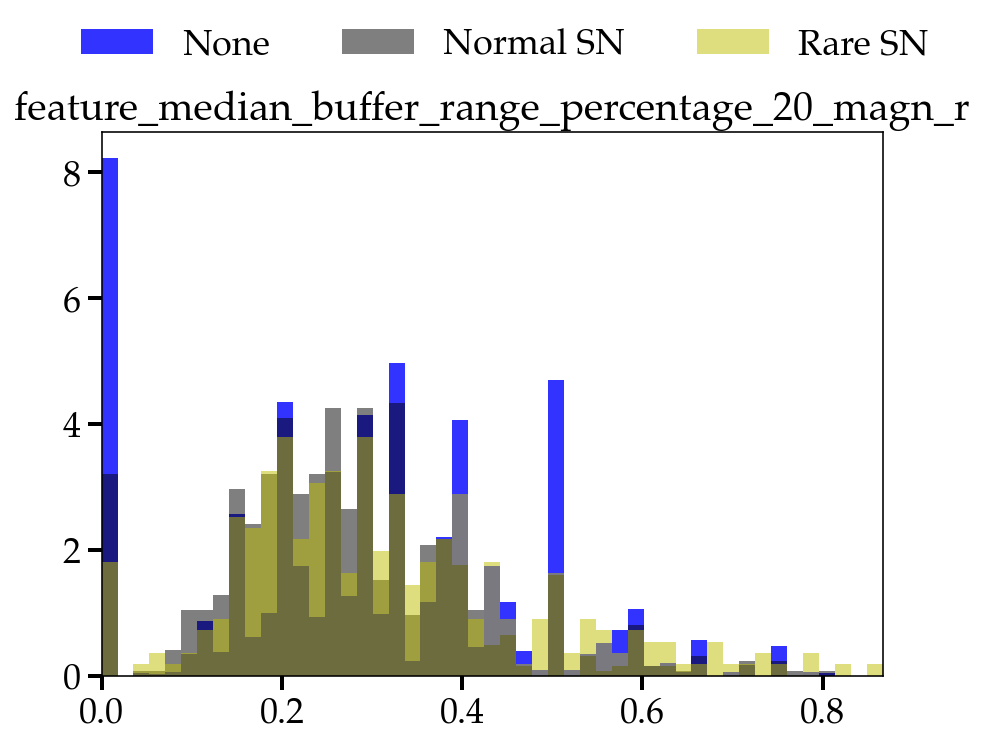

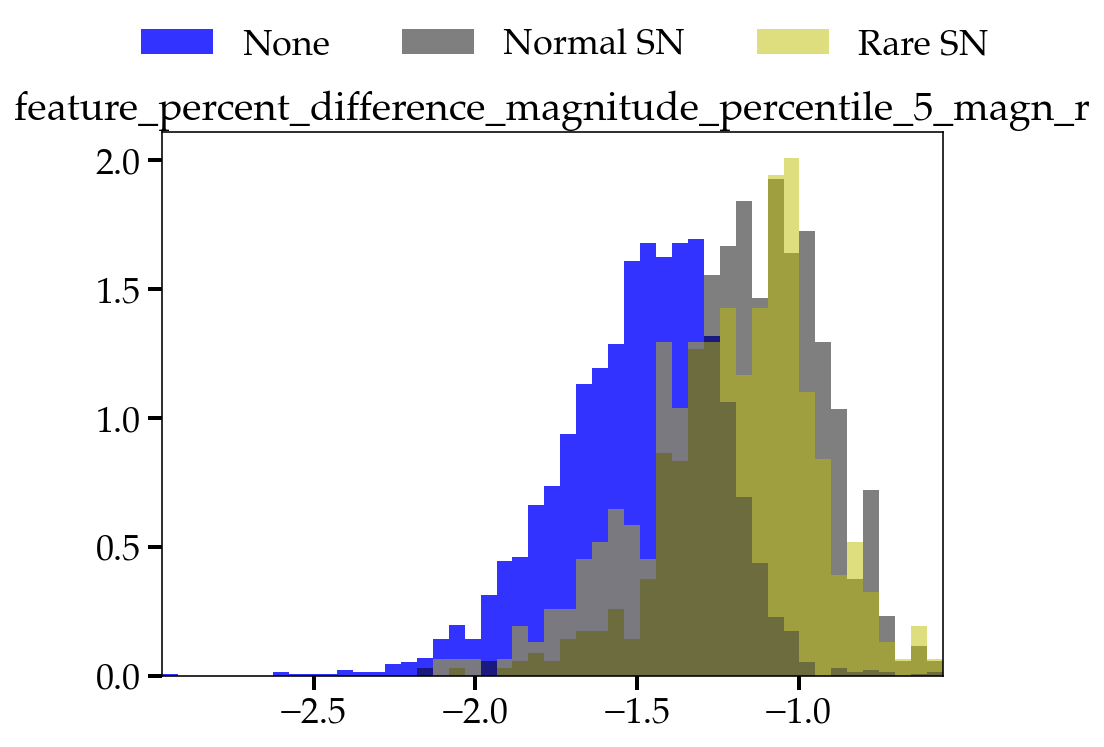

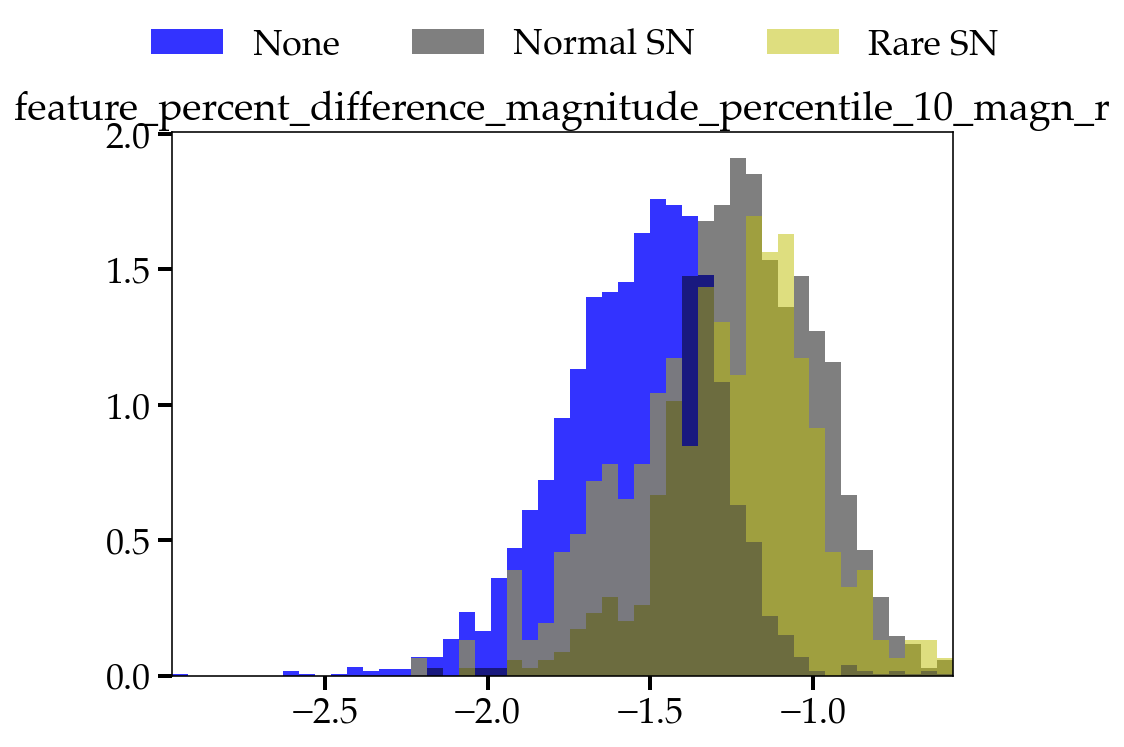

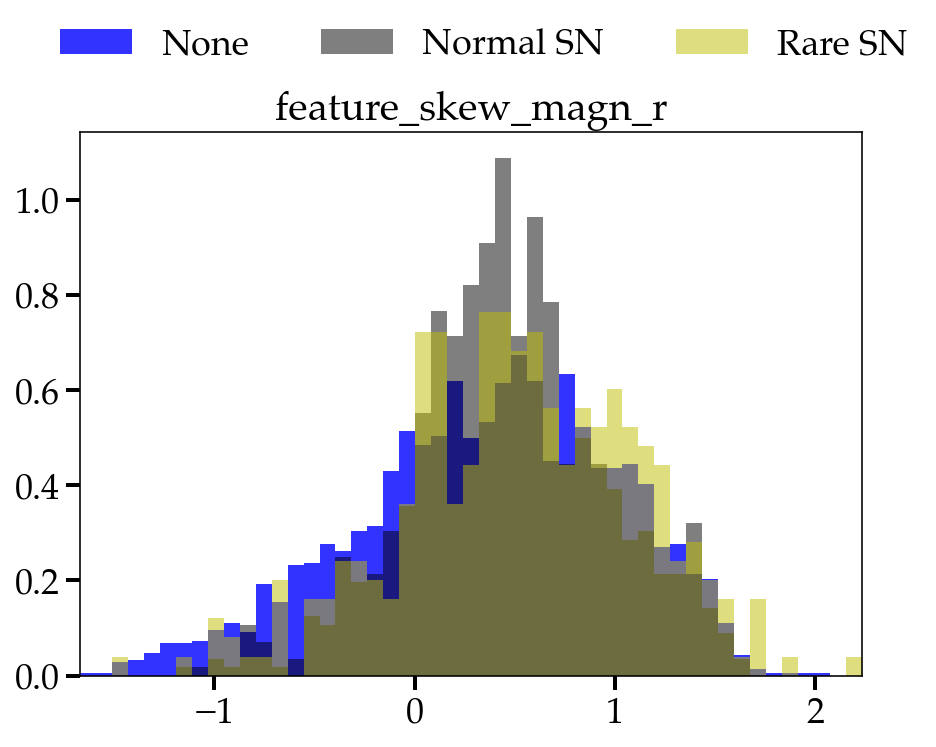

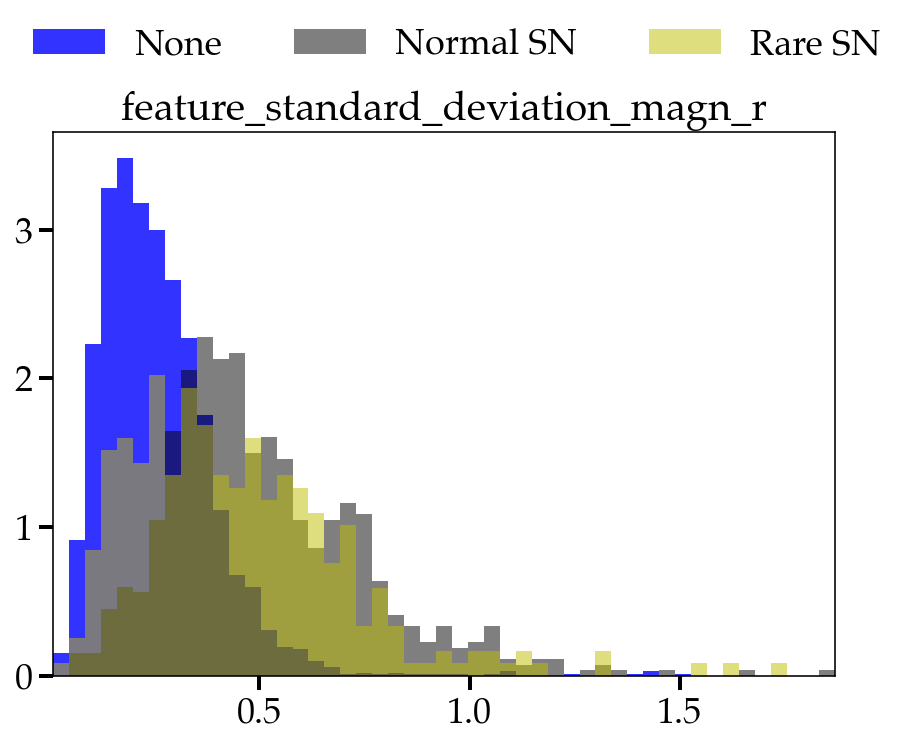

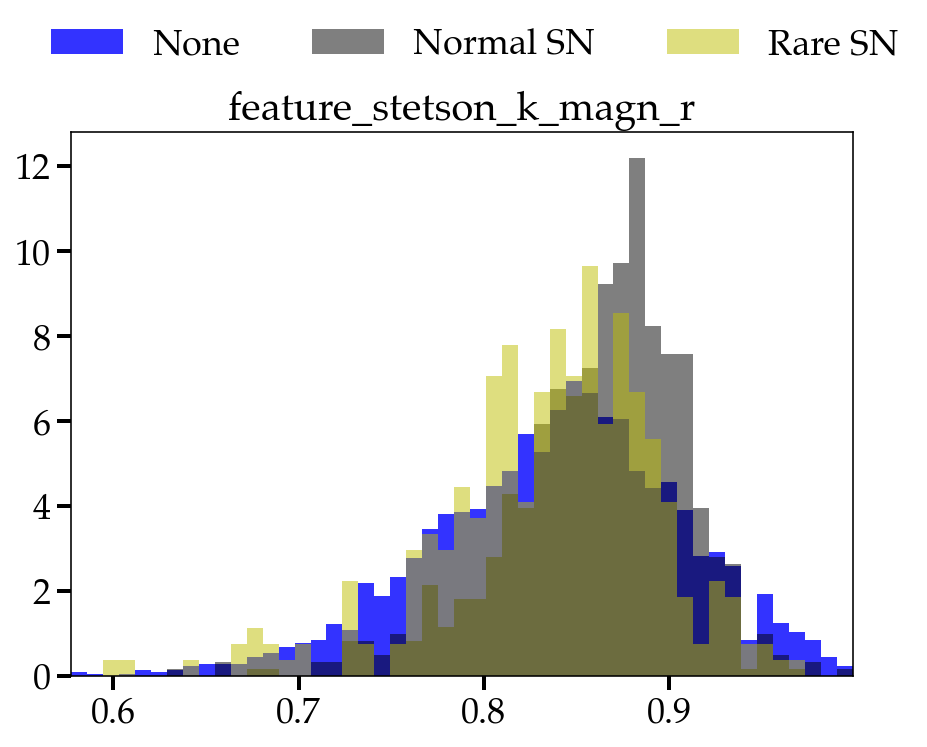

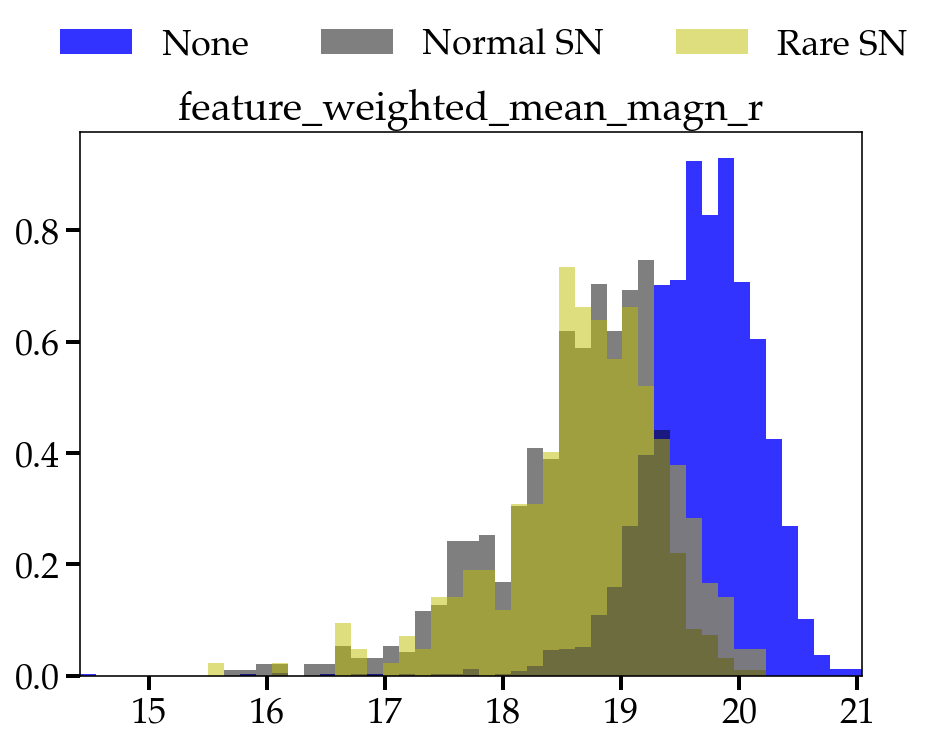

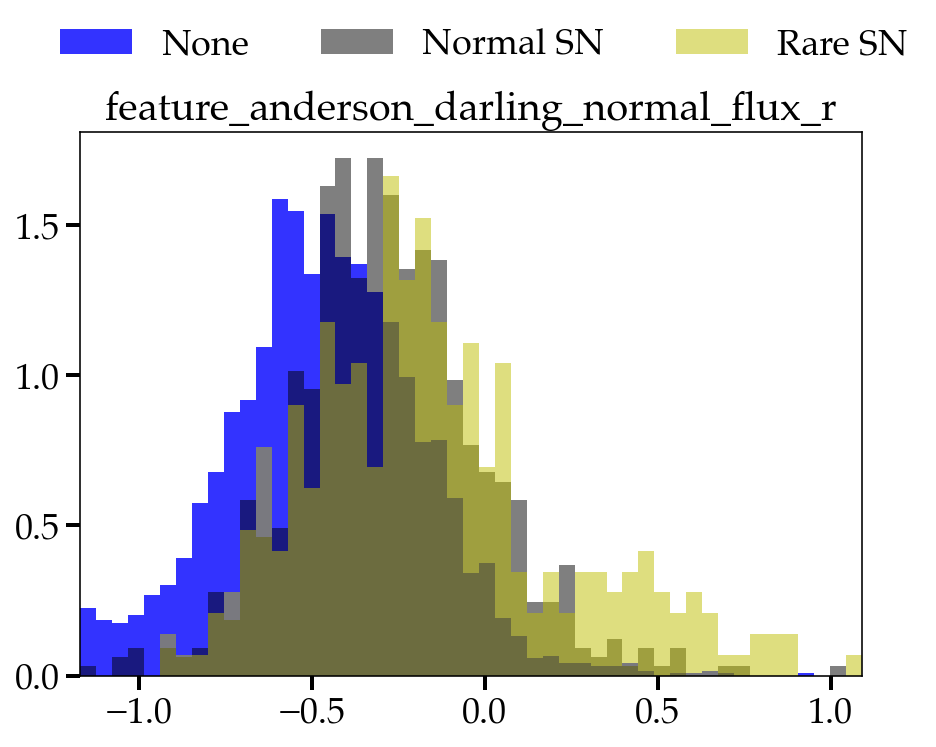

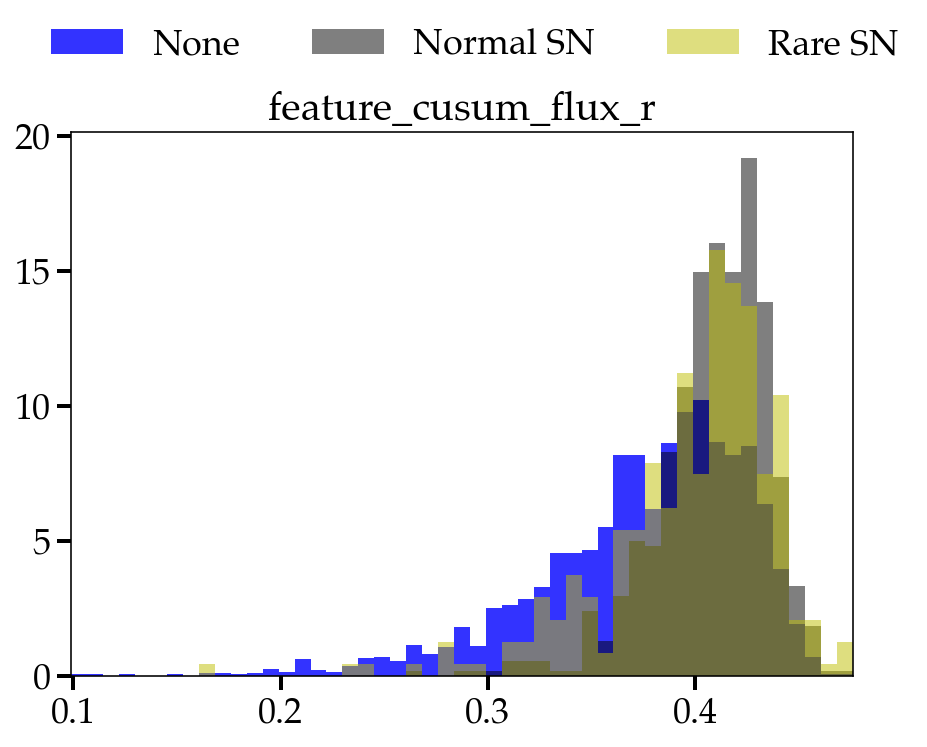

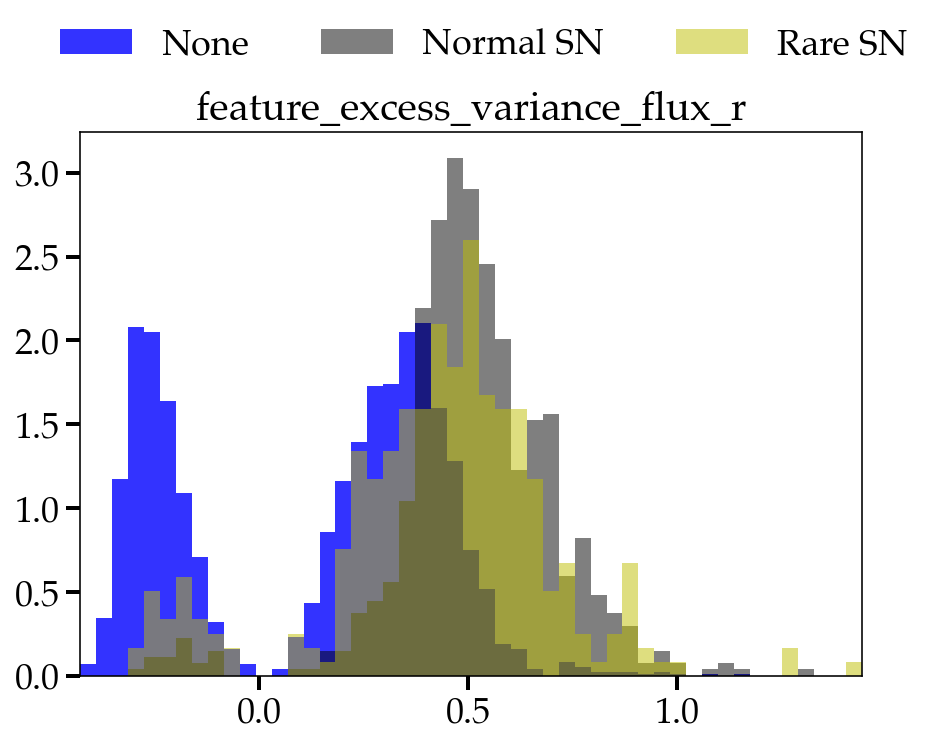

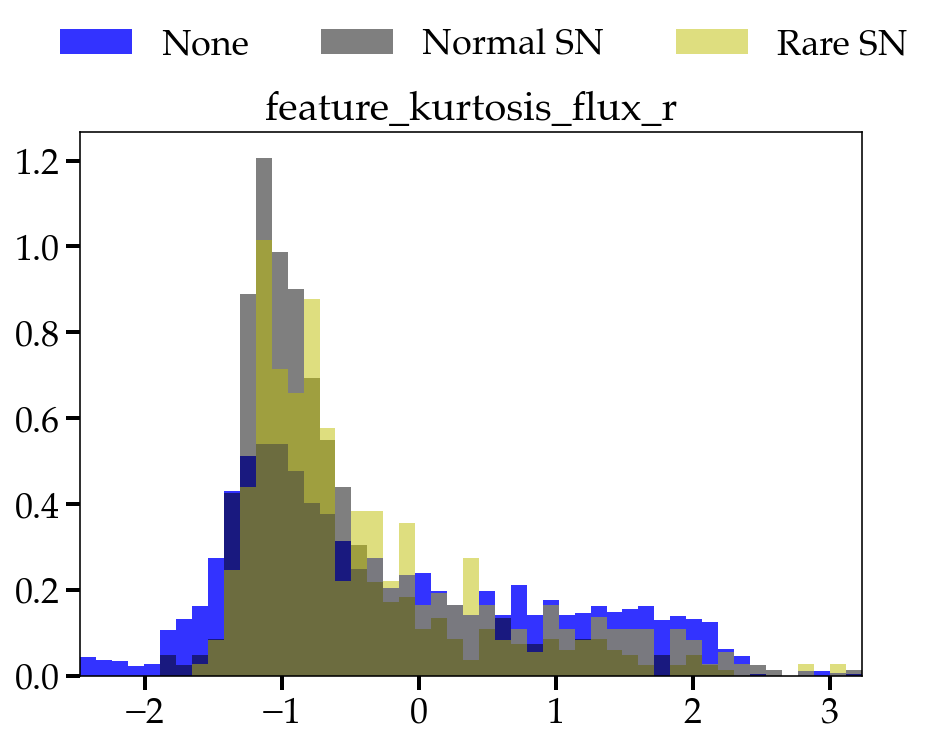

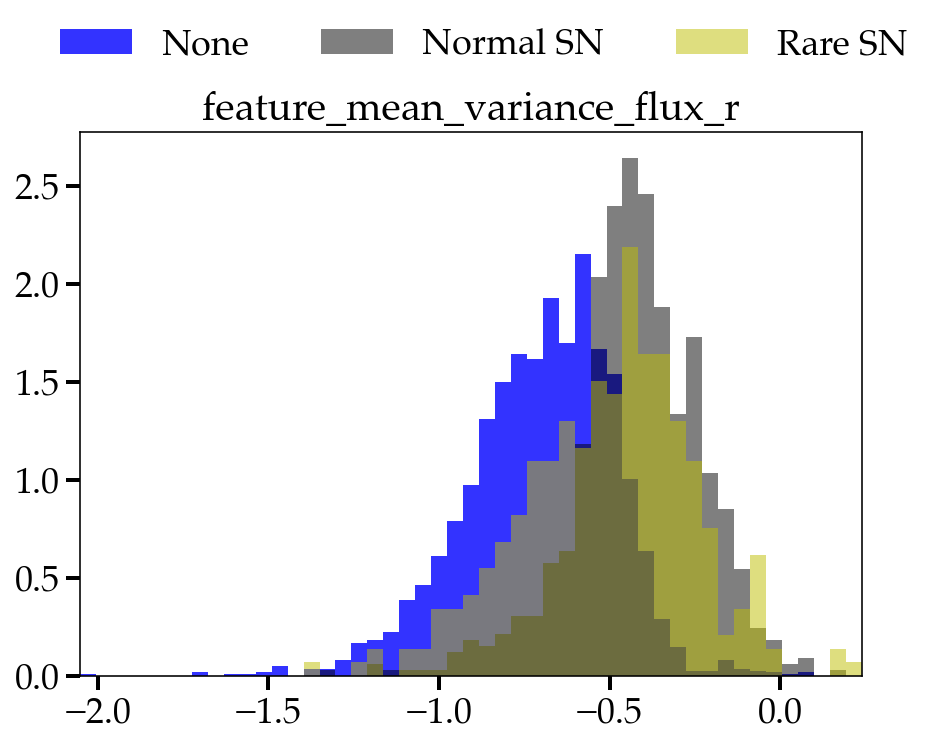

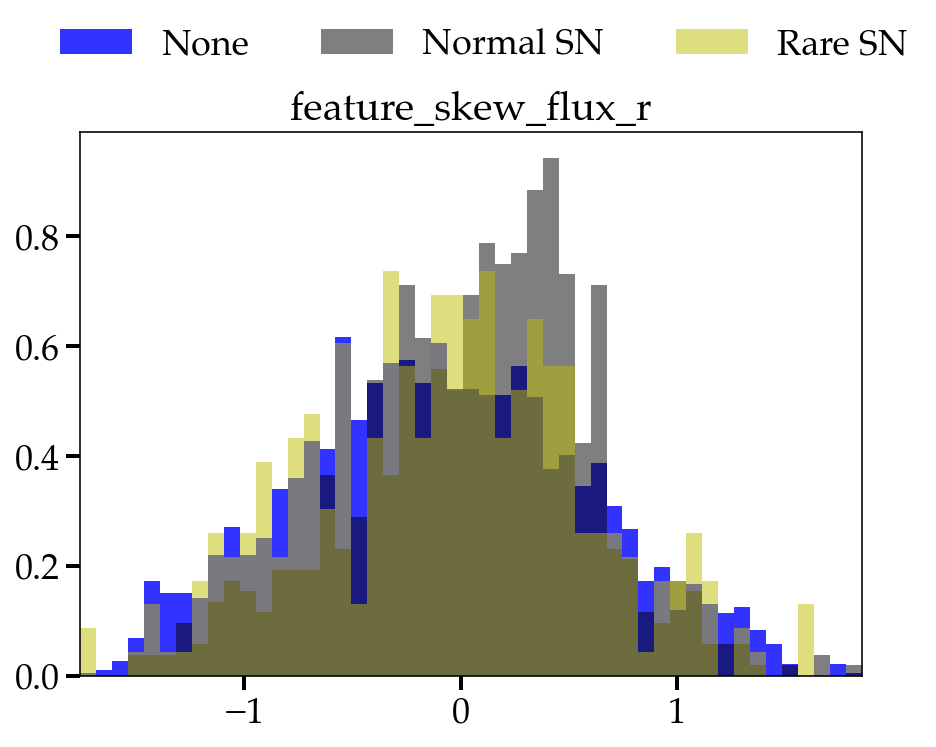

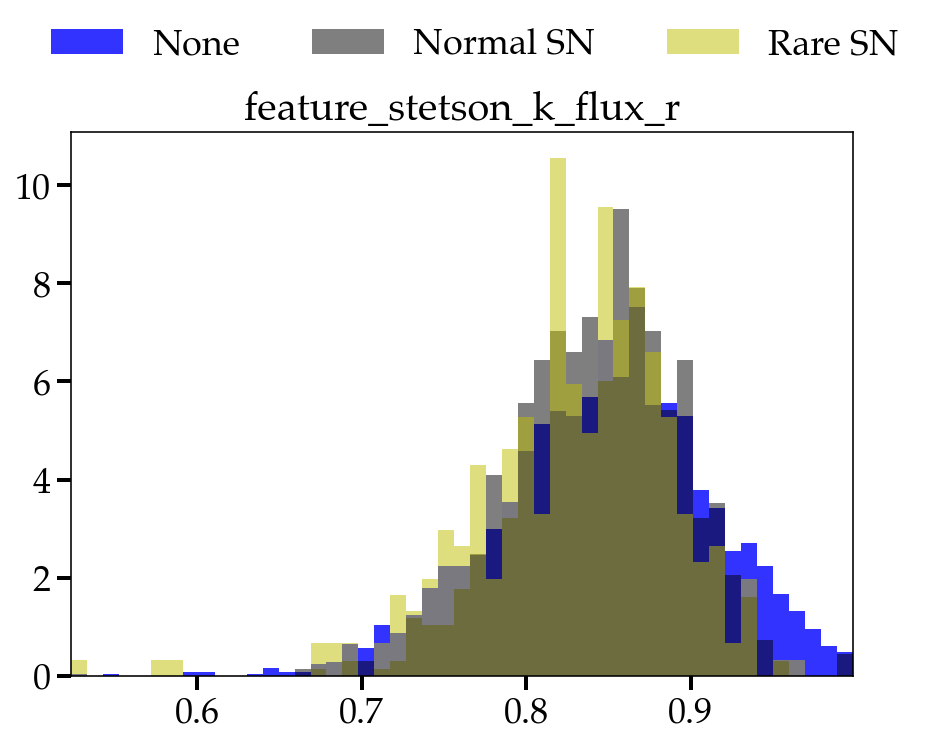

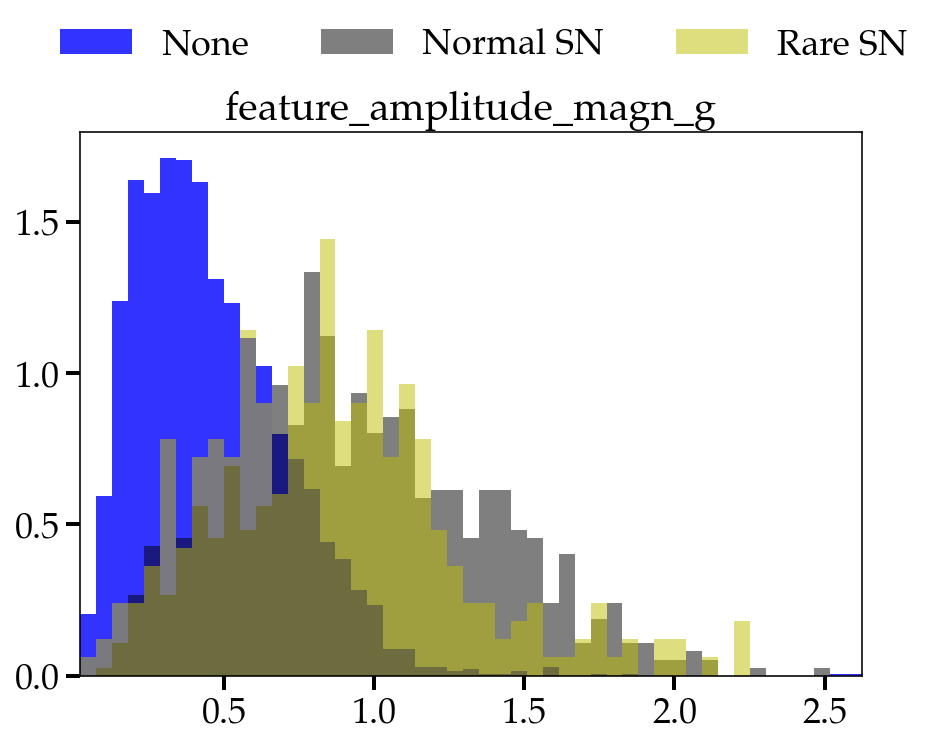

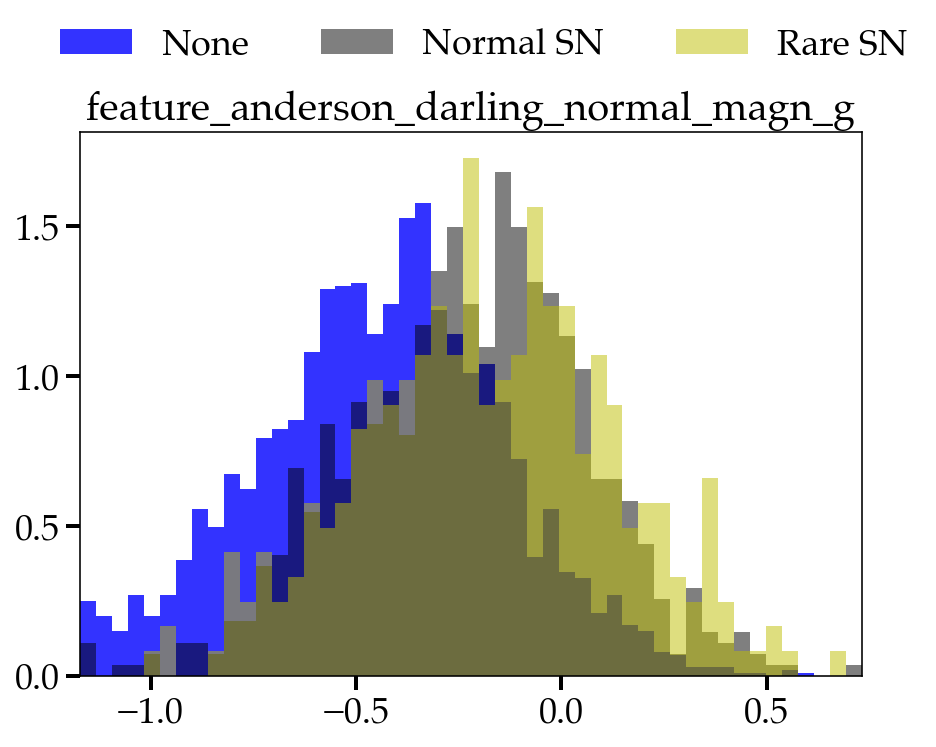

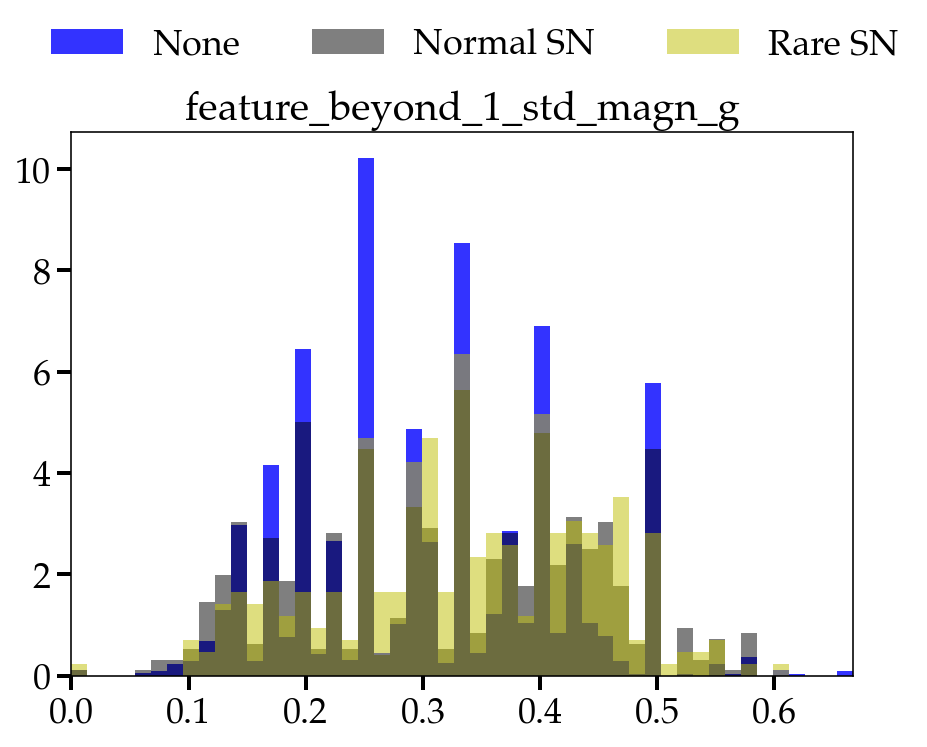

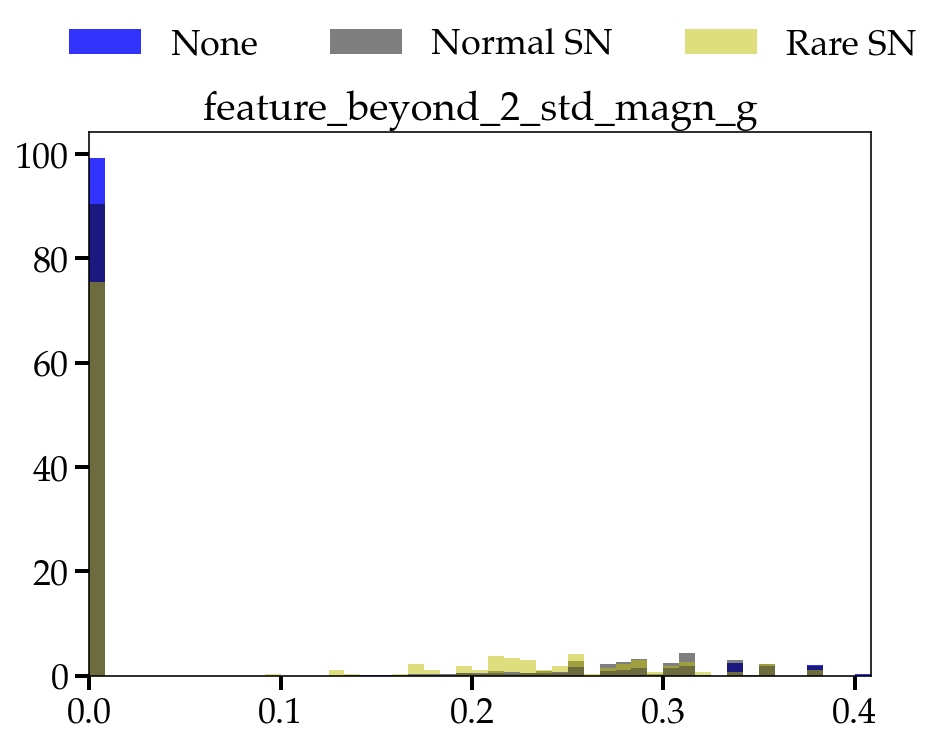

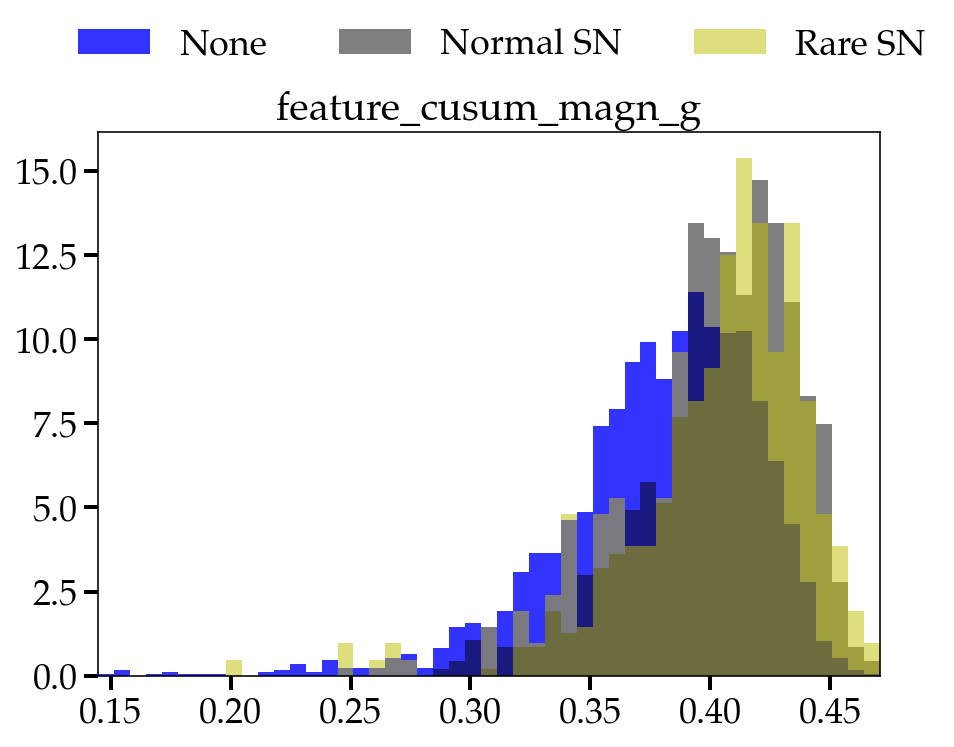

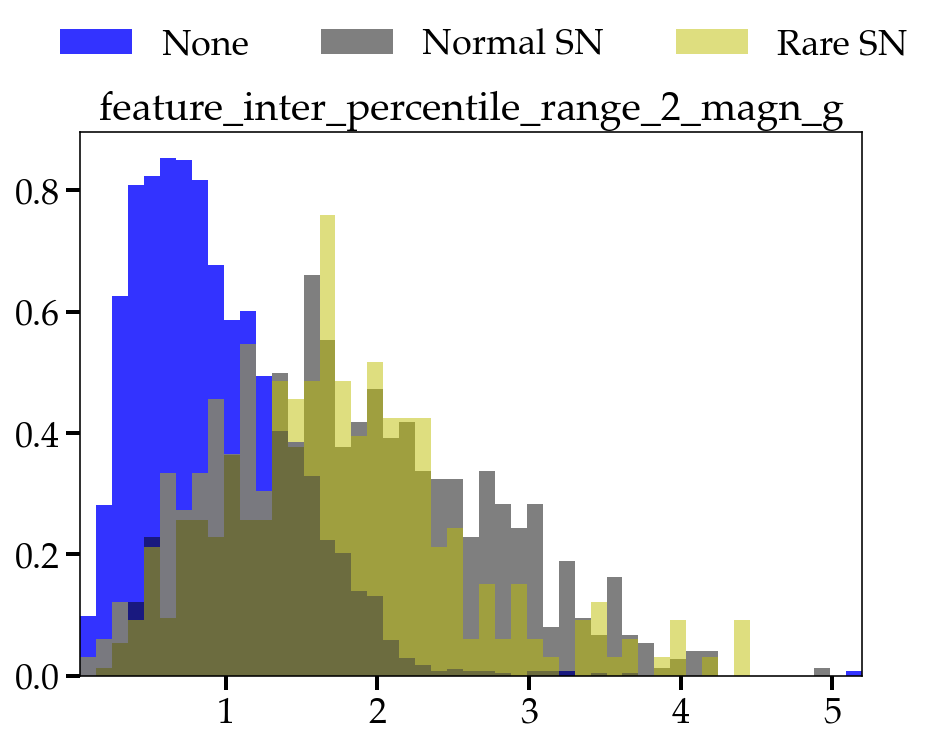

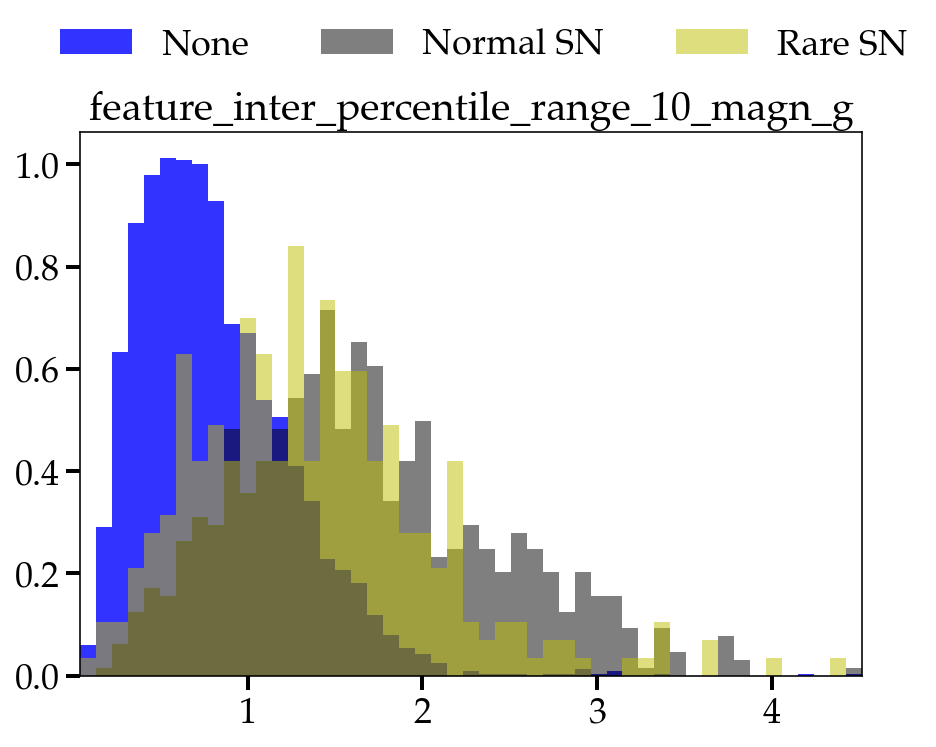

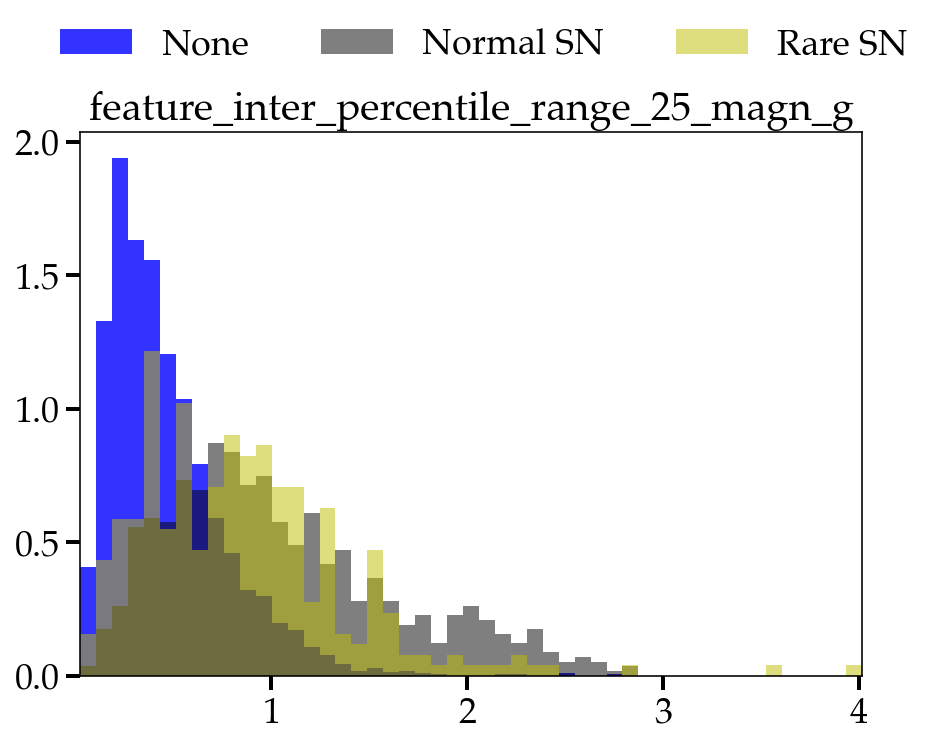

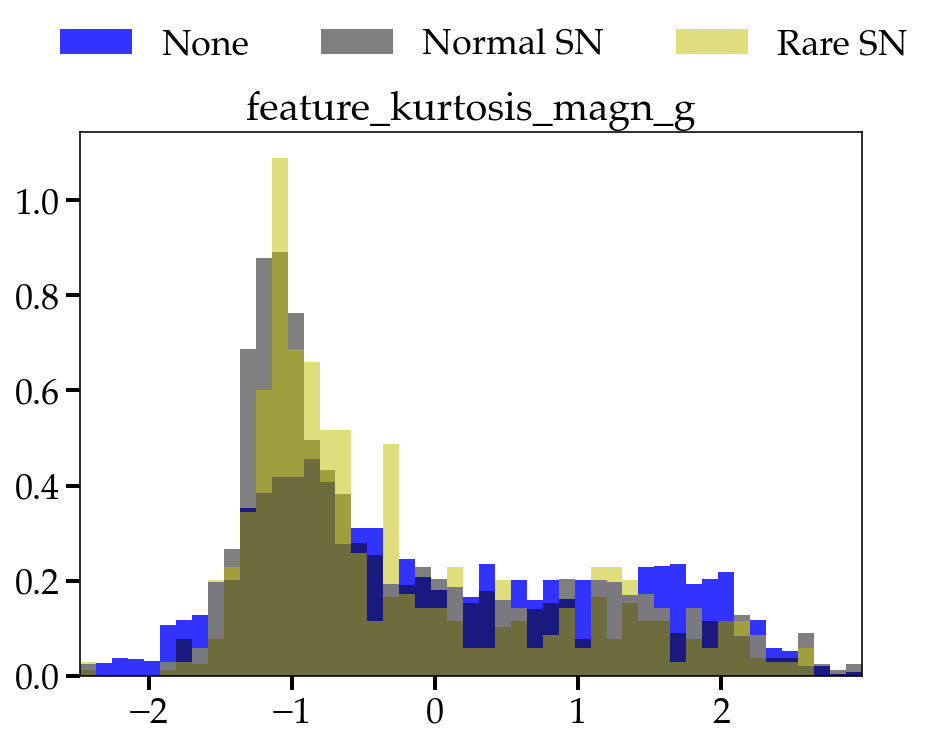

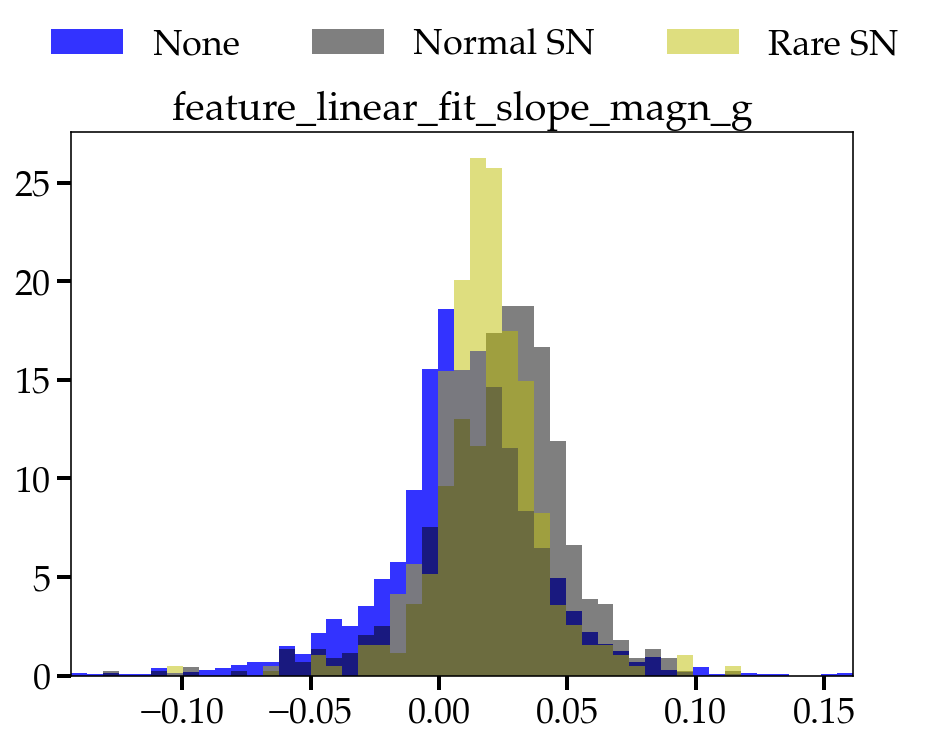

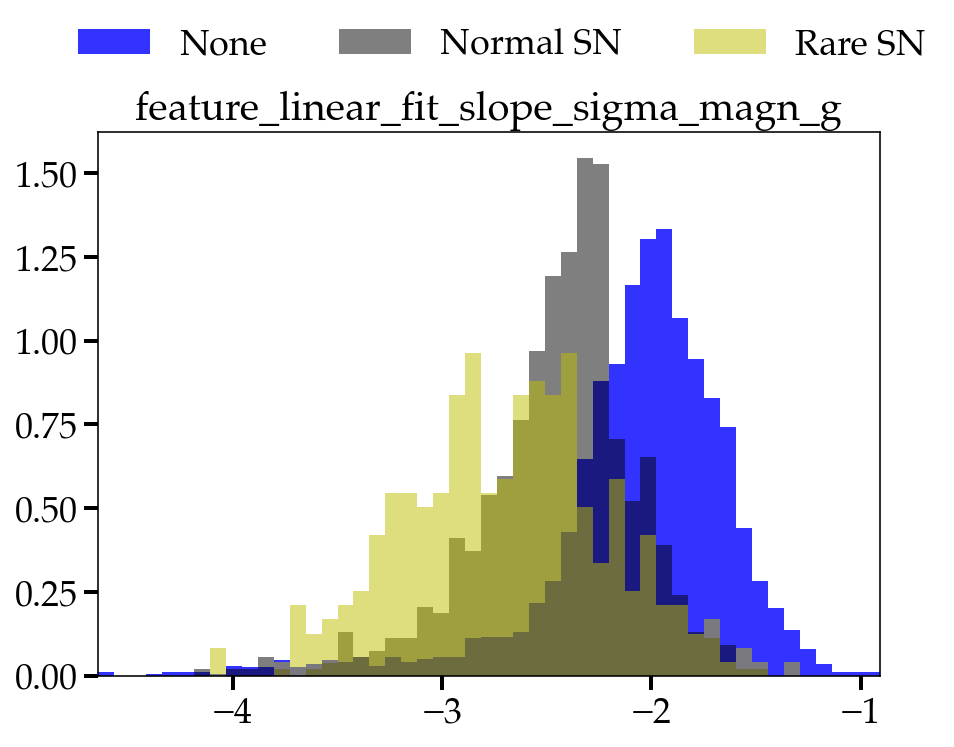

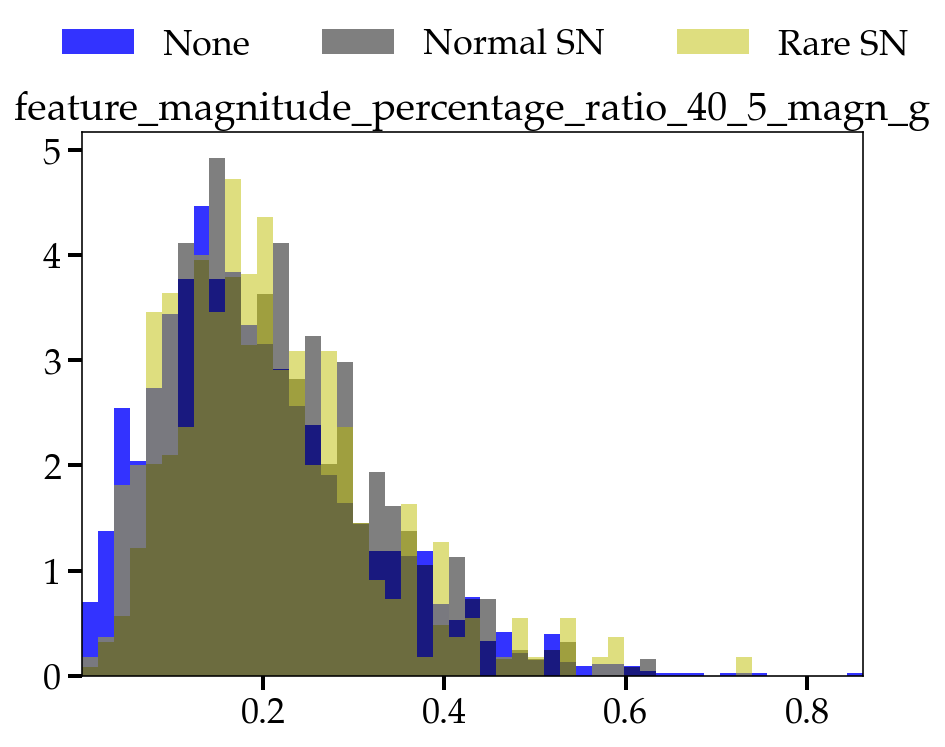

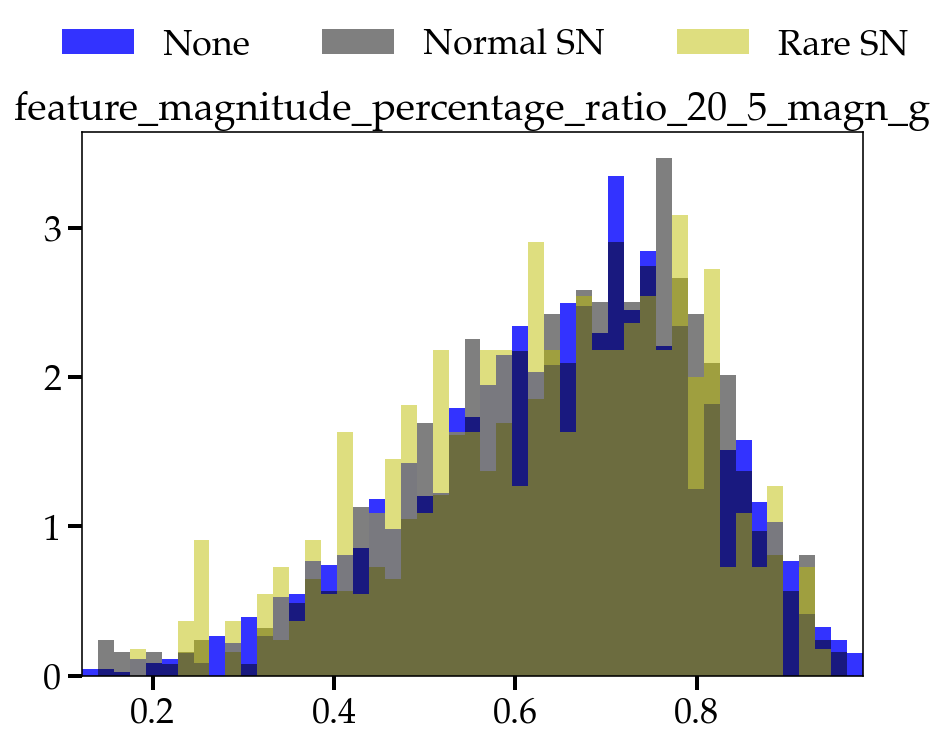

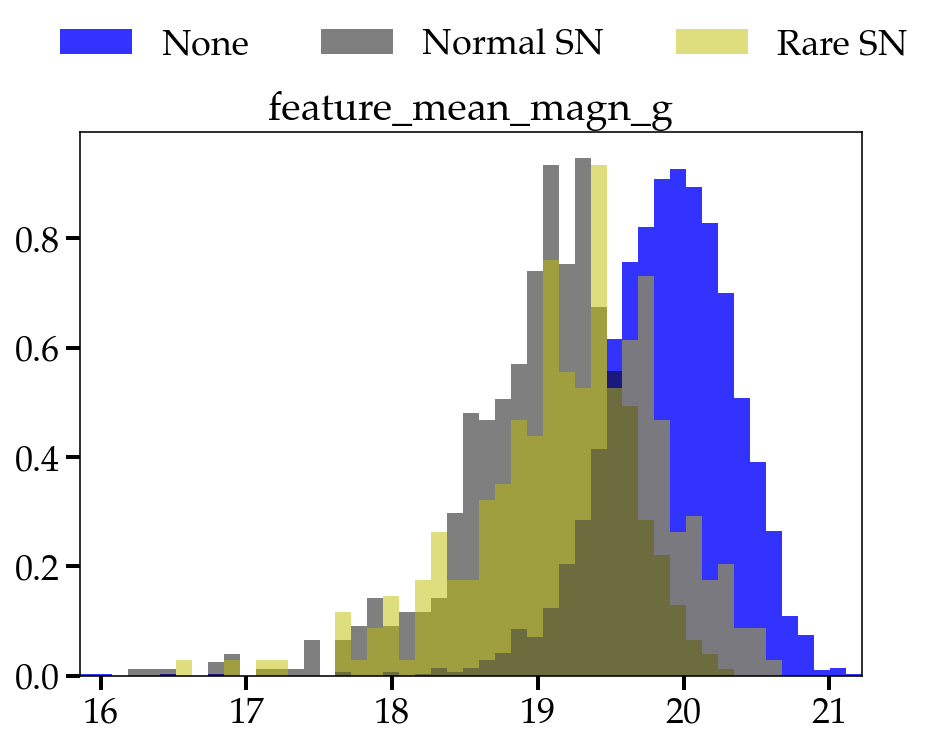

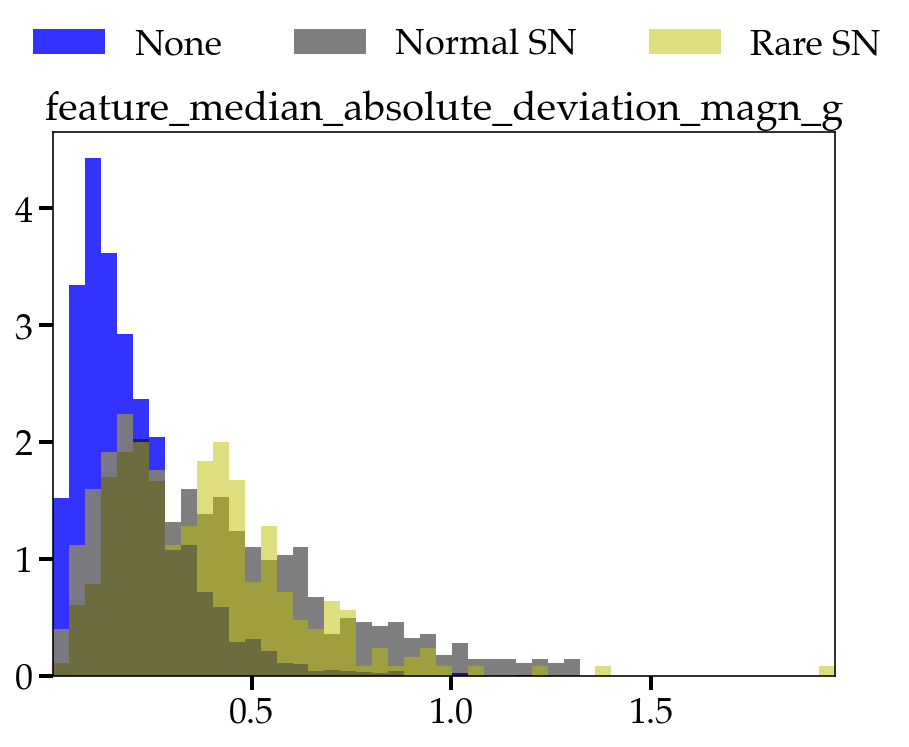

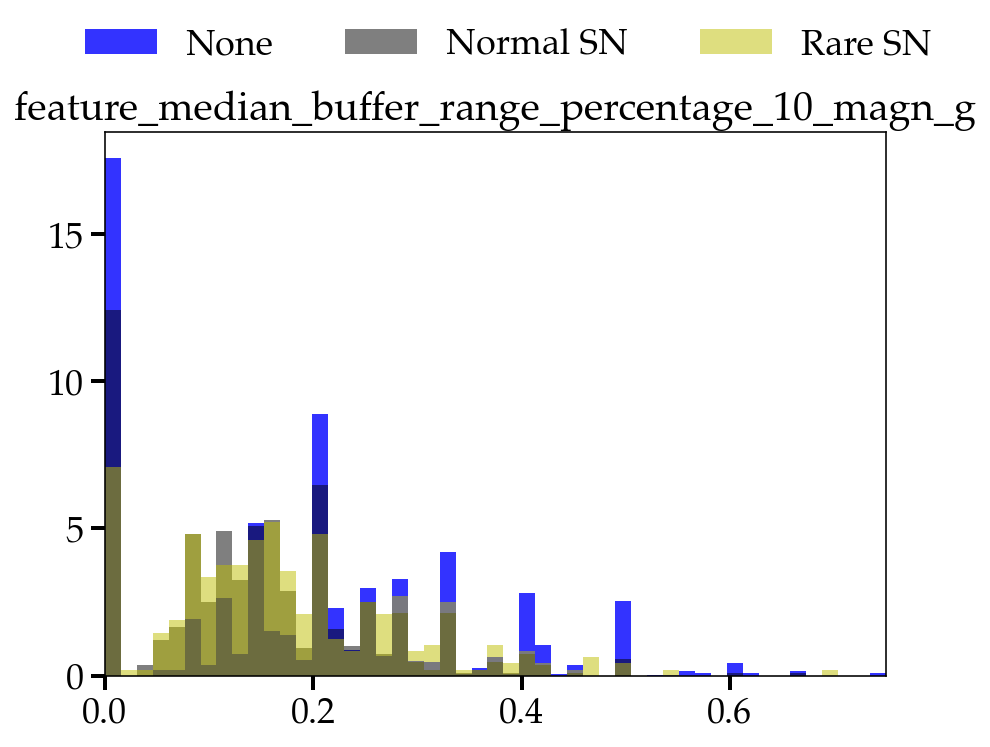

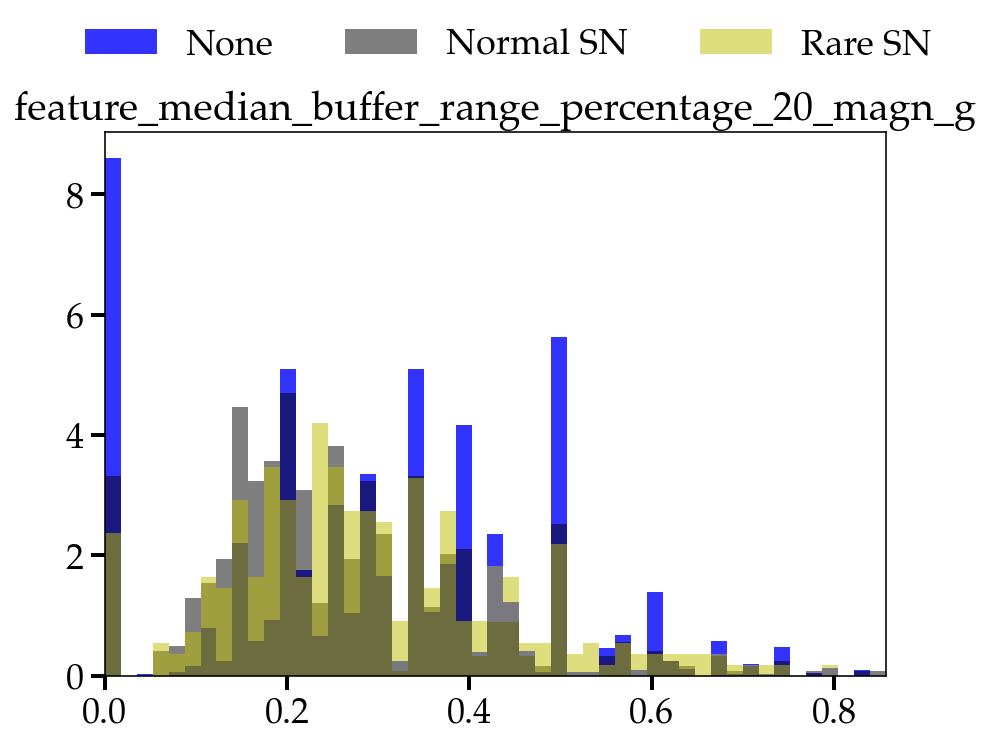

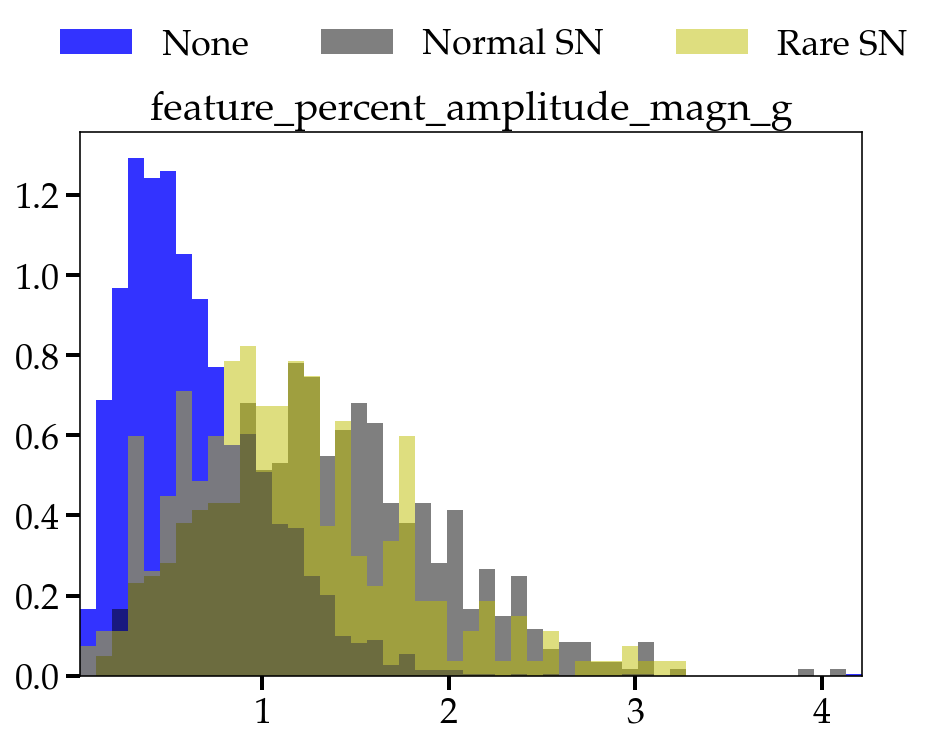

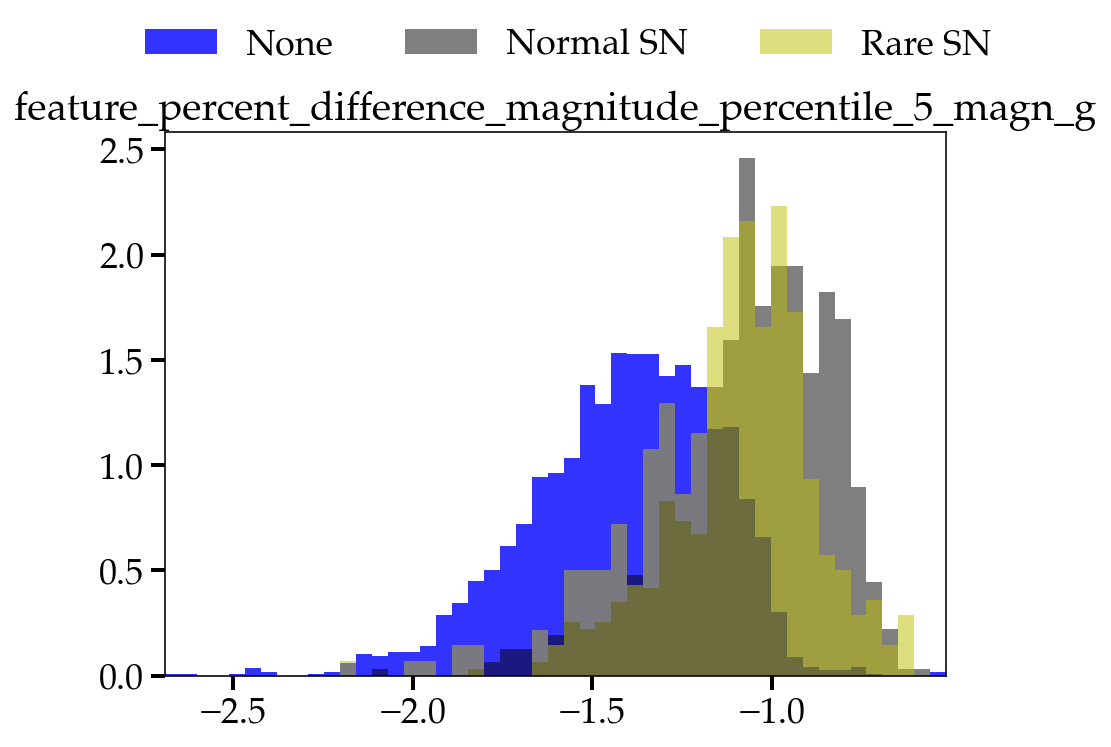

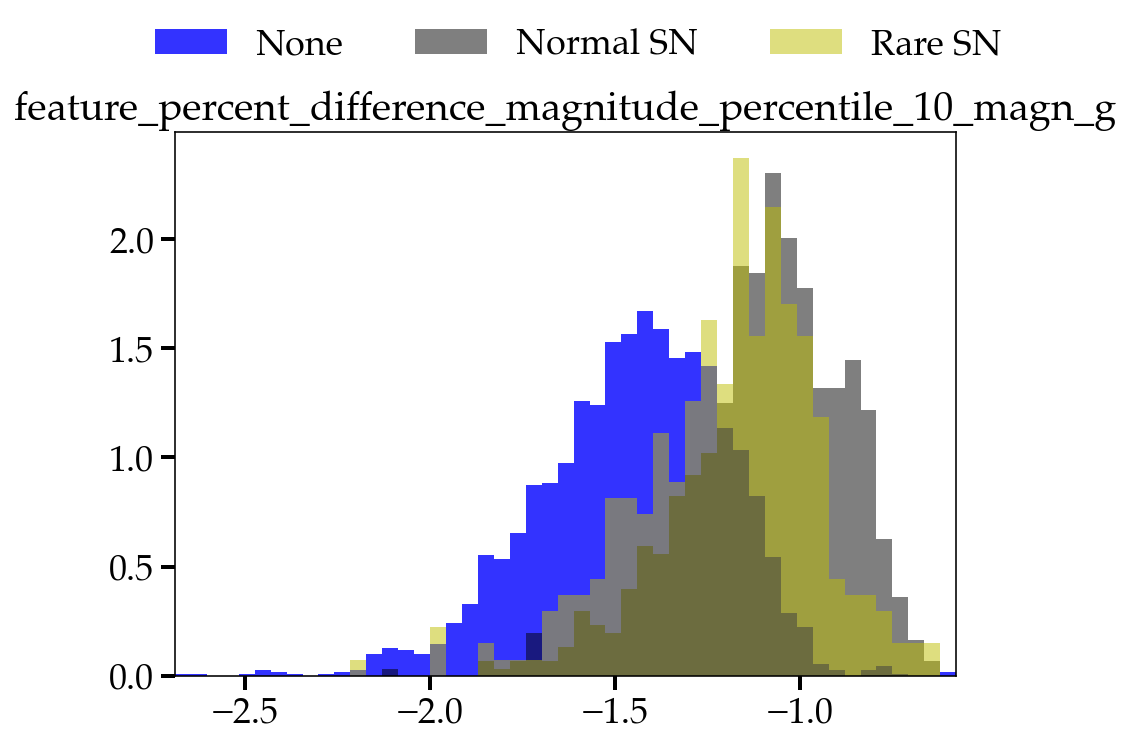

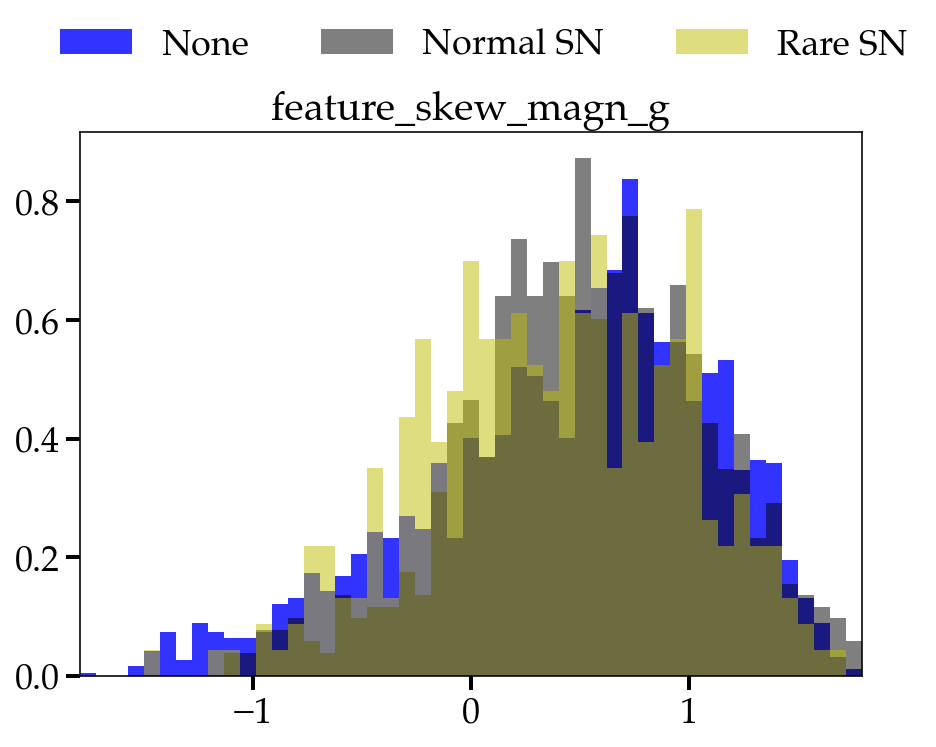

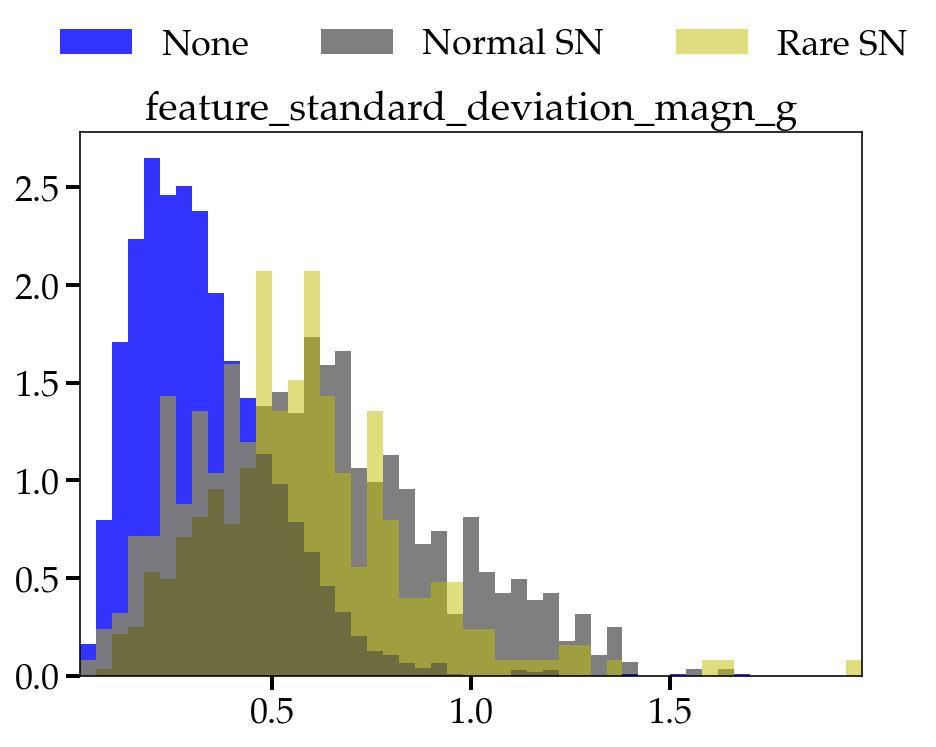

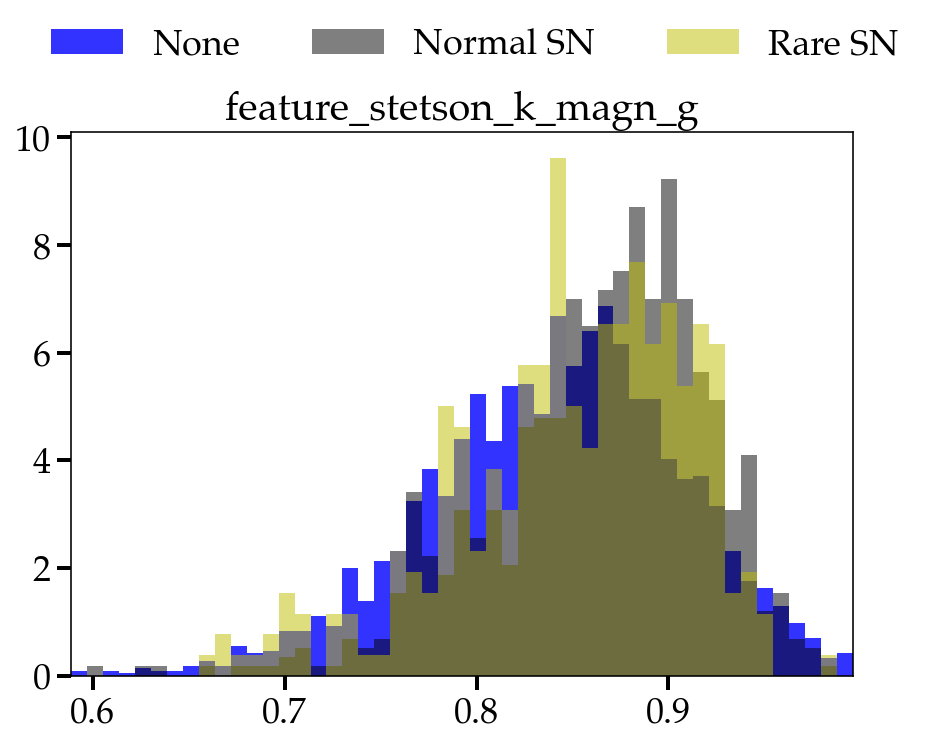

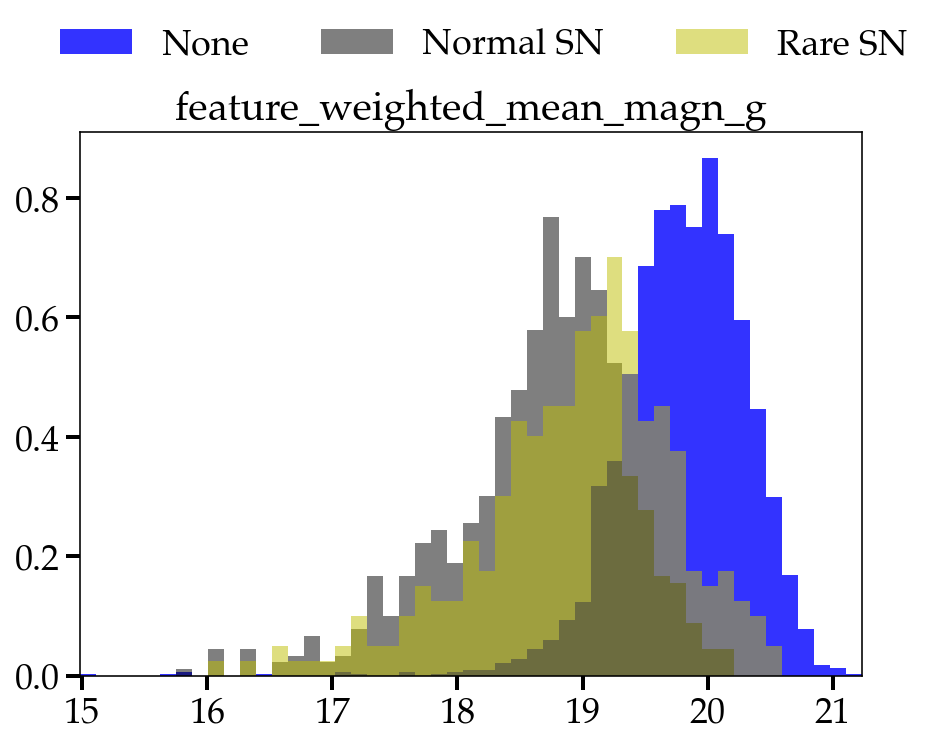

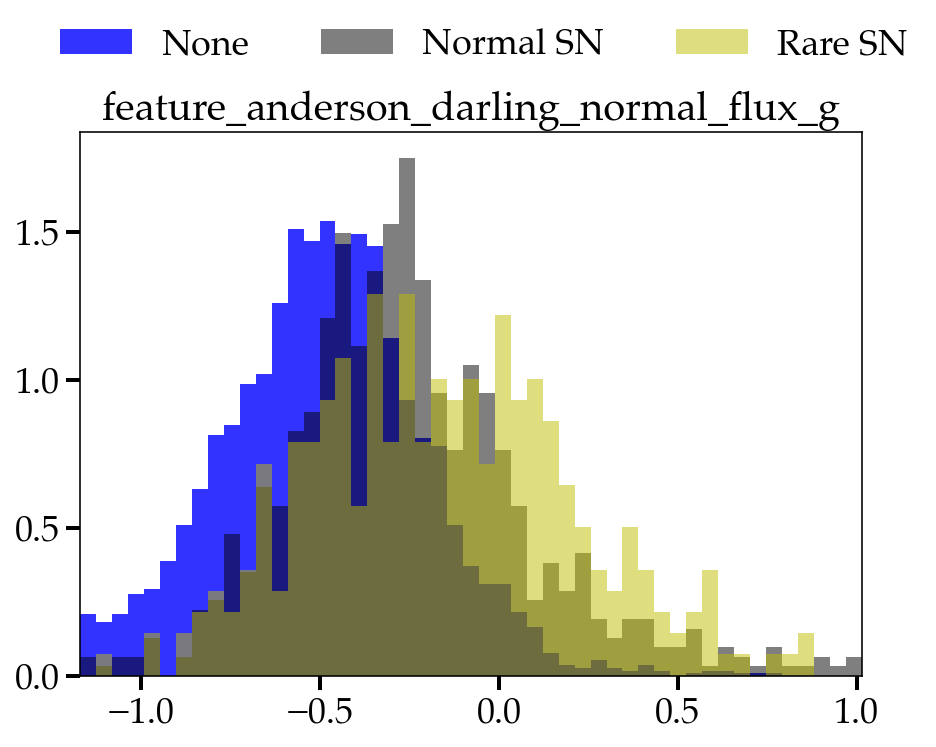

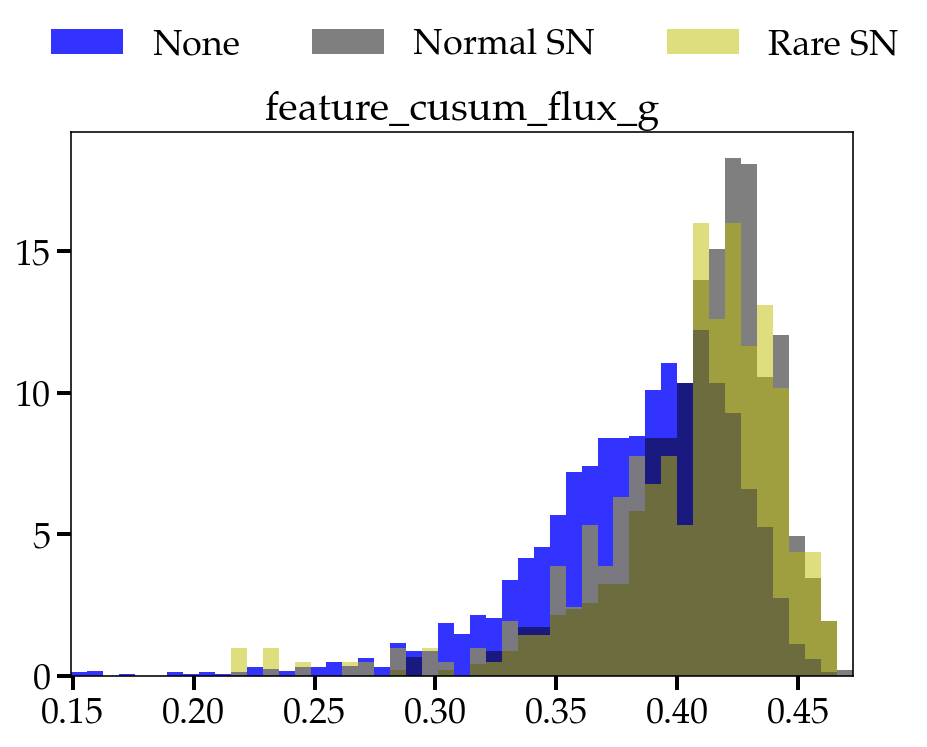

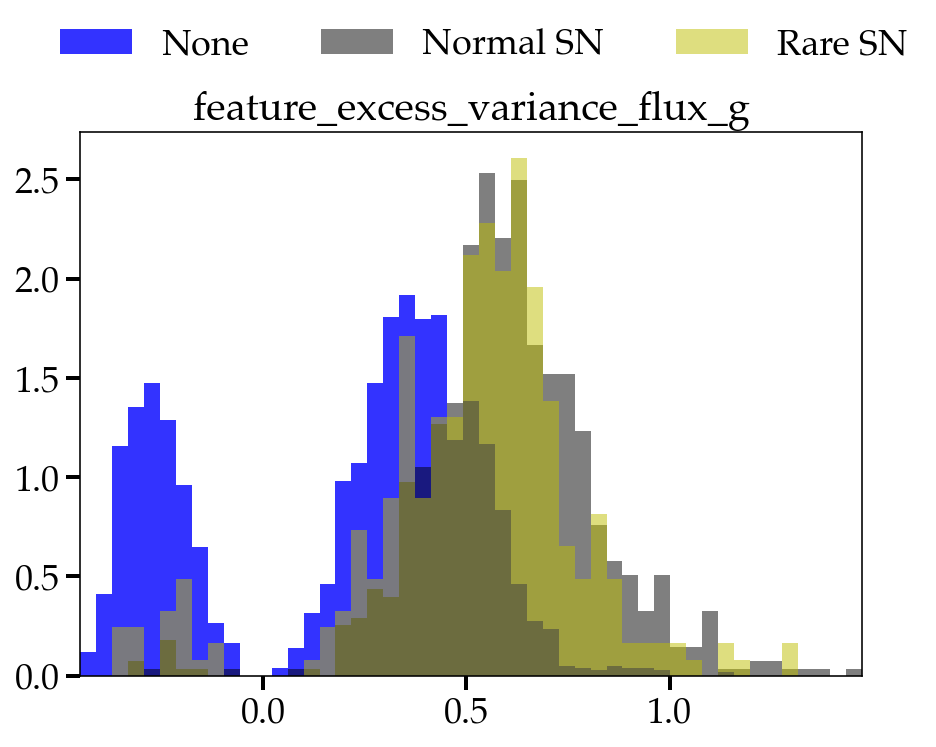

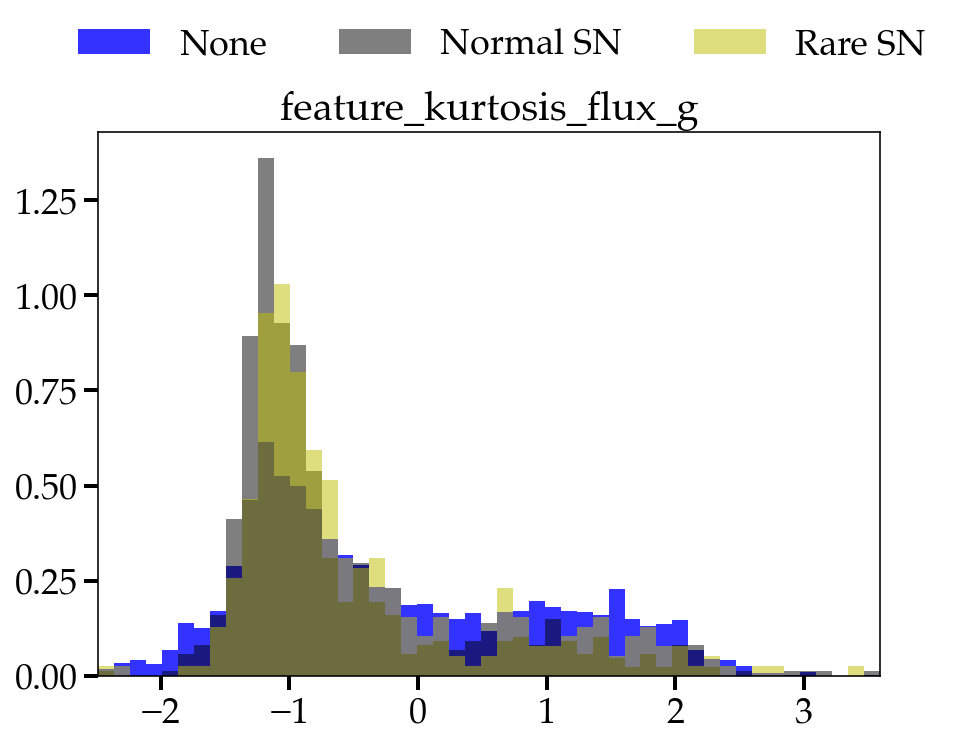

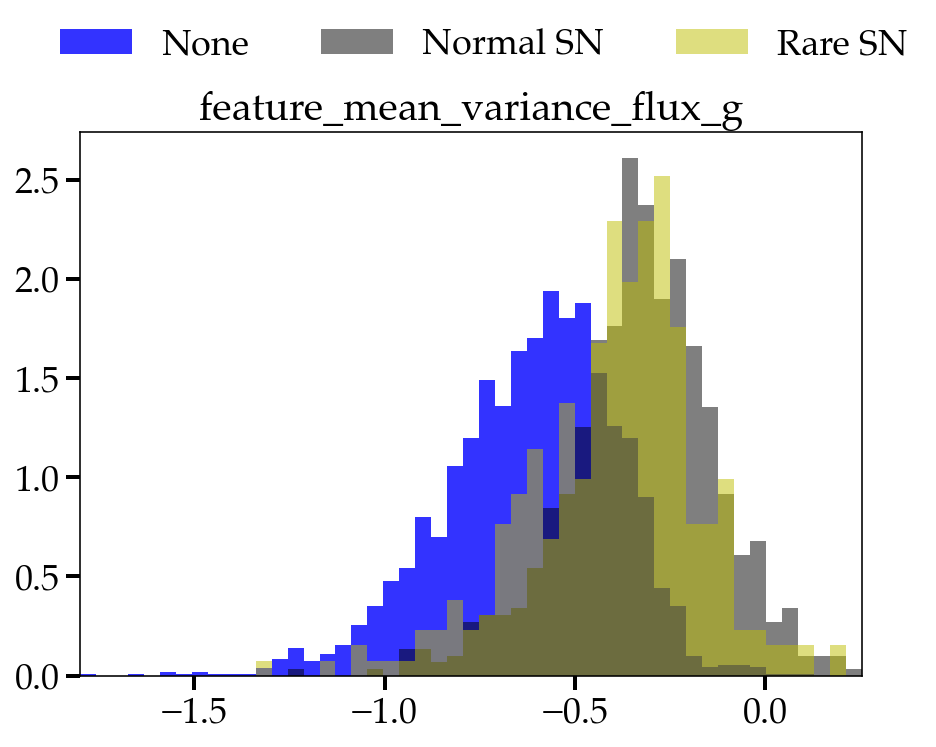

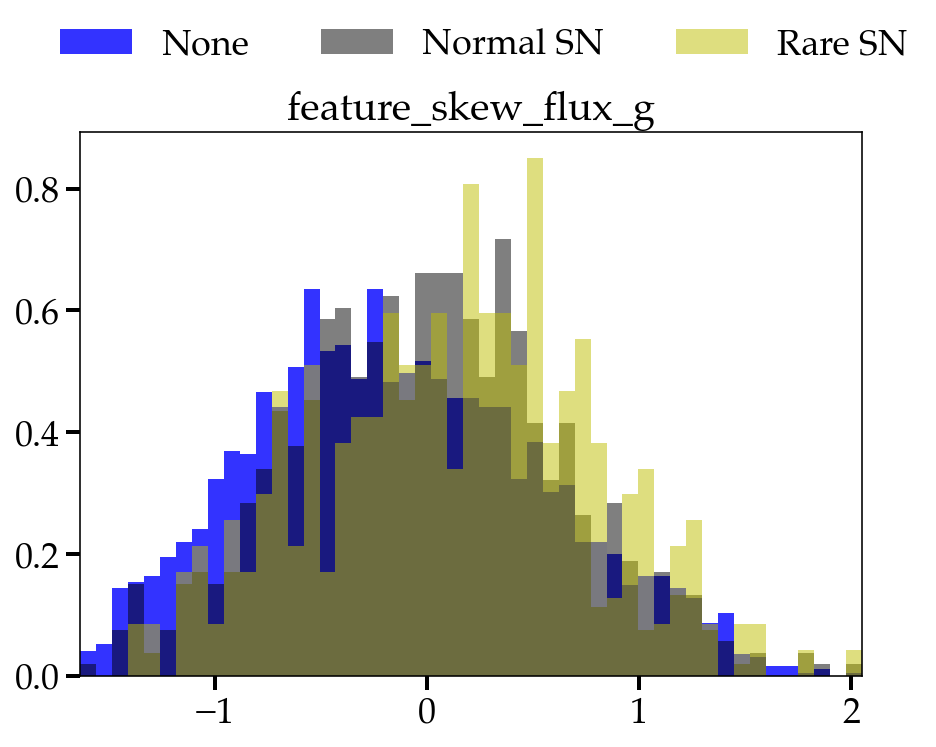

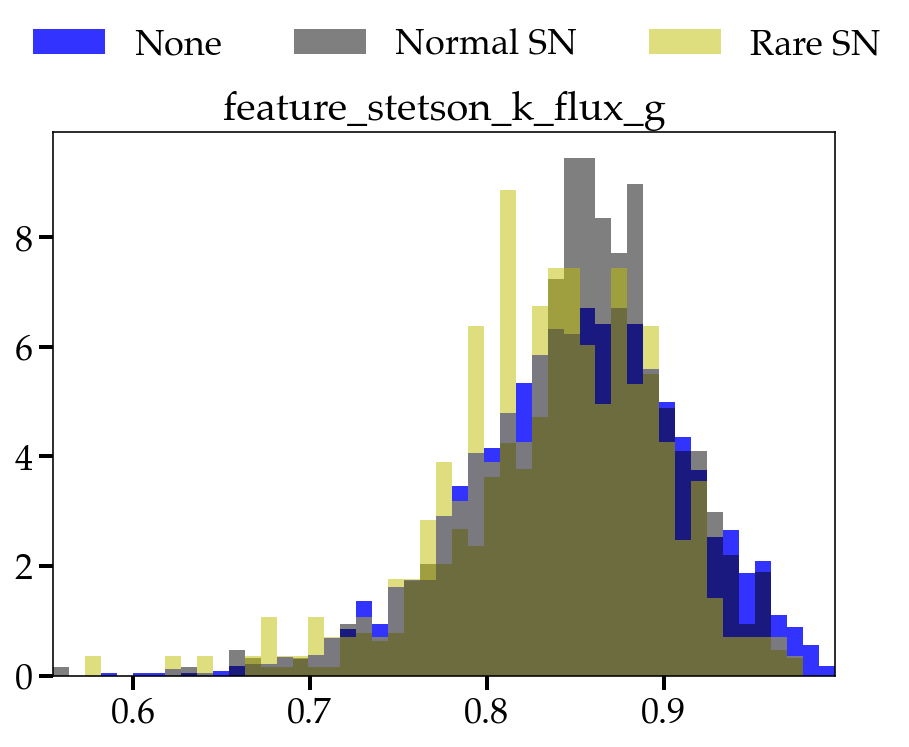

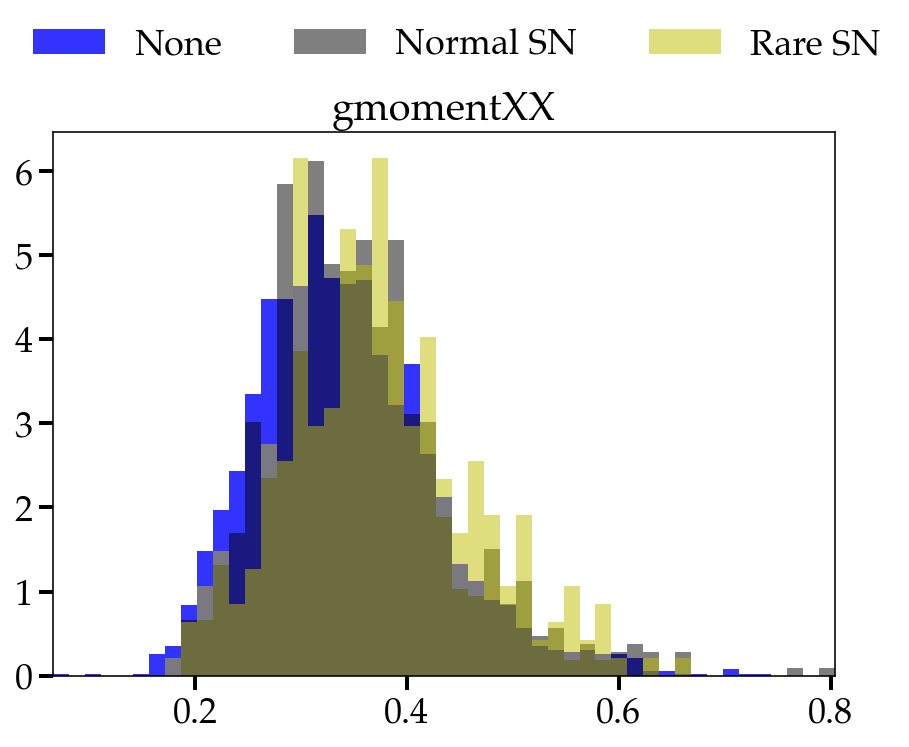

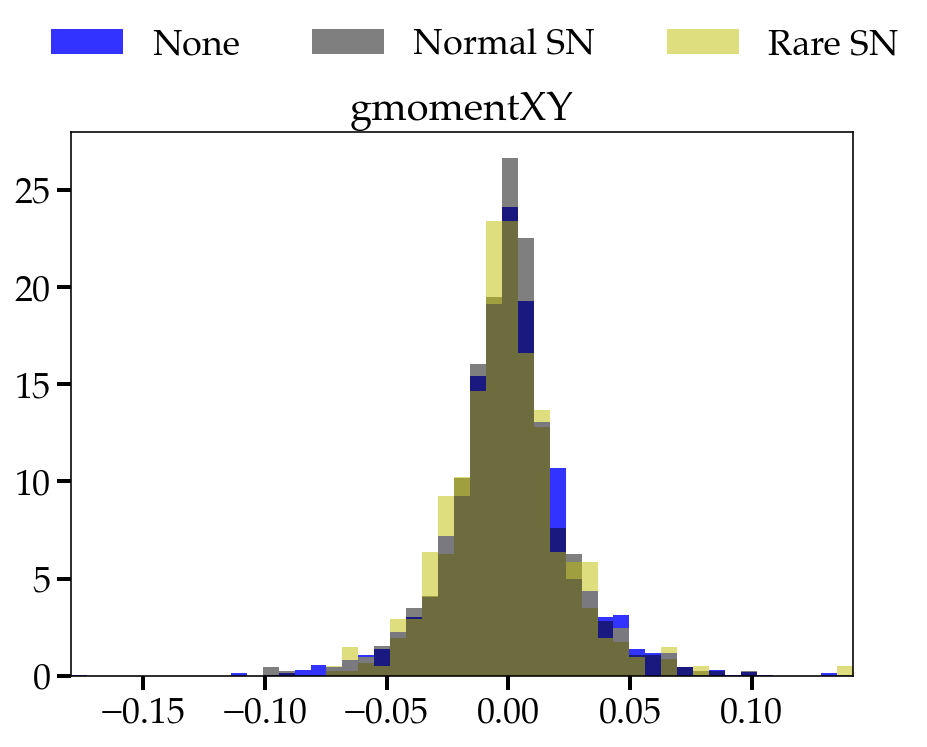

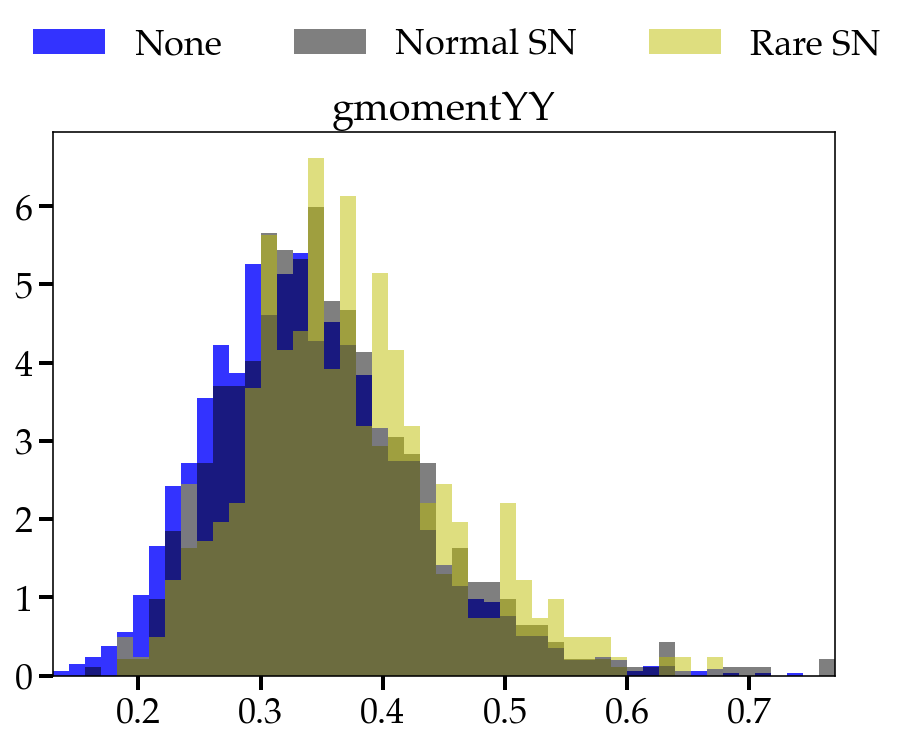

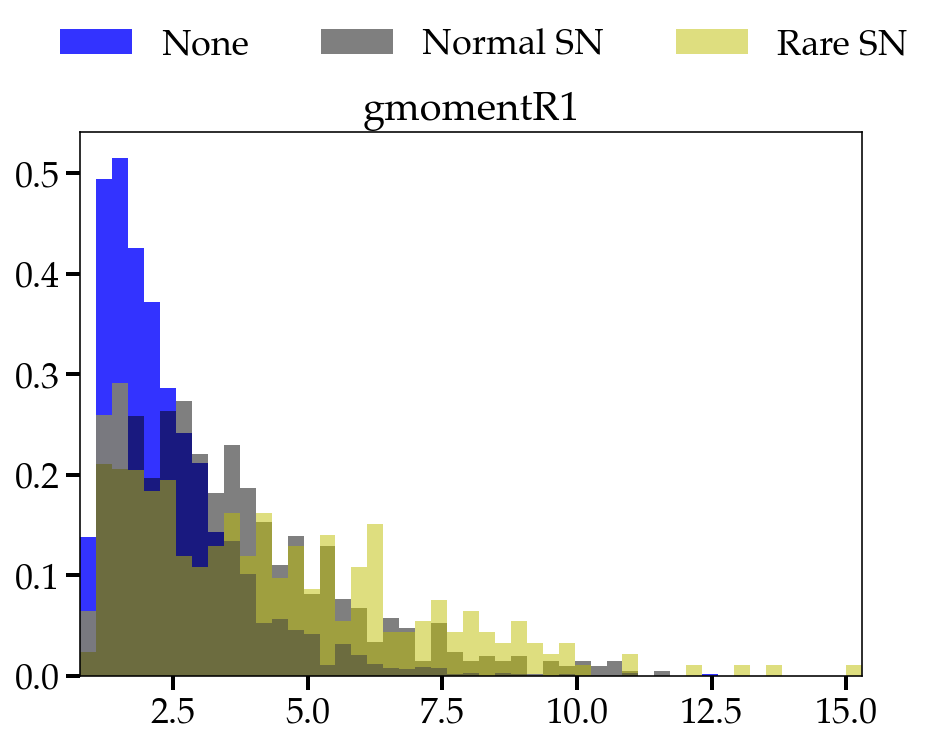

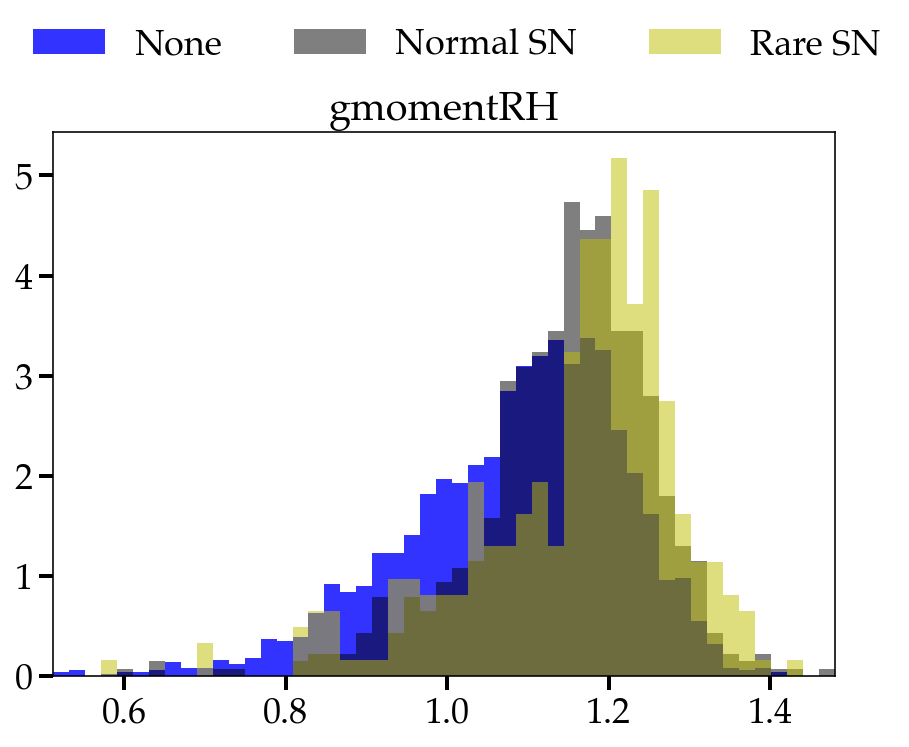

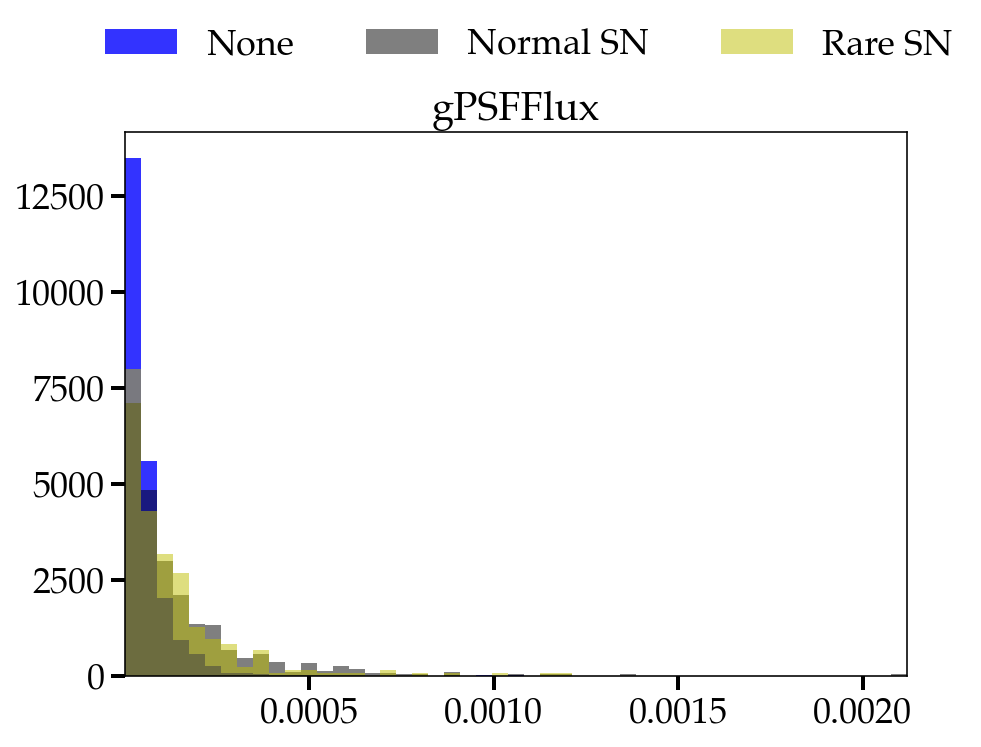

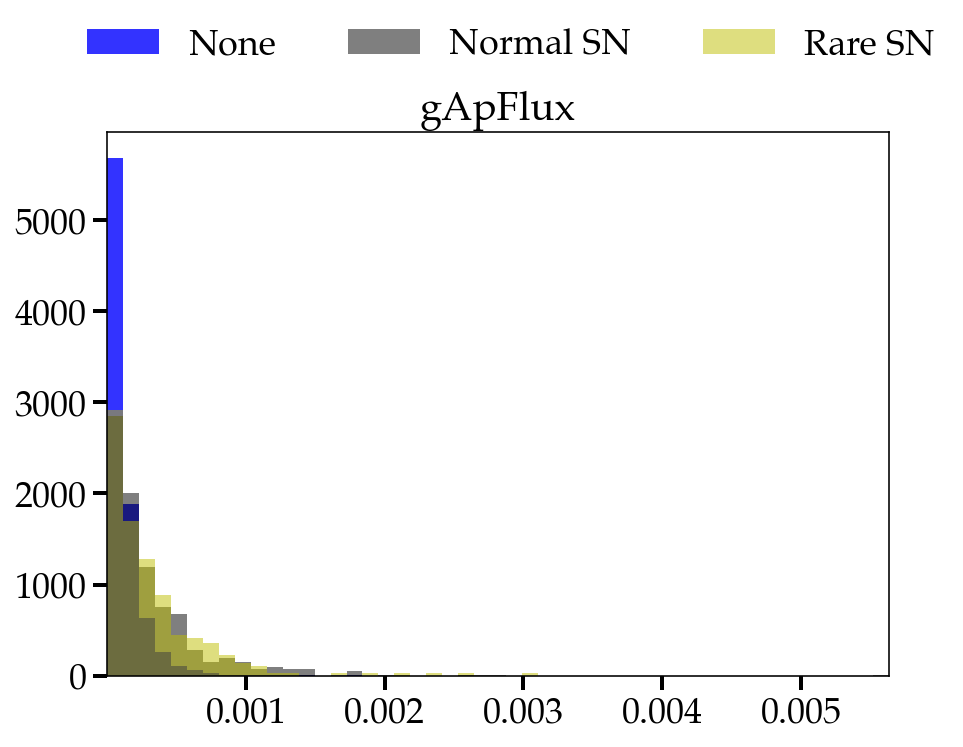

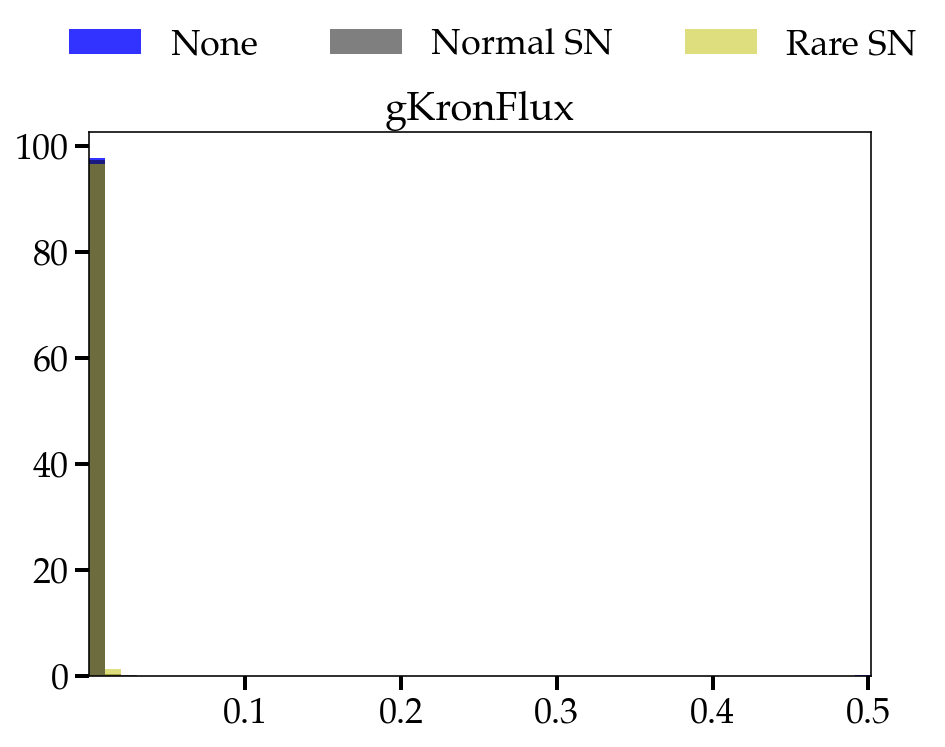

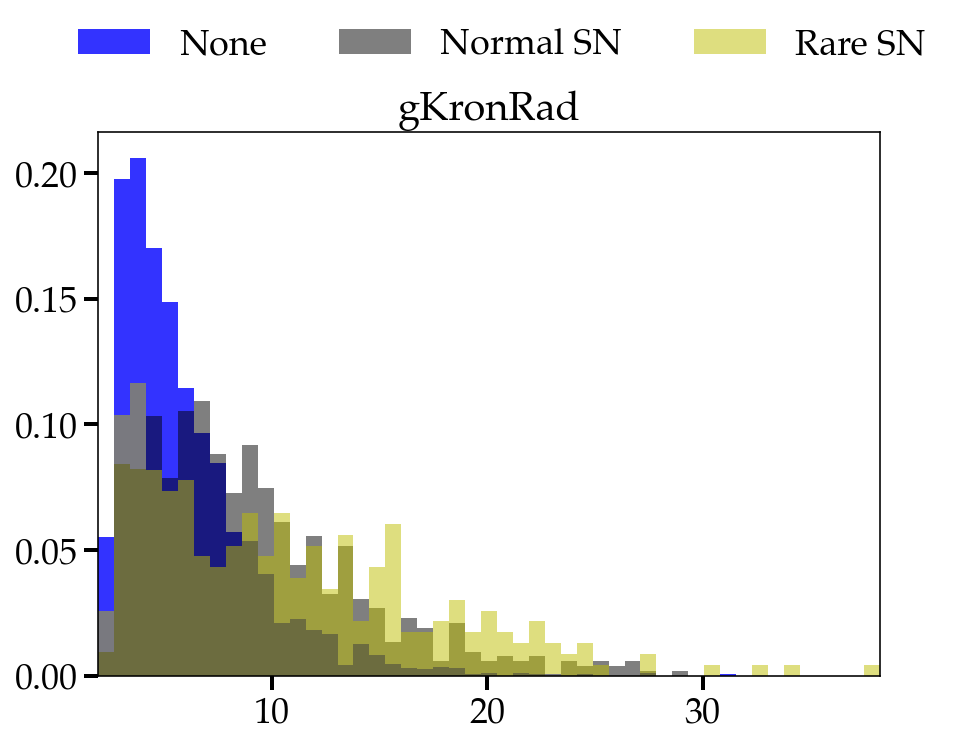

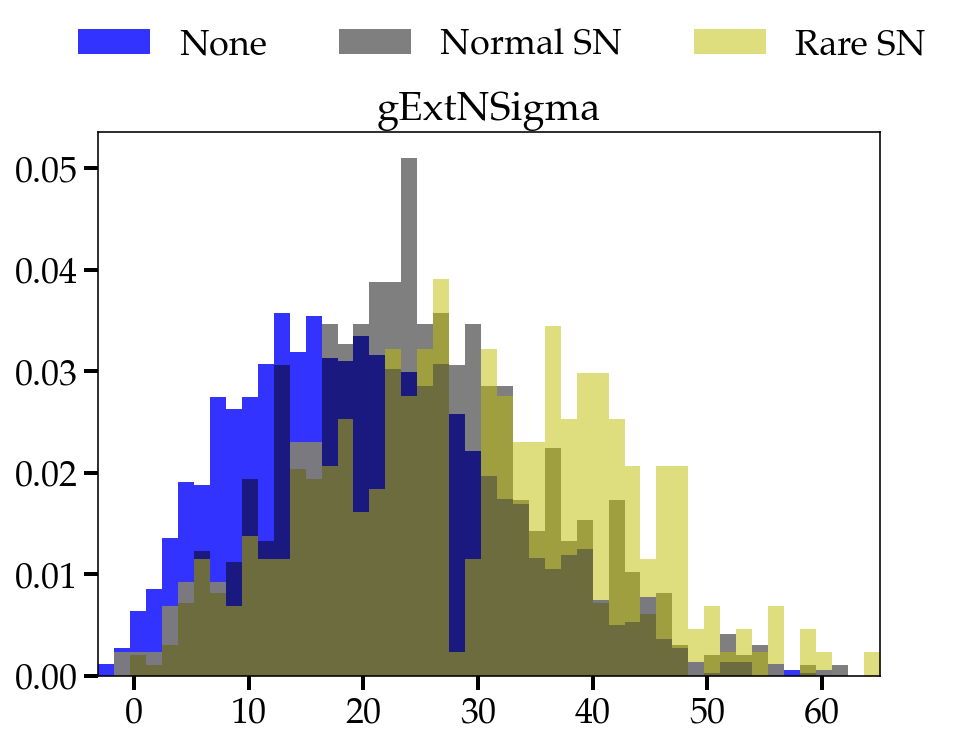

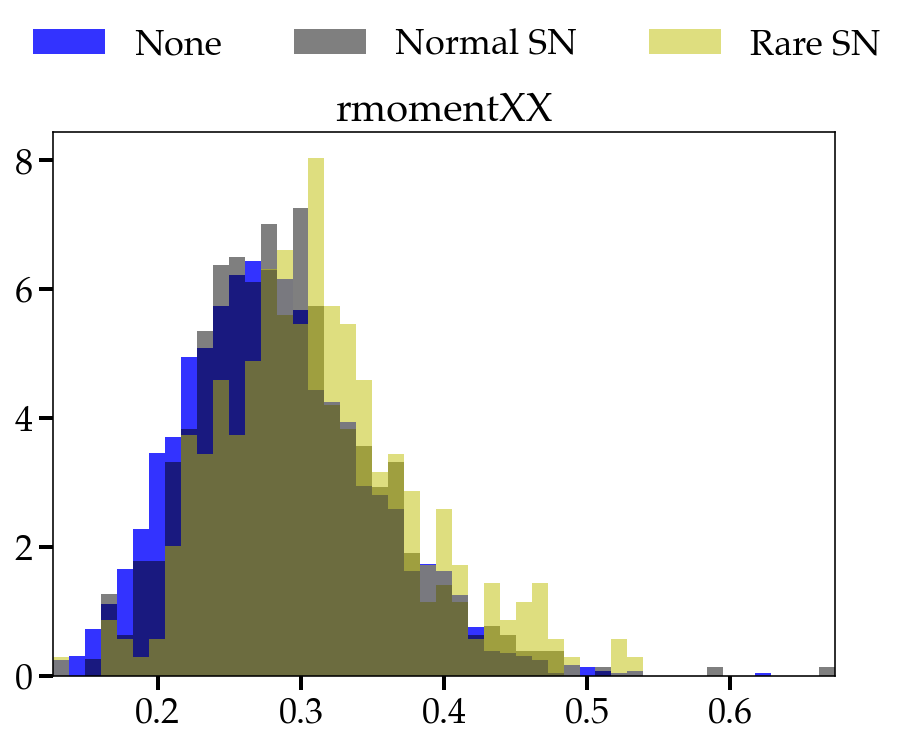

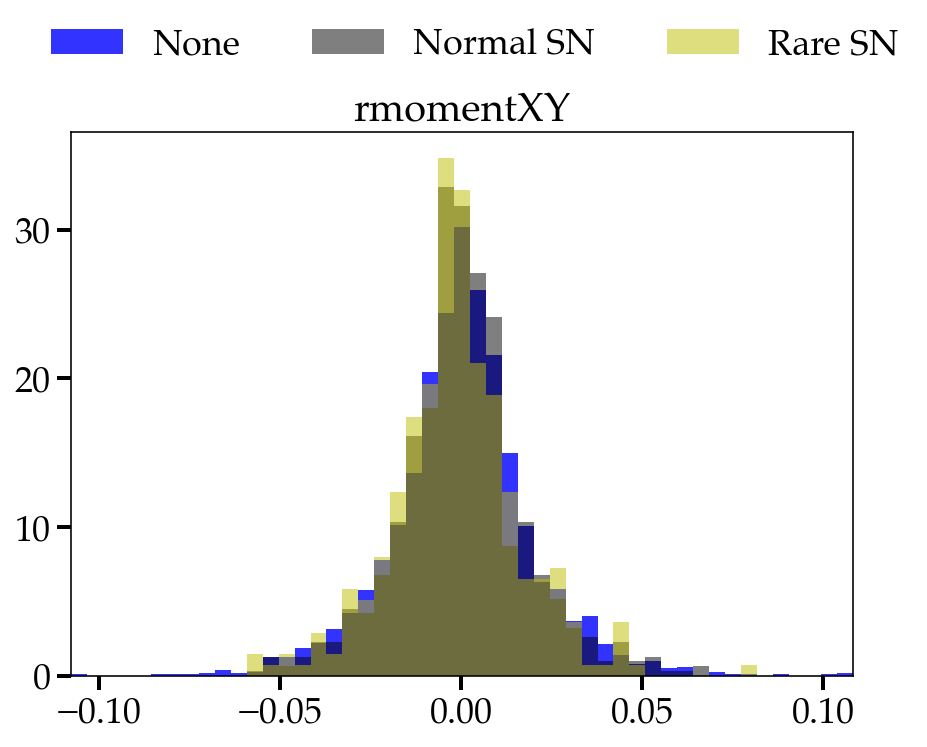

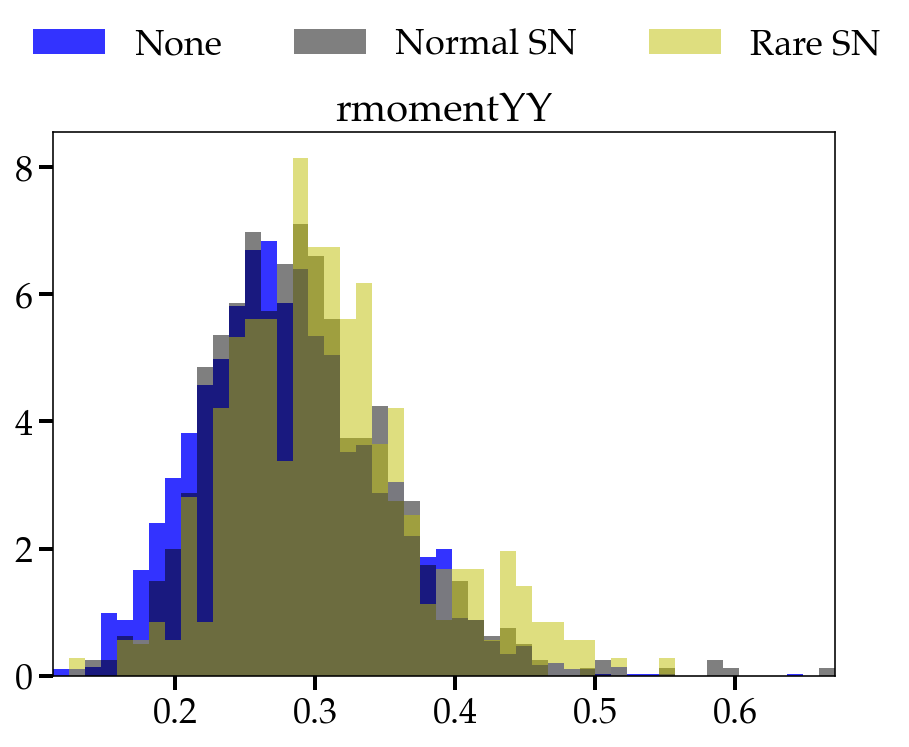

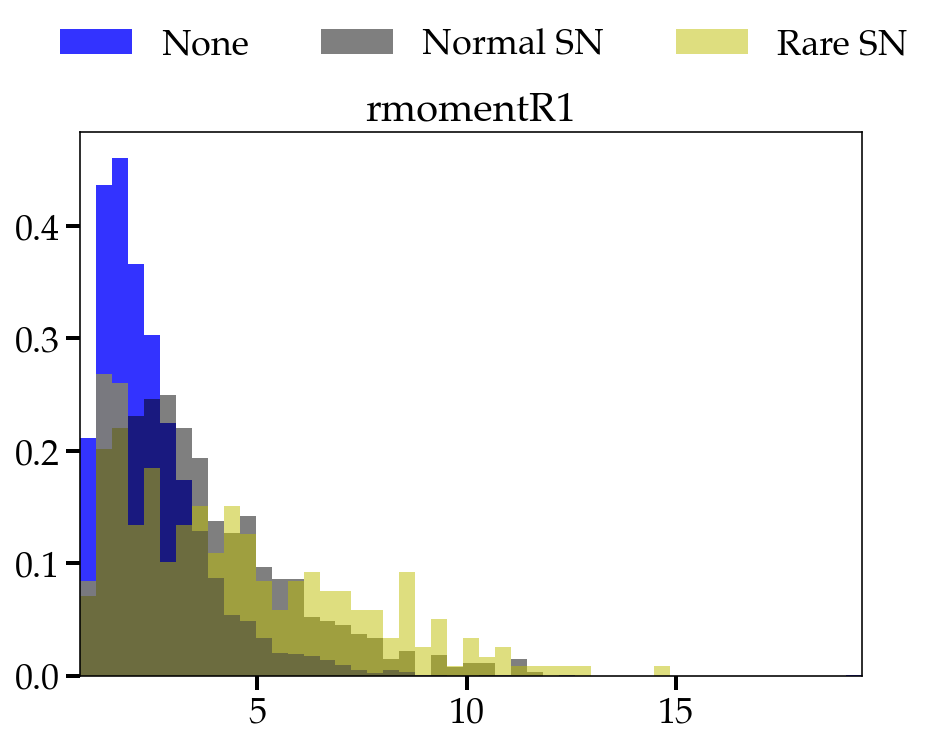

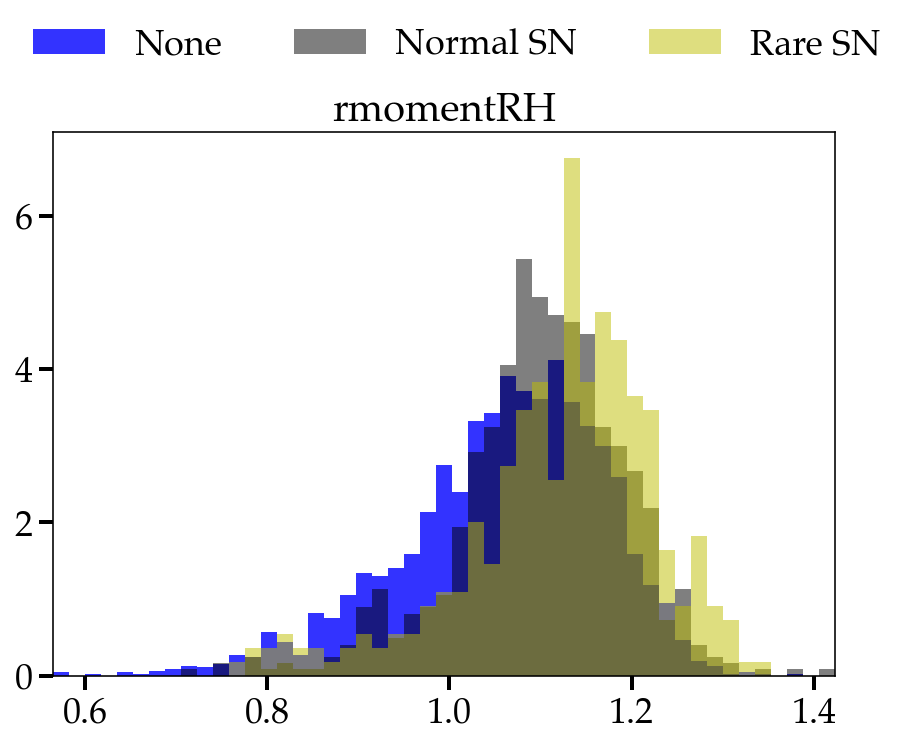

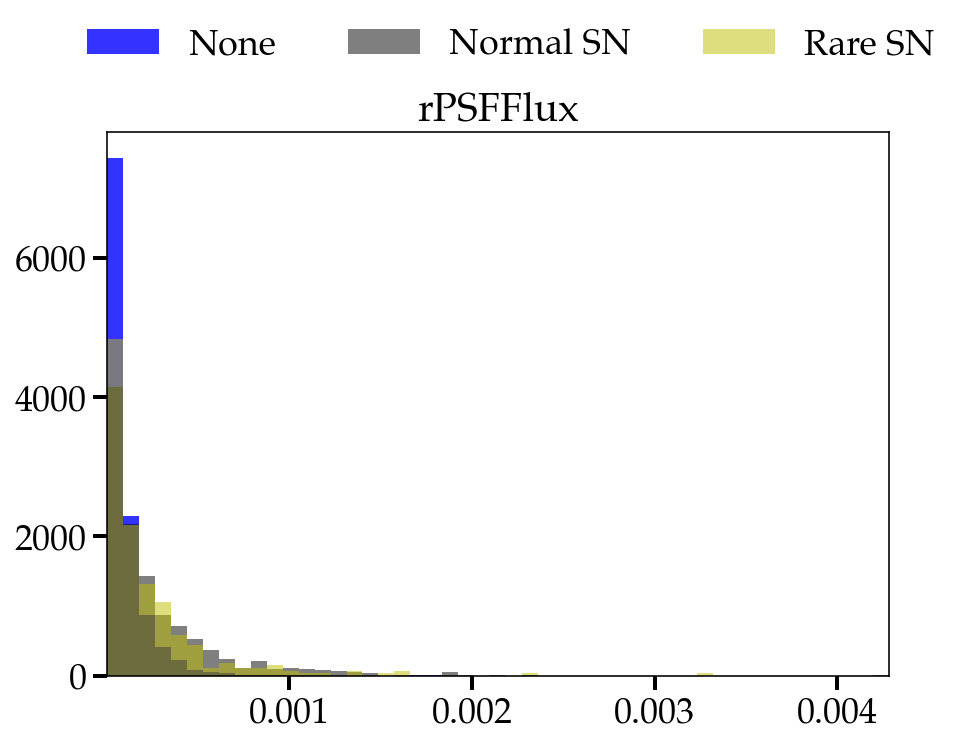

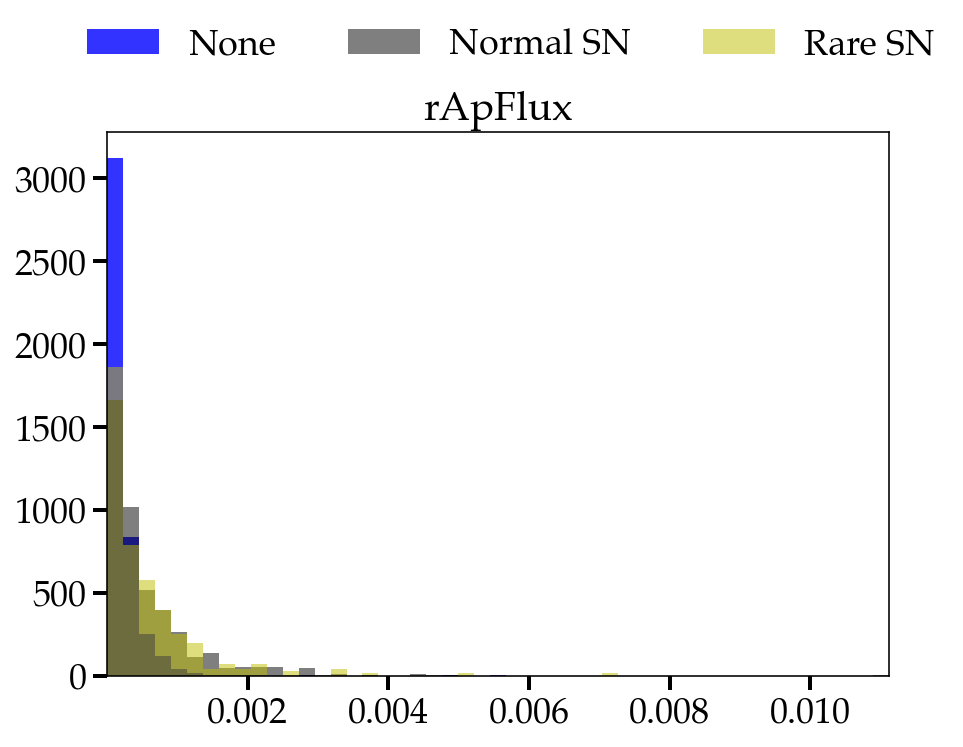

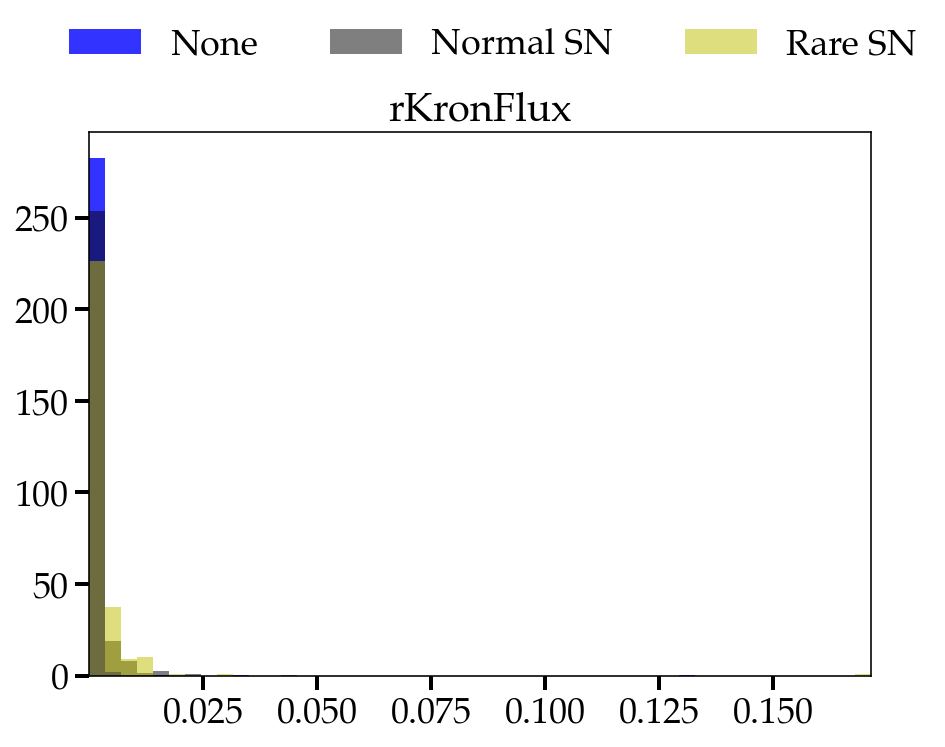

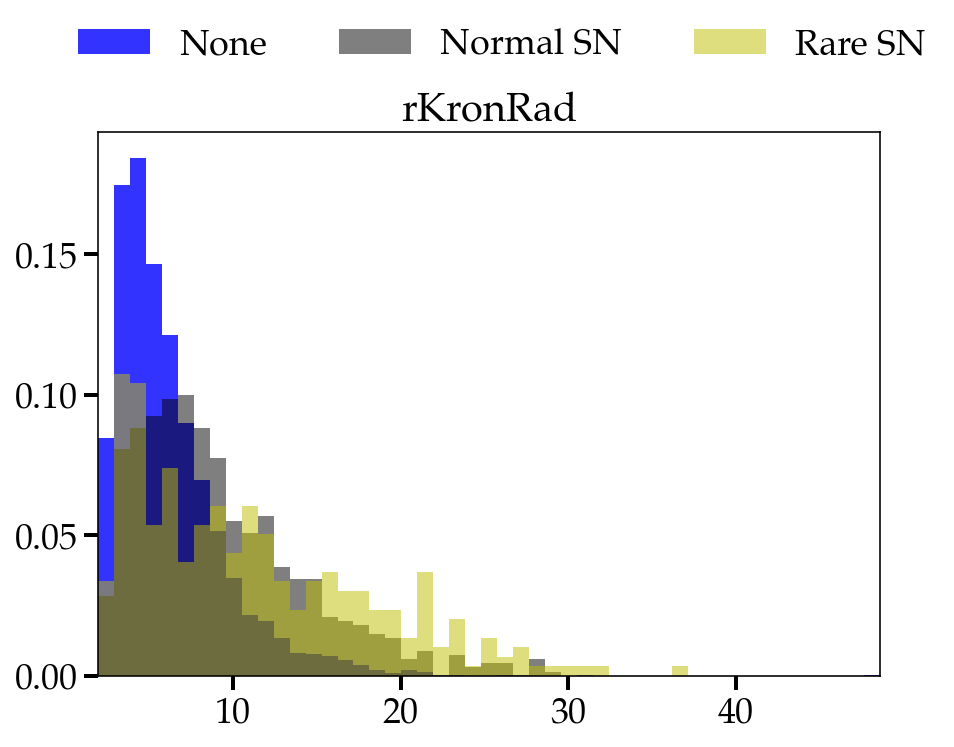

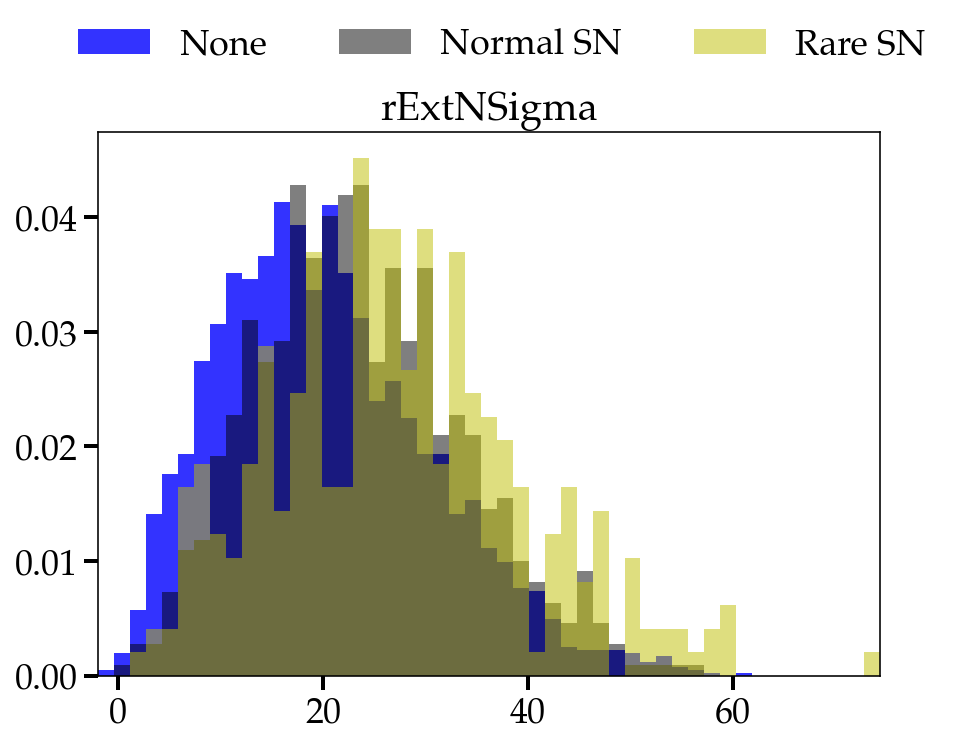

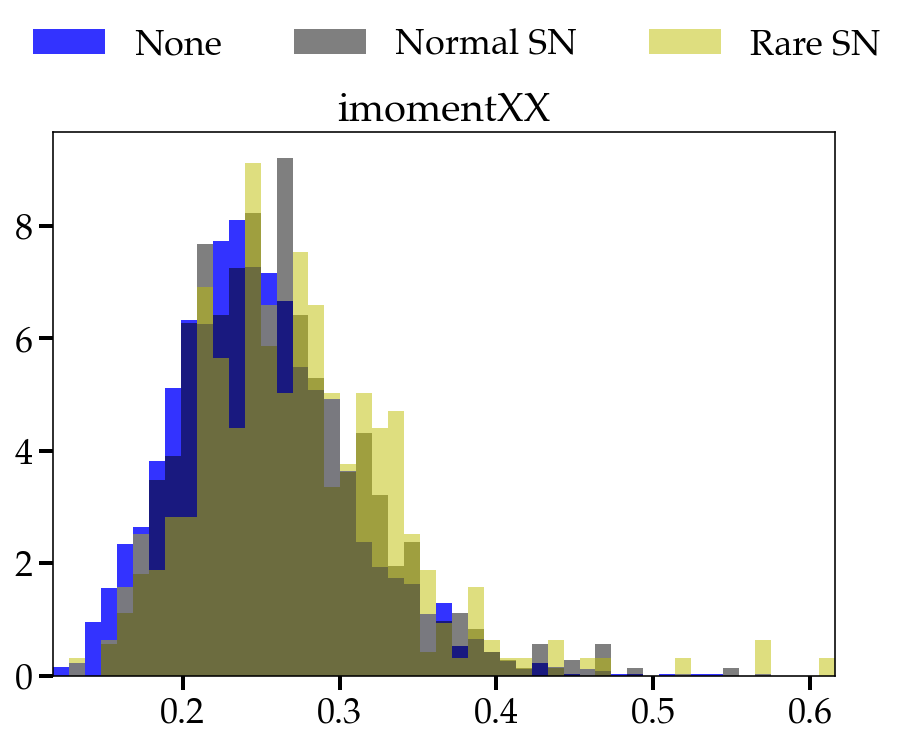

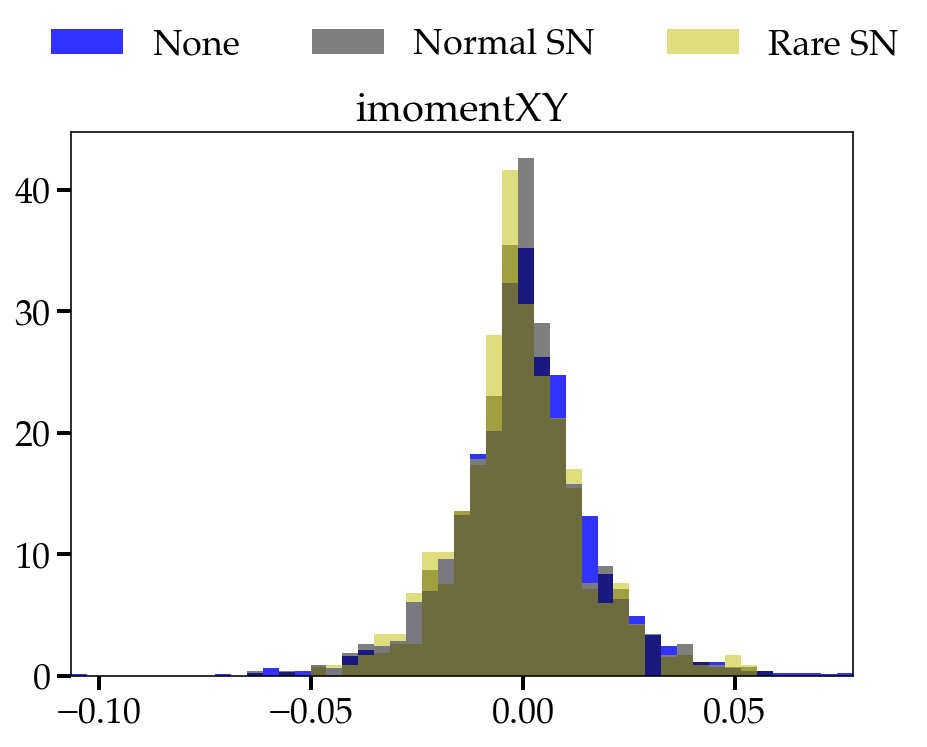

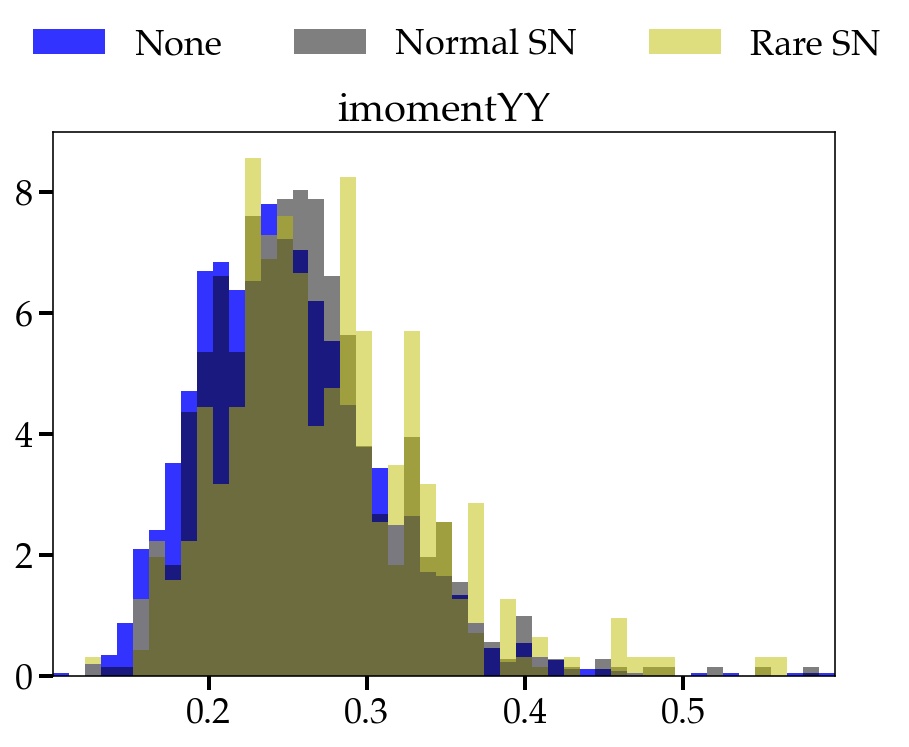

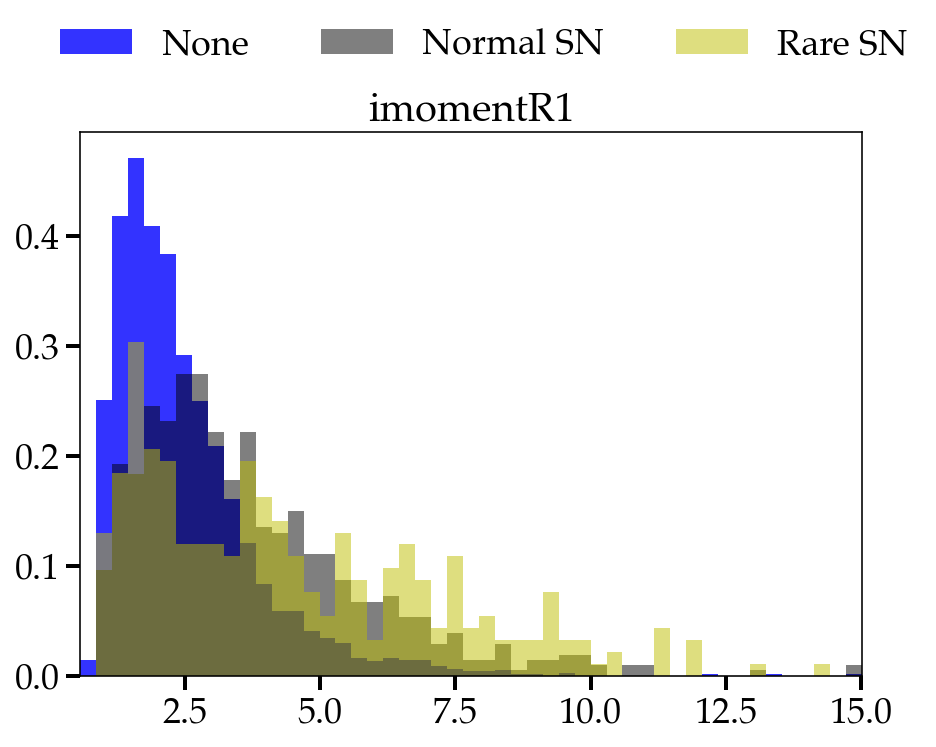

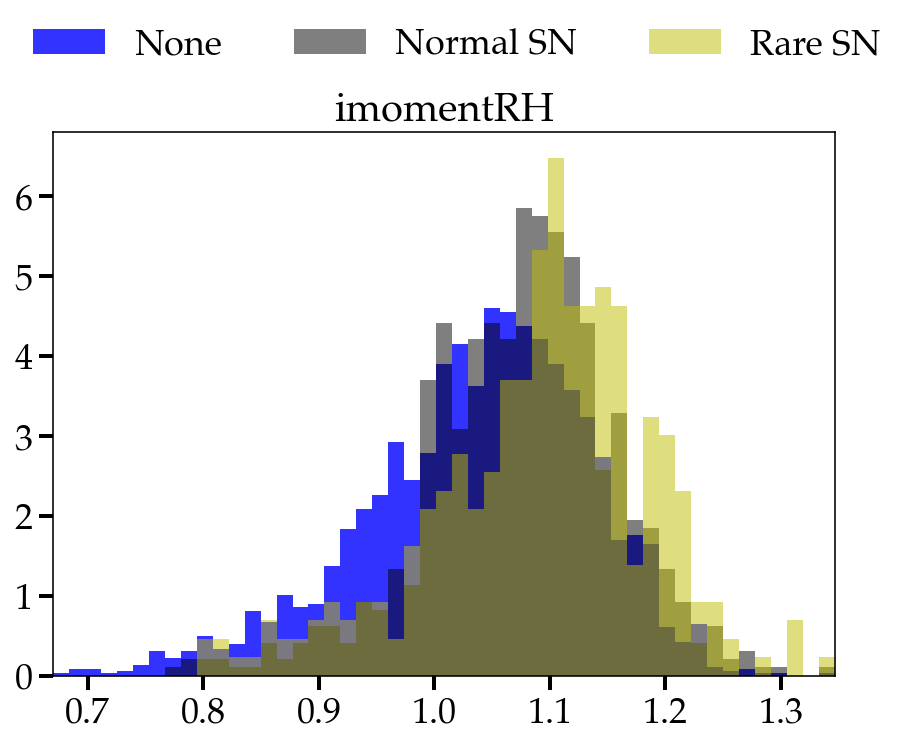

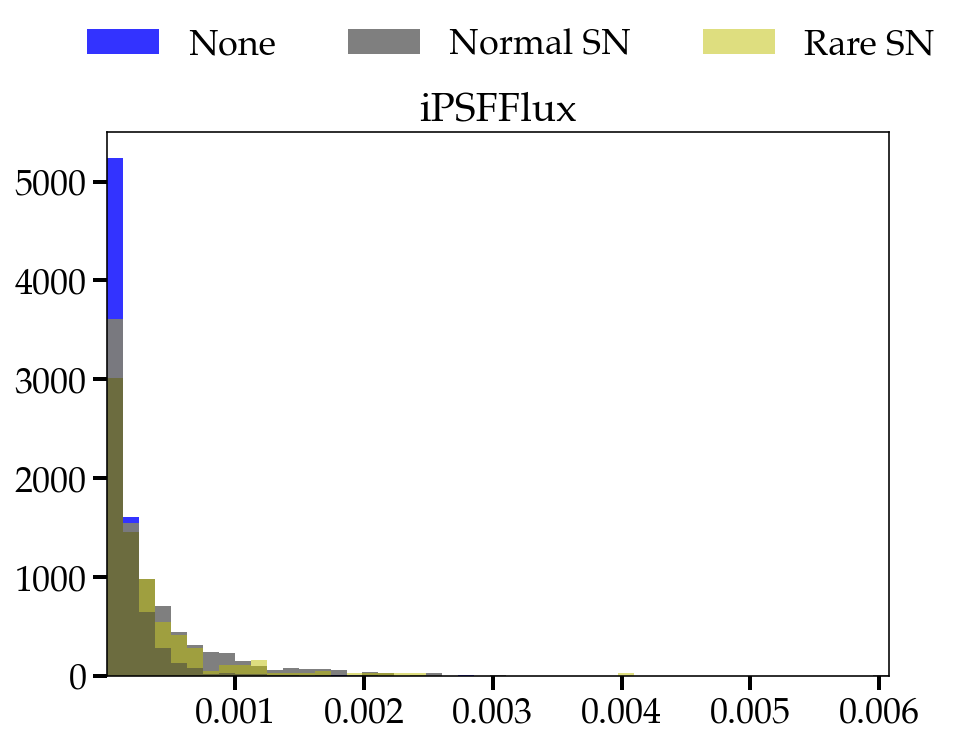

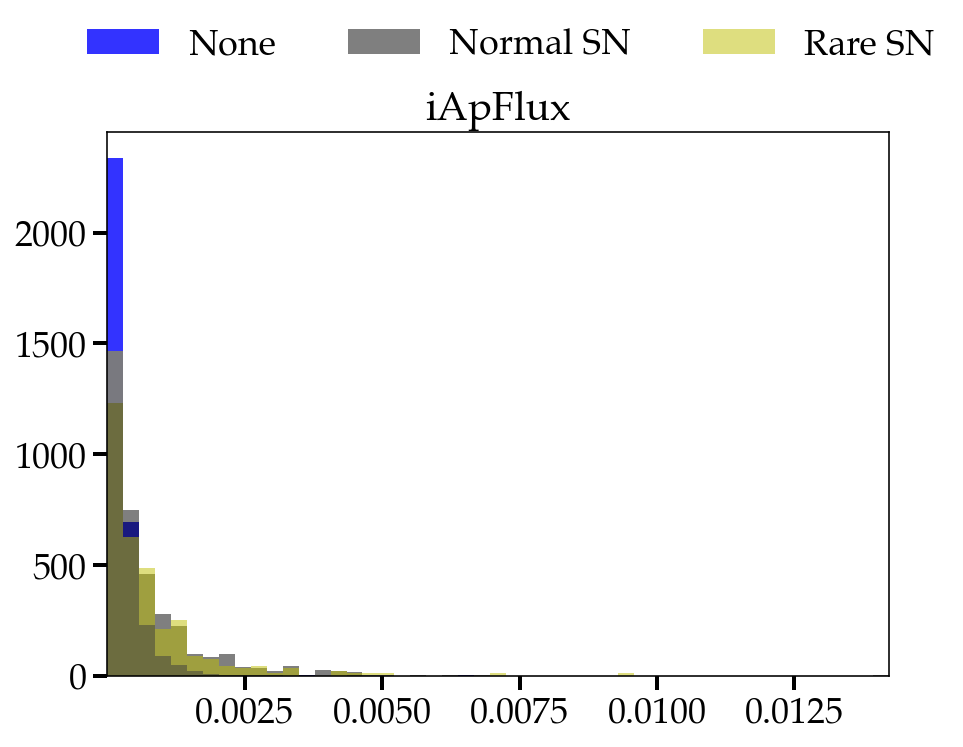

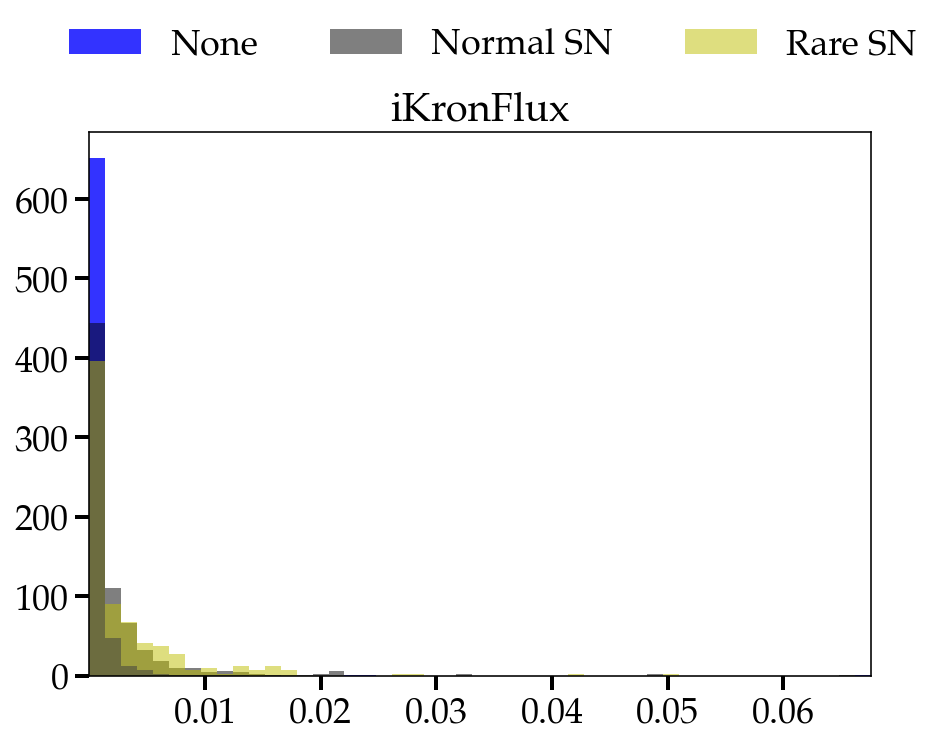

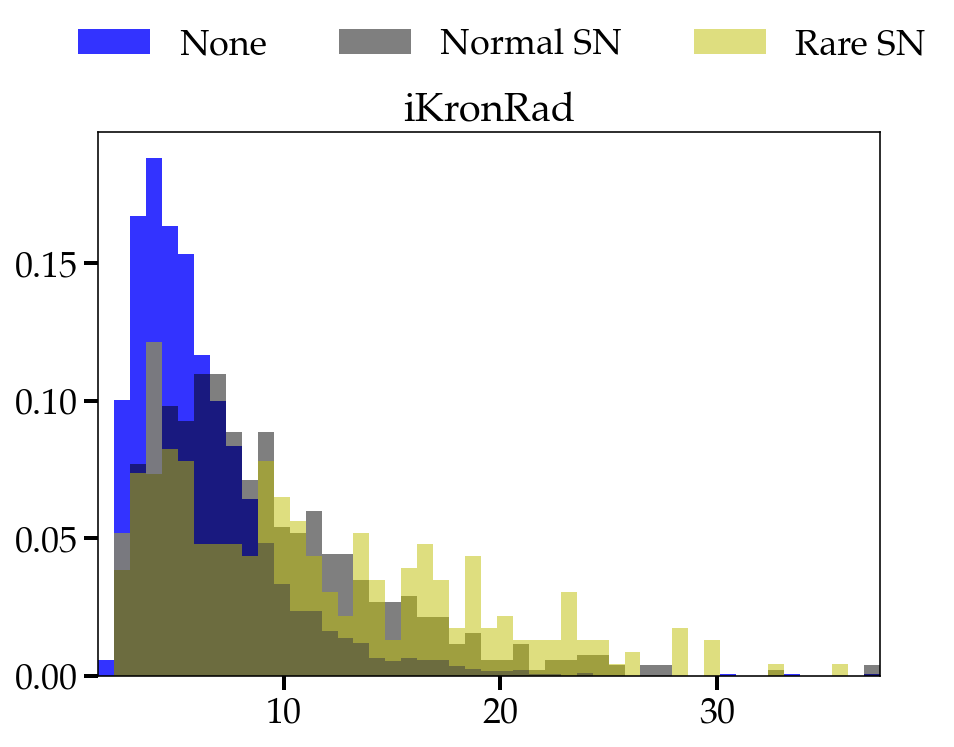

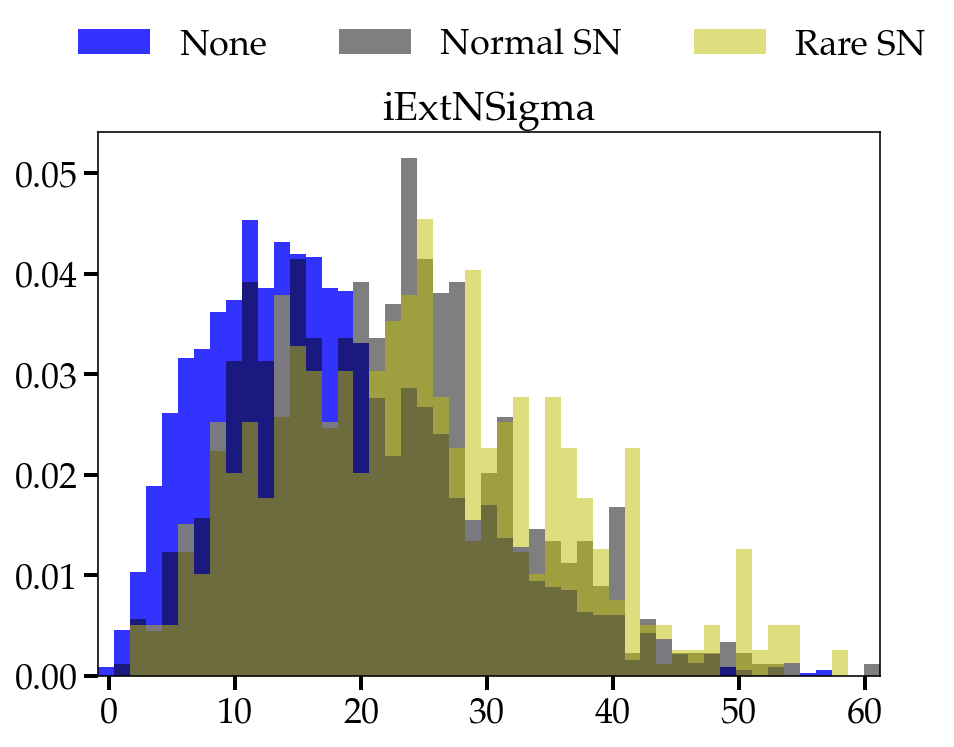

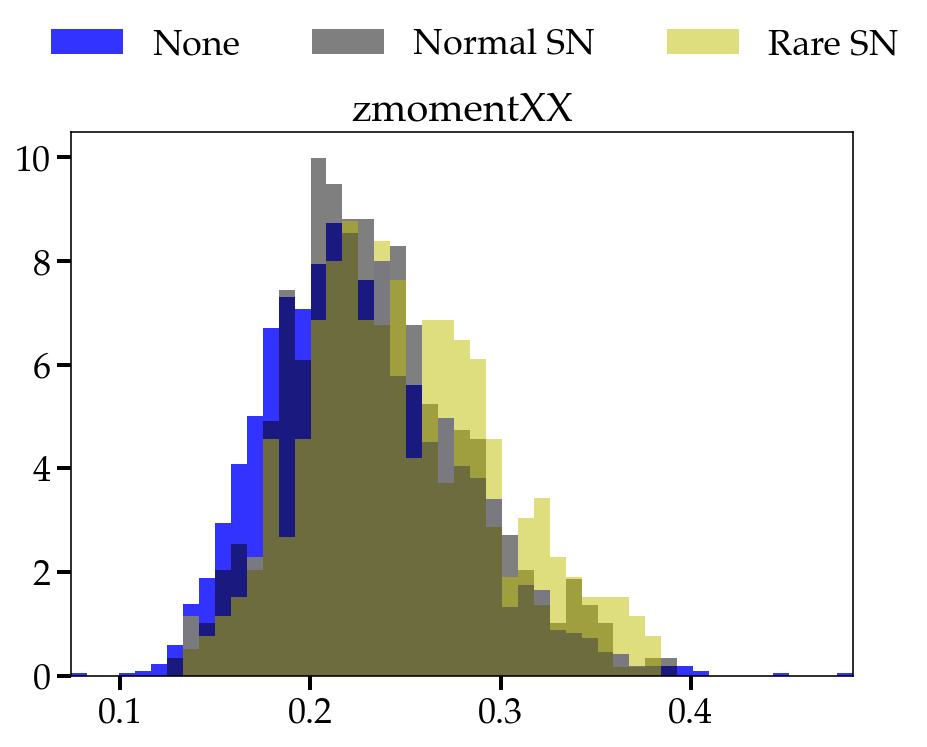

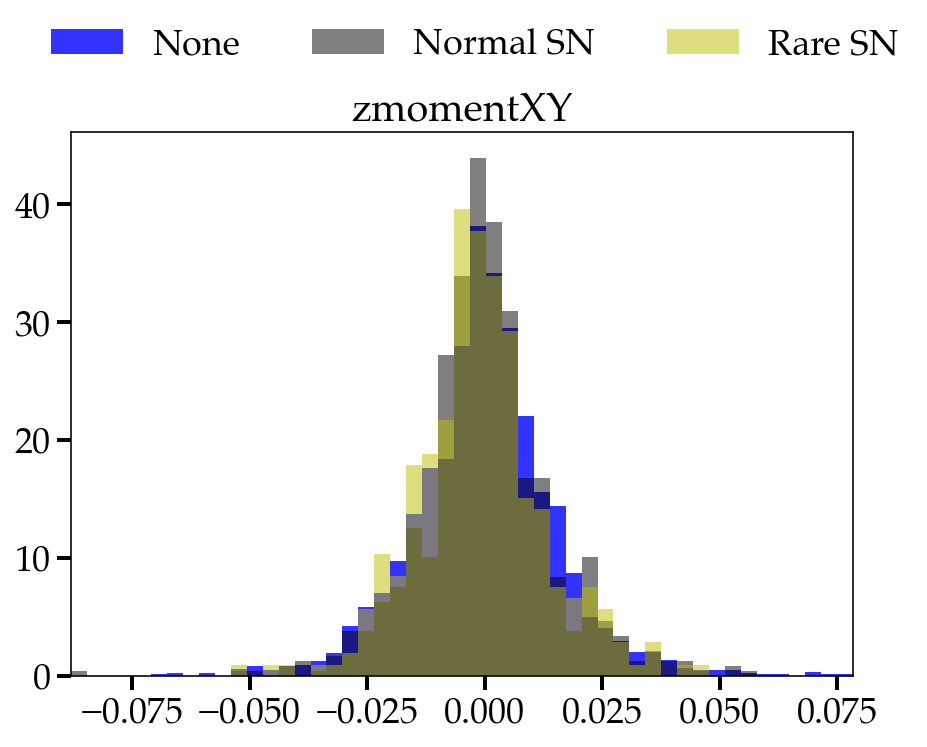

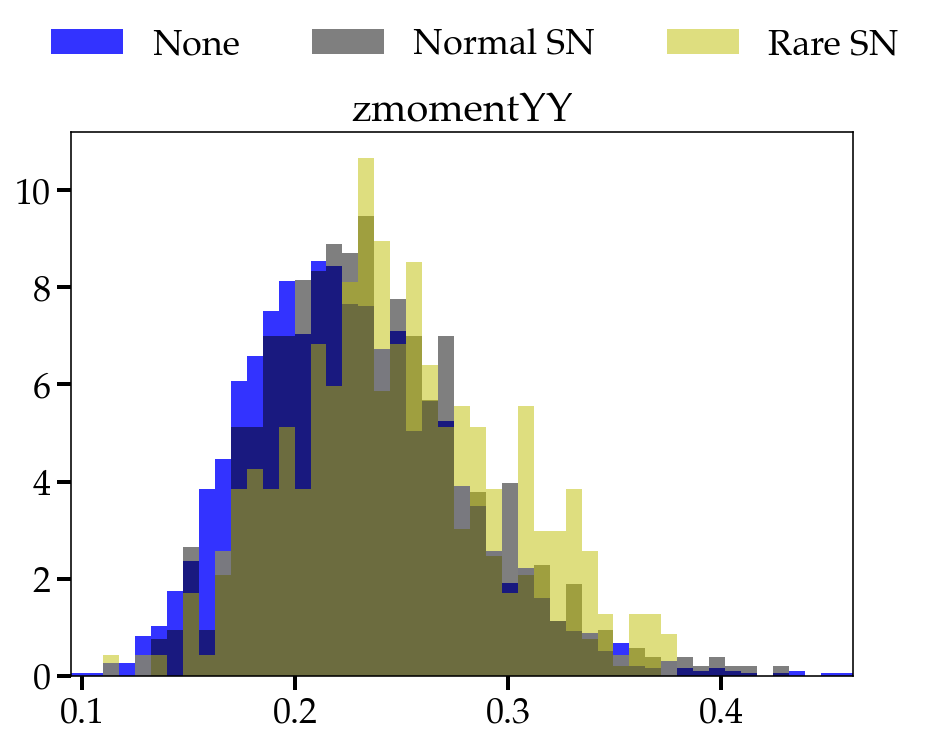

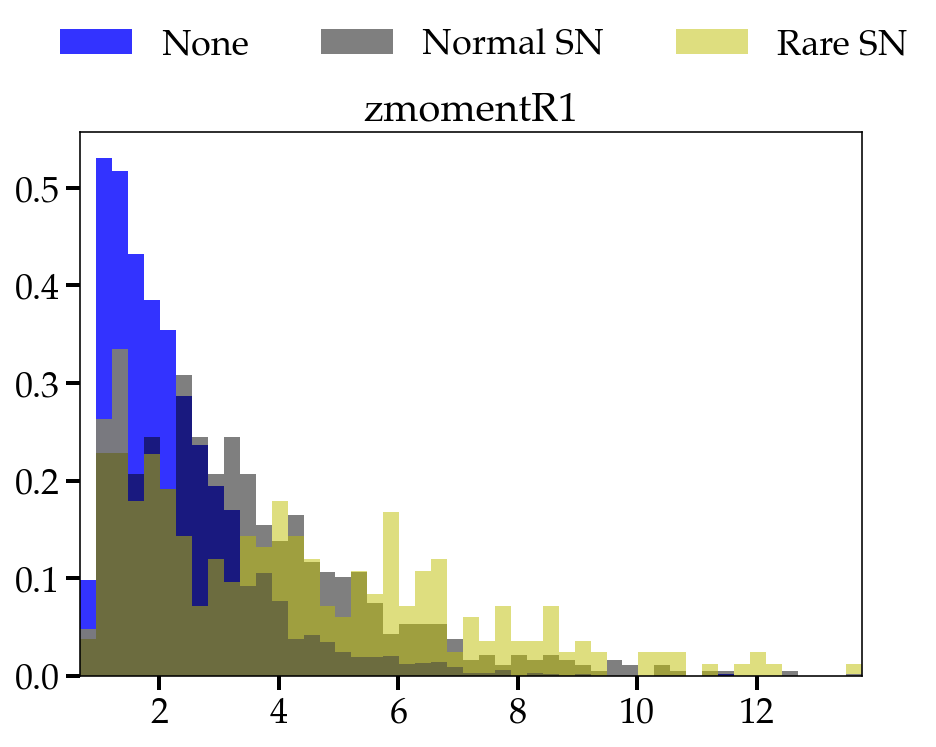

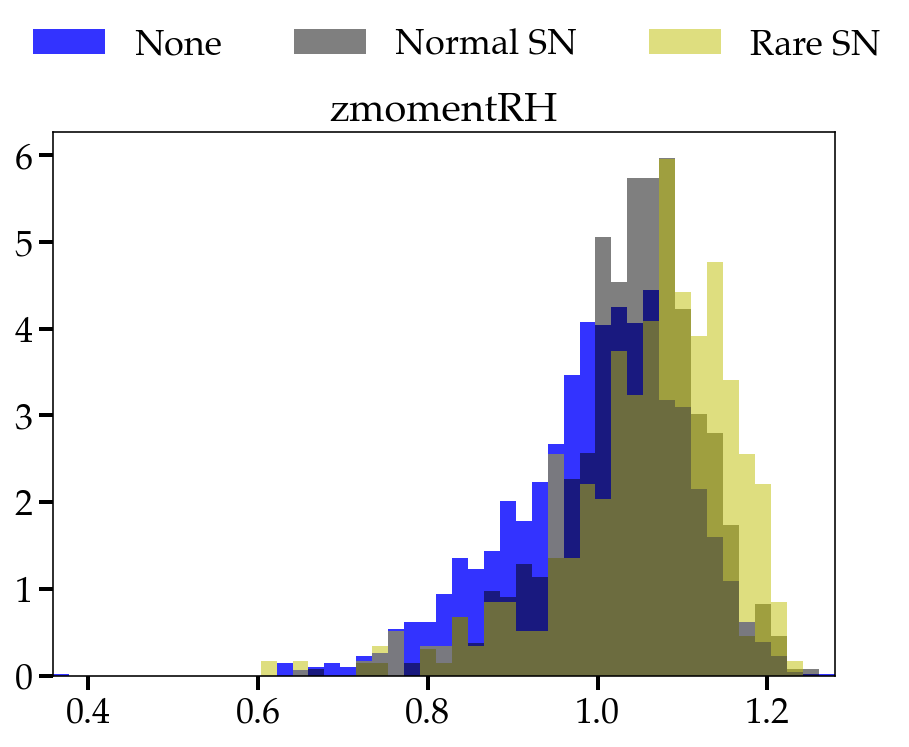

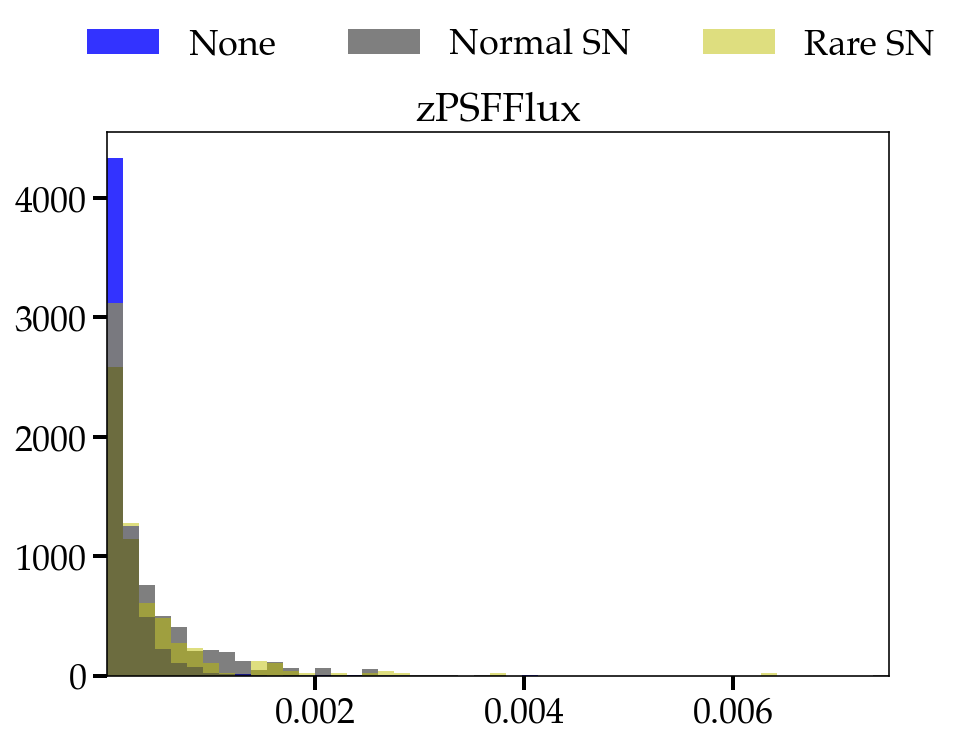

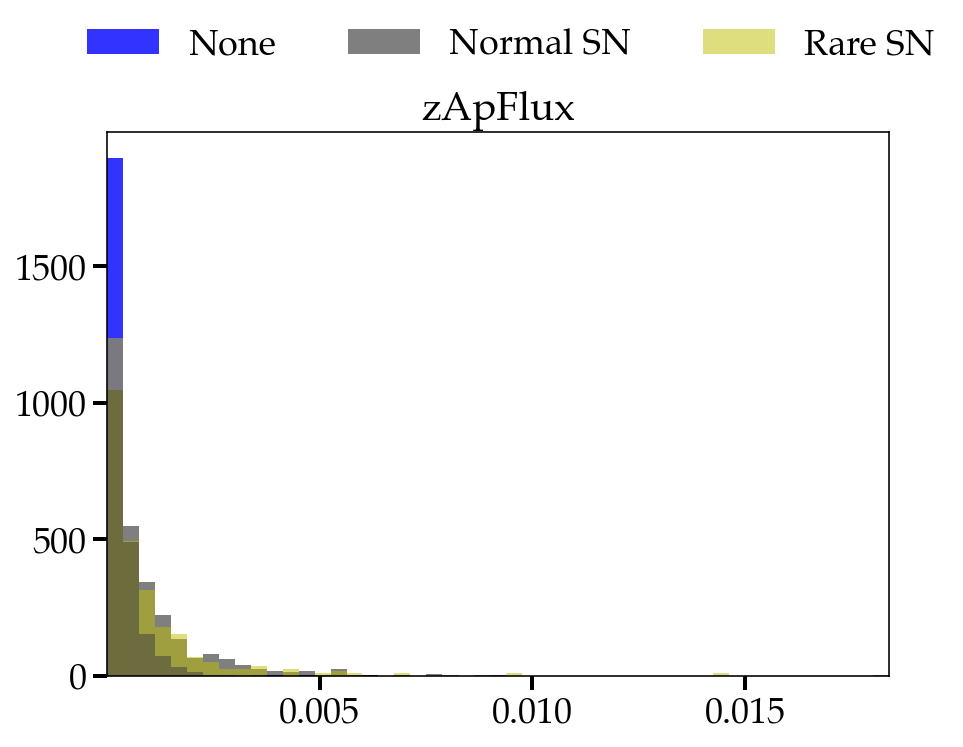

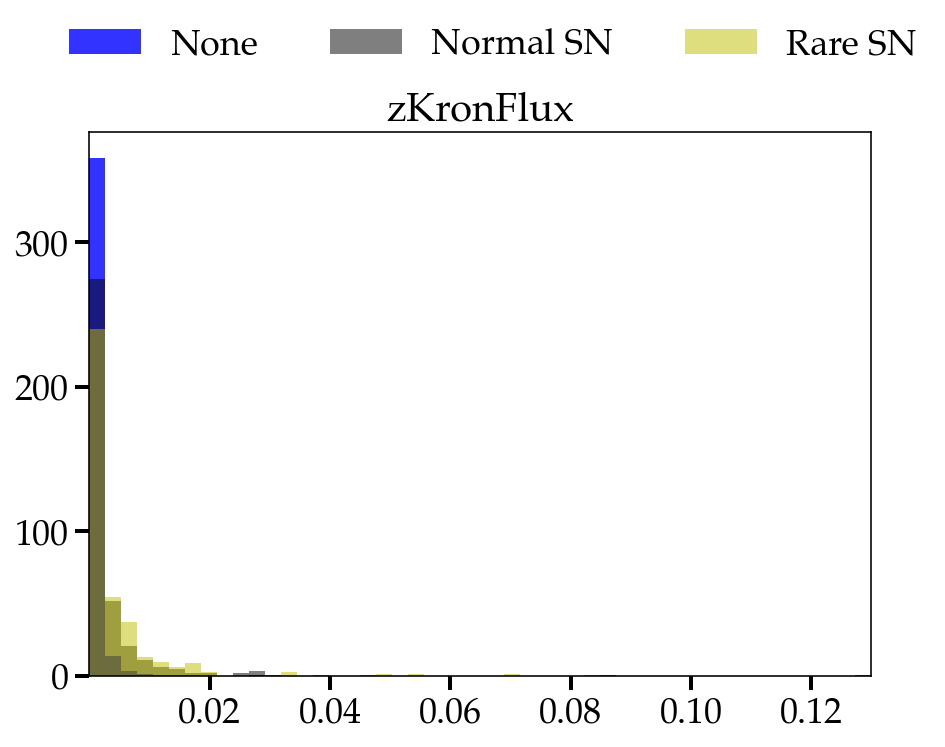

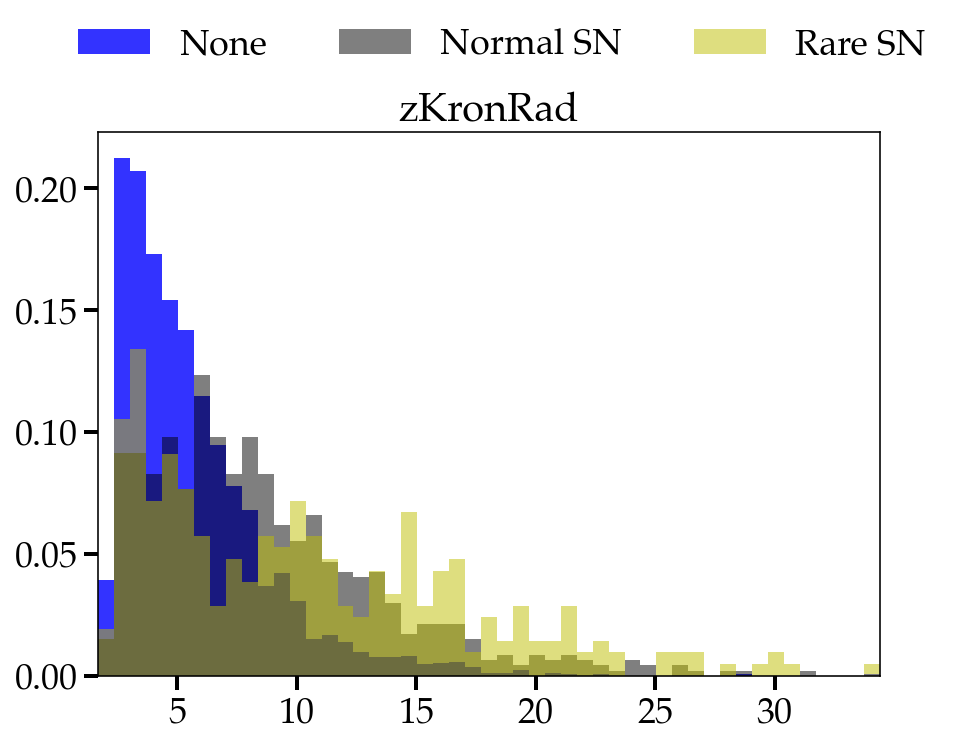

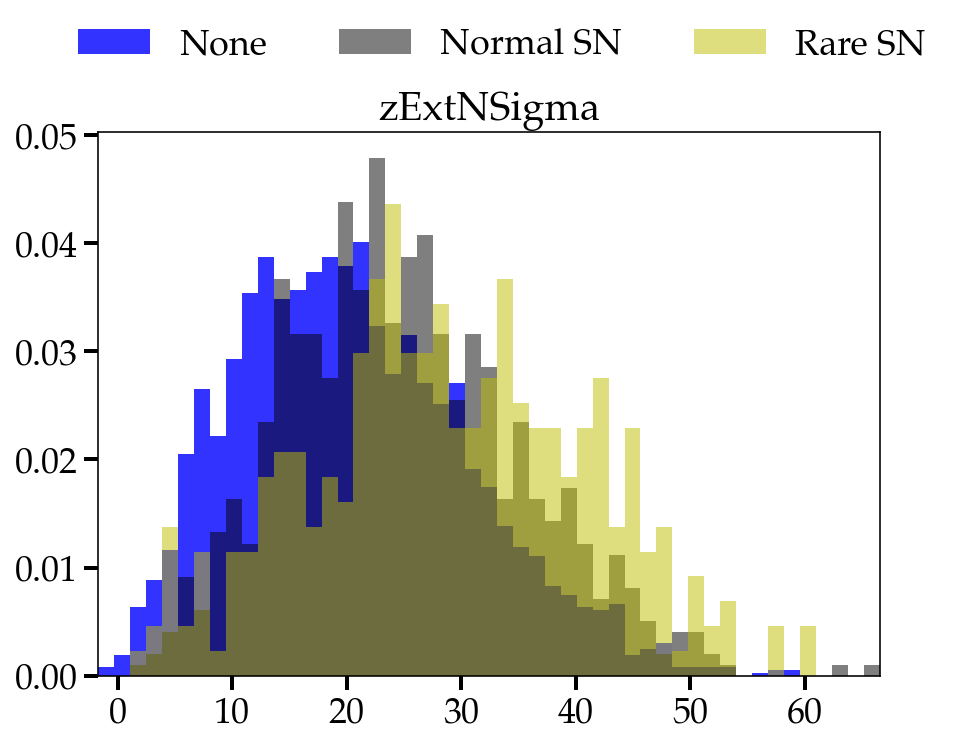

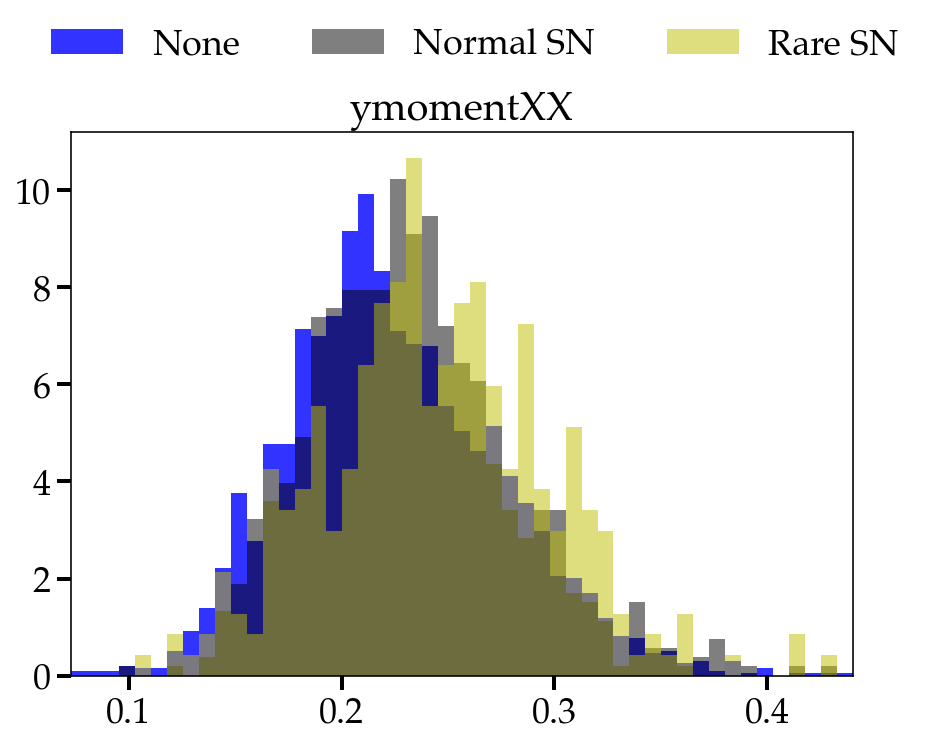

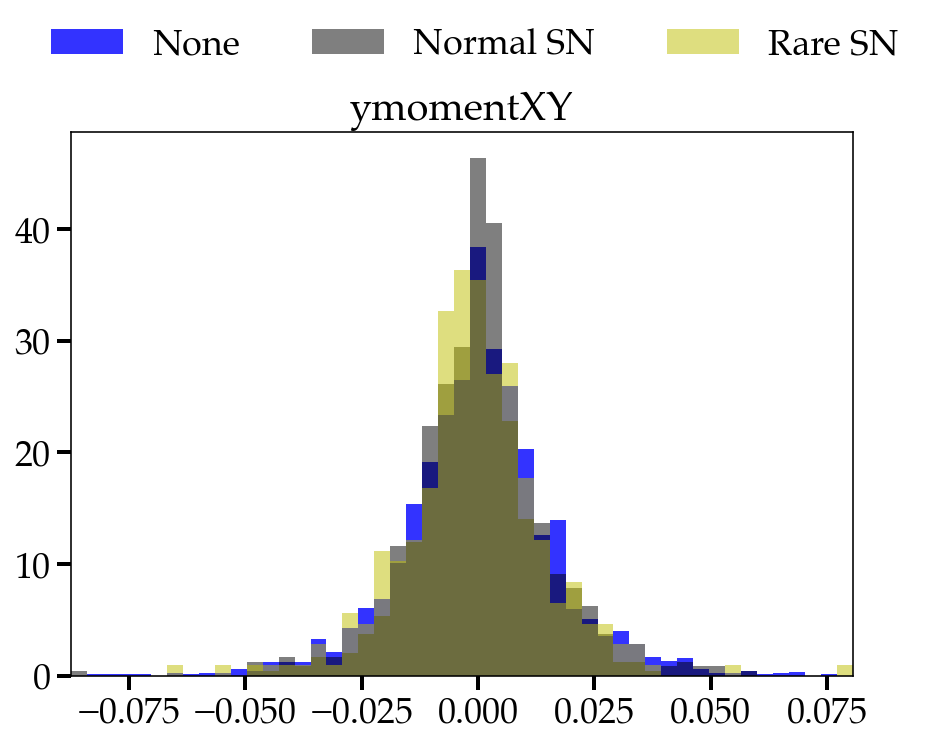

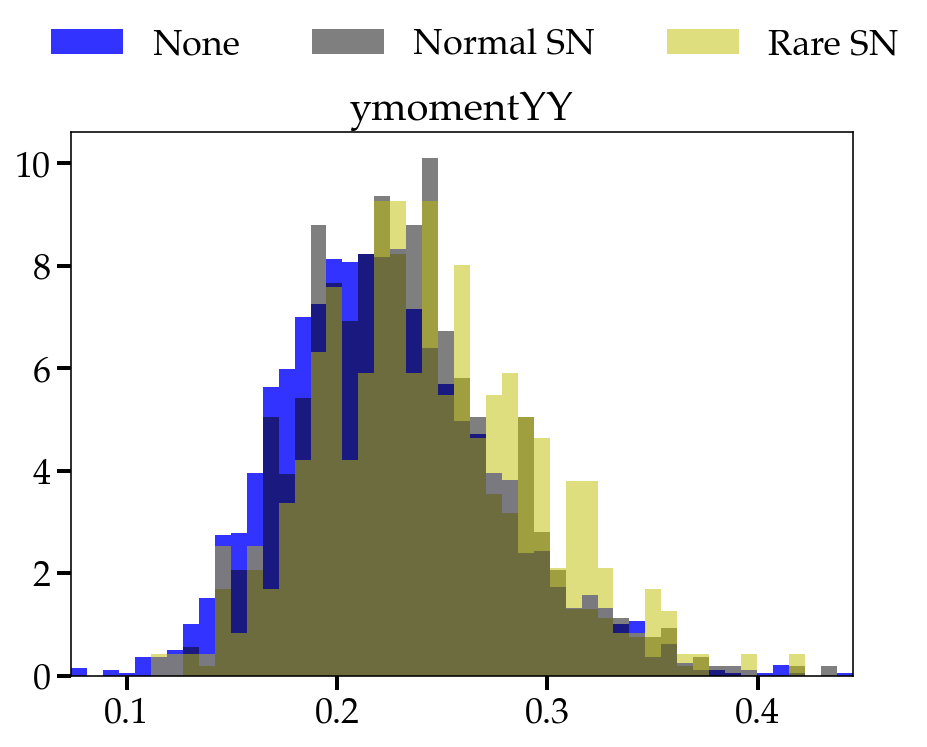

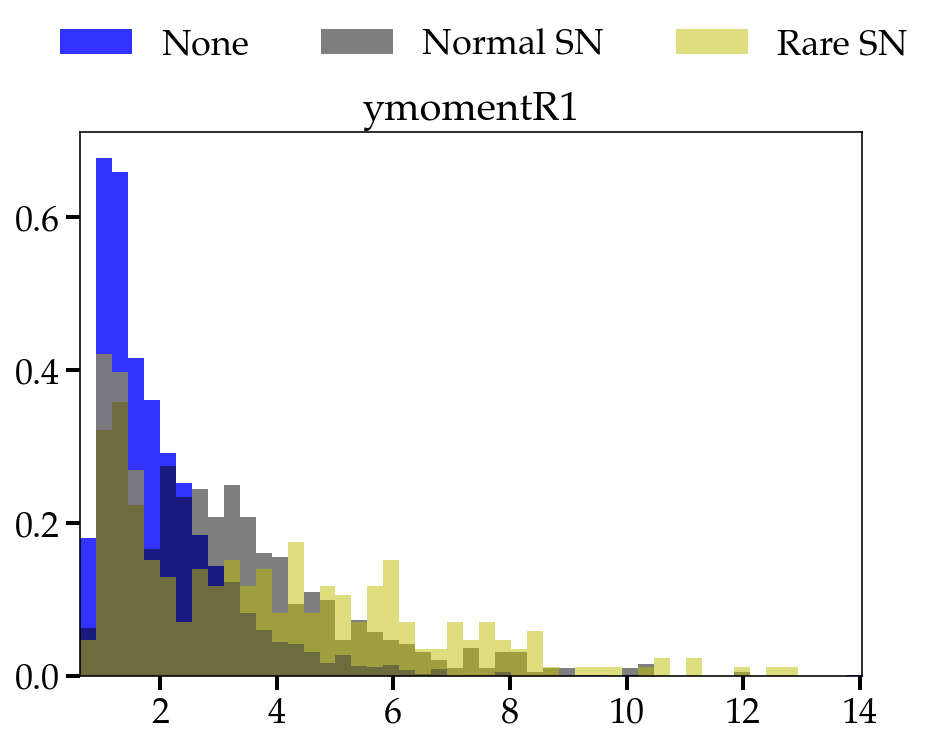

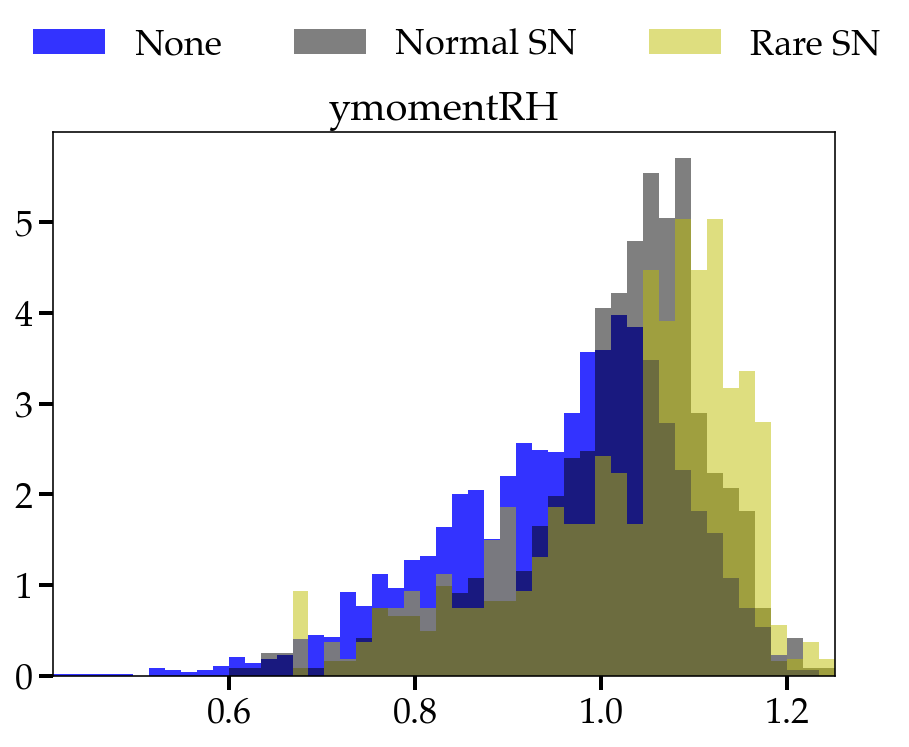

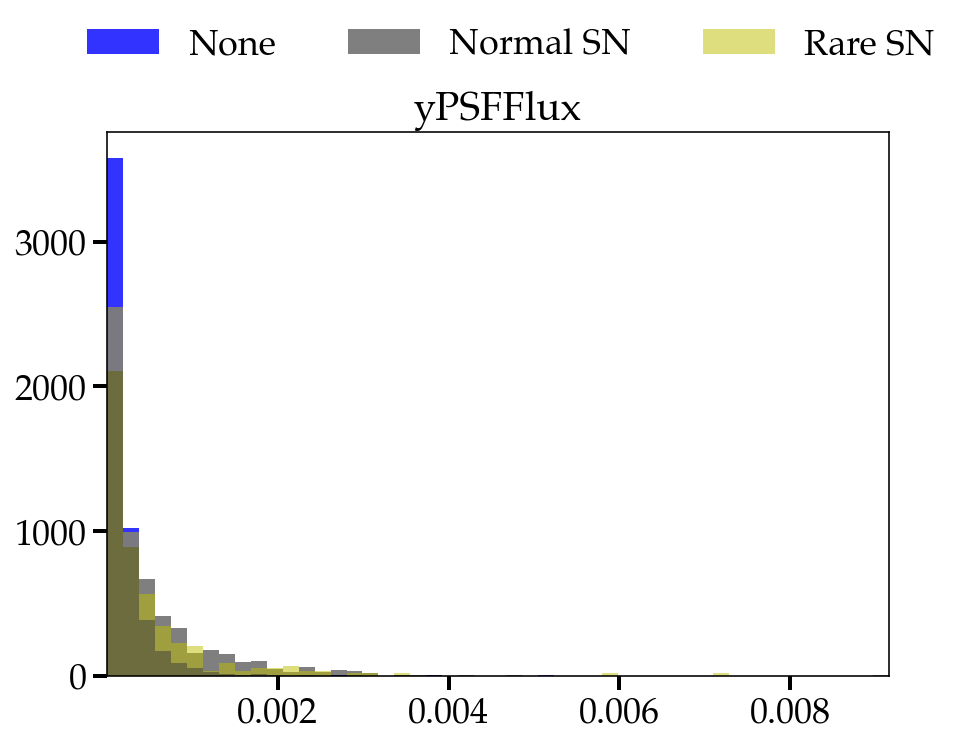

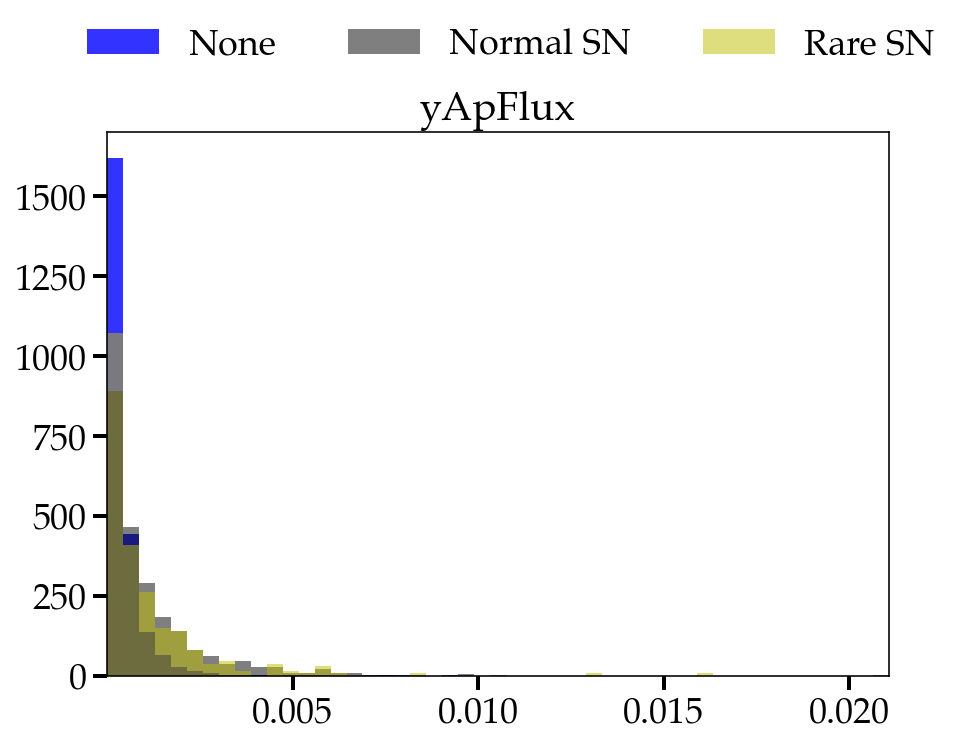

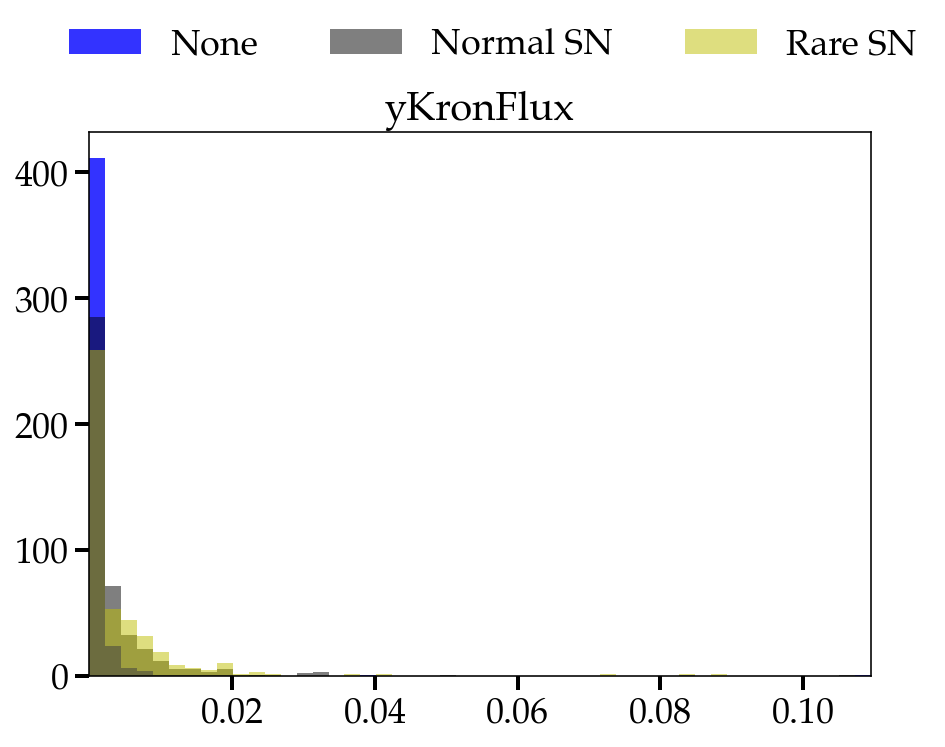

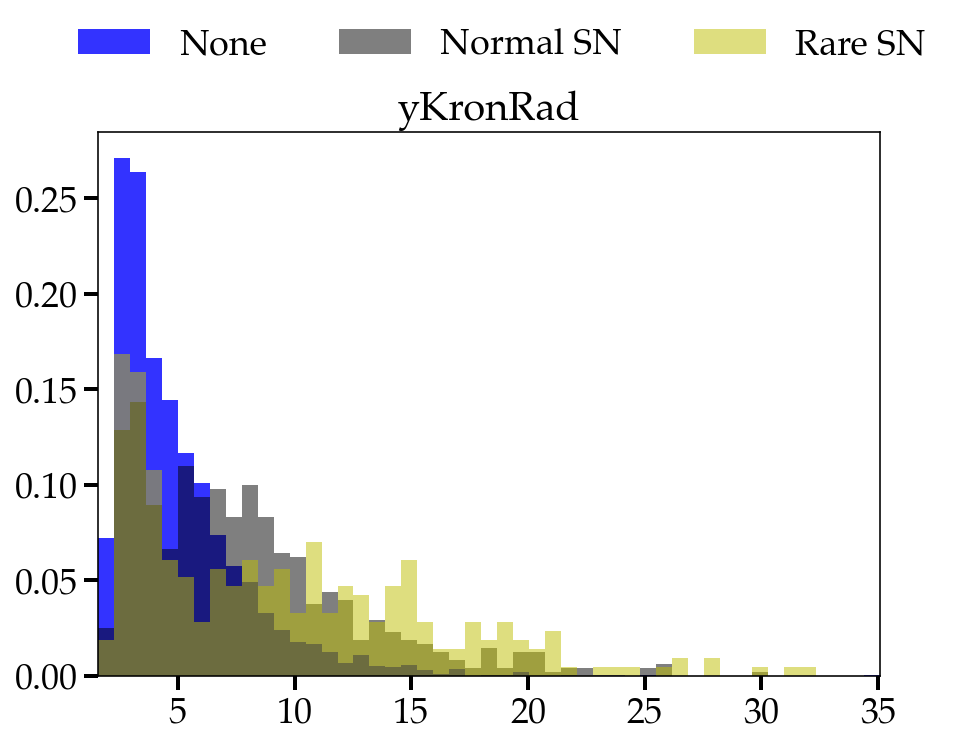

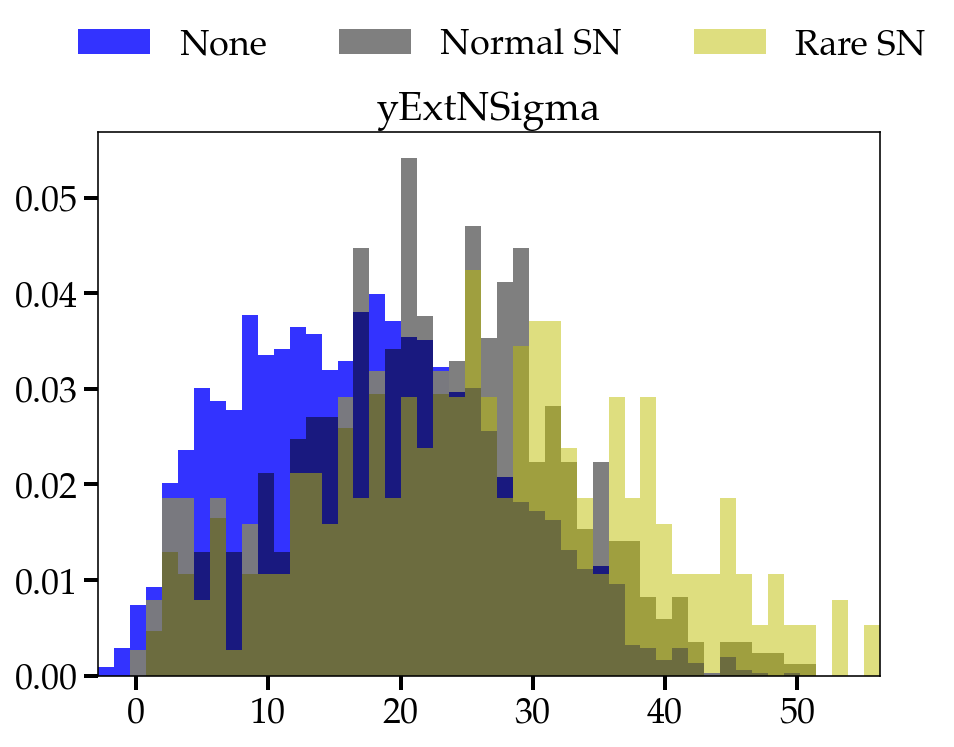

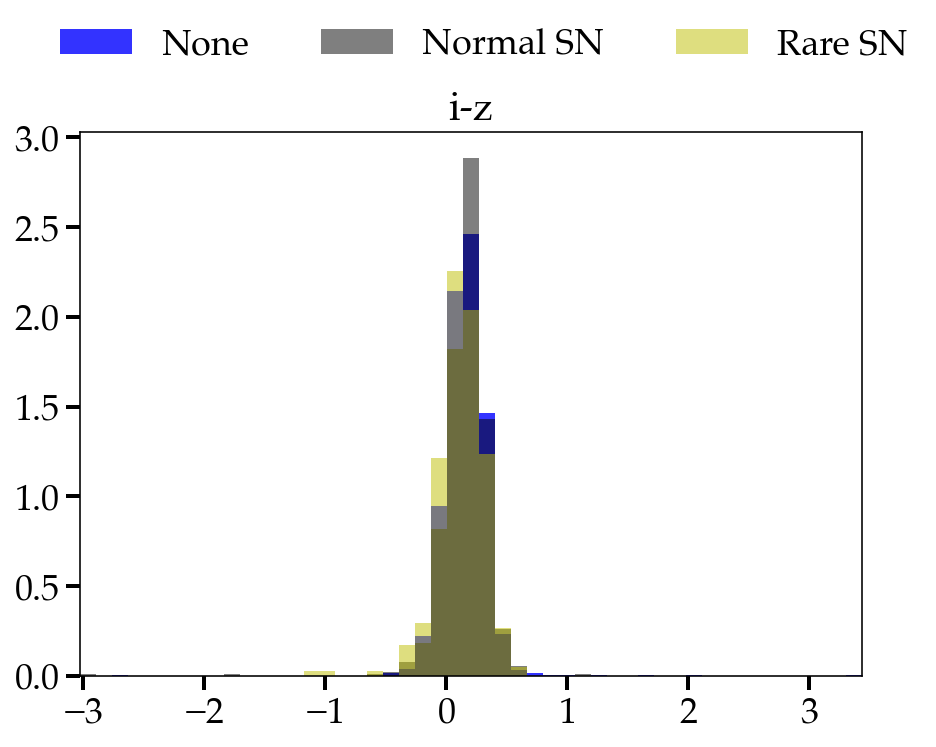

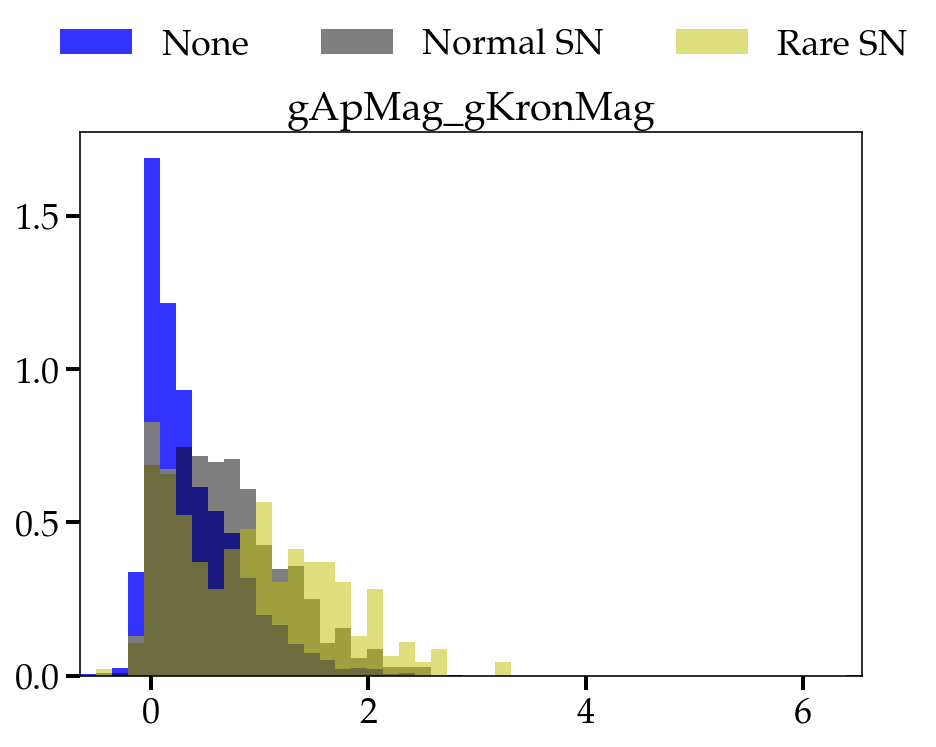

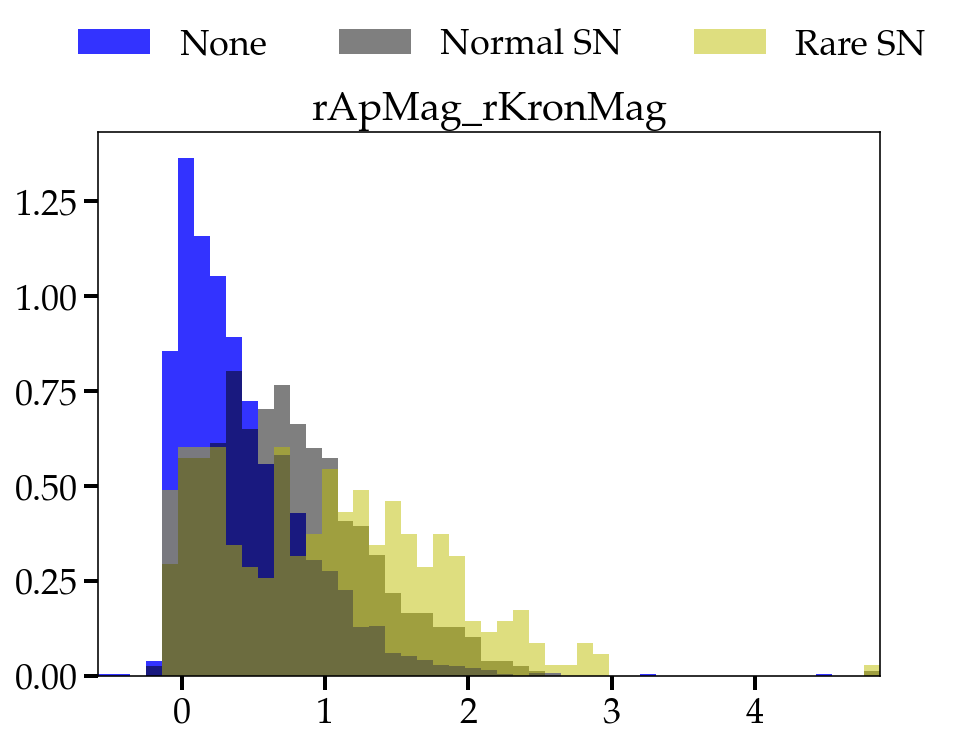

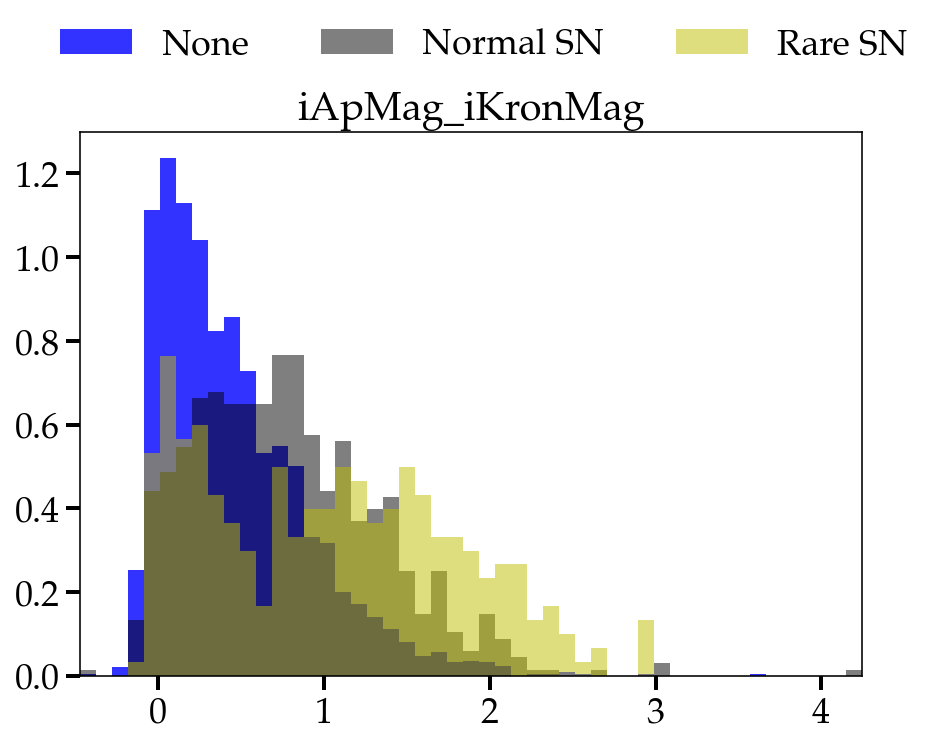

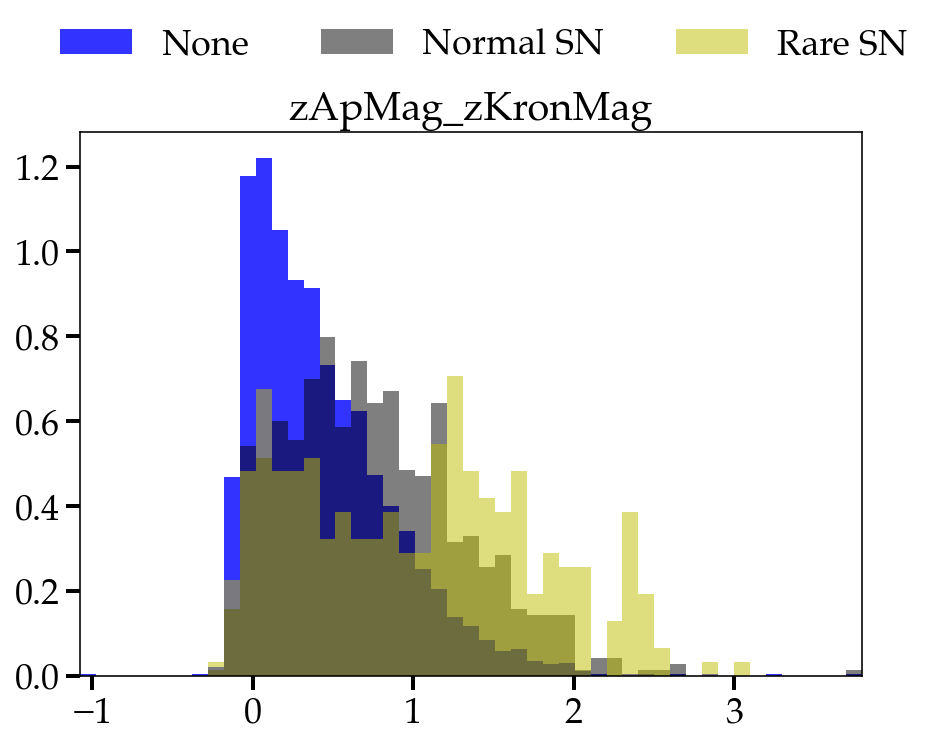

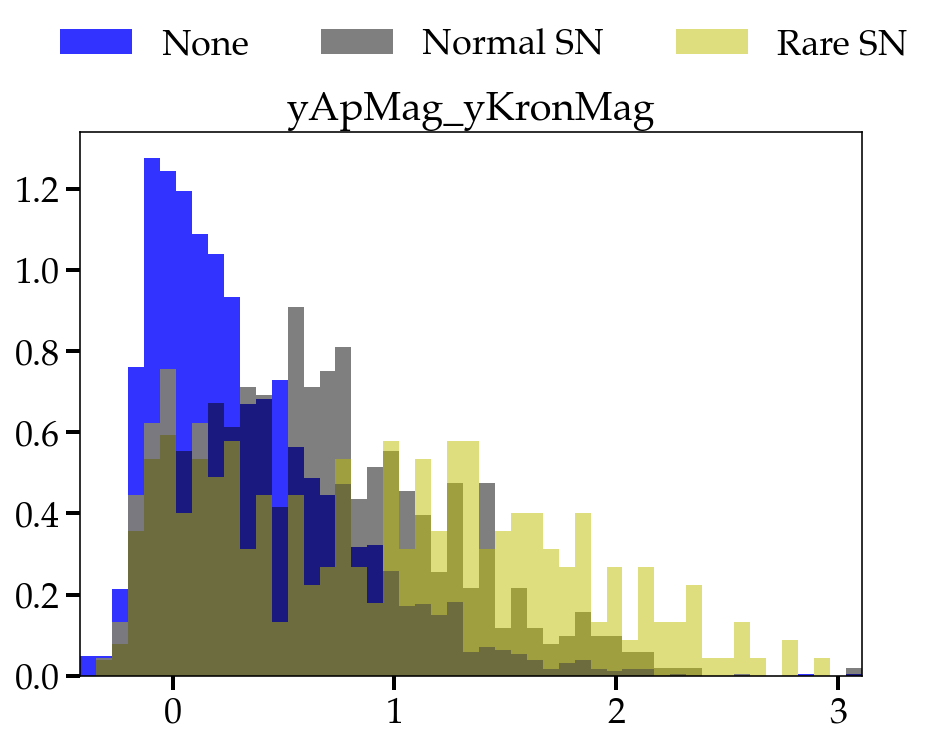

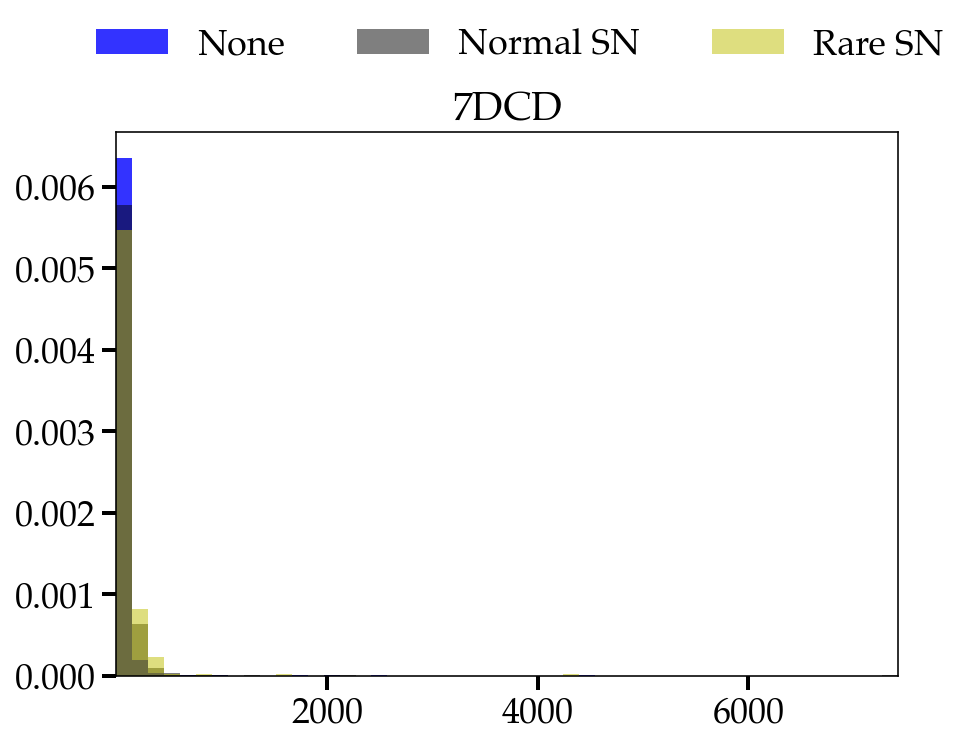

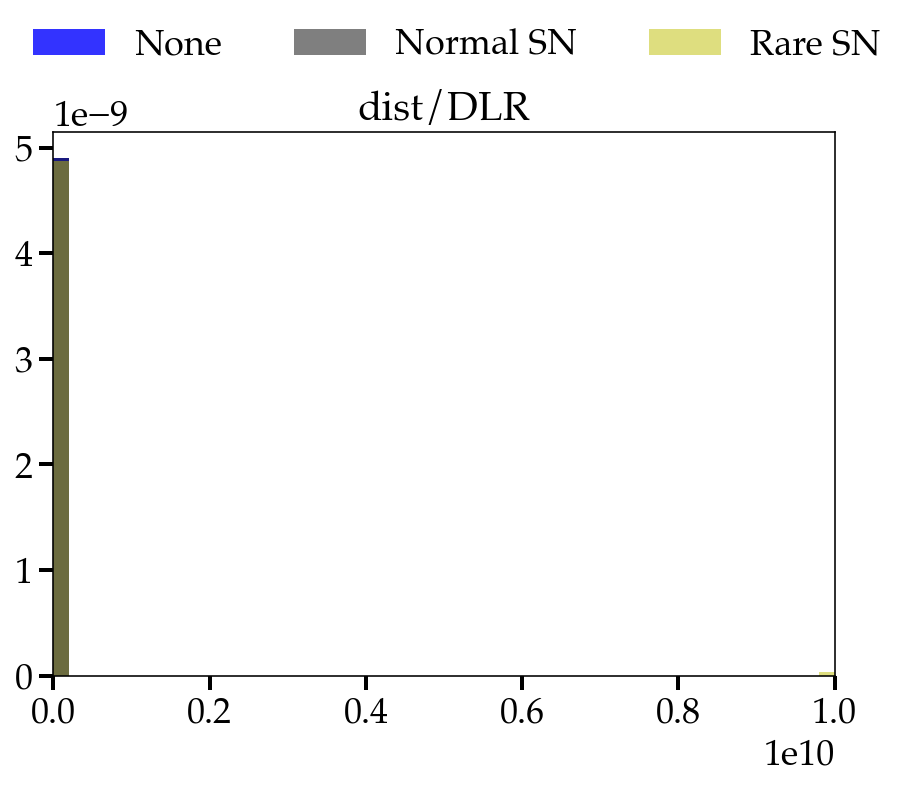

In [56]:
feat_scatter_l = []

none_sn_l = ['None']
none_sn_df = bank_and_tns_df[bank_and_tns_df.tns_cls.isin(none_sn_l)]

normal_sn_l = ['SN', 'SN I', 'SN Ia']
normal_sn_df = bank_and_tns_df[bank_and_tns_df.tns_cls.isin(normal_sn_l)]

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE', 'SN II']
rare_sn_df = bank_and_tns_df[bank_and_tns_df.tns_cls.isin(rare_sn_l)]


for feat in bank_and_tns_df.columns[0:120]:
    fig, ax = plt.subplots()
    
    min_feat, max_feat = np.min(bank_and_tns_df[feat]), np.max(bank_and_tns_df[feat])

    ax.hist(none_sn_df[feat], bins=np.linspace(min_feat, max_feat, 50), color="b", alpha=0.8,
            label="None", density=True)  
    ax.hist(normal_sn_df[feat], bins=np.linspace(min_feat, max_feat, 50), color="k", alpha=0.5,
            label="Normal SN", density=True) 
    ax.hist(rare_sn_df[feat], bins=np.linspace(min_feat, max_feat, 50), color="y", alpha=0.5,
            label="Rare SN", density=True)

        
    #ax.hist(bank_and_tns_df[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend(ncol=3, bbox_to_anchor=(1.1, 1.25), frameon=False)
    plt.show()
    
    feat_scatter = np.std(bank_and_tns_df[feat])
    feat_scatter_l.append(feat_scatter)  

feature_linear_fit_slope_sigma_magn_r, feature_linear_fit_slope_sigma_magn_g best separates if it's Ia vs Non Ia (rare). feature_anderson_darling_normal_flux_r, feature_anderson_darling_normal_flux_g is ok too. [g,r,i,z,y]ExtNSigma is ok. Any mag differences are ok.

feat_scatter_l = []
for feat in dataset_bank_pca.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank_pca[feat]), np.max(dataset_bank_pca[feat])
    
    ax.hist(dataset_bank_pca[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(dataset_bank_pca[feat])
    feat_scatter_l.append(feat_scatter)    

In [57]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 1956054.4348979043
Scatter median: 0.20690748939152726
Scatter std: 21338006.800573014
Scatter max: 234726227.72240815
Scatter min: 0.00011760809415744497


In [ ]:
%%time

ann_num = 350

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index)):
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=ann_num, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, ann_num)]
# sum specific columns
ann_dist_all_df[f'Mean-{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))
ann_dist_all_df[f'Max-{len(col_list)}ANNs'] = np.max(ann_dist_all_df[col_list].iloc[:, -1:], axis=1)

# save only last two columns to save room
ann_dist_all_df = ann_dist_all_df.iloc[:, -2:]

# weighted distance of first 9 ANNs
#weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
#ann_dist_all_df[f'WeightedMean-{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df.to_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv')
ann_dist_all_df

In [ ]:
ann_dist_all_df = pd.read_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv')
ann_dist_all_df = ann_dist_all_df.set_index('key_0')
ann_dist_all_df

In [ ]:
# Pick distance metric. 
# Weighted mean of first 9 ANNs (Fibonacci), OR Mean of first 9 ANNs, OR distance to first ANN. 
# TODO: EXPLORE DIFFERENT METRICS!
col_list= [f'dist={col}' for col in range(1, ann_num)]

#dist_col = f'WeightedMean-{len(col_list)}ANNs'  # f'Mean_{len(col_list)}ANNs' # 'dist=1' # 'Max-{len(col_list)}ANNs'
dist_col = f'Max-{len(col_list)}ANNs'


print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of mean distance of 9 ANNs
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

# XXXXX

# Largest distance


### either bogus (bright "obs" at core which aren't real)
### intense variable star
### bright/ nearby SN
### big gaps
### quick rise and then no obs until much later
### some truly weird ones (20acct)

In [ ]:
ref_obj = ann_dist_all_df[[dist_col]].idxmax().values[0] #'ZTF18acbwaxk'
print("Max dist", ann_dist_all_df.loc[ref_obj][dist_col]) 

In [ ]:
dataset_bank[dataset_bank.index == ref_obj]

In [ ]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [ ]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# scaler ONLY, NO PCA
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# # what I normally use
# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # tns
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean

    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z

    if math.isnan(ra_i) or math.isnan(dec_i):
        print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
    else: print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

In [ ]:
antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

In [ ]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean

if math.isnan(ra_ref) or math.isnan(dec_ref):
    has_host_ref = "No host assoc"
else: has_host_ref = "Has host"    
    
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)},\t{has_host_ref}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue   
        
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
        
    if math.isnan(ra_i) or math.isnan(dec_i):
        has_host_i = "No host assoc"
    else: has_host_i = "Has host"
        
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r = df_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g = df_g[['ant_mag']].reset_index().idxmin().ant_mag

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[mjd_idx_at_min_mag_r], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)},\t{has_host_i}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[mjd_idx_at_min_mag_g], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    #plt.xlabel('Days of event') # make iloc[0]
    plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
        plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
tns_cls_ref_nospace = tns_cls_ref.replace(' ','')

folder_path = f"../figures/{tns_cls_ref_nospace}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

suffix=suffix
plt.savefig(f'../figures/{tns_cls_ref_nospace}/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_manhattan_90k_{suffix}.jpg', dpi=150, bbox_inches='tight')
#plt.savefig(f'../figures/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_euclidean.jpg', dpi=150, bbox_inches='tight')


host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df, tns_cls_ref=tns_cls_ref_nospace, suffix=suffix, save_pdf=True)

In [ ]:
ann_dist_all_df.loc[ref_obj]

In [ ]:
# 100 largest distances
ann_dist_all_df[dist_col].nlargest(100)

In [ ]:
# Very few leakage of stars and bogus! :) 
# 100 largest distances objs 
for ztfid in list(ann_dist_all_df[dist_col].nlargest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}'
    
    # tns
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[ztfid].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztfid].decMean
    
    has_tns_i = dataset_bank_tns_df.loc[ztfid].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[ztfid].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[ztfid].spec_z

    if math.isnan(ra_i) or math.isnan(dec_i):
        print(f"{alerce_link}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\tNo host gal association!\n")
    else: print(f"{alerce_link}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

In [ ]:
# suffix="hasTNS_35pca_noCadence_NOtransf_fill_median_SS"
# 

In [ ]:
# suffix="hasTNS_25pca_noCadence_NOtransf_HasHostGalOnly_SS"
# Still v good results (not as good as NOpca but still nice.)

In [ ]:
# Weird transients to test (suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"):
# Finds more bogus host gal matches actually


In [ ]:
# Weird transients to test (suffix="hasTNS_NOpca_noCadence_NOtransf_fill_median_SS"):
# More pure transients (having option for no host gal removes more bogus than true transients)
# https://alerce.online/object/ZTF20acyroek 2020adey
# https://alerce.online/object/ZTF21aaaodzf 2021dz
# https://alerce.online/object/ZTF20abxyggc 2020sgg
# https://alerce.online/object/ZTF21aarrwdu

In [ ]:
# Weird transients to test:
# https://alerce.online/object/ZTF20acyroek
# https://alerce.online/object/ZTF21aaydxoo
# https://alerce.online/object/ZTF18abwxrhi
# https://alerce.online/object/ZTF20abjonjs
# https://alerce.online/object/ZTF21aaabwfu
# https://alerce.online/object/ZTF20acynjjo
# https://alerce.online/object/ZTF21aafepon
# https://alerce.online/object/ZTF21aagnzjy
# https://alerce.online/object/ZTF21aaaodzf
# https://alerce.online/object/ZTF21aaqhhfu
# https://alerce.online/object/ZTF18aaacqmh
# https://alerce.online/object/ZTF18abvmlow
# https://alerce.online/object/ZTF20acfvqjl
# https://alerce.online/object/ZTF21abfmbix
# https://alerce.online/object/ZTF20abqvsik
# https://alerce.online/object/ZTF21aazieut
# https://alerce.online/object/ZTF20acqvwzm
# https://alerce.online/object/ZTF21abbwajr
# https://alerce.online/object/ZTF21aavqphe
# https://alerce.online/object/ZTF21aaygqkb

In [ ]:
# weird flaring red star? https://alerce.online/object/ZTF19aaxoyhu

In [ ]:
# 10 largest mean 9 ANN distances distances (most different)
plt.hist(ann_dist_all_df[dist_col], 
         bins=np.linspace(np.min(ann_dist_all_df[dist_col]), 
                          np.max(ann_dist_all_df[dist_col]), 31), density=False);
plt.xlabel(dist_col+' Distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');
plt.savefig(f'../figures/{dist_col}_d_{suffix}')

In [ ]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of distance
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

# Smallest

### AGN/QSOs have smallest dist
### some stars, SN

In [ ]:
ann_dist_all_df[dist_col].nsmallest(10)

In [ ]:
# 10 smallest  distances (most similar)
for ztfid in list(ann_dist_all_df[dist_col].nsmallest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}'
    
    # tns
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[ztfid].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztfid].decMean
    
    has_tns_i = dataset_bank_tns_df.loc[ztfid].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[ztfid].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[ztfid].spec_z

    if math.isnan(ra_i) or math.isnan(dec_i):
        print(f"{alerce_link}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\tNo host gal association!\n")
    else: print(f"{alerce_link}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

In [ ]:
dataset_ref = dataset_bank[dataset_bank.index == list(ann_dist_all_df[dist_col].nsmallest(10).index)[0]]

# scaler ONLY, NO PCA
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# #what I normally use
# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # tns
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean

    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z

    if math.isnan(ra_i) or math.isnan(dec_i):
        print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\tNo host gal association!\n")
    else: print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

In [ ]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean

if math.isnan(ra_ref) or math.isnan(dec_ref):
    has_host_ref = "No host assoc"
else: has_host_ref = "Has host"    
    
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)},\t{has_host_ref}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue   
        
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
        
    if math.isnan(ra_i) or math.isnan(dec_i):
        has_host_i = "No host assoc"
    else: has_host_i = "Has host"
        
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r = df_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g = df_g[['ant_mag']].reset_index().idxmin().ant_mag

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[mjd_idx_at_min_mag_r], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)},\t{has_host_i}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[mjd_idx_at_min_mag_g], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    #plt.xlabel('Days of event') # make iloc[0]
    plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
        plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
tns_cls_ref_nospace = tns_cls_ref.replace(' ','')

folder_path = f"../figures/{tns_cls_ref_nospace}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

suffix=suffix
plt.savefig(f'../figures/{tns_cls_ref_nospace}/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_manhattan_90k_{suffix}.jpg', dpi=150, bbox_inches='tight')
#plt.savefig(f'../figures/{ztf_id_ref}_cls={tns_cls_ref_nospace}_ann={num+1}_euclidean.jpg', dpi=150, bbox_inches='tight')


host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df, tns_cls_ref=tns_cls_ref_nospace, suffix=suffix, save_pdf=True)

In [ ]:
# dist ANN=1 and mean of first 9 ANN are roughly same (SN, CV, Mira, etc). 
# Not as many SN (but otherwise similar as above) in weighted (fibonacci) average of first 9 ANN.
# Separation will come down to host gal info

MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787

# XXXX

# pandas profiling

In [ ]:
ann_dist_all_tns_df = pd.concat([ann_dist_all_df, dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
#ann_dist_all_tns_df = ann_dist_all_tns_df[~ann_dist_all_tns_df.isnull().any(axis=1)]

ann_dist_all_tns_df

In [ ]:
ann_dist_all_tns_and_hosts_df_p1 = pd.concat([ann_dist_all_df.iloc[:,11:],
                                           dataset_bank_tns_and_hosts_df.iloc[:, 0:11],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
#ann_dist_all_tns_and_hosts_df_p1 = ann_dist_all_tns_and_hosts_df_p1[~ann_dist_all_tns_and_hosts_df_p1.isnull().any(axis=1)]

ann_dist_all_tns_and_hosts_df_p1

In [ ]:
ann_dist_all_tns_and_lcfeats_df_p1 = pd.concat([ann_dist_all_df.iloc[:,20:],
                                           dataset_bank_tns_and_lcfeats_df.iloc[:, 0:21],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
#ann_dist_all_tns_and_lcfeats_df_p1 = ann_dist_all_tns_and_lcfeats_df_p1[~ann_dist_all_tns_and_lcfeats_df_p1.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_p1

In [ ]:
ann_dist_all_tns_and_lcfeats_df_p2 = pd.concat([ann_dist_all_df.iloc[:,20:],
                                           dataset_bank_tns_and_lcfeats_df.iloc[:, 21:41],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
#ann_dist_all_tns_and_lcfeats_df_p2 = ann_dist_all_tns_and_lcfeats_df_p2[~ann_dist_all_tns_and_lcfeats_df_p2.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_p2

import pandas_profiling as pp
profile = pp.ProfileReport(ann_dist_all_tns_and_lcfeats_df_p2)
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("ann_dist_all_tns_and_lcfeats_df_p2.html")

import pandas_profiling as pp
profile = pp.ProfileReport(dataset_bank_orig[0:1000])
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("dataset_bank_orig.html")

In [ ]:
# %%time

# ztf_id_ref = idx_arr[result_id[0]]
# ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
# df_ref = ref_info.timeseries.to_pandas()

# has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
# tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls

# fig, ax = plt.subplots(figsize=(7,11))
# plt.gca().invert_yaxis()

# df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
# df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

# ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', label=f'ref {ztf_id_ref}')
# ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
# ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1], s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
# consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

# ztf_id_l = result_id[1:8]
# ztf_dist_l = result_dist[1:8]

# for num, loc in enumerate(ztf_id_l):
#     ztf_id_ann = idx_arr[ztf_id_l[num]]

#     l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
#     try:
#         df_knn = l_info.timeseries.to_pandas()
#     except: continue    
#     has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
#     tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls

#     df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
#     df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

#     ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag+consts[num], yerr=df_r.ant_magerr, 
#                 fmt=markers[num], c='darkred', alpha=0.5, label=f'ANN={num+1} {ztf_id_ann} d={round(ztf_dist_l[num], 3)}')
#     ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag+consts[num], yerr=df_g.ant_magerr, 
#                 fmt=markers[num], c='darkgreen', alpha=0.5)
#     ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]+consts[num], s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

#     plt.ylabel('Apparent Mag. + Constant')
#     plt.xlabel('Days of event')
#     plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+50)
#     plt.legend(frameon=False,
#                bbox_to_anchor=(1.00,0.98),
#                ncol=1)

#     plt.grid(True)
# #plt.savefig(f'./LAISS_figures/{ztf_id_ref}_knn={num+1}.png', dpi=300, bbox_inches='tight')

In [ ]:
ann_dist_all_tns_df

In [ ]:
Counter(ann_dist_all_tns_df.tns_cls)

In [ ]:
# for cls in np.unique(ann_dist_all_tns_df.tns_cls):
    
#     print(cls)

ann_dist_all_tns_df = ann_dist_all_tns_df[~ann_dist_all_tns_df.isnull().any(axis=1)]
    
    
cls_scatter_l = []
for cls in np.unique(ann_dist_all_tns_df.tns_cls):
    print(cls)
    fig, ax = plt.subplots()
    
    min_feat, max_feat = np.min(ann_dist_all_tns_df['WeightedMean-9ANNs']), np.max(ann_dist_all_tns_df['WeightedMean-9ANNs'])
    
    # Submitted to TNS, no class
    yes_tns_df = ann_dist_all_tns_df[ann_dist_all_tns_df['has_tns'] == 'Yes_TNS']
    # Not submitted to TNS
    no_tns_df = ann_dist_all_tns_df[ann_dist_all_tns_df['has_tns'] == 'No_TNS']
    
    cls_df = ann_dist_all_tns_df[ann_dist_all_tns_df.tns_cls == cls]['WeightedMean-9ANNs']
    
    yes_tns_none_cls_df = yes_tns_df[yes_tns_df.tns_cls == "None"]['WeightedMean-9ANNs']
    no_tns_none_cls_df = no_tns_df[no_tns_df.tns_cls == "None"]['WeightedMean-9ANNs']
    
    
    #ax.hist(cls_df, bins=np.linspace(min_feat, max_feat, 100))
    ax.hist(yes_tns_none_cls_df, bins=np.linspace(min_feat, max_feat, 100), alpha=0.5, density=True,
            label="Yes TNS, None cls")
    ax.hist(no_tns_none_cls_df, bins=np.linspace(min_feat, max_feat, 100), alpha=0.5, density=True,
            label="No TNS")
    
    print("Mean", np.mean(cls_df))
    
    #ref = dataset_bank[dataset_bank.index == ref_obj]
    #print(cls_df)
    if cls != "None":
        for ix, v in enumerate(cls_df):
            ax.axvline(v, color='m', alpha=0.7, ymin=0, ymax=0.25)
            #if v <= 0.6: #np.mean(cls_df):
            print(f'https://alerce.online/object/{cls_df.index[ix]}') # greater than mean
            
    ax.set_title(cls)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    
    plt.ylabel('Normalized Counts')
    plt.xlabel('WeightedMean-9ANNs Distance')
    plt.show()
    
    cls_scatter = np.std(cls_df)
    cls_scatter_l.append(cls_scatter) 

# Rare class not always high distance away... wonder if it will be fixed with stars removed
# rare class with high 9ann dist usually is bright, at core, or those + half observed (e.g., no rise)

In [ ]:
tns_none_cls_df = ann_dist_all_tns_df[ann_dist_all_tns_df.tns_cls == 'None']
# highest dist with no TNS report or class is basically results in stars, variables, or bogus
tns_none_cls_w9anng1_df = tns_none_cls_df[(tns_none_cls_df['WeightedMean-9ANNs'] >= 7) & (tns_none_cls_df['has_tns'] == "No_TNS")]
tns_none_cls_w9anng1_df

In [ ]:
for ind in tns_none_cls_w9anng1_df.index:
    print(f'https://alerce.online/object/{ind}')

In [ ]:
# flaring red star? https://alerce.online/object/ZTF19aaxoyhu

In [ ]:
# 2021ij super bright and no class: https://alerce.online/object/ZTF21aaaqtwd
# 2020eyj: Ia but totally Ia CSM: https://alerce.online/object/ZTF20aatxryt

# Ref: SLSN-II https://alerce.online/object/ZTF18abxbmqh
# ANN=1: 2020hip- submitted to TNS, but missed SLSN! (not according to FLEET Tho) #https://alerce.online/object/ZTF18abxbmqh https://ztf.snad.space/dr13/view/754206300019295
# ANN=2 (https://alerce.online/object/ZTF18aceykdd) is maybe SLSN (https://ztf.snad.space/dr13/view/1713201300001031)
# ANN=3 (https://alerce.online/object/ZTF20acvezvs) is likely SLSN (https://ztf.snad.space/dr13/view/1623201200033576)

# ref: SLSN-II https://alerce.online/object/ZTF20acnznms
# ANN=1: 2018jbd likely missed SLSN # https://alerce.online/object/ZTF18acrhegn #https://ztf.snad.space/dr13/view/1671202200001187
# ANN=2: 2020ysg likely missed SLSN #https://alerce.online/object/ZTF20abnorit  #https://ztf.snad.space/dr13/view/623312100004615
# ANN=3: 2020xzl likely missed SLSN #https://alerce.online/object/ZTF20acmvzuo #https://ztf.snad.space/dr13/view/752310400001491

In [ ]:
has_tns_none_cls_w9anng1_df = tns_none_cls_df[(tns_none_cls_df['WeightedMean-9ANNs'] >= 7) & (tns_none_cls_df['has_tns'] == "Yes_TNS")]
has_tns_none_cls_w9anng1_df

In [ ]:
for ind in has_tns_none_cls_w9anng1_df.index:
    print(f'https://alerce.online/object/{ind}')

In [ ]:
# 2019baf https://alerce.online/object/ZTF19aaciohh #Sebastian Ohh for that FLEET says P(TDE) = 91%
# some bogus, some SN II. etc

In [ ]:
ann_dist_all_tns_and_lcfeats_df_all = pd.concat([ann_dist_all_df,
                                           dataset_bank_tns_and_lcfeats_df,
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_lcfeats_df_all = ann_dist_all_tns_and_lcfeats_df_all[~ann_dist_all_tns_and_lcfeats_df_all.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_all

In [ ]:
dataset_bank_tns_and_lcfeats_df

In [ ]:
dataset_bank_tns_and_lcfeats_df.iloc[:, 0:82]

#### - Plot TNS vs no TNS per feature to see if you can cut on feature value or something for star removal

In [ ]:
# Submitted to TNS, no class
yes_tns_df = dataset_bank_tns_and_lcfeats_df[dataset_bank_tns_and_lcfeats_df['has_tns'] == 'Yes_TNS']
# Not submitted to TNS
no_tns_df = dataset_bank_tns_and_lcfeats_df[dataset_bank_tns_and_lcfeats_df['has_tns'] == 'No_TNS']

for feat in dataset_bank_tns_and_lcfeats_df.iloc[:, 0:82]:
    print(feat)
    fig, ax = plt.subplots()
    
    min_feat, max_feat = np.min(dataset_bank_tns_and_lcfeats_df[feat]), np.max(dataset_bank_tns_and_lcfeats_df[feat])
    
    yes_tns_none_cls_df = yes_tns_df[[feat]]
    no_tns_none_cls_df = no_tns_df[[feat]]
    
    #ax.hist(cls_df, bins=np.linspace(min_feat, max_feat, 100))
    ax.hist(yes_tns_none_cls_df, bins=np.linspace(min_feat, max_feat, 100), alpha=0.5, density=True,
            label="Yes TNS")
    ax.hist(no_tns_none_cls_df, bins=np.linspace(min_feat, max_feat, 100), alpha=0.5, density=True,
            label="No TNS")
    
#     print("Mean", np.mean(cls_df))
    
    #ref = dataset_bank[dataset_bank.index == ref_obj]
    #print(cls_df)
#     if cls != "None":
#         for ix, v in enumerate(cls_df):
#             ax.axvline(v, color='m', alpha=0.7, ymin=0, ymax=0.25)
#             #if v <= 0.6: #np.mean(cls_df):
#             print(f'https://alerce.online/object/{cls_df.index[ix]}') # greater than mean
            
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    
    plt.ylabel('Normalized Counts')
    plt.xlabel(feat)
    plt.show()

In [ ]:
# only linear trend, linear fit slope, and linear fit slope sigma,


# only linear fit slope sigma value of -3 in g and r split somewhat. (no TNS [-inf, -3], tns is [-3, inf])